# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 0. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 1. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'batch_norm': True
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
} 

n_neurons_dict = {
    '2023-03-15_11-05': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05")

readout_output_sample

tensor([[ 16.6311,  52.9721,  24.0221,  ...,   0.6526, -22.0698,  -1.4312],
        [ 16.6311,  52.9721,  24.0221,  ...,   0.6526, -22.0698,  -1.4312],
        [ 16.6311,  52.9721,  24.0221,  ...,   0.6526, -22.0698,  -1.4312],
        ...,
        [ 16.6311,  52.9721,  24.0221,  ...,   0.6526, -22.0698,  -1.4312],
        [ 16.6311,  52.9721,  24.0221,  ...,   0.6526, -22.0698,  -1.4312],
        [ 16.6311,  52.9721,  24.0221,  ...,   0.6526, -22.0698,  -1.4312]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [102]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SimpleDataset(Dataset):
    def __init__(self, x, y):
        assert len(x) == len(y)
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [103]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'
BATCH_SIZE = 32

def load_dataset(date):
    # 1. Load the images and responses
    training_images = np.load(os.path.join(TRAINING_DATA_DIR, "training_images_{}.npy".format(date)))
    training_responses = np.load(os.path.join(TRAINING_DATA_DIR, "training_responses_{}.npy".format(date)))
    
    test_images = np.load(os.path.join(TRAINING_DATA_DIR, "test_images_{}.npy".format(date)))
    test_responses = np.load(os.path.join(TRAINING_DATA_DIR, "test_responses_{}.npy".format(date)))
    
    training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    
    # 2. Convert to tensors and typecast to float
    training_images = torch.from_numpy(training_images).float()
    test_images = torch.from_numpy(test_images).float()
    
    training_responses = torch.from_numpy(training_responses).float()
    test_responses = torch.from_numpy(test_responses).float()
    
    # 3. Zip training and test
    # training_data = list(zip(training_images, training_responses))
    # test_data = list(zip(test_images, test_responses))
    training_data = SimpleDataset(training_images, training_responses)
    test_data = SimpleDataset(test_images, test_responses)

    # 4. Convert to DataLoader
    train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataloader, test_dataloader, training_responses.mean()

# 1. Load data with date
# train_dataloader_1, test_dataloader_1 = load_dataset("2022-12-20_15-08")
# train_dataloader_2, test_dataloader_2 = load_dataset("2023-03-15_11-05")
# train_dataloader_3, test_dataloader_3 = load_dataset("2023-03-15_15-23")

# train_dataloaders = {
#     "2022-12-20_15-08": train_dataloader_1,
#     "2023-03-15_11-05": train_dataloader_2,
#     "2023-03-15_15-23": train_dataloader_3,
# }

# test_dataloaders = {
#     "2022-12-20_15-08": test_dataloader_1,
#     "2023-03-15_11-05": test_dataloader_2,
#     "2023-03-15_15-23": test_dataloader_3,
# }


# # 2. Load sample batch
# images_batch, responses_batch = next(iter(train_dataloaders["2022-12-20_15-08"]))

# 5. Validate shape and types
# images_batch.shape, responses_batch.shape, images_batch.type()

263

**Core: Define Config Params**

In [9]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'batch_norm': True
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([32, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([32, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Setting up**

In [24]:
# Could also build the following programmatically
in_shapes_dict = {
    '2023-03-15_11-05': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    '2023-03-15_15-23': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    '2022-12-20_15-08': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT])
} 

n_neurons_dict = {
    '2023-03-15_11-05': 373,
    '2023-03-15_15-23': 388,
    '2022-12-20_15-08': 466
}

factorized_multi_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
    normalize=False
)

**Readout: Test the factorized**

In [25]:
with torch.no_grad():
    readout_output_sample = factorized_multi_readout(core_output, data_key="2023-03-15_11-05")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([32, 373]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [26]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [27]:
model = GeneralizedEncoderBase(
    core,
    factorized_multi_readout,
    elu=True
)

In [28]:
# raise Error
trained_model, training_history = simplified_trainer(
    model=model,
    train_loaders=train_dataloaders,
    val_loaders=test_dataloaders,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=600,
    lr=1e-4,
    patience=10 # For the early stopping
)


Currently learning for data_key:  2022-12-20_15-08
----


Epoch 1/600 (Train):   0%|▎                                                                       | 1/263 [00:00<01:28,  2.97it/s]

responses mean/min/max: 3.316866874694824 0.0 160.0
predictions mean/min/max: 17.99622344970703 9.999999974752427e-07 191.5914306640625
-----
loss:  tensor(39.1168, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.881727457046509 0.0 195.98040771484375
predictions mean/min/max: 17.845447540283203 9.999999974752427e-07 330.6911315917969
-----
loss:  tensor(42.4349, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):   3%|██▏                                                                     | 8/263 [00:00<00:13, 18.58it/s]

responses mean/min/max: 2.907475709915161 0.0 80.0
predictions mean/min/max: 17.574377059936523 9.999999974752427e-07 260.4246520996094
-----
loss:  tensor(35.6921, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7545883655548096 0.0 140.0
predictions mean/min/max: 17.77630615234375 9.999999974752427e-07 210.75094604492188
-----
loss:  tensor(42.0467, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0046329498291016 0.0 120.0400161743164
predictions mean/min/max: 17.691633224487305 9.999999974752427e-07 199.365478515625
-----
loss:  tensor(35.7618, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.176532506942749 0.0 109.96334838867188
predictions mean/min/max: 17.042190551757812 9.999999974752427e-07 230.39125061035156
-----
loss:  tensor(36.1503, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5854859352111816 0.0 189.81019592285156
predictions mean/min/max: 17.418678283691406 9.999999974752427e-07 286.379394531

Epoch 1/600 (Train):   5%|███▏                                                                   | 12/263 [00:00<00:10, 23.35it/s]

responses mean/min/max: 3.556975841522217 0.0 170.1134033203125
predictions mean/min/max: 17.46194076538086 9.999999974752427e-07 213.93392944335938
-----
loss:  tensor(39.6135, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9361090660095215 0.0 110.0
predictions mean/min/max: 17.526926040649414 9.999999974752427e-07 197.26817321777344
-----
loss:  tensor(35.7158, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.628101348876953 0.0 159.89340209960938
predictions mean/min/max: 17.55801773071289 9.999999974752427e-07 265.07208251953125
-----
loss:  tensor(39.3738, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4321978092193604 0.0 130.08673095703125
predictions mean/min/max: 16.950946807861328 9.999999974752427e-07 245.2556915283203
-----
loss:  tensor(37.1938, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.229330062866211 0.0 210.0700225830078
predictions mean/min/max: 17.189374923706055 9.999999974752427e-07 

Epoch 1/600 (Train):   8%|█████▍                                                                 | 20/263 [00:00<00:08, 27.67it/s]

responses mean/min/max: 3.269815683364868 0.0 130.17356872558594
predictions mean/min/max: 17.138839721679688 9.999999974752427e-07 232.8876495361328
-----
loss:  tensor(36.6047, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6229989528656006 0.0 149.95001220703125
predictions mean/min/max: 17.21892547607422 9.999999974752427e-07 263.2163391113281
-----
loss:  tensor(38.9237, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8562755584716797 0.0 140.0
predictions mean/min/max: 17.366085052490234 9.999999974752427e-07 230.83126831054688
-----
loss:  tensor(35.3951, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0961525440216064 0.0 160.0
predictions mean/min/max: 17.27791404724121 9.999999974752427e-07 212.50436401367188
-----
loss:  tensor(35.7910, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.566516876220703 0.0 150.05001831054688
predictions mean/min/max: 17.307710647583008 9.999999974752427e-07 196.1512145

Epoch 1/600 (Train):  11%|███████▌                                                               | 28/263 [00:01<00:08, 29.01it/s]

responses mean/min/max: 3.0918056964874268 0.0 149.95001220703125
predictions mean/min/max: 17.522842407226562 9.999999974752427e-07 204.94589233398438
-----
loss:  tensor(35.8858, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7086052894592285 0.0 140.0466766357422
predictions mean/min/max: 17.220624923706055 9.999999974752427e-07 227.80789184570312
-----
loss:  tensor(39.0517, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8358774185180664 0.0 110.07337951660156
predictions mean/min/max: 17.233814239501953 9.999999974752427e-07 225.02894592285156
-----
loss:  tensor(33.7426, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.364894390106201 0.0 179.9400177001953
predictions mean/min/max: 17.299816131591797 9.999999974752427e-07 222.93800354003906
-----
loss:  tensor(37.3171, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.047619581222534 0.0 140.2337188720703
predictions mean/min/max: 16.992042541503906 9.9999

Epoch 1/600 (Train):  12%|████████▋                                                              | 32/263 [00:01<00:08, 28.60it/s]

responses mean/min/max: 2.9027209281921387 0.0 120.0
predictions mean/min/max: 17.11751365661621 9.999999974752427e-07 228.2813720703125
-----
loss:  tensor(33.5704, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4925103187561035 0.0 164.9505157470703
predictions mean/min/max: 17.12215805053711 9.999999974752427e-07 294.4890441894531
-----
loss:  tensor(37.2210, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.976285457611084 0.0 110.03668212890625
predictions mean/min/max: 16.987951278686523 9.999999974752427e-07 288.0269470214844
-----
loss:  tensor(33.7076, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5260307788848877 0.0 140.0466766357422
predictions mean/min/max: 16.54912757873535 9.999999974752427e-07 197.2462158203125
-----
loss:  tensor(37.4267, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0848209857940674 0.0 149.80026245117188
predictions mean/min/max: 16.923545837402344 9.999999974752427e-07 20

Epoch 1/600 (Train):  14%|██████████▎                                                            | 38/263 [00:01<00:08, 28.03it/s]

responses mean/min/max: 3.3069000244140625 0.0 169.943359375
predictions mean/min/max: 16.946453094482422 9.999999974752427e-07 193.16688537597656
-----
loss:  tensor(37.1503, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.211456775665283 0.0 120.0
predictions mean/min/max: 16.878538131713867 9.999999974752427e-07 204.5579376220703
-----
loss:  tensor(36.1003, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7434816360473633 0.0 149.9000701904297
predictions mean/min/max: 16.940147399902344 9.999999974752427e-07 182.02401733398438
-----
loss:  tensor(38.6131, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.702923536300659 0.0 180.12008666992188
predictions mean/min/max: 17.175294876098633 9.999999974752427e-07 183.18881225585938
-----
loss:  tensor(39.4742, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.300217628479004 0.0 170.0
predictions mean/min/max: 16.96392059326172 9.999999974752427e-07 264.669036865234

Epoch 1/600 (Train):  17%|███████████▉                                                           | 44/263 [00:01<00:07, 27.39it/s]

responses mean/min/max: 3.314591884613037 0.0 130.0
predictions mean/min/max: 16.72785186767578 9.999999974752427e-07 256.044921875
-----
loss:  tensor(37.1101, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0475351810455322 0.0 150.150146484375
predictions mean/min/max: 16.637142181396484 9.999999974752427e-07 226.26461791992188
-----
loss:  tensor(34.0205, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2619926929473877 0.0 130.04335021972656
predictions mean/min/max: 16.69926643371582 9.999999974752427e-07 190.3696746826172
-----
loss:  tensor(35.1364, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5015370845794678 0.0 169.54786682128906
predictions mean/min/max: 16.994068145751953 9.999999974752427e-07 219.96498107910156
-----
loss:  tensor(37.5796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1856675148010254 0.0 169.943359375
predictions mean/min/max: 16.9641170501709 9.999999974752427e-07 184.657913

Epoch 1/600 (Train):  19%|█████████████▍                                                         | 50/263 [00:02<00:08, 25.43it/s]

tensor(37.5768, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2693190574645996 0.0 119.96001434326172
predictions mean/min/max: 17.032777786254883 9.999999974752427e-07 190.39881896972656
-----
loss:  tensor(36.2026, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.568142890930176 0.0 130.08673095703125
predictions mean/min/max: 17.133787155151367 9.999999974752427e-07 202.2259063720703
-----
loss:  tensor(38.1440, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0409677028656006 0.0 149.95001220703125
predictions mean/min/max: 16.96156883239746 9.999999974752427e-07 242.38339233398438
-----
loss:  tensor(34.5450, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.907686471939087 0.0 200.0666961669922
predictions mean/min/max: 17.03034210205078 9.999999974752427e-07 232.2919464111328
-----
loss:  tensor(40.5367, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  21%|███████████████                                                        | 56/263 [00:02<00:08, 24.98it/s]

responses mean/min/max: 3.888195753097534 0.0 149.95001220703125
predictions mean/min/max: 16.641048431396484 9.999999974752427e-07 213.1175994873047
-----
loss:  tensor(39.5122, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6607189178466797 0.0 190.0
predictions mean/min/max: 16.649066925048828 9.999999974752427e-07 216.78585815429688
-----
loss:  tensor(37.6383, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8172788619995117 0.0 180.0600128173828
predictions mean/min/max: 16.72796058654785 9.999999974752427e-07 196.7333526611328
-----
loss:  tensor(32.7502, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.759645700454712 0.0 160.0
predictions mean/min/max: 16.62666130065918 9.999999974752427e-07 190.95556640625
-----
loss:  tensor(32.6963, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4989609718322754 0.0 130.130126953125
predictions mean/min/max: 16.68895721435547 9.999999974752427e-07 184.92071533203125

Epoch 1/600 (Train):  22%|███████████████▉                                                       | 59/263 [00:02<00:08, 24.20it/s]

responses mean/min/max: 3.322432279586792 0.0 129.95668029785156
predictions mean/min/max: 16.479293823242188 9.999999974752427e-07 224.52003479003906
-----
loss:  tensor(35.4401, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.480024576187134 0.0 150.2504119873047
predictions mean/min/max: 16.894163131713867 9.999999974752427e-07 166.55357360839844
-----
loss:  tensor(37.5355, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1404855251312256 0.0 129.95668029785156
predictions mean/min/max: 16.619041442871094 9.999999974752427e-07 170.98959350585938
-----
loss:  tensor(34.4618, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.829540967941284 0.0 129.95668029785156
predictions mean/min/max: 16.631807327270508 9.999999974752427e-07 155.36856079101562
-----
loss:  tensor(39.3374, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.320896625518799 0.0 199.933349609375
predictions mean/min/max: 16.753353118896484 9.999999

Epoch 1/600 (Train):  25%|█████████████████▌                                                     | 65/263 [00:02<00:08, 23.39it/s]

responses mean/min/max: 3.321713924407959 0.0 139.90672302246094
predictions mean/min/max: 16.4292049407959 9.999999974752427e-07 219.4320831298828
-----
loss:  tensor(35.5963, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9242217540740967 0.0 119.96001434326172
predictions mean/min/max: 16.645036697387695 9.999999974752427e-07 241.66627502441406
-----
loss:  tensor(34.4317, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.398667335510254 0.0 159.89340209960938
predictions mean/min/max: 16.456317901611328 9.999999974752427e-07 228.18975830078125
-----
loss:  tensor(37.0152, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9541866779327393 0.0 100.10009765625
predictions mean/min/max: 16.4730224609375 9.999999974752427e-07 212.0009765625
-----
loss:  tensor(32.8747, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.838505268096924 0.0 169.943359375
predictions mean/min/max: 16.42192268371582 9.999999974752427e-07 

Epoch 1/600 (Train):  27%|███████████████████▏                                                   | 71/263 [00:02<00:07, 24.00it/s]

responses mean/min/max: 3.950261354446411 0.0 160.0533447265625
predictions mean/min/max: 16.172826766967773 9.999999974752427e-07 215.6340789794922
-----
loss:  tensor(40.9020, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.351716995239258 0.0 120.28065490722656
predictions mean/min/max: 16.45473861694336 9.999999974752427e-07 216.76971435546875
-----
loss:  tensor(36.1912, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8031070232391357 0.0 140.0
predictions mean/min/max: 16.157522201538086 9.999999974752427e-07 214.2699737548828
-----
loss:  tensor(31.6852, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.038036346435547 0.0 130.04335021972656
predictions mean/min/max: 16.190515518188477 9.999999974752427e-07 217.3325958251953
-----
loss:  tensor(33.4431, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2880330085754395 0.0 130.0
predictions mean/min/max: 16.517364501953125 9.999999974752427e-07 257.080932617

Epoch 1/600 (Train):  28%|███████████████████▉                                                   | 74/263 [00:03<00:07, 24.89it/s]

predictions mean/min/max: 16.3615665435791 9.999999974752427e-07 184.5459747314453
-----
loss:  tensor(34.1199, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.943040132522583 0.0 149.9000701904297
predictions mean/min/max: 16.385591506958008 9.999999974752427e-07 200.9568328857422
-----
loss:  tensor(32.7254, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7616207599639893 0.0 160.0
predictions mean/min/max: 16.558656692504883 9.999999974752427e-07 190.21231079101562
-----
loss:  tensor(38.4497, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2732608318328857 0.0 189.9366912841797
predictions mean/min/max: 16.58436393737793 9.999999974752427e-07 172.39468383789062
-----
loss:  tensor(36.1725, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.381493330001831 0.0 150.0
predictions mean/min/max: 16.43132972717285 9.999999974752427e-07 229.20384216308594
-----
loss:  tensor(36.4141, device='mps:0', grad_fn=<MeanBack

Epoch 1/600 (Train):  30%|█████████████████████▌                                                 | 80/263 [00:03<00:07, 25.81it/s]

responses mean/min/max: 3.2526051998138428 0.0 140.0466766357422
predictions mean/min/max: 16.426185607910156 9.999999974752427e-07 193.45367431640625
-----
loss:  tensor(35.4562, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.238506555557251 0.0 149.8501434326172
predictions mean/min/max: 16.255138397216797 9.999999974752427e-07 210.38119506835938
-----
loss:  tensor(35.3768, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.347944974899292 0.0 140.01400756835938
predictions mean/min/max: 16.53240394592285 9.999999974752427e-07 196.7537841796875
-----
loss:  tensor(35.9124, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.195450782775879 0.0 120.0400161743164
predictions mean/min/max: 16.271020889282227 9.999999974752427e-07 189.53578186035156
-----
loss:  tensor(36.0574, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6346521377563477 0.0 139.86013793945312
predictions mean/min/max: 16.222169876098633 9.9999999

Epoch 1/600 (Train):  33%|███████████████████████▏                                               | 86/263 [00:03<00:06, 26.47it/s]

responses mean/min/max: 2.752826452255249 0.0 110.03668212890625
predictions mean/min/max: 16.440401077270508 9.999999974752427e-07 162.8818359375
-----
loss:  tensor(32.0380, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0650010108947754 0.0 159.94668579101562
predictions mean/min/max: 16.42364501953125 9.999999974752427e-07 231.84210205078125
-----
loss:  tensor(34.9176, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.527771234512329 0.0 189.9366912841797
predictions mean/min/max: 16.4682559967041 9.999999974752427e-07 164.91029357910156
-----
loss:  tensor(37.6629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.209916353225708 0.0 129.7405242919922
predictions mean/min/max: 16.155895233154297 9.999999974752427e-07 210.17298889160156
-----
loss:  tensor(34.4157, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.937412977218628 0.0 100.06671142578125
predictions mean/min/max: 16.290000915527344 9.999999974752

Epoch 1/600 (Train):  35%|████████████████████████▊                                              | 92/263 [00:03<00:06, 26.35it/s]

responses mean/min/max: 3.179830551147461 0.0 200.0
predictions mean/min/max: 16.406827926635742 9.999999974752427e-07 203.77755737304688
-----
loss:  tensor(35.5583, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7796871662139893 0.0 119.92005157470703
predictions mean/min/max: 16.02059555053711 9.999999974752427e-07 209.9009552001953
-----
loss:  tensor(36.9872, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7280211448669434 0.0 210.0700225830078
predictions mean/min/max: 16.08397674560547 9.999999974752427e-07 171.6699981689453
-----
loss:  tensor(36.6913, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7154855728149414 0.0 140.0
predictions mean/min/max: 16.167591094970703 9.999999974752427e-07 217.29660034179688
-----
loss:  tensor(30.8896, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.85699725151062 0.0 119.92005157470703
predictions mean/min/max: 16.13884735107422 9.999999974752427e-07 187.8838500976

Epoch 1/600 (Train):  37%|██████████████████████████▍                                            | 98/263 [00:03<00:06, 25.85it/s]

responses mean/min/max: 3.6090824604034424 0.0 179.9400177001953
predictions mean/min/max: 16.133092880249023 9.999999974752427e-07 218.11465454101562
-----
loss:  tensor(37.0605, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0669901371002197 0.0 120.0400161743164
predictions mean/min/max: 16.215694427490234 9.999999974752427e-07 229.5958709716797
-----
loss:  tensor(33.3612, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2051913738250732 0.0 160.0
predictions mean/min/max: 16.00137710571289 9.999999974752427e-07 223.00753784179688
-----
loss:  tensor(34.7929, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2818186283111572 0.0 140.09339904785156
predictions mean/min/max: 16.071590423583984 9.999999974752427e-07 227.60336303710938
-----
loss:  tensor(34.3672, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.714015245437622 0.0 130.0
predictions mean/min/max: 16.021717071533203 9.999999974752427e-07 170.899398

Epoch 1/600 (Train):  40%|███████████████████████████▋                                          | 104/263 [00:04<00:05, 27.06it/s]

responses mean/min/max: 3.036543130874634 0.0 110.18363952636719
predictions mean/min/max: 16.00189208984375 9.999999974752427e-07 202.1846160888672
-----
loss:  tensor(32.6919, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1504998207092285 0.0 140.0
predictions mean/min/max: 16.21976661682129 9.999999974752427e-07 161.55332946777344
-----
loss:  tensor(34.4067, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.741624116897583 0.0 100.0333480834961
predictions mean/min/max: 16.082250595092773 9.999999974752427e-07 231.1836700439453
-----
loss:  tensor(32.0286, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.621441125869751 0.0 109.96334838867188
predictions mean/min/max: 16.090320587158203 9.999999974752427e-07 179.93106079101562
-----
loss:  tensor(30.0365, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0511789321899414 0.0 130.08673095703125
predictions mean/min/max: 16.07050895690918 9.999999974752427e-07 2

Epoch 1/600 (Train):  43%|██████████████████████████████▎                                       | 114/263 [00:04<00:05, 28.64it/s]

responses mean/min/max: 3.3976221084594727 0.0 179.9400177001953
predictions mean/min/max: 15.95174503326416 9.999999974752427e-07 175.39878845214844
-----
loss:  tensor(34.6258, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.987521171569824 0.0 186.98130798339844
predictions mean/min/max: 15.818826675415039 9.999999974752427e-07 218.66897583007812
-----
loss:  tensor(39.0001, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.076490879058838 0.0 169.4915313720703
predictions mean/min/max: 15.995023727416992 9.999999974752427e-07 235.3037872314453
-----
loss:  tensor(33.6454, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0014097690582275 0.0 160.0
predictions mean/min/max: 15.772972106933594 9.999999974752427e-07 228.42694091796875
-----
loss:  tensor(32.6368, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7933573722839355 0.0 209.7902069091797
predictions mean/min/max: 15.917118072509766 9.999999974752427e-07

Epoch 1/600 (Train):  44%|███████████████████████████████▏                                      | 117/263 [00:04<00:05, 28.04it/s]

responses mean/min/max: 3.330354690551758 0.0 130.39117431640625
predictions mean/min/max: 15.890440940856934 9.999999974752427e-07 233.72377014160156
-----
loss:  tensor(35.1431, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1351869106292725 0.0 170.1134033203125
predictions mean/min/max: 15.928369522094727 9.999999974752427e-07 156.93959045410156
-----
loss:  tensor(33.5772, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7117326259613037 0.0 189.8734130859375
predictions mean/min/max: 15.736784934997559 9.999999974752427e-07 227.5811767578125
-----
loss:  tensor(31.0050, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5859975814819336 0.0 139.67408752441406
predictions mean/min/max: 16.069412231445312 9.999999974752427e-07 159.74636840820312
-----
loss:  tensor(36.0212, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7757341861724854 0.0 150.05001831054688
predictions mean/min/max: 15.980142593383789 9.999

Epoch 1/600 (Train):  47%|████████████████████████████████▋                                     | 123/263 [00:04<00:05, 25.45it/s]

responses mean/min/max: 3.0021238327026367 0.0 90.06004333496094
predictions mean/min/max: 15.963217735290527 9.999999974752427e-07 186.5569610595703
-----
loss:  tensor(33.4801, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.190856695175171 0.0 120.0400161743164
predictions mean/min/max: 15.682615280151367 9.999999974752427e-07 212.0413360595703
-----
loss:  tensor(34.3925, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.391902208328247 0.0 180.12008666992188
predictions mean/min/max: 15.871405601501465 9.999999974752427e-07 224.65342712402344
-----
loss:  tensor(34.8763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.302762031555176 0.0 159.94668579101562
predictions mean/min/max: 15.734010696411133 9.999999974752427e-07 173.60491943359375
-----
loss:  tensor(35.0542, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8883492946624756 0.0 140.09339904785156
predictions mean/min/max: 15.496578216552734 9.999999

Epoch 1/600 (Train):  49%|██████████████████████████████████▎                                   | 129/263 [00:05<00:05, 25.20it/s]

responses mean/min/max: 3.396009922027588 0.0 170.0566864013672
predictions mean/min/max: 15.809524536132812 9.999999974752427e-07 182.2060546875
-----
loss:  tensor(34.8106, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7278733253479004 0.0 130.0
predictions mean/min/max: 15.572650909423828 9.999999974752427e-07 221.79208374023438
-----
loss:  tensor(35.3441, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.110295534133911 0.0 129.95668029785156
predictions mean/min/max: 15.663191795349121 9.999999974752427e-07 219.01986694335938
-----
loss:  tensor(33.1781, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.259162425994873 0.0 120.0
predictions mean/min/max: 15.667348861694336 9.999999974752427e-07 216.2340087890625
-----
loss:  tensor(33.9467, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5703887939453125 0.0 129.7405242919922
predictions mean/min/max: 15.810523986816406 9.999999974752427e-07 159.15296936035

Epoch 1/600 (Train):  50%|███████████████████████████████████▏                                  | 132/263 [00:05<00:05, 24.75it/s]

predictions mean/min/max: 15.762718200683594 9.999999974752427e-07 159.35462951660156
-----
loss:  tensor(34.1705, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.682067394256592 0.0 159.94668579101562
predictions mean/min/max: 15.614253997802734 9.999999974752427e-07 220.90451049804688
-----
loss:  tensor(35.9140, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9876997470855713 0.0 110.07337951660156
predictions mean/min/max: 15.719300270080566 9.999999974752427e-07 151.31858825683594
-----
loss:  tensor(31.3765, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6137988567352295 0.0 180.0600128173828
predictions mean/min/max: 15.595884323120117 9.999999974752427e-07 208.40509033203125
-----
loss:  tensor(29.7898, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6658291816711426 0.0 169.943359375
predictions mean/min/max: 15.652997970581055 9.999999974752427e-07 169.64981079101562
-----
loss:  tensor(29.8804, devi

Epoch 1/600 (Train):  52%|████████████████████████████████████▋                                 | 138/263 [00:05<00:05, 24.19it/s]

responses mean/min/max: 3.2730367183685303 0.0 160.0
predictions mean/min/max: 15.687382698059082 9.999999974752427e-07 231.4713897705078
-----
loss:  tensor(34.1384, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.34175443649292 0.0 120.16021728515625
predictions mean/min/max: 15.749439239501953 9.999999974752427e-07 222.81906127929688
-----
loss:  tensor(34.0473, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8449347019195557 0.0 110.0
predictions mean/min/max: 15.76672077178955 9.999999974752427e-07 163.91957092285156
-----
loss:  tensor(31.1203, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.378516912460327 0.0 120.0
predictions mean/min/max: 15.788631439208984 9.999999974752427e-07 200.06593322753906
-----
loss:  tensor(34.6184, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8577117919921875 0.0 180.0
predictions mean/min/max: 15.929539680480957 9.999999974752427e-07 154.5846710205078
-----
loss:  tenso

Epoch 1/600 (Train):  55%|██████████████████████████████████████▎                               | 144/263 [00:05<00:04, 24.35it/s]

responses mean/min/max: 3.3255152702331543 0.0 160.0
predictions mean/min/max: 15.783323287963867 9.999999974752427e-07 177.12872314453125
-----
loss:  tensor(34.7308, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3771605491638184 0.0 120.240478515625
predictions mean/min/max: 15.89802074432373 9.999999974752427e-07 252.1767578125
-----
loss:  tensor(35.2751, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5968542098999023 0.0 200.46775817871094
predictions mean/min/max: 15.914594650268555 9.999999974752427e-07 173.96775817871094
-----
loss:  tensor(37.3073, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6292054653167725 0.0 160.0
predictions mean/min/max: 15.592024803161621 9.999999974752427e-07 229.85841369628906
-----
loss:  tensor(35.5328, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7237281799316406 0.0 160.0
predictions mean/min/max: 15.954206466674805 9.999999974752427e-07 175.19064331054688
-----


Epoch 1/600 (Train):  56%|███████████████████████████████████████▏                              | 147/263 [00:05<00:04, 25.03it/s]

tensor(32.0510, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1472346782684326 0.0 120.0
predictions mean/min/max: 15.796252250671387 9.999999974752427e-07 168.6907196044922
-----
loss:  tensor(33.3691, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.08195161819458 0.0 89.88015747070312
predictions mean/min/max: 15.737269401550293 9.999999974752427e-07 236.80908203125
-----
loss:  tensor(32.8345, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5193750858306885 0.0 129.87013244628906
predictions mean/min/max: 15.893515586853027 9.999999974752427e-07 199.88739013671875
-----
loss:  tensor(35.5650, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.225066661834717 0.0 200.4008026123047
predictions mean/min/max: 16.08576011657715 9.999999974752427e-07 176.16456604003906
-----
loss:  tensor(40.7121, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.237114191055298 0.0 119.96001434326172
predictions m

Epoch 1/600 (Train):  58%|████████████████████████████████████████▋                             | 153/263 [00:06<00:04, 26.09it/s]

responses mean/min/max: 3.058060884475708 0.0 169.943359375
predictions mean/min/max: 15.937522888183594 9.999999974752427e-07 158.5072479248047
-----
loss:  tensor(33.0013, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.491554021835327 0.0 130.0
predictions mean/min/max: 15.649739265441895 9.999999974752427e-07 184.06802368164062
-----
loss:  tensor(34.5584, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6633663177490234 0.0 90.0300064086914
predictions mean/min/max: 15.872319221496582 9.999999974752427e-07 202.2334442138672
-----
loss:  tensor(29.7326, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8969931602478027 0.0 140.0466766357422
predictions mean/min/max: 15.831934928894043 9.999999974752427e-07 182.03712463378906
-----
loss:  tensor(32.4259, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5796520709991455 0.0 150.0
predictions mean/min/max: 16.137248992919922 9.999999974752427e-07 167.8435974121093

Epoch 1/600 (Train):  60%|██████████████████████████████████████████▎                           | 159/263 [00:06<00:04, 25.73it/s]

responses mean/min/max: 3.772580862045288 0.0 190.25367736816406
predictions mean/min/max: 15.868379592895508 9.999999974752427e-07 201.5633087158203
-----
loss:  tensor(35.6128, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.290018320083618 0.0 189.9366912841797
predictions mean/min/max: 15.929526329040527 9.999999974752427e-07 169.5426483154297
-----
loss:  tensor(33.5403, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.052530765533447 0.0 130.0
predictions mean/min/max: 15.735236167907715 9.999999974752427e-07 199.80917358398438
-----
loss:  tensor(37.4351, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1252834796905518 0.0 160.0
predictions mean/min/max: 15.703046798706055 9.999999974752427e-07 190.65089416503906
-----
loss:  tensor(32.7197, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2965219020843506 0.0 120.0
predictions mean/min/max: 15.52104663848877 9.999999974752427e-07 209.0228271484375
-----
l

Epoch 1/600 (Train):  63%|███████████████████████████████████████████▉                          | 165/263 [00:06<00:03, 25.03it/s]

responses mean/min/max: 3.1039271354675293 0.0 130.08673095703125
predictions mean/min/max: 15.594147682189941 9.999999974752427e-07 210.25241088867188
-----
loss:  tensor(33.0132, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5372512340545654 0.0 180.0
predictions mean/min/max: 15.361021041870117 9.999999974752427e-07 213.58029174804688
-----
loss:  tensor(34.7435, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.628814935684204 0.0 169.943359375
predictions mean/min/max: 15.614471435546875 9.999999974752427e-07 216.50973510742188
-----
loss:  tensor(34.5268, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2963433265686035 0.0 160.37420654296875
predictions mean/min/max: 15.75953197479248 9.999999974752427e-07 214.88829040527344
-----
loss:  tensor(34.0754, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.278334379196167 0.0 130.08673095703125
predictions mean/min/max: 15.814632415771484 9.999999974752427e-07 

Epoch 1/600 (Train):  65%|█████████████████████████████████████████████▌                        | 171/263 [00:06<00:03, 25.47it/s]

responses mean/min/max: 3.0080902576446533 0.0 150.10006713867188
predictions mean/min/max: 15.52499008178711 9.999999974752427e-07 153.96522521972656
-----
loss:  tensor(31.3039, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6093990802764893 0.0 190.0
predictions mean/min/max: 15.912492752075195 9.999999974752427e-07 153.45068359375
-----
loss:  tensor(35.2019, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.482311964035034 0.0 120.0
predictions mean/min/max: 15.602710723876953 9.999999974752427e-07 230.75096130371094
-----
loss:  tensor(34.3989, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.10977840423584 0.0 110.110107421875
predictions mean/min/max: 15.741252899169922 9.999999974752427e-07 148.6145477294922
-----
loss:  tensor(32.4907, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6796791553497314 0.0 189.9366912841797
predictions mean/min/max: 15.466263771057129 9.999999974752427e-07 218.535034179687

Epoch 1/600 (Train):  67%|███████████████████████████████████████████████                       | 177/263 [00:07<00:03, 25.64it/s]

responses mean/min/max: 3.5052311420440674 0.0 210.210205078125
predictions mean/min/max: 15.602395057678223 9.999999974752427e-07 223.0962677001953
-----
loss:  tensor(35.2322, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0563037395477295 0.0 100.0333480834961
predictions mean/min/max: 15.609759330749512 9.999999974752427e-07 207.84278869628906
-----
loss:  tensor(31.3124, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.28719162940979 0.0 189.9366912841797
predictions mean/min/max: 15.516667366027832 9.999999974752427e-07 199.60589599609375
-----
loss:  tensor(32.5500, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0498764514923096 0.0 100.06671142578125
predictions mean/min/max: 15.659966468811035 9.999999974752427e-07 212.2328643798828
-----
loss:  tensor(31.0144, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1213929653167725 0.0 100.0
predictions mean/min/max: 15.584105491638184 9.999999974752427e-07 

Epoch 1/600 (Train):  70%|████████████████████████████████████████████████▋                     | 183/263 [00:07<00:03, 25.21it/s]

responses mean/min/max: 3.7987396717071533 0.0 169.943359375
predictions mean/min/max: 15.512968063354492 9.999999974752427e-07 197.05250549316406
-----
loss:  tensor(35.1805, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9244794845581055 0.0 120.16021728515625
predictions mean/min/max: 15.676675796508789 9.999999974752427e-07 151.26438903808594
-----
loss:  tensor(30.9630, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.516652822494507 0.0 149.9000701904297
predictions mean/min/max: 15.711843490600586 9.999999974752427e-07 196.79803466796875
-----
loss:  tensor(33.4412, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.519988536834717 0.0 150.0
predictions mean/min/max: 15.58314323425293 9.999999974752427e-07 211.2031707763672
-----
loss:  tensor(34.3566, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0125837326049805 0.0 119.92005157470703
predictions mean/min/max: 15.52929401397705 9.999999974752427e-07 206

Epoch 1/600 (Train):  71%|█████████████████████████████████████████████████▌                    | 186/263 [00:07<00:03, 24.94it/s]

responses mean/min/max: 2.9025843143463135 0.0 169.54786682128906
predictions mean/min/max: 15.440868377685547 9.999999974752427e-07 162.84048461914062
-----
loss:  tensor(30.5618, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4850049018859863 0.0 119.96001434326172
predictions mean/min/max: 15.62221908569336 9.999999974752427e-07 167.88623046875
-----
loss:  tensor(34.3069, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.207859992980957 0.0 159.73377990722656
predictions mean/min/max: 15.94067668914795 9.999999974752427e-07 161.75270080566406
-----
loss:  tensor(32.4446, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.146491527557373 0.0 169.943359375
predictions mean/min/max: 15.329483032226562 9.999999974752427e-07 148.37110900878906
-----
loss:  tensor(37.7580, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.822338819503784 0.0 149.9000701904297
predictions mean/min/max: 15.447556495666504 9.9999999747524

Epoch 1/600 (Train):  73%|███████████████████████████████████████████████████                   | 192/263 [00:07<00:03, 23.61it/s]

responses mean/min/max: 3.188378095626831 0.0 160.0533447265625
predictions mean/min/max: 15.555412292480469 9.999999974752427e-07 220.0503387451172
-----
loss:  tensor(31.4279, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2350261211395264 0.0 130.0
predictions mean/min/max: 15.652775764465332 9.999999974752427e-07 168.0777130126953
-----
loss:  tensor(33.2332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0762288570404053 0.0 139.95335388183594
predictions mean/min/max: 15.596511840820312 9.999999974752427e-07 230.40573120117188
-----
loss:  tensor(31.0450, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8259754180908203 0.0 139.90672302246094
predictions mean/min/max: 15.67746639251709 9.999999974752427e-07 164.77413940429688
-----
loss:  tensor(30.4659, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.384140968322754 0.0 149.60105895996094
predictions mean/min/max: 15.40536117553711 9.999999974752427e-07

Epoch 1/600 (Train):  74%|███████████████████████████████████████████████████▉                  | 195/263 [00:07<00:03, 22.40it/s]

responses mean/min/max: 3.5424983501434326 0.0 139.95335388183594
predictions mean/min/max: 15.447303771972656 9.999999974752427e-07 164.17774963378906
-----
loss:  tensor(34.3304, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4262304306030273 0.0 160.0
predictions mean/min/max: 15.44265079498291 9.999999974752427e-07 170.49716186523438
-----
loss:  tensor(33.6713, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.055483341217041 0.0 170.0566864013672
predictions mean/min/max: 15.299911499023438 9.999999974752427e-07 179.9614715576172
-----
loss:  tensor(31.3326, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3810646533966064 0.0 129.91339111328125
predictions mean/min/max: 15.506070137023926 9.999999974752427e-07 212.65591430664062
-----
loss:  tensor(32.9247, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  76%|█████████████████████████████████████████████████████▍                | 201/263 [00:08<00:02, 21.11it/s]

responses mean/min/max: 3.5853323936462402 0.0 160.0
predictions mean/min/max: 15.207077026367188 9.999999974752427e-07 202.0507354736328
-----
loss:  tensor(33.4141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.442605972290039 0.0 129.69737243652344
predictions mean/min/max: 15.319799423217773 9.999999974752427e-07 186.431396484375
-----
loss:  tensor(28.3949, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4755265712738037 0.0 109.96334838867188
predictions mean/min/max: 15.446514129638672 9.999999974752427e-07 154.76602172851562
-----
loss:  tensor(34.0771, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1831681728363037 0.0 190.0
predictions mean/min/max: 15.364925384521484 9.999999974752427e-07 221.92181396484375
-----
loss:  tensor(31.8957, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.289125919342041 0.0 119.96001434326172
predictions mean/min/max: 15.54769515991211 9.999999974752427e-07 155.0390319

Epoch 1/600 (Train):  78%|██████████████████████████████████████████████████████▎               | 204/263 [00:08<00:02, 20.89it/s]

tensor(31.6553, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2573981285095215 0.0 140.0
predictions mean/min/max: 15.428547859191895 9.999999974752427e-07 196.87371826171875
-----
loss:  tensor(32.5897, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6727662086486816 0.0 149.8501434326172
predictions mean/min/max: 15.421563148498535 9.999999974752427e-07 209.79713439941406
-----
loss:  tensor(33.5018, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.214901924133301 0.0 149.8501434326172
predictions mean/min/max: 15.51391315460205 9.999999974752427e-07 220.6989288330078
-----
loss:  tensor(31.9921, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9281117916107178 0.0 110.0
predictions mean/min/max: 15.137665748596191 9.999999974752427e-07 163.24095153808594
-----
loss:  tensor(30.1153, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  80%|███████████████████████████████████████████████████████▉              | 210/263 [00:08<00:02, 22.60it/s]

responses mean/min/max: 3.9484150409698486 0.0 169.88674926757812
predictions mean/min/max: 15.216338157653809 9.999999974752427e-07 153.39227294921875
-----
loss:  tensor(37.0194, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.540759325027466 0.0 170.0
predictions mean/min/max: 15.342348098754883 9.999999974752427e-07 169.84469604492188
-----
loss:  tensor(33.7045, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.141805648803711 0.0 110.03668212890625
predictions mean/min/max: 15.531379699707031 9.999999974752427e-07 154.05233764648438
-----
loss:  tensor(31.0538, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9454643726348877 0.0 139.95335388183594
predictions mean/min/max: 15.405189514160156 9.999999974752427e-07 156.8581085205078
-----
loss:  tensor(29.9405, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7173941135406494 0.0 140.14013671875
predictions mean/min/max: 15.537134170532227 9.999999974752427e-0

Epoch 1/600 (Train):  82%|█████████████████████████████████████████████████████████▍            | 216/263 [00:08<00:02, 23.00it/s]

responses mean/min/max: 3.181133270263672 0.0 119.92005157470703
predictions mean/min/max: 15.648744583129883 9.999999974752427e-07 139.07838439941406
-----
loss:  tensor(30.7463, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2043769359588623 0.0 120.0
predictions mean/min/max: 15.394128799438477 9.999999974752427e-07 163.4666290283203
-----
loss:  tensor(31.4215, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.937220335006714 0.0 170.0566864013672
predictions mean/min/max: 15.330249786376953 9.999999974752427e-07 164.97314453125
-----
loss:  tensor(36.2459, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5066206455230713 0.0 120.0
predictions mean/min/max: 15.531220436096191 9.999999974752427e-07 198.626953125
-----
loss:  tensor(33.7530, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.398670196533203 0.0 160.0
predictions mean/min/max: 15.471537590026855 9.999999974752427e-07 151.9112091064453
-----
loss:  

Epoch 1/600 (Train):  84%|███████████████████████████████████████████████████████████           | 222/263 [00:08<00:01, 23.23it/s]

responses mean/min/max: 3.5807182788848877 0.0 219.92669677734375
predictions mean/min/max: 15.426518440246582 9.999999974752427e-07 191.62416076660156
-----
loss:  tensor(33.3587, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.080265998840332 0.0 149.95001220703125
predictions mean/min/max: 15.49259090423584 9.999999974752427e-07 222.56332397460938
-----
loss:  tensor(30.1919, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1516406536102295 0.0 120.0
predictions mean/min/max: 15.363707542419434 9.999999974752427e-07 217.78334045410156
-----
loss:  tensor(31.0421, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.61360239982605 0.0 120.0800552368164
predictions mean/min/max: 15.476835250854492 9.999999974752427e-07 177.845458984375
-----
loss:  tensor(35.4980, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.57409930229187 0.0 119.64107513427734
predictions mean/min/max: 15.291533470153809 9.999999974752427e-07 1

Epoch 1/600 (Train):  86%|███████████████████████████████████████████████████████████▉          | 225/263 [00:09<00:01, 23.68it/s]

responses mean/min/max: 3.1379079818725586 0.0 140.0466766357422
predictions mean/min/max: 15.380183219909668 9.999999974752427e-07 225.91329956054688
-----
loss:  tensor(30.6254, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.691890001296997 0.0 150.30059814453125
predictions mean/min/max: 15.331544876098633 9.999999974752427e-07 146.2292938232422
-----
loss:  tensor(33.6560, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.561004161834717 0.0 120.240478515625
predictions mean/min/max: 15.343951225280762 9.999999974752427e-07 187.61639404296875
-----
loss:  tensor(33.2073, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.203512668609619 0.0 140.0
predictions mean/min/max: 15.308077812194824 9.999999974752427e-07 164.4851531982422
-----
loss:  tensor(30.3096, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.457584857940674 0.0 220.22021484375
predictions mean/min/max: 15.387259483337402 9.999999974752427e-07 154.

Epoch 1/600 (Train):  88%|█████████████████████████████████████████████████████████████▍        | 231/263 [00:09<00:01, 24.92it/s]

tensor(33.5522, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.679018020629883 0.0 110.03668212890625
predictions mean/min/max: 15.201333045959473 9.999999974752427e-07 159.22950744628906
-----
loss:  tensor(28.2645, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6548378467559814 0.0 120.0400161743164
predictions mean/min/max: 15.421146392822266 9.999999974752427e-07 186.29934692382812
-----
loss:  tensor(28.6600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.112204074859619 0.0 120.1201171875
predictions mean/min/max: 14.970659255981445 9.999999974752427e-07 178.84451293945312
-----
loss:  tensor(29.9112, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9705076217651367 0.0 209.93002319335938
predictions mean/min/max: 15.261065483093262 9.999999974752427e-07 174.1719512939453
-----
loss:  tensor(34.3120, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.137556552886963 0.0 160.1067352294922

Epoch 1/600 (Train):  90%|███████████████████████████████████████████████████████████████       | 237/263 [00:09<00:01, 24.59it/s]

responses mean/min/max: 3.0219550132751465 0.0 170.0
predictions mean/min/max: 15.36648941040039 9.999999974752427e-07 212.30735778808594
-----
loss:  tensor(29.5013, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6994941234588623 0.0 80.13355255126953
predictions mean/min/max: 15.154806137084961 9.999999974752427e-07 201.19297790527344
-----
loss:  tensor(28.2639, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5152556896209717 0.0 169.943359375
predictions mean/min/max: 15.253681182861328 9.999999974752427e-07 177.62289428710938
-----
loss:  tensor(33.4800, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.41093111038208 0.0 150.0
predictions mean/min/max: 15.188325881958008 9.999999974752427e-07 187.8869171142578
-----
loss:  tensor(32.2074, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.417969226837158 0.0 149.95001220703125
predictions mean/min/max: 15.336986541748047 9.999999974752427e-07 222.424484252929

Epoch 1/600 (Train):  92%|████████████████████████████████████████████████████████████████▋     | 243/263 [00:09<00:00, 25.46it/s]

responses mean/min/max: 3.5144736766815186 0.0 180.0
predictions mean/min/max: 15.183963775634766 9.999999974752427e-07 156.88694763183594
-----
loss:  tensor(31.6473, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6003661155700684 0.0 169.88674926757812
predictions mean/min/max: 14.921977043151855 9.999999974752427e-07 141.2804718017578
-----
loss:  tensor(32.6259, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4807286262512207 0.0 130.0
predictions mean/min/max: 15.40298080444336 9.999999974752427e-07 223.23655700683594
-----
loss:  tensor(32.6676, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5176451206207275 0.0 120.0400161743164
predictions mean/min/max: 14.908243179321289 9.999999974752427e-07 174.6796875
-----
loss:  tensor(26.2769, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.613513231277466 0.0 129.95668029785156
predictions mean/min/max: 14.869359016418457 9.999999974752427e-07 159.926437377929

Epoch 1/600 (Train):  95%|██████████████████████████████████████████████████████████████████▎   | 249/263 [00:10<00:00, 26.44it/s]

responses mean/min/max: 2.87935209274292 0.0 119.96001434326172
predictions mean/min/max: 14.937134742736816 9.999999974752427e-07 193.34146118164062
-----
loss:  tensor(28.4130, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.655391216278076 0.0 160.0
predictions mean/min/max: 14.94400691986084 9.999999974752427e-07 153.37570190429688
-----
loss:  tensor(33.6249, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.260089874267578 0.0 129.91339111328125
predictions mean/min/max: 14.726394653320312 9.999999974752427e-07 194.6268310546875
-----
loss:  tensor(30.5821, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1501569747924805 0.0 140.0
predictions mean/min/max: 14.775872230529785 9.999999974752427e-07 178.96282958984375
-----
loss:  tensor(30.4518, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9356234073638916 0.0 230.0
predictions mean/min/max: 14.724417686462402 9.999999974752427e-07 173.62823486328125
-----

Epoch 1/600 (Train):  97%|███████████████████████████████████████████████████████████████████▊  | 255/263 [00:10<00:00, 26.64it/s]

responses mean/min/max: 3.2855324745178223 0.0 140.0
predictions mean/min/max: 14.741971969604492 9.999999974752427e-07 155.47129821777344
-----
loss:  tensor(31.4446, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4441683292388916 0.0 139.90672302246094
predictions mean/min/max: 14.661847114562988 9.999999974752427e-07 165.762939453125
-----
loss:  tensor(33.1573, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2678234577178955 0.0 180.0
predictions mean/min/max: 14.825182914733887 9.999999974752427e-07 200.43394470214844
-----
loss:  tensor(30.7594, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3783023357391357 0.0 190.0
predictions mean/min/max: 14.897506713867188 9.999999974752427e-07 186.7711181640625
-----
loss:  tensor(32.5377, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.389631986618042 0.0 119.80033111572266
predictions mean/min/max: 14.79825210571289 9.999999974752427e-07 148.8767852783203
-----

Epoch 1/600 (Train):  99%|█████████████████████████████████████████████████████████████████████▍| 261/263 [00:10<00:00, 27.08it/s]

responses mean/min/max: 3.179931879043579 0.0 170.0
predictions mean/min/max: 14.694206237792969 9.999999974752427e-07 177.4485626220703
-----
loss:  tensor(29.8036, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5325231552124023 0.0 120.28065490722656
predictions mean/min/max: 14.927791595458984 9.999999974752427e-07 155.68492126464844
-----
loss:  tensor(32.5619, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.226313591003418 0.0 150.05001831054688
predictions mean/min/max: 14.977983474731445 9.999999974752427e-07 163.14755249023438
-----
loss:  tensor(29.6065, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0462405681610107 0.0 120.0
predictions mean/min/max: 14.78549575805664 9.999999974752427e-07 135.22959899902344
-----
loss:  tensor(29.1075, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5785069465637207 0.0 150.0
predictions mean/min/max: 14.672883987426758 9.999999974752427e-07 193.96224975585938
---

Epoch 1/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.81it/s]


responses mean/min/max: 3.7819788455963135 0.0 100.16694641113281
predictions mean/min/max: 14.673460960388184 9.999999974752427e-07 126.84324645996094
-----
loss:  tensor(33.6734, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 1: Train Loss: 34.2085, Val Loss: 35.1033

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 1/600 (Train):   1%|▌                                                                       | 2/263 [00:00<00:17, 15.18it/s]

responses mean/min/max: 4.077637672424316 0.0 219.63394165039062
predictions mean/min/max: 17.295146942138672 9.999999974752427e-07 179.46636962890625
-----
loss:  tensor(41.8289, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9894137382507324 0.0 149.7504119873047
predictions mean/min/max: 18.34756851196289 9.999999974752427e-07 244.5889129638672
-----
loss:  tensor(35.2789, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.693681240081787 0.0 180.24032592773438
predictions mean/min/max: 17.73287582397461 9.999999974752427e-07 197.70997619628906
-----
loss:  tensor(33.7138, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.407088279724121 0.0 119.72064971923828
predictions mean/min/max: 17.57187843322754 9.999999974752427e-07 174.1659698486328
-----
loss:  tensor(30.4600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.285166025161743 0.0 199.60079956054688
predictions mean/min/max: 17.44108009338379 9.9999999747

Epoch 1/600 (Train):   3%|██▏                                                                     | 8/263 [00:00<00:11, 23.03it/s]

responses mean/min/max: 2.9615907669067383 0.0 139.86013793945312
predictions mean/min/max: 17.739437103271484 9.999999974752427e-07 202.93569946289062
-----
loss:  tensor(33.9487, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.71113920211792 0.0 129.826904296875
predictions mean/min/max: 16.922805786132812 9.999999974752427e-07 202.78758239746094
-----
loss:  tensor(32.1868, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.706721067428589 0.0 139.81358337402344
predictions mean/min/max: 17.406686782836914 9.999999974752427e-07 243.8309783935547
-----
loss:  tensor(38.4394, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9772517681121826 0.0 119.8402099609375
predictions mean/min/max: 17.447702407836914 9.999999974752427e-07 201.39019775390625
-----
loss:  tensor(33.1787, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.517610549926758 0.0 99.83361053466797
predictions mean/min/max: 17.739131927490234 9.99999997

Epoch 1/600 (Train):   5%|███▊                                                                   | 14/263 [00:00<00:10, 24.73it/s]

predictions mean/min/max: 18.517513275146484 9.999999974752427e-07 245.55709838867188
-----
loss:  tensor(35.9483, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7909936904907227 0.0 210.3505859375
predictions mean/min/max: 17.48996925354004 9.999999974752427e-07 187.49661254882812
-----
loss:  tensor(31.3420, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9406843185424805 0.0 139.72056579589844
predictions mean/min/max: 18.476943969726562 9.999999974752427e-07 220.33432006835938
-----
loss:  tensor(35.4936, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0456783771514893 0.0 159.68063354492188
predictions mean/min/max: 18.188718795776367 9.999999974752427e-07 198.45159912109375
-----
loss:  tensor(34.7769, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1881258487701416 0.0 129.48207092285156
predictions mean/min/max: 17.9908504486084 9.999999974752427e-07 199.98797607421875
-----
loss:  tensor(35.9530, devi

Epoch 1/600 (Train):   8%|█████▍                                                                 | 20/263 [00:00<00:09, 25.09it/s]

responses mean/min/max: 2.9594414234161377 0.0 119.8402099609375
predictions mean/min/max: 19.20706558227539 9.999999974752427e-07 245.0530242919922
-----
loss:  tensor(35.1635, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6186575889587402 0.0 149.9000701904297
predictions mean/min/max: 18.574626922607422 9.999999974752427e-07 205.3701934814453
-----
loss:  tensor(38.3368, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8204517364501953 0.0 129.7405242919922
predictions mean/min/max: 18.495439529418945 9.999999974752427e-07 249.02618408203125
-----
loss:  tensor(39.2762, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.725264549255371 0.0 119.76048278808594
predictions mean/min/max: 19.720434188842773 9.999999974752427e-07 251.18994140625
-----
loss:  tensor(33.5975, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6741254329681396 0.0 149.80026245117188
predictions mean/min/max: 19.23697853088379 9.9999999747

Epoch 1/600 (Train):   9%|██████▏                                                                | 23/263 [00:00<00:10, 23.01it/s]

responses mean/min/max: 2.8842110633850098 0.0 110.03668212890625
predictions mean/min/max: 19.061832427978516 9.999999974752427e-07 218.60879516601562
-----
loss:  tensor(33.6943, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.195974588394165 0.0 99.8668441772461
predictions mean/min/max: 19.25309181213379 9.999999974752427e-07 255.84779357910156
-----
loss:  tensor(35.1291, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3383116722106934 0.0 149.7504119873047
predictions mean/min/max: 19.238548278808594 9.999999974752427e-07 257.2940673828125
-----
loss:  tensor(36.9892, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7969470024108887 0.0 159.73377990722656
predictions mean/min/max: 19.539897918701172 9.999999974752427e-07 306.88262939453125
-----
loss:  tensor(39.0393, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.786776304244995 0.0 119.80033111572266
predictions mean/min/max: 19.384605407714844 9.999999

Epoch 1/600 (Train):  11%|███████▊                                                               | 29/263 [00:01<00:09, 24.19it/s]

responses mean/min/max: 3.293901205062866 0.0 110.07337951660156
predictions mean/min/max: 19.526350021362305 9.999999974752427e-07 258.199951171875
-----
loss:  tensor(35.9246, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7386343479156494 0.0 149.7504119873047
predictions mean/min/max: 19.68341827392578 9.999999974752427e-07 270.5691223144531
-----
loss:  tensor(33.5996, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2333481311798096 0.0 140.14013671875
predictions mean/min/max: 20.55370330810547 9.999999974752427e-07 269.01141357421875
-----
loss:  tensor(36.1385, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.756270170211792 0.0 139.76705932617188
predictions mean/min/max: 21.08622932434082 9.999999974752427e-07 283.83929443359375
-----
loss:  tensor(40.1698, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0913872718811035 0.0 149.60105895996094
predictions mean/min/max: 20.298946380615234 9.99999997475

Epoch 1/600 (Train):  13%|█████████▍                                                             | 35/263 [00:01<00:09, 23.39it/s]

responses mean/min/max: 3.140763282775879 0.0 129.91339111328125
predictions mean/min/max: 20.860843658447266 9.999999974752427e-07 294.07928466796875
-----
loss:  tensor(37.0794, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.345005750656128 0.0 139.81358337402344
predictions mean/min/max: 21.10170555114746 9.999999974752427e-07 337.8410949707031
-----
loss:  tensor(38.2752, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0000720024108887 0.0 180.12008666992188
predictions mean/min/max: 21.200700759887695 9.999999974752427e-07 277.1210021972656
-----
loss:  tensor(36.9806, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.783879041671753 0.0 159.8401641845703
predictions mean/min/max: 21.076324462890625 9.999999974752427e-07 286.25689697265625
-----
loss:  tensor(40.6279, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  14%|██████████▎                                                            | 38/263 [00:01<00:10, 22.41it/s]

responses mean/min/max: 2.943702220916748 0.0 179.70050048828125
predictions mean/min/max: 21.162755966186523 9.999999974752427e-07 285.6182556152344
-----
loss:  tensor(34.2346, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5617973804473877 0.0 149.45201110839844
predictions mean/min/max: 20.919363021850586 9.999999974752427e-07 281.26824951171875
-----
loss:  tensor(32.6451, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4284865856170654 0.0 179.70050048828125
predictions mean/min/max: 21.087827682495117 9.999999974752427e-07 302.2232666015625
-----
loss:  tensor(37.6087, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6586289405822754 0.0 99.8668441772461
predictions mean/min/max: 20.813385009765625 9.999999974752427e-07 291.36871337890625
-----
loss:  tensor(34.3662, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3799240589141846 0.0 219.63394165039062
predictions mean/min/max: 21.502342224121094 9.9999

Epoch 1/600 (Train):  17%|███████████▉                                                           | 44/263 [00:01<00:09, 23.31it/s]

responses mean/min/max: 3.0695207118988037 0.0 149.7504119873047
predictions mean/min/max: 22.34558868408203 9.999999974752427e-07 346.7897033691406
-----
loss:  tensor(38.4394, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2638742923736572 0.0 149.8501434326172
predictions mean/min/max: 21.882762908935547 9.999999974752427e-07 353.9367980957031
-----
loss:  tensor(38.7774, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.13858962059021 0.0 99.90010070800781
predictions mean/min/max: 21.95692253112793 9.999999974752427e-07 383.8099060058594
-----
loss:  tensor(37.5694, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7979583740234375 0.0 149.80026245117188
predictions mean/min/max: 23.269731521606445 9.999999974752427e-07 385.9124450683594
-----
loss:  tensor(36.9349, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6457645893096924 0.0 149.20423889160156
predictions mean/min/max: 23.98361587524414 9.99999997475

Epoch 1/600 (Train):  19%|█████████████▍                                                         | 50/263 [00:02<00:08, 24.24it/s]

responses mean/min/max: 3.0016860961914062 0.0 139.5812530517578
predictions mean/min/max: 23.681201934814453 9.999999974752427e-07 362.26556396484375
-----
loss:  tensor(39.1305, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9356846809387207 0.0 139.90672302246094
predictions mean/min/max: 23.504642486572266 9.999999974752427e-07 358.238037109375
-----
loss:  tensor(37.1649, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7606546878814697 0.0 169.66067504882812
predictions mean/min/max: 25.106035232543945 9.999999974752427e-07 359.62969970703125
-----
loss:  tensor(38.6897, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0591554641723633 0.0 129.87013244628906
predictions mean/min/max: 24.470537185668945 9.999999974752427e-07 343.8808288574219
-----
loss:  tensor(38.8530, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8134353160858154 0.0 159.68063354492188
predictions mean/min/max: 25.402223587036133 9.999

Epoch 1/600 (Train):  21%|███████████████                                                        | 56/263 [00:02<00:09, 22.26it/s]

responses mean/min/max: 3.580264091491699 0.0 149.70059204101562
predictions mean/min/max: 24.989349365234375 9.999999974752427e-07 389.9819641113281
-----
loss:  tensor(43.0162, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.230381488800049 0.0 109.63455200195312
predictions mean/min/max: 24.730852127075195 9.999999974752427e-07 317.2506103515625
-----
loss:  tensor(35.2697, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8951170444488525 0.0 209.7902069091797
predictions mean/min/max: 24.988046646118164 9.999999974752427e-07 325.7494812011719
-----
loss:  tensor(39.4366, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0799427032470703 0.0 119.92005157470703
predictions mean/min/max: 24.37629508972168 9.999999974752427e-07 357.010009765625
-----
loss:  tensor(38.7987, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.294308662414551 0.0 179.8800811767578
predictions mean/min/max: 23.9185733795166 9.999999974752

Epoch 1/600 (Train):  22%|███████████████▉                                                       | 59/263 [00:02<00:09, 21.97it/s]

tensor(40.4135, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.851015090942383 0.0 119.76048278808594
predictions mean/min/max: 23.590145111083984 9.999999974752427e-07 333.4222717285156
-----
loss:  tensor(37.5129, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.669382095336914 0.0 129.91339111328125
predictions mean/min/max: 24.445127487182617 9.999999974752427e-07 335.1114807128906
-----
loss:  tensor(37.0445, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1560919284820557 0.0 110.07337951660156
predictions mean/min/max: 24.169282913208008 9.999999974752427e-07 332.8939514160156
-----
loss:  tensor(34.6754, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0978410243988037 0.0 149.45201110839844
predictions mean/min/max: 23.713336944580078 9.999999974752427e-07 325.7810363769531
-----
loss:  tensor(40.0753, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  25%|█████████████████▌                                                     | 65/263 [00:02<00:08, 22.79it/s]

responses mean/min/max: 2.66176700592041 0.0 139.90672302246094
predictions mean/min/max: 23.35117530822754 9.999999974752427e-07 310.59271240234375
-----
loss:  tensor(37.8306, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7742111682891846 0.0 119.88011932373047
predictions mean/min/max: 22.95122528076172 9.999999974752427e-07 315.2272033691406
-----
loss:  tensor(36.6136, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7207093238830566 0.0 180.0
predictions mean/min/max: 23.263671875 9.999999974752427e-07 317.5740966796875
-----
loss:  tensor(37.5796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7259271144866943 0.0 160.1067352294922
predictions mean/min/max: 23.25510597229004 9.999999974752427e-07 313.61822509765625
-----
loss:  tensor(37.7226, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.37778377532959 0.0 159.8401641845703
predictions mean/min/max: 23.047531127929688 9.999999974752427e-07 304.69012

Epoch 1/600 (Train):  27%|███████████████████▏                                                   | 71/263 [00:03<00:08, 23.48it/s]

responses mean/min/max: 3.2471163272857666 0.0 149.95001220703125
predictions mean/min/max: 23.022558212280273 9.999999974752427e-07 308.94158935546875
-----
loss:  tensor(41.3757, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.986294746398926 0.0 140.0
predictions mean/min/max: 22.699628829956055 9.999999974752427e-07 320.2574462890625
-----
loss:  tensor(37.6107, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.65570330619812 0.0 119.80033111572266
predictions mean/min/max: 23.960176467895508 9.999999974752427e-07 311.1914978027344
-----
loss:  tensor(39.0620, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1098825931549072 0.0 109.89010620117188
predictions mean/min/max: 24.14630889892578 9.999999974752427e-07 312.2088623046875
-----
loss:  tensor(40.7708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1049675941467285 0.0 169.21035766601562
predictions mean/min/max: 23.306468963623047 9.999999974752427e-07

Epoch 1/600 (Train):  28%|███████████████████▉                                                   | 74/263 [00:03<00:07, 24.31it/s]

responses mean/min/max: 2.8208487033843994 0.0 189.74700927734375
predictions mean/min/max: 23.365758895874023 9.999999974752427e-07 292.597900390625
-----
loss:  tensor(38.9771, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5042402744293213 0.0 199.86676025390625
predictions mean/min/max: 22.76356315612793 9.999999974752427e-07 270.792724609375
-----
loss:  tensor(40.0224, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4533486366271973 0.0 170.0
predictions mean/min/max: 23.658966064453125 9.999999974752427e-07 297.2782287597656
-----
loss:  tensor(42.9254, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0230042934417725 0.0 189.74700927734375
predictions mean/min/max: 22.81023406982422 9.999999974752427e-07 286.0545654296875
-----
loss:  tensor(37.6273, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.896444797515869 0.0 160.16015625
predictions mean/min/max: 24.24028205871582 9.999999974752427e-07 293.3747

Epoch 1/600 (Train):  30%|█████████████████████▌                                                 | 80/263 [00:03<00:07, 25.04it/s]

responses mean/min/max: 2.9758007526397705 0.0 179.64071655273438
predictions mean/min/max: 24.431682586669922 9.999999974752427e-07 324.5343933105469
-----
loss:  tensor(39.7080, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2077815532684326 0.0 249.2522430419922
predictions mean/min/max: 23.610877990722656 9.999999974752427e-07 367.3861083984375
-----
loss:  tensor(39.0023, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7256181240081787 0.0 109.85353088378906
predictions mean/min/max: 23.869125366210938 9.999999974752427e-07 367.2704772949219
-----
loss:  tensor(38.2133, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.908812999725342 0.0 139.72056579589844
predictions mean/min/max: 23.642759323120117 9.999999974752427e-07 355.8994140625
-----
loss:  tensor(39.4956, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2517523765563965 0.0 119.80033111572266
predictions mean/min/max: 22.755388259887695 9.99999997

Epoch 1/600 (Train):  33%|███████████████████████▏                                               | 86/263 [00:03<00:07, 24.45it/s]

tensor(40.7269, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9737205505371094 0.0 119.88011932373047
predictions mean/min/max: 22.867910385131836 9.999999974752427e-07 368.32257080078125
-----
loss:  tensor(38.3961, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5380654335021973 0.0 200.26702880859375
predictions mean/min/max: 23.29478645324707 9.999999974752427e-07 342.1781921386719
-----
loss:  tensor(41.5346, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0504894256591797 0.0 139.81358337402344
predictions mean/min/max: 22.30988311767578 9.999999974752427e-07 328.8379211425781
-----
loss:  tensor(37.3889, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6409807205200195 0.0 119.80033111572266
predictions mean/min/max: 23.916912078857422 9.999999974752427e-07 339.2378845214844
-----
loss:  tensor(37.4868, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  35%|████████████████████████▊                                              | 92/263 [00:03<00:06, 25.38it/s]

responses mean/min/max: 3.93318510055542 0.0 149.35279846191406
predictions mean/min/max: 22.27798843383789 9.999999974752427e-07 293.5578918457031
-----
loss:  tensor(43.1908, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.68969988822937 0.0 169.60426330566406
predictions mean/min/max: 21.80721092224121 9.999999974752427e-07 302.2558288574219
-----
loss:  tensor(39.6289, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.088702440261841 0.0 139.5812530517578
predictions mean/min/max: 22.565746307373047 9.999999974752427e-07 291.6992492675781
-----
loss:  tensor(37.9718, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8080179691314697 0.0 139.81358337402344
predictions mean/min/max: 22.443099975585938 9.999999974752427e-07 297.218994140625
-----
loss:  tensor(36.5392, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.866980791091919 0.0 144.83102416992188
predictions mean/min/max: 21.3807430267334 9.999999974752427

Epoch 1/600 (Train):  36%|█████████████████████████▋                                             | 95/263 [00:03<00:06, 25.34it/s]

responses mean/min/max: 2.5361838340759277 0.0 159.78695678710938
predictions mean/min/max: 20.846004486083984 9.999999974752427e-07 256.8716735839844
-----
loss:  tensor(32.3464, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.144721508026123 0.0 139.76705932617188
predictions mean/min/max: 20.877952575683594 9.999999974752427e-07 281.7332458496094
-----
loss:  tensor(35.2939, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4377825260162354 0.0 119.8402099609375
predictions mean/min/max: 20.8408203125 9.999999974752427e-07 275.86553955078125
-----
loss:  tensor(38.2760, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9996092319488525 0.0 149.7504119873047
predictions mean/min/max: 20.377267837524414 9.999999974752427e-07 250.9554443359375
-----
loss:  tensor(35.6961, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.185633420944214 0.0 129.78369140625
predictions mean/min/max: 20.261613845825195 9.99999997475242

Epoch 1/600 (Train):  38%|██████████████████████████▉                                           | 101/263 [00:04<00:07, 22.37it/s]

responses mean/min/max: 3.8241474628448486 0.0 229.46458435058594
predictions mean/min/max: 19.931621551513672 9.999999974752427e-07 204.6643829345703
-----
loss:  tensor(38.9032, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1515607833862305 0.0 189.74700927734375
predictions mean/min/max: 19.854686737060547 9.999999974752427e-07 201.4446258544922
-----
loss:  tensor(34.0099, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0264196395874023 0.0 169.71713256835938
predictions mean/min/max: 19.456069946289062 9.999999974752427e-07 175.0320281982422
-----
loss:  tensor(33.0775, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.728672742843628 0.0 160.32064819335938
predictions mean/min/max: 18.921247482299805 9.999999974752427e-07 164.53753662109375
-----
loss:  tensor(37.6994, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  40%|███████████████████████████▋                                          | 104/263 [00:04<00:07, 22.05it/s]

responses mean/min/max: 3.5276384353637695 0.0 189.62075805664062
predictions mean/min/max: 18.649436950683594 9.999999974752427e-07 177.6898193359375
-----
loss:  tensor(37.5770, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.137385845184326 0.0 239.0438232421875
predictions mean/min/max: 18.6256160736084 9.999999974752427e-07 176.91348266601562
-----
loss:  tensor(39.2981, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0858922004699707 0.0 119.56160736083984
predictions mean/min/max: 18.493255615234375 9.999999974752427e-07 193.79225158691406
-----
loss:  tensor(32.6030, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539522647857666 0.0 149.5016632080078
predictions mean/min/max: 18.60163688659668 9.999999974752427e-07 171.5348358154297
-----
loss:  tensor(30.2685, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.505110740661621 0.0 119.88011932373047
predictions mean/min/max: 18.726552963256836 9.999999974

Epoch 1/600 (Train):  42%|█████████████████████████████▎                                        | 110/263 [00:04<00:06, 22.61it/s]

responses mean/min/max: 2.562016725540161 0.0 99.8668441772461
predictions mean/min/max: 18.591106414794922 9.999999974752427e-07 185.56417846679688
-----
loss:  tensor(29.7890, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7337749004364014 0.0 219.92669677734375
predictions mean/min/max: 18.491413116455078 9.999999974752427e-07 190.47610473632812
-----
loss:  tensor(31.7192, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.973761796951294 0.0 119.80033111572266
predictions mean/min/max: 18.223243713378906 9.999999974752427e-07 191.5739288330078
-----
loss:  tensor(31.5297, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.026111125946045 0.0 160.0533447265625
predictions mean/min/max: 18.345592498779297 9.999999974752427e-07 183.08358764648438
-----
loss:  tensor(32.2333, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5934715270996094 0.0 100.06671142578125
predictions mean/min/max: 18.33134651184082 9.9999999

Epoch 1/600 (Train):  44%|██████████████████████████████▊                                       | 116/263 [00:04<00:06, 23.57it/s]

responses mean/min/max: 3.774158239364624 0.0 139.90672302246094
predictions mean/min/max: 18.68053436279297 9.999999974752427e-07 189.8769989013672
-----
loss:  tensor(35.3928, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8059887886047363 0.0 119.56160736083984
predictions mean/min/max: 18.37644386291504 9.999999974752427e-07 184.75494384765625
-----
loss:  tensor(30.2371, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.856738567352295 0.0 110.29412078857422
predictions mean/min/max: 18.36387825012207 9.999999974752427e-07 183.05523681640625
-----
loss:  tensor(31.0796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8059937953948975 0.0 140.09339904785156
predictions mean/min/max: 18.391157150268555 9.999999974752427e-07 191.70639038085938
-----
loss:  tensor(31.1603, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0498178005218506 0.0 129.826904296875
predictions mean/min/max: 18.249553680419922 9.9999999

Epoch 1/600 (Train):  45%|███████████████████████████████▋                                      | 119/263 [00:05<00:06, 23.31it/s]

responses mean/min/max: 3.6604788303375244 0.0 159.68063354492188
predictions mean/min/max: 18.295448303222656 9.999999974752427e-07 175.28619384765625
-----
loss:  tensor(36.1137, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9135336875915527 0.0 149.4023895263672
predictions mean/min/max: 18.438066482543945 9.999999974752427e-07 181.102294921875
-----
loss:  tensor(31.3942, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0366878509521484 0.0 179.64071655273438
predictions mean/min/max: 18.5355224609375 9.999999974752427e-07 191.00340270996094
-----
loss:  tensor(32.0163, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9893434047698975 0.0 129.91339111328125
predictions mean/min/max: 17.667980194091797 9.999999974752427e-07 189.8589630126953
-----
loss:  tensor(32.1382, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.392904043197632 0.0 129.91339111328125
predictions mean/min/max: 18.269914627075195 9.999999

Epoch 1/600 (Train):  48%|█████████████████████████████████▎                                    | 125/263 [00:05<00:05, 23.10it/s]

responses mean/min/max: 3.2460761070251465 0.0 119.88011932373047
predictions mean/min/max: 17.548587799072266 9.999999974752427e-07 182.5520477294922
-----
loss:  tensor(33.2403, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.362495183944702 0.0 149.80026245117188
predictions mean/min/max: 17.59795570373535 9.999999974752427e-07 171.6519317626953
-----
loss:  tensor(33.1257, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5330069065093994 0.0 109.78044128417969
predictions mean/min/max: 17.290634155273438 9.999999974752427e-07 173.58799743652344
-----
loss:  tensor(29.0094, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1467387676239014 0.0 149.65081787109375
predictions mean/min/max: 17.29928207397461 9.999999974752427e-07 173.9585418701172
-----
loss:  tensor(30.2493, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5445570945739746 0.0 159.78695678710938
predictions mean/min/max: 17.414350509643555 9.99999

Epoch 1/600 (Train):  50%|██████████████████████████████████▊                                   | 131/263 [00:05<00:05, 24.02it/s]

responses mean/min/max: 2.566967487335205 0.0 100.06671142578125
predictions mean/min/max: 16.33092498779297 9.999999974752427e-07 168.42515563964844
-----
loss:  tensor(27.4362, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.200044870376587 0.0 169.43521118164062
predictions mean/min/max: 16.606563568115234 9.999999974752427e-07 165.3864288330078
-----
loss:  tensor(30.2914, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.319934844970703 0.0 179.46160888671875
predictions mean/min/max: 16.267810821533203 9.999999974752427e-07 164.7721710205078
-----
loss:  tensor(32.1032, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8309106826782227 0.0 189.74700927734375
predictions mean/min/max: 16.38918113708496 9.999999974752427e-07 156.35694885253906
-----
loss:  tensor(28.2369, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6663818359375 0.0 179.5809783935547
predictions mean/min/max: 16.556154251098633 9.9999999747

Epoch 1/600 (Train):  51%|███████████████████████████████████▋                                  | 134/263 [00:05<00:05, 22.09it/s]

responses mean/min/max: 2.8167800903320312 0.0 129.95668029785156
predictions mean/min/max: 16.251995086669922 9.999999974752427e-07 156.7028350830078
-----
loss:  tensor(29.7034, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9067952632904053 0.0 169.83016967773438
predictions mean/min/max: 16.238689422607422 9.999999974752427e-07 157.77577209472656
-----
loss:  tensor(28.5691, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5698602199554443 0.0 130.08673095703125
predictions mean/min/max: 16.200889587402344 9.999999974752427e-07 155.9317626953125
-----
loss:  tensor(26.2688, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3333871364593506 0.0 189.74700927734375
predictions mean/min/max: 15.963875770568848 9.999999974752427e-07 147.65431213378906
-----
loss:  tensor(30.0113, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6098296642303467 0.0 149.8501434326172
predictions mean/min/max: 15.656275749206543 9.99

Epoch 1/600 (Train):  53%|█████████████████████████████████████▎                                | 140/263 [00:05<00:05, 23.06it/s]

responses mean/min/max: 3.841310739517212 0.0 179.52127075195312
predictions mean/min/max: 15.62209415435791 9.999999974752427e-07 145.3864288330078
-----
loss:  tensor(32.8243, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.829867362976074 0.0 150.2504119873047
predictions mean/min/max: 15.627068519592285 9.999999974752427e-07 147.92767333984375
-----
loss:  tensor(26.2507, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0820748805999756 0.0 179.22335815429688
predictions mean/min/max: 15.717507362365723 9.999999974752427e-07 152.56622314453125
-----
loss:  tensor(28.9523, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0375492572784424 0.0 109.92671203613281
predictions mean/min/max: 15.46139907836914 9.999999974752427e-07 148.8774871826172
-----
loss:  tensor(28.8901, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2937843799591064 0.0 129.78369140625
predictions mean/min/max: 15.54504108428955 9.9999999747

Epoch 1/600 (Train):  56%|██████████████████████████████████████▊                               | 146/263 [00:06<00:04, 24.10it/s]

responses mean/min/max: 2.6450963020324707 0.0 120.0400161743164
predictions mean/min/max: 15.418087005615234 9.999999974752427e-07 145.31689453125
-----
loss:  tensor(26.0124, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1925926208496094 0.0 139.86013793945312
predictions mean/min/max: 14.991944313049316 9.999999974752427e-07 143.14785766601562
-----
loss:  tensor(27.1865, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6214330196380615 0.0 149.7504119873047
predictions mean/min/max: 15.083393096923828 9.999999974752427e-07 144.1672821044922
-----
loss:  tensor(29.8336, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6208107471466064 0.0 99.90010070800781
predictions mean/min/max: 14.678997039794922 9.999999974752427e-07 139.20948791503906
-----
loss:  tensor(25.3038, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.14985990524292 0.0 170.0566864013672
predictions mean/min/max: 14.78693962097168 9.9999999747

Epoch 1/600 (Train):  58%|████████████████████████████████████████▍                             | 152/263 [00:06<00:04, 24.33it/s]

responses mean/min/max: 3.0019783973693848 0.0 120.0800552368164
predictions mean/min/max: 14.226005554199219 9.999999974752427e-07 141.0870819091797
-----
loss:  tensor(26.7245, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.739809989929199 0.0 109.85353088378906
predictions mean/min/max: 13.722981452941895 9.999999974752427e-07 140.72238159179688
-----
loss:  tensor(24.3145, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7375566959381104 0.0 139.76705932617188
predictions mean/min/max: 13.641057014465332 9.999999974752427e-07 141.3711395263672
-----
loss:  tensor(28.2570, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3567795753479004 0.0 159.362548828125
predictions mean/min/max: 13.515637397766113 9.999999974752427e-07 143.72573852539062
-----
loss:  tensor(27.3540, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.879833221435547 0.0 199.26934814453125
predictions mean/min/max: 13.146113395690918 9.999999

Epoch 1/600 (Train):  60%|██████████████████████████████████████████                            | 158/263 [00:06<00:04, 25.20it/s]

predictions mean/min/max: 13.375605583190918 9.999999974752427e-07 143.3222198486328
-----
loss:  tensor(23.7517, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2562568187713623 0.0 199.33554077148438
predictions mean/min/max: 13.161680221557617 9.999999974752427e-07 146.50372314453125
-----
loss:  tensor(26.1149, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8182592391967773 0.0 149.5513458251953
predictions mean/min/max: 12.851819038391113 9.999999974752427e-07 141.2407989501953
-----
loss:  tensor(22.6788, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.400977611541748 0.0 169.7736358642578
predictions mean/min/max: 12.769556999206543 9.999999974752427e-07 139.89334106445312
-----
loss:  tensor(25.4012, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8156120777130127 0.0 99.90010070800781
predictions mean/min/max: 12.962359428405762 9.999999974752427e-07 137.04612731933594
-----
loss:  tensor(24.2389, dev

Epoch 1/600 (Train):  61%|██████████████████████████████████████████▊                           | 161/263 [00:06<00:04, 24.52it/s]

responses mean/min/max: 3.0807437896728516 0.0 159.4154815673828
predictions mean/min/max: 12.666017532348633 9.999999974752427e-07 144.5947265625
-----
loss:  tensor(24.3884, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.557853937149048 0.0 100.0
predictions mean/min/max: 12.333235740661621 9.999999974752427e-07 152.47610473632812
-----
loss:  tensor(21.7019, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8340203762054443 0.0 159.5214385986328
predictions mean/min/max: 12.215938568115234 9.999999974752427e-07 146.21290588378906
-----
loss:  tensor(22.6701, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.360466957092285 0.0 149.80026245117188
predictions mean/min/max: 12.296579360961914 9.999999974752427e-07 151.19322204589844
-----
loss:  tensor(25.2994, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.71307373046875 0.0 149.7504119873047
predictions mean/min/max: 12.253660202026367 9.999999974752427e-07 145

Epoch 1/600 (Train):  63%|████████████████████████████████████████████▍                         | 167/263 [00:07<00:04, 23.91it/s]

responses mean/min/max: 3.241328239440918 0.0 119.76048278808594
predictions mean/min/max: 12.02457046508789 9.999999974752427e-07 142.21994018554688
-----
loss:  tensor(23.0461, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2421045303344727 0.0 159.73377990722656
predictions mean/min/max: 11.852933883666992 9.999999974752427e-07 140.65994262695312
-----
loss:  tensor(22.5291, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8924801349639893 0.0 139.90672302246094
predictions mean/min/max: 12.022024154663086 9.999999974752427e-07 140.0771942138672
-----
loss:  tensor(21.9585, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3952221870422363 0.0 129.78369140625
predictions mean/min/max: 11.945034980773926 9.999999974752427e-07 135.11415100097656
-----
loss:  tensor(23.7839, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.939006805419922 0.0 120.16021728515625
predictions mean/min/max: 11.835124015808105 9.999999

Epoch 1/600 (Train):  66%|██████████████████████████████████████████████                        | 173/263 [00:07<00:03, 25.17it/s]

responses mean/min/max: 3.088505268096924 0.0 159.30966186523438
predictions mean/min/max: 11.674005508422852 9.999999974752427e-07 145.51319885253906
-----
loss:  tensor(21.6783, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.607943534851074 0.0 149.8501434326172
predictions mean/min/max: 11.462180137634277 9.999999974752427e-07 140.706787109375
-----
loss:  tensor(23.2646, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5284907817840576 0.0 129.87013244628906
predictions mean/min/max: 11.288891792297363 9.999999974752427e-07 147.5842742919922
-----
loss:  tensor(18.7407, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0235276222229004 0.0 149.45201110839844
predictions mean/min/max: 11.377777099609375 9.999999974752427e-07 147.1341094970703
-----
loss:  tensor(21.8821, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.715754985809326 0.0 199.60079956054688
predictions mean/min/max: 11.097146034240723 9.9999999

Epoch 1/600 (Train):  68%|███████████████████████████████████████████████▋                      | 179/263 [00:07<00:03, 25.89it/s]

responses mean/min/max: 3.463883638381958 0.0 139.81358337402344
predictions mean/min/max: 11.035855293273926 9.999999974752427e-07 137.09716796875
-----
loss:  tensor(22.6692, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2728235721588135 0.0 209.6505889892578
predictions mean/min/max: 10.870314598083496 9.999999974752427e-07 131.29115295410156
-----
loss:  tensor(21.3312, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.890777587890625 0.0 139.81358337402344
predictions mean/min/max: 10.766255378723145 9.999999974752427e-07 134.54925537109375
-----
loss:  tensor(23.2566, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.749502658843994 0.0 150.2504119873047
predictions mean/min/max: 10.781021118164062 9.999999974752427e-07 128.22994995117188
-----
loss:  tensor(18.8384, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.978353500366211 0.0 129.826904296875
predictions mean/min/max: 10.887444496154785 9.9999999747

Epoch 1/600 (Train):  70%|█████████████████████████████████████████████████▏                    | 185/263 [00:07<00:03, 23.35it/s]

responses mean/min/max: 2.901090145111084 0.0 120.0
predictions mean/min/max: 10.555371284484863 9.999999974752427e-07 116.91705322265625
-----
loss:  tensor(19.3272, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.510354518890381 0.0 139.44223022460938
predictions mean/min/max: 10.498433113098145 9.999999974752427e-07 141.90545654296875
-----
loss:  tensor(21.9243, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6630568504333496 0.0 89.88015747070312
predictions mean/min/max: 10.288176536560059 9.999999974752427e-07 117.3277359008789
-----
loss:  tensor(17.8675, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0568790435791016 0.0 129.78369140625
predictions mean/min/max: 10.190616607666016 9.999999974752427e-07 116.48281860351562
-----
loss:  tensor(19.2932, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.139451265335083 0.0 119.48224639892578
predictions mean/min/max: 10.105842590332031 9.999999974752427e-07 

Epoch 1/600 (Train):  71%|██████████████████████████████████████████████████                    | 188/263 [00:07<00:03, 22.95it/s]

responses mean/min/max: 3.3329989910125732 0.0 119.68085479736328
predictions mean/min/max: 10.000487327575684 9.999999974752427e-07 118.86605834960938
-----
loss:  tensor(19.6214, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3489949703216553 0.0 99.93338012695312
predictions mean/min/max: 10.06088924407959 9.999999974752427e-07 144.3490753173828
-----
loss:  tensor(20.6007, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2253386974334717 0.0 129.95668029785156
predictions mean/min/max: 9.952281951904297 9.999999974752427e-07 117.51689147949219
-----
loss:  tensor(19.6866, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.387298822402954 0.0 219.78021240234375
predictions mean/min/max: 9.76779556274414 9.999999974752427e-07 115.3128890991211
-----
loss:  tensor(20.0365, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.967679977416992 0.0 109.89010620117188
predictions mean/min/max: 9.71349048614502 9.9999999747

Epoch 1/600 (Train):  74%|███████████████████████████████████████████████████▋                  | 194/263 [00:08<00:03, 21.14it/s]

responses mean/min/max: 3.527909278869629 0.0 109.89010620117188
predictions mean/min/max: 9.822322845458984 9.999999974752427e-07 147.2548065185547
-----
loss:  tensor(20.7924, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6690778732299805 0.0 149.8501434326172
predictions mean/min/max: 9.743114471435547 9.999999974752427e-07 148.10304260253906
-----
loss:  tensor(17.6341, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4109411239624023 0.0 159.8401641845703
predictions mean/min/max: 9.582275390625 9.999999974752427e-07 148.5375518798828
-----
loss:  tensor(20.3727, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1760358810424805 0.0 159.8401641845703
predictions mean/min/max: 9.472533226013184 9.999999974752427e-07 110.26380157470703
-----
loss:  tensor(19.0323, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0906243324279785 0.0 200.0
predictions mean/min/max: 9.405325889587402 9.999999974752427e-07 148.29

Epoch 1/600 (Train):  76%|█████████████████████████████████████████████████████▏                | 200/263 [00:08<00:02, 22.59it/s]

responses mean/min/max: 3.364851951599121 0.0 149.80026245117188
predictions mean/min/max: 9.345352172851562 9.999999974752427e-07 147.50045776367188
-----
loss:  tensor(19.3719, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5663833618164062 0.0 159.73377990722656
predictions mean/min/max: 9.233285903930664 9.999999974752427e-07 106.92925262451172
-----
loss:  tensor(15.8901, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.338876724243164 0.0 109.92671203613281
predictions mean/min/max: 9.116252899169922 9.999999974752427e-07 104.84576416015625
-----
loss:  tensor(19.2012, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6001808643341064 0.0 139.86013793945312
predictions mean/min/max: 9.02883243560791 9.999999974752427e-07 105.0613784790039
-----
loss:  tensor(19.3103, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9488306045532227 0.0 189.74700927734375
predictions mean/min/max: 9.148028373718262 9.99999997

Epoch 1/600 (Train):  78%|██████████████████████████████████████████████████████▊               | 206/263 [00:08<00:02, 23.30it/s]

responses mean/min/max: 3.5533199310302734 0.0 129.7405242919922
predictions mean/min/max: 8.884658813476562 9.999999974752427e-07 102.7076187133789
-----
loss:  tensor(19.2043, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.819305896759033 0.0 129.78369140625
predictions mean/min/max: 8.80882740020752 9.999999974752427e-07 110.19458770751953
-----
loss:  tensor(16.3992, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.205111026763916 0.0 119.8402099609375
predictions mean/min/max: 8.767980575561523 9.999999974752427e-07 110.91094970703125
-----
loss:  tensor(17.7116, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9424588680267334 0.0 99.56853485107422
predictions mean/min/max: 8.950328826904297 9.999999974752427e-07 133.52259826660156
-----
loss:  tensor(16.5318, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7500033378601074 0.0 130.08673095703125
predictions mean/min/max: 8.785632133483887 9.99999997475242

Epoch 1/600 (Train):  79%|███████████████████████████████████████████████████████▋              | 209/263 [00:08<00:02, 24.37it/s]

responses mean/min/max: 3.219460964202881 0.0 119.8402099609375
predictions mean/min/max: 8.834331512451172 9.999999974752427e-07 131.5274658203125
-----
loss:  tensor(18.2491, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0906319618225098 0.0 149.8501434326172
predictions mean/min/max: 8.853926658630371 9.999999974752427e-07 130.5550079345703
-----
loss:  tensor(17.5600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.934089422225952 0.0 139.72056579589844
predictions mean/min/max: 8.772733688354492 9.999999974752427e-07 129.67994689941406
-----
loss:  tensor(16.4177, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8416271209716797 0.0 129.5250701904297
predictions mean/min/max: 8.707022666931152 9.999999974752427e-07 95.16596984863281
-----
loss:  tensor(15.5933, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.484945774078369 0.0 139.81358337402344
predictions mean/min/max: 8.783394813537598 9.9999999747524

Epoch 1/600 (Train):  82%|█████████████████████████████████████████████████████████▏            | 215/263 [00:09<00:01, 25.23it/s]

responses mean/min/max: 3.5259816646575928 0.0 170.0
predictions mean/min/max: 8.56293773651123 9.999999974752427e-07 126.06294250488281
-----
loss:  tensor(17.9239, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.188339948654175 0.0 139.86013793945312
predictions mean/min/max: 8.355937957763672 9.999999974752427e-07 124.87654113769531
-----
loss:  tensor(17.4038, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.652414560317993 0.0 159.73377990722656
predictions mean/min/max: 8.305001258850098 9.999999974752427e-07 104.96469116210938
-----
loss:  tensor(17.6711, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.309272527694702 0.0 159.78695678710938
predictions mean/min/max: 8.132716178894043 9.999999974752427e-07 91.9875717163086
-----
loss:  tensor(16.1655, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.799245834350586 0.0 119.96001434326172
predictions mean/min/max: 8.522687911987305 9.999999974752427e-07 121.

Epoch 1/600 (Train):  84%|██████████████████████████████████████████████████████████▊           | 221/263 [00:09<00:01, 22.91it/s]

responses mean/min/max: 3.4611339569091797 0.0 139.81358337402344
predictions mean/min/max: 8.081536293029785 9.999999974752427e-07 88.86734008789062
-----
loss:  tensor(16.7648, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.919379949569702 0.0 129.5250701904297
predictions mean/min/max: 8.099028587341309 9.999999974752427e-07 89.08482360839844
-----
loss:  tensor(15.0760, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.856499671936035 0.0 139.86013793945312
predictions mean/min/max: 8.005640983581543 9.999999974752427e-07 90.16214752197266
-----
loss:  tensor(14.5103, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1369712352752686 0.0 129.78369140625
predictions mean/min/max: 8.166902542114258 9.999999974752427e-07 114.50054168701172
-----
loss:  tensor(15.9976, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0858960151672363 0.0 109.96334838867188
predictions mean/min/max: 7.839895248413086 9.9999999747524

Epoch 1/600 (Train):  86%|████████████████████████████████████████████████████████████▍         | 227/263 [00:09<00:01, 24.22it/s]

responses mean/min/max: 3.8243465423583984 0.0 219.92669677734375
predictions mean/min/max: 7.820312976837158 9.999999974752427e-07 98.7950210571289
-----
loss:  tensor(17.6709, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5111396312713623 0.0 140.2337188720703
predictions mean/min/max: 7.782641887664795 9.999999974752427e-07 88.46710205078125
-----
loss:  tensor(13.7444, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8343467712402344 0.0 119.64107513427734
predictions mean/min/max: 7.655638694763184 9.999999974752427e-07 90.38410949707031
-----
loss:  tensor(14.3698, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3924741744995117 0.0 199.60079956054688
predictions mean/min/max: 7.792733192443848 9.999999974752427e-07 106.48917388916016
-----
loss:  tensor(16.8511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3152151107788086 0.0 119.88011932373047
predictions mean/min/max: 7.782970428466797 9.999999974

Epoch 1/600 (Train):  89%|██████████████████████████████████████████████████████████████        | 233/263 [00:09<00:01, 24.26it/s]

responses mean/min/max: 3.1863298416137695 0.0 199.66722106933594
predictions mean/min/max: 7.563141822814941 9.999999974752427e-07 102.0470199584961
-----
loss:  tensor(15.1704, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6610682010650635 0.0 119.88011932373047
predictions mean/min/max: 7.4987473487854 9.999999974752427e-07 89.38695526123047
-----
loss:  tensor(13.6405, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5226194858551025 0.0 129.826904296875
predictions mean/min/max: 7.349241733551025 9.999999974752427e-07 85.36302947998047
-----
loss:  tensor(15.7616, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0081934928894043 0.0 130.08673095703125
predictions mean/min/max: 7.424626350402832 9.999999974752427e-07 87.00167846679688
-----
loss:  tensor(15.1748, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8802266120910645 0.0 119.88011932373047
predictions mean/min/max: 7.34677267074585 9.9999999747524

Epoch 1/600 (Train):  90%|██████████████████████████████████████████████████████████████▊       | 236/263 [00:09<00:01, 24.68it/s]

responses mean/min/max: 3.4940743446350098 0.0 169.88674926757812
predictions mean/min/max: 7.171266078948975 9.999999974752427e-07 86.13359069824219
-----
loss:  tensor(15.2377, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0535454750061035 0.0 139.5812530517578
predictions mean/min/max: 7.141669750213623 9.999999974752427e-07 82.66974639892578
-----
loss:  tensor(15.2306, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.006124496459961 0.0 150.2002716064453
predictions mean/min/max: 7.072132110595703 9.999999974752427e-07 84.4891128540039
-----
loss:  tensor(14.2707, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.310789108276367 0.0 129.87013244628906
predictions mean/min/max: 6.990374565124512 9.999999974752427e-07 81.29364013671875
-----
loss:  tensor(14.6871, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4887571334838867 0.0 199.60079956054688
predictions mean/min/max: 7.061050891876221 9.9999999747524

Epoch 1/600 (Train):  92%|████████████████████████████████████████████████████████████████▍     | 242/263 [00:10<00:00, 25.24it/s]

tensor(14.3781, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.973612070083618 0.0 139.86013793945312
predictions mean/min/max: 7.057202339172363 9.999999974752427e-07 89.8756332397461
-----
loss:  tensor(14.6234, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7845959663391113 0.0 149.80026245117188
predictions mean/min/max: 6.90742301940918 9.999999974752427e-07 81.46874237060547
-----
loss:  tensor(13.3492, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5439352989196777 0.0 170.1134033203125
predictions mean/min/max: 6.73782205581665 9.999999974752427e-07 80.19400787353516
-----
loss:  tensor(12.1148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5827221870422363 0.0 139.81358337402344
predictions mean/min/max: 6.810534477233887 9.999999974752427e-07 79.50814056396484
-----
loss:  tensor(14.4520, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.246631622314453 0.0 149.7504119873047
pred

Epoch 1/600 (Train):  94%|██████████████████████████████████████████████████████████████████    | 248/263 [00:10<00:00, 25.47it/s]

responses mean/min/max: 2.895026922225952 0.0 120.20033264160156
predictions mean/min/max: 6.740790367126465 9.999999974752427e-07 90.36955261230469
-----
loss:  tensor(13.5641, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1846508979797363 0.0 129.87013244628906
predictions mean/min/max: 6.7086076736450195 9.999999974752427e-07 79.2047348022461
-----
loss:  tensor(14.0871, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9429891109466553 0.0 99.8668441772461
predictions mean/min/max: 6.57502555847168 9.999999974752427e-07 77.76082611083984
-----
loss:  tensor(13.6911, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9947726726531982 0.0 189.68385314941406
predictions mean/min/max: 6.5274481773376465 9.999999974752427e-07 75.64453887939453
-----
loss:  tensor(13.2278, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7351303100585938 0.0 159.89340209960938
predictions mean/min/max: 6.551888465881348 9.99999997475

Epoch 1/600 (Train):  97%|███████████████████████████████████████████████████████████████████▌  | 254/263 [00:10<00:00, 26.65it/s]

predictions mean/min/max: 6.482967376708984 9.999999974752427e-07 93.75163269042969
-----
loss:  tensor(14.9868, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.877398729324341 0.0 119.76048278808594
predictions mean/min/max: 6.405406475067139 9.999999974752427e-07 74.29790496826172
-----
loss:  tensor(12.9403, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.082246780395508 0.0 179.76031494140625
predictions mean/min/max: 6.229549407958984 9.999999974752427e-07 75.30449676513672
-----
loss:  tensor(13.6680, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.826481580734253 0.0 169.4915313720703
predictions mean/min/max: 6.2899580001831055 9.999999974752427e-07 72.9636001586914
-----
loss:  tensor(15.4623, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2492592334747314 0.0 160.0533447265625
predictions mean/min/max: 6.30088472366333 9.999999974752427e-07 73.6111831665039
-----
loss:  tensor(13.5099, device='mps:0'

Epoch 1/600 (Train):  99%|█████████████████████████████████████████████████████████████████████▏| 260/263 [00:10<00:00, 26.52it/s]

responses mean/min/max: 3.046786308288574 0.0 109.85353088378906
predictions mean/min/max: 6.228878498077393 9.999999974752427e-07 73.1126708984375
-----
loss:  tensor(12.6526, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.49942946434021 0.0 169.43521118164062
predictions mean/min/max: 6.374174118041992 9.999999974752427e-07 93.16574096679688
-----
loss:  tensor(15.5608, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.165794849395752 0.0 129.826904296875
predictions mean/min/max: 6.282392501831055 9.999999974752427e-07 90.73165130615234
-----
loss:  tensor(14.2021, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.324998378753662 0.0 139.90672302246094
predictions mean/min/max: 6.063100337982178 9.999999974752427e-07 71.42229461669922
-----
loss:  tensor(13.4649, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7218873500823975 0.0 140.09339904785156
predictions mean/min/max: 6.333125114440918 9.999999974752427e

Epoch 1/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.62it/s]

responses mean/min/max: 3.361138343811035 0.0 189.81019592285156
predictions mean/min/max: 6.118899822235107 9.999999974752427e-07 69.06746673583984
-----
loss:  tensor(13.7099, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3695151805877686 0.0 59.940059661865234
predictions mean/min/max: 6.2763872146606445 9.999999974752427e-07 68.40571594238281
-----
loss:  tensor(11.5111, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1: Train Loss: 62.0736, Val Loss: 14.3398

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 1/600 (Train):   1%|▌                                                                       | 2/263 [00:00<00:15, 16.74it/s]

responses mean/min/max: 5.477357864379883 0.0 149.65081787109375
predictions mean/min/max: 17.59470558166504 9.999999974752427e-07 274.5052490234375
-----
loss:  tensor(55.7987, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.709205627441406 0.0 169.7736358642578
predictions mean/min/max: 17.40338706970215 9.999999974752427e-07 272.4204406738281
-----
loss:  tensor(48.4226, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.4447340965271 0.0 170.2269744873047
predictions mean/min/max: 17.319683074951172 9.999999974752427e-07 270.5526428222656
-----
loss:  tensor(61.0470, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.833949565887451 0.0 159.8401641845703
predictions mean/min/max: 17.199447631835938 9.999999974752427e-07 270.6186828613281
-----
loss:  tensor(48.2496, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.480880260467529 0.0 129.95668029785156
predictions mean/min/max: 17.298812866210938 9.999999974752427

Epoch 1/600 (Train):   4%|██▋                                                                    | 10/263 [00:00<00:09, 27.60it/s]

responses mean/min/max: 5.939477920532227 0.0 129.91339111328125
predictions mean/min/max: 16.870994567871094 9.999999974752427e-07 271.87091064453125
-----
loss:  tensor(53.8356, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.246053695678711 0.0 149.35279846191406
predictions mean/min/max: 16.758302688598633 9.999999974752427e-07 274.2898254394531
-----
loss:  tensor(48.9917, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6546502113342285 0.0 149.9000701904297
predictions mean/min/max: 16.70362091064453 9.999999974752427e-07 271.18048095703125
-----
loss:  tensor(52.0495, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.424602031707764 0.0 149.7504119873047
predictions mean/min/max: 16.585660934448242 9.999999974752427e-07 272.6601867675781
-----
loss:  tensor(49.2935, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.321939468383789 0.0 139.72056579589844
predictions mean/min/max: 16.616207122802734 9.99999997

Epoch 1/600 (Train):   6%|████▌                                                                  | 17/263 [00:00<00:08, 29.76it/s]

predictions mean/min/max: 16.627593994140625 9.999999974752427e-07 270.045166015625
-----
loss:  tensor(46.3331, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.593988418579102 0.0 139.81358337402344
predictions mean/min/max: 16.888612747192383 9.999999974752427e-07 269.8616027832031
-----
loss:  tensor(49.5311, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.1433916091918945 0.0 139.95335388183594
predictions mean/min/max: 17.00714683532715 9.999999974752427e-07 268.9119873046875
-----
loss:  tensor(45.5981, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.054839611053467 0.0 149.80026245117188
predictions mean/min/max: 17.594892501831055 9.999999974752427e-07 266.4390869140625
-----
loss:  tensor(45.6790, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.372675895690918 0.0 179.76031494140625
predictions mean/min/max: 17.172941207885742 9.999999974752427e-07 265.3169250488281
-----
loss:  tensor(47.0920, device=

Epoch 1/600 (Train):   8%|█████▋                                                                 | 21/263 [00:00<00:08, 30.22it/s]

responses mean/min/max: 4.992491245269775 0.0 209.6505889892578
predictions mean/min/max: 16.705549240112305 9.999999974752427e-07 261.67864990234375
-----
loss:  tensor(44.1547, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.269567489624023 0.0 169.943359375
predictions mean/min/max: 17.26741600036621 9.999999974752427e-07 260.31451416015625
-----
loss:  tensor(51.1130, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035752773284912 0.0 169.4915313720703
predictions mean/min/max: 16.879362106323242 9.999999974752427e-07 259.2042541503906
-----
loss:  tensor(49.9064, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.414801120758057 0.0 179.70050048828125
predictions mean/min/max: 16.797292709350586 9.999999974752427e-07 259.0599365234375
-----
loss:  tensor(51.4427, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.612212181091309 0.0 159.362548828125
predictions mean/min/max: 17.012218475341797 9.999999974752427e

Epoch 1/600 (Train):  11%|███████▌                                                               | 28/263 [00:01<00:08, 26.58it/s]

responses mean/min/max: 6.239471435546875 0.0 129.91339111328125
predictions mean/min/max: 16.316898345947266 9.999999974752427e-07 257.0611877441406
-----
loss:  tensor(48.4961, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.689034938812256 0.0 139.90672302246094
predictions mean/min/max: 16.074684143066406 9.999999974752427e-07 256.6934814453125
-----
loss:  tensor(45.0595, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5782341957092285 0.0 129.78369140625
predictions mean/min/max: 15.354619979858398 9.999999974752427e-07 256.55023193359375
-----
loss:  tensor(43.4896, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3477654457092285 0.0 169.3227081298828
predictions mean/min/max: 15.324928283691406 9.999999974752427e-07 255.3068389892578
-----
loss:  tensor(49.2313, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7649126052856445 0.0 129.826904296875
predictions mean/min/max: 15.040802955627441 9.9999999747

Epoch 1/600 (Train):  13%|█████████▏                                                             | 34/263 [00:01<00:08, 25.66it/s]

responses mean/min/max: 5.006925106048584 0.0 129.78369140625
predictions mean/min/max: 14.99140453338623 9.999999974752427e-07 254.18246459960938
-----
loss:  tensor(41.5763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.699484825134277 0.0 129.87013244628906
predictions mean/min/max: 14.992579460144043 9.999999974752427e-07 252.5094451904297
-----
loss:  tensor(39.2222, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.02731990814209 0.0 179.10447692871094
predictions mean/min/max: 14.767769813537598 9.999999974752427e-07 252.57205200195312
-----
loss:  tensor(40.1794, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.774744987487793 0.0 179.9400177001953
predictions mean/min/max: 14.62066650390625 9.999999974752427e-07 251.51971435546875
-----
loss:  tensor(50.0819, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.860215187072754 0.0 129.87013244628906
predictions mean/min/max: 14.455852508544922 9.999999974752

Epoch 1/600 (Train):  14%|█████████▉                                                             | 37/263 [00:01<00:09, 24.76it/s]

responses mean/min/max: 6.734801292419434 0.0 169.26651000976562
predictions mean/min/max: 14.39554500579834 9.999999974752427e-07 248.88536071777344
-----
loss:  tensor(48.9342, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.065199375152588 0.0 149.8501434326172
predictions mean/min/max: 14.407256126403809 9.999999974752427e-07 248.61854553222656
-----
loss:  tensor(45.1045, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.984004974365234 0.0 180.3607177734375
predictions mean/min/max: 14.528769493103027 9.999999974752427e-07 248.11761474609375
-----
loss:  tensor(44.2495, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.27001953125 0.0 149.65081787109375
predictions mean/min/max: 14.315258026123047 9.999999974752427e-07 247.01202392578125
-----
loss:  tensor(46.2740, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  15%|██████████▊                                                            | 40/263 [00:01<00:09, 24.68it/s]

responses mean/min/max: 5.623711109161377 0.0 149.70059204101562
predictions mean/min/max: 14.184517860412598 9.999999974752427e-07 245.75892639160156
-----
loss:  tensor(41.9923, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  16%|███████████▌                                                           | 43/263 [00:01<00:08, 25.16it/s]

responses mean/min/max: 4.447622299194336 0.0 129.78369140625
predictions mean/min/max: 14.128911018371582 9.999999974752427e-07 244.972900390625
-----
loss:  tensor(36.3112, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006837368011475 0.0 139.81358337402344
predictions mean/min/max: 14.120256423950195 9.999999974752427e-07 244.6638946533203
-----
loss:  tensor(37.7660, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.90450382232666 0.0 169.71713256835938
predictions mean/min/max: 13.89002799987793 9.999999974752427e-07 244.0682373046875
-----
loss:  tensor(42.4519, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.693547248840332 0.0 149.7504119873047
predictions mean/min/max: 13.864913940429688 9.999999974752427e-07 241.84434509277344
-----
loss:  tensor(42.2235, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.715448379516602 0.0 159.78695678710938
predictions mean/min/max: 13.742873191833496 9.99999997475242

Epoch 1/600 (Train):  19%|█████████████▏                                                         | 49/263 [00:01<00:08, 23.81it/s]

responses mean/min/max: 4.84367561340332 0.0 139.76705932617188
predictions mean/min/max: 13.616137504577637 9.999999974752427e-07 239.23167419433594
-----
loss:  tensor(36.1029, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.928558349609375 0.0 209.4414825439453
predictions mean/min/max: 13.949480056762695 9.999999974752427e-07 238.24229431152344
-----
loss:  tensor(43.1332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.77843713760376 0.0 169.54786682128906
predictions mean/min/max: 13.47153091430664 9.999999974752427e-07 238.61489868164062
-----
loss:  tensor(35.7956, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.517489910125732 0.0 159.62753295898438
predictions mean/min/max: 13.529180526733398 9.999999974752427e-07 238.51959228515625
-----
loss:  tensor(45.1116, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.905458927154541 0.0 160.1067352294922
predictions mean/min/max: 13.473252296447754 9.999999974

Epoch 1/600 (Train):  21%|██████████████▊                                                        | 55/263 [00:02<00:08, 23.69it/s]

responses mean/min/max: 6.269327163696289 0.0 149.7504119873047
predictions mean/min/max: 13.16425609588623 9.999999974752427e-07 236.0238494873047
-----
loss:  tensor(42.7984, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.054871559143066 0.0 129.87013244628906
predictions mean/min/max: 12.934985160827637 9.999999974752427e-07 234.9279327392578
-----
loss:  tensor(41.3553, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.208965301513672 0.0 139.86013793945312
predictions mean/min/max: 12.707149505615234 9.999999974752427e-07 235.48023986816406
-----
loss:  tensor(36.6792, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.314870834350586 0.0 199.7336883544922
predictions mean/min/max: 12.896561622619629 9.999999974752427e-07 234.01266479492188
-----
loss:  tensor(37.6180, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.417278289794922 0.0 189.43170166015625
predictions mean/min/max: 12.870889663696289 9.999999974

Epoch 1/600 (Train):  22%|███████████████▋                                                       | 58/263 [00:02<00:08, 24.01it/s]

responses mean/min/max: 6.510472774505615 0.0 149.9000701904297
predictions mean/min/max: 12.689953804016113 9.999999974752427e-07 234.27162170410156
-----
loss:  tensor(42.6986, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.726495742797852 0.0 150.05001831054688
predictions mean/min/max: 13.044879913330078 9.999999974752427e-07 232.45590209960938
-----
loss:  tensor(38.9816, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.524552345275879 0.0 129.826904296875
predictions mean/min/max: 12.76606273651123 9.999999974752427e-07 233.48757934570312
-----
loss:  tensor(36.8456, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9341959953308105 0.0 149.70059204101562
predictions mean/min/max: 12.73789119720459 9.999999974752427e-07 231.672607421875
-----
loss:  tensor(34.7520, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.175844192504883 0.0 149.80026245117188
predictions mean/min/max: 12.719315528869629 9.9999999747

Epoch 1/600 (Train):  23%|████████████████▍                                                      | 61/263 [00:02<00:08, 24.63it/s]

responses mean/min/max: 5.6690545082092285 0.0 159.8401641845703
predictions mean/min/max: 12.476482391357422 9.999999974752427e-07 231.3807830810547
-----
loss:  tensor(37.7119, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  24%|█████████████████▎                                                     | 64/263 [00:02<00:07, 25.29it/s]

responses mean/min/max: 5.508762359619141 0.0 159.89340209960938
predictions mean/min/max: 12.396219253540039 9.999999974752427e-07 229.01449584960938
-----
loss:  tensor(36.3978, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.369866371154785 0.0 130.130126953125
predictions mean/min/max: 12.373008728027344 9.999999974752427e-07 227.6043243408203
-----
loss:  tensor(36.0376, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.875171184539795 0.0 180.12008666992188
predictions mean/min/max: 12.294607162475586 9.999999974752427e-07 227.2823944091797
-----
loss:  tensor(38.8882, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.627321243286133 0.0 189.68385314941406
predictions mean/min/max: 12.041470527648926 9.999999974752427e-07 232.38687133789062
-----
loss:  tensor(37.1202, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.78997278213501 0.0 149.9000701904297


Epoch 1/600 (Train):  25%|██████████████████                                                     | 67/263 [00:02<00:07, 24.72it/s]

predictions mean/min/max: 12.107540130615234 9.999999974752427e-07 226.19383239746094
-----
loss:  tensor(32.9446, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  27%|██████████████████▉                                                    | 70/263 [00:02<00:07, 24.26it/s]

responses mean/min/max: 5.194573879241943 0.0 199.7336883544922
predictions mean/min/max: 12.062185287475586 9.999999974752427e-07 229.74717712402344
-----
loss:  tensor(34.3673, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.959944248199463 0.0 189.81019592285156
predictions mean/min/max: 11.883224487304688 9.999999974752427e-07 224.16197204589844
-----
loss:  tensor(44.4574, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3818359375 0.0 149.95001220703125
predictions mean/min/max: 11.807594299316406 9.999999974752427e-07 225.6475830078125
-----
loss:  tensor(34.6864, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.670444488525391 0.0 169.71713256835938
predictions mean/min/max: 11.738286018371582 9.999999974752427e-07 225.70928955078125
-----
loss:  tensor(32.3283, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.4265947341918945 0.0 129.87013244628906
predictions mean/min/max: 11.592911720275879 9.9999999747

Epoch 1/600 (Train):  29%|████████████████████▌                                                  | 76/263 [00:02<00:07, 24.76it/s]

responses mean/min/max: 4.984513759613037 0.0 149.7504119873047
predictions mean/min/max: 11.575763702392578 9.999999974752427e-07 225.4183807373047
-----
loss:  tensor(32.3012, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.671144485473633 0.0 130.26052856445312
predictions mean/min/max: 11.716985702514648 9.999999974752427e-07 223.20928955078125
-----
loss:  tensor(32.5687, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.372411251068115 0.0 159.73377990722656
predictions mean/min/max: 11.725205421447754 9.999999974752427e-07 221.71180725097656
-----
loss:  tensor(34.9090, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.878678321838379 0.0 189.81019592285156
predictions mean/min/max: 11.510932922363281 9.999999974752427e-07 218.89476013183594
-----
loss:  tensor(37.1557, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.702064514160156 0.0 159.89340209960938
predictions mean/min/max: 11.353047370910645 9.999999

Epoch 1/600 (Train):  30%|█████████████████████▎                                                 | 79/263 [00:03<00:07, 24.93it/s]

tensor(38.5473, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035187721252441 0.0 149.8501434326172
predictions mean/min/max: 11.341769218444824 9.999999974752427e-07 215.4659423828125
-----
loss:  tensor(36.4604, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.458296298980713 0.0 189.8734130859375
predictions mean/min/max: 11.390756607055664 9.999999974752427e-07 217.4462127685547
-----
loss:  tensor(42.0325, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.191049098968506 0.0 159.73377990722656
predictions mean/min/max: 11.270001411437988 9.999999974752427e-07 213.56109619140625
-----
loss:  tensor(32.9992, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.338535308837891 0.0 139.76705932617188
predictions mean/min/max: 11.155202865600586 9.999999974752427e-07 215.81497192382812
-----
loss:  tensor(33.9915, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  31%|██████████████████████▏                                                | 82/263 [00:03<00:07, 24.54it/s]

responses mean/min/max: 5.63978910446167 0.0 140.0466766357422


Epoch 1/600 (Train):  32%|██████████████████████▉                                                | 85/263 [00:03<00:07, 24.65it/s]

predictions mean/min/max: 10.953069686889648 9.999999974752427e-07 215.0728759765625
-----
loss:  tensor(33.5013, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.089605331420898 0.0 149.80026245117188
predictions mean/min/max: 10.897116661071777 9.999999974752427e-07 210.87277221679688
-----
loss:  tensor(30.2441, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.480525493621826 0.0 150.10006713867188
predictions mean/min/max: 10.776500701904297 9.999999974752427e-07 213.85223388671875
-----
loss:  tensor(28.4286, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.096940040588379 0.0 150.0
predictions mean/min/max: 10.72729206085205 9.999999974752427e-07 213.1458282470703
-----
loss:  tensor(40.8136, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.177649974822998 0.0 140.2337188720703
predictions mean/min/max: 10.683165550231934 9.999999974752427e-07 210.17237854003906
-----
loss:  tensor(30.5195, device='mps:0', gr

Epoch 1/600 (Train):  35%|████████████████████████▌                                              | 91/263 [00:03<00:06, 25.08it/s]

tensor(30.6873, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.366008281707764 0.0 159.78695678710938
predictions mean/min/max: 10.454794883728027 9.999999974752427e-07 207.75225830078125
-----
loss:  tensor(41.6476, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.613585472106934 0.0 149.80026245117188
predictions mean/min/max: 10.557820320129395 9.999999974752427e-07 207.87461853027344
-----
loss:  tensor(32.7277, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.431632995605469 0.0 160.1067352294922
predictions mean/min/max: 10.536223411560059 9.999999974752427e-07 208.7925567626953
-----
loss:  tensor(36.0277, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.303966045379639 0.0 169.83016967773438
predictions mean/min/max: 10.47529125213623 9.999999974752427e-07 207.95050048828125
-----
loss:  tensor(31.2555, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.568602085113525 0.0 129.826904296875

Epoch 1/600 (Train):  36%|█████████████████████████▍                                             | 94/263 [00:03<00:07, 23.87it/s]

tensor(31.9516, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.445822238922119 0.0 149.80026245117188
predictions mean/min/max: 10.367053985595703 9.999999974752427e-07 204.62445068359375
-----
loss:  tensor(30.7510, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.989839553833008 0.0 139.86013793945312
predictions mean/min/max: 10.246539115905762 9.999999974752427e-07 203.37908935546875
-----
loss:  tensor(29.4774, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.1690754890441895 0.0 169.71713256835938
predictions mean/min/max: 10.19100284576416 9.999999974752427e-07 205.06539916992188
-----
loss:  tensor(33.7195, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.90679407119751 0.0 159.78695678710938
predictions mean/min/max: 10.109030723571777 9.999999974752427e-07 200.88232421875
-----
loss:  tensor(31.4506, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  38%|██████████████████████████▌                                           | 100/263 [00:04<00:07, 21.85it/s]

responses mean/min/max: 5.182920455932617 0.0 199.7336883544922
predictions mean/min/max: 10.007509231567383 9.999999974752427e-07 201.2403106689453
-----
loss:  tensor(28.0881, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.393055438995361 0.0 139.48854064941406
predictions mean/min/max: 9.992429733276367 9.999999974752427e-07 199.5134735107422
-----
loss:  tensor(28.0630, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.599938869476318 0.0 139.81358337402344
predictions mean/min/max: 9.907937049865723 9.999999974752427e-07 198.0383758544922
-----
loss:  tensor(30.6084, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.257775783538818 0.0 159.89340209960938
predictions mean/min/max: 9.902201652526855 9.999999974752427e-07 200.30308532714844
-----
loss:  tensor(28.8135, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.920009613037109 0.0 179.64071655273438
predictions mean/min/max: 9.779789924621582 9.999999974752

Epoch 1/600 (Train):  40%|████████████████████████████▏                                         | 106/263 [00:04<00:07, 22.22it/s]

responses mean/min/max: 5.442250728607178 0.0 159.8401641845703
predictions mean/min/max: 9.729785919189453 9.999999974752427e-07 194.42803955078125
-----
loss:  tensor(29.0200, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.261753082275391 0.0 169.66067504882812
predictions mean/min/max: 9.66988468170166 9.999999974752427e-07 194.26959228515625
-----
loss:  tensor(32.6510, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.799468517303467 0.0 139.86013793945312
predictions mean/min/max: 9.65799617767334 9.999999974752427e-07 193.12025451660156
-----
loss:  tensor(29.6310, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.952199459075928 0.0 129.826904296875
predictions mean/min/max: 9.546648025512695 9.999999974752427e-07 193.3172607421875
-----
loss:  tensor(26.6908, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.077223777770996 0.0 150.2002716064453
predictions mean/min/max: 9.499275207519531 9.999999974752427e

Epoch 1/600 (Train):  43%|█████████████████████████████▊                                        | 112/263 [00:04<00:06, 23.80it/s]

responses mean/min/max: 4.702611923217773 0.0 139.86013793945312
predictions mean/min/max: 9.482673645019531 9.999999974752427e-07 190.75115966796875
-----
loss:  tensor(24.5786, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.401978492736816 0.0 148.95730590820312
predictions mean/min/max: 9.394622802734375 9.999999974752427e-07 190.0374298095703
-----
loss:  tensor(27.5057, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.329570770263672 0.0 159.78695678710938
predictions mean/min/max: 9.350323677062988 9.999999974752427e-07 191.1199493408203
-----
loss:  tensor(27.1784, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.184879779815674 0.0 149.80026245117188
predictions mean/min/max: 9.249658584594727 9.999999974752427e-07 187.25799560546875
-----
loss:  tensor(29.1452, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.510842800140381 0.0 169.71713256835938
predictions mean/min/max: 9.257554054260254 9.99999997475

Epoch 1/600 (Train):  45%|███████████████████████████████▋                                      | 119/263 [00:04<00:05, 27.19it/s]

responses mean/min/max: 5.753503799438477 0.0 179.64071655273438
predictions mean/min/max: 9.133472442626953 9.999999974752427e-07 187.0432891845703
-----
loss:  tensor(27.9995, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.8302388191223145 0.0 159.73377990722656
predictions mean/min/max: 9.070923805236816 9.999999974752427e-07 183.1820068359375
-----
loss:  tensor(27.7895, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035520553588867 0.0 149.8501434326172
predictions mean/min/max: 9.041531562805176 9.999999974752427e-07 185.21673583984375
-----
loss:  tensor(28.4780, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.70119047164917 0.0 160.16015625
predictions mean/min/max: 8.960744857788086 9.999999974752427e-07 184.6017303466797
-----
loss:  tensor(26.0832, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.005979537963867 0.0 149.7504119873047
predictions mean/min/max: 8.93160629272461 9.999999974752427e-07 1

Epoch 1/600 (Train):  47%|████████████████████████████████▋                                     | 123/263 [00:04<00:04, 28.19it/s]

responses mean/min/max: 6.037631034851074 0.0 169.7736358642578
predictions mean/min/max: 8.797442436218262 9.999999974752427e-07 181.0393829345703
-----
loss:  tensor(27.2989, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.603599548339844 0.0 129.5250701904297
predictions mean/min/max: 8.76049518585205 9.999999974752427e-07 178.14437866210938
-----
loss:  tensor(25.9008, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.241497039794922 0.0 159.68063354492188
predictions mean/min/max: 8.681629180908203 9.999999974752427e-07 177.15760803222656
-----
loss:  tensor(24.9861, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.08673095703125 0.0 120.0400161743164
predictions mean/min/max: 8.726985931396484 9.999999974752427e-07 177.71669006347656
-----
loss:  tensor(27.1599, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9736456871032715 0.0 139.81358337402344
predictions mean/min/max: 8.733784675598145 9.99999997475242

Epoch 1/600 (Train):  49%|██████████████████████████████████▎                                   | 129/263 [00:05<00:05, 24.73it/s]

responses mean/min/max: 5.891951084136963 0.0 130.17356872558594
predictions mean/min/max: 8.66137409210205 9.999999974752427e-07 177.45785522460938
-----
loss:  tensor(26.4175, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.193265914916992 0.0 159.73377990722656
predictions mean/min/max: 8.629111289978027 9.999999974752427e-07 177.21640014648438
-----
loss:  tensor(23.4648, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.19625186920166 0.0 129.87013244628906
predictions mean/min/max: 8.533136367797852 9.999999974752427e-07 175.18663024902344
-----
loss:  tensor(22.6993, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.392261028289795 0.0 179.76031494140625
predictions mean/min/max: 8.443903923034668 9.999999974752427e-07 175.93075561523438
-----
loss:  tensor(22.2820, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.681492805480957 0.0 159.5214385986328
predictions mean/min/max: 8.427433967590332 9.999999974752

Epoch 1/600 (Train):  51%|███████████████████████████████████▉                                  | 135/263 [00:05<00:05, 23.35it/s]

tensor(24.4040, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.008785247802734 0.0 169.71713256835938
predictions mean/min/max: 8.33554744720459 9.999999974752427e-07 173.14503479003906
-----
loss:  tensor(28.5375, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.944643020629883 0.0 189.30587768554688
predictions mean/min/max: 8.308981895446777 9.999999974752427e-07 172.82334899902344
-----
loss:  tensor(25.6334, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.495594501495361 0.0 159.78695678710938
predictions mean/min/max: 8.266084671020508 9.999999974752427e-07 171.92193603515625
-----
loss:  tensor(22.7159, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.211114883422852 0.0 209.51113891601562
predictions mean/min/max: 8.196968078613281 9.999999974752427e-07 170.64425659179688
-----
loss:  tensor(22.6700, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  52%|████████████████████████████████████▋                                 | 138/263 [00:05<00:05, 24.21it/s]

responses mean/min/max: 6.4454193115234375 0.0 159.8401641845703
predictions mean/min/max: 8.157228469848633 9.999999974752427e-07 171.16790771484375
-----
loss:  tensor(26.4680, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.191067695617676 0.0 189.74700927734375
predictions mean/min/max: 8.155871391296387 9.999999974752427e-07 170.30899047851562
-----
loss:  tensor(24.8876, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.777277946472168 0.0 169.943359375
predictions mean/min/max: 8.099637985229492 9.999999974752427e-07 169.2415771484375
-----
loss:  tensor(23.2915, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.392244338989258 0.0 149.7504119873047
predictions mean/min/max: 8.096076965332031 9.999999974752427e-07 167.93504333496094
-----
loss:  tensor(21.9757, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.367440223693848 0.0 159.8401641845703
predictions mean/min/max: 8.08001708984375 9.999999974752427e-0

Epoch 1/600 (Train):  55%|██████████████████████████████████████▌                               | 145/263 [00:05<00:04, 27.35it/s]

responses mean/min/max: 5.904446601867676 0.0 179.64071655273438
predictions mean/min/max: 8.04549789428711 9.999999974752427e-07 167.4635467529297
-----
loss:  tensor(23.8896, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.665805339813232 0.0 119.92005157470703
predictions mean/min/max: 7.995162010192871 9.999999974752427e-07 166.87696838378906
-----
loss:  tensor(22.7793, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.080901145935059 0.0 139.90672302246094
predictions mean/min/max: 8.01718521118164 9.999999974752427e-07 166.59803771972656
-----
loss:  tensor(20.8650, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.193344593048096 0.0 149.8501434326172
predictions mean/min/max: 7.9159393310546875 9.999999974752427e-07 165.17535400390625
-----
loss:  tensor(24.9723, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.277560234069824 0.0 150.05001831054688
predictions mean/min/max: 7.916719913482666 9.999999974752

Epoch 1/600 (Train):  57%|████████████████████████████████████████▏                             | 151/263 [00:05<00:03, 28.16it/s]

tensor(21.9056, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.043050289154053 0.0 159.78695678710938
predictions mean/min/max: 7.802389144897461 9.999999974752427e-07 161.913330078125
-----
loss:  tensor(23.4431, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.875620365142822 0.0 130.04335021972656
predictions mean/min/max: 7.762793064117432 9.999999974752427e-07 162.74627685546875
-----
loss:  tensor(23.2041, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.971274375915527 0.0 169.7736358642578
predictions mean/min/max: 7.7758259773254395 9.999999974752427e-07 161.41708374023438
-----
loss:  tensor(20.4558, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006714820861816 0.0 160.0533447265625
predictions mean/min/max: 7.667062282562256 9.999999974752427e-07 162.0605926513672
-----
loss:  tensor(19.4715, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5110673904418945 0.0 149.8501434326172
pr

Epoch 1/600 (Train):  60%|█████████████████████████████████████████▊                            | 157/263 [00:06<00:03, 26.71it/s]

responses mean/min/max: 5.033801555633545 0.0 130.130126953125
predictions mean/min/max: 7.65763521194458 9.999999974752427e-07 159.2659149169922
-----
loss:  tensor(19.5971, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9690165519714355 0.0 189.74700927734375
predictions mean/min/max: 7.6040873527526855 9.999999974752427e-07 158.52423095703125
-----
loss:  tensor(22.2335, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9550275802612305 0.0 110.110107421875
predictions mean/min/max: 7.591987133026123 9.999999974752427e-07 158.76060485839844
-----
loss:  tensor(19.1667, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.933830738067627 0.0 159.25680541992188
predictions mean/min/max: 7.559551239013672 9.999999974752427e-07 159.5204620361328
-----
loss:  tensor(20.7906, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.484826564788818 0.0 139.44223022460938
predictions mean/min/max: 7.522486686706543 9.9999999747524

Epoch 1/600 (Train):  62%|███████████████████████████████████████████▍                          | 163/263 [00:06<00:03, 27.20it/s]

responses mean/min/max: 5.203766345977783 0.0 149.70059204101562
predictions mean/min/max: 7.477467060089111 9.999999974752427e-07 158.62098693847656
-----
loss:  tensor(19.6475, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.4627909660339355 0.0 149.95001220703125
predictions mean/min/max: 7.410522937774658 9.999999974752427e-07 156.68760681152344
-----
loss:  tensor(20.2819, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.733745574951172 0.0 149.9000701904297
predictions mean/min/max: 7.365189552307129 9.999999974752427e-07 157.33982849121094
-----
loss:  tensor(21.5032, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.54030179977417 0.0 149.5016632080078
predictions mean/min/max: 7.309218883514404 9.999999974752427e-07 156.78756713867188
-----
loss:  tensor(20.4668, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.336036682128906 0.0 159.8401641845703
predictions mean/min/max: 7.26931095123291 9.9999999747524

Epoch 1/600 (Train):  64%|████████████████████████████████████████████▉                         | 169/263 [00:06<00:03, 27.20it/s]

responses mean/min/max: 4.689824104309082 0.0 129.91339111328125
predictions mean/min/max: 7.189909934997559 9.999999974752427e-07 152.8319091796875
-----
loss:  tensor(18.4317, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6910600662231445 0.0 169.71713256835938
predictions mean/min/max: 7.130904674530029 9.999999974752427e-07 152.4640655517578
-----
loss:  tensor(20.9529, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.719505786895752 0.0 129.69737243652344
predictions mean/min/max: 7.098389625549316 9.999999974752427e-07 153.2254638671875
-----
loss:  tensor(18.1000, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.610531806945801 0.0 149.8501434326172
predictions mean/min/max: 7.079685688018799 9.999999974752427e-07 150.2875518798828
-----
loss:  tensor(20.8780, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.590810775756836 0.0 159.8401641845703
predictions mean/min/max: 7.026008129119873 9.99999997475242

Epoch 1/600 (Train):  67%|██████████████████████████████████████████████▌                       | 175/263 [00:06<00:03, 25.73it/s]

responses mean/min/max: 5.543846130371094 0.0 159.62753295898438
predictions mean/min/max: 6.956098556518555 9.999999974752427e-07 149.6691131591797
-----
loss:  tensor(20.1848, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.944541931152344 0.0 159.89340209960938
predictions mean/min/max: 6.958588600158691 9.999999974752427e-07 149.9523468017578
-----
loss:  tensor(19.2470, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.555761337280273 0.0 169.71713256835938
predictions mean/min/max: 6.910798072814941 9.999999974752427e-07 150.08676147460938
-----
loss:  tensor(20.1849, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.620377540588379 0.0 149.7504119873047
predictions mean/min/max: 6.866424560546875 9.999999974752427e-07 147.75830078125
-----
loss:  tensor(23.6388, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.190340995788574 0.0 139.81358337402344
predictions mean/min/max: 6.851455211639404 9.999999974752427

Epoch 1/600 (Train):  68%|███████████████████████████████████████████████▍                      | 178/263 [00:07<00:03, 25.36it/s]

responses mean/min/max: 4.628134250640869 0.0 139.67408752441406
predictions mean/min/max: 6.786016941070557 9.999999974752427e-07 146.40562438964844
-----
loss:  tensor(16.9286, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.059847831726074 0.0 149.8501434326172
predictions mean/min/max: 6.7506818771362305 9.999999974752427e-07 145.24989318847656
-----
loss:  tensor(15.8435, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.767718315124512 0.0 239.84010314941406
predictions mean/min/max: 6.73893404006958 9.999999974752427e-07 144.19189453125
-----
loss:  tensor(20.9066, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.46498441696167 0.0 199.534423828125
predictions mean/min/max: 6.699202060699463 9.999999974752427e-07 143.57630920410156
-----
loss:  tensor(20.3277, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.973371982574463 0.0 169.15423583984375
predictions mean/min/max: 6.655924320220947 9.999999974752427e

Epoch 1/600 (Train):  70%|████████████████████████████████████████████████▉                     | 184/263 [00:07<00:03, 24.42it/s]

tensor(20.5341, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.828922748565674 0.0 129.87013244628906
predictions mean/min/max: 6.581762313842773 9.999999974752427e-07 142.15243530273438
-----
loss:  tensor(19.9494, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.867786884307861 0.0 139.90672302246094
predictions mean/min/max: 6.600017547607422 9.999999974752427e-07 143.22056579589844
-----
loss:  tensor(17.7059, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.63619327545166 0.0 159.4154815673828
predictions mean/min/max: 6.552717685699463 9.999999974752427e-07 142.9594268798828
-----
loss:  tensor(17.7528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.985927104949951 0.0 149.8501434326172
predictions mean/min/max: 6.5666279792785645 9.999999974752427e-07 142.2270965576172
-----
loss:  tensor(18.5717, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/600 (Train):  72%|██████████████████████████████████████████████████▌                   | 190/263 [00:07<00:02, 25.00it/s]

responses mean/min/max: 5.986616134643555 0.0 199.80020141601562
predictions mean/min/max: 6.476778984069824 9.999999974752427e-07 139.641357421875
-----
loss:  tensor(21.1684, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.665340423583984 0.0 149.60105895996094
predictions mean/min/max: 6.465419292449951 9.999999974752427e-07 141.66307067871094
-----
loss:  tensor(23.5941, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5587592124938965 0.0 169.66067504882812
predictions mean/min/max: 6.466766357421875 9.999999974752427e-07 137.8321075439453
-----
loss:  tensor(20.1362, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.883827209472656 0.0 159.73377990722656
predictions mean/min/max: 6.4296393394470215 9.999999974752427e-07 138.60968017578125
-----
loss:  tensor(21.2519, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.031981468200684 0.0 139.62765502929688
predictions mean/min/max: 6.407101154327393 9.9999999747

Epoch 1/600 (Train):  75%|████████████████████████████████████████████████████▏                 | 196/263 [00:07<00:02, 25.73it/s]

responses mean/min/max: 5.665987968444824 0.0 169.943359375
predictions mean/min/max: 6.353147506713867 9.999999974752427e-07 137.85545349121094
-----
loss:  tensor(20.2529, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.000833034515381 0.0 159.78695678710938
predictions mean/min/max: 6.316292762756348 9.999999974752427e-07 137.2067413330078
-----
loss:  tensor(21.0576, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.024659156799316 0.0 179.82017517089844
predictions mean/min/max: 6.353127956390381 9.999999974752427e-07 135.899169921875
-----
loss:  tensor(17.5550, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.54299259185791 0.0 139.81358337402344
predictions mean/min/max: 6.325643062591553 9.999999974752427e-07 136.98715209960938
-----
loss:  tensor(18.4685, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3155083656311035 0.0 129.91339111328125
predictions mean/min/max: 6.262356758117676 9.999999974752427e-

Epoch 1/600 (Train):  77%|█████████████████████████████████████████████████████▊                | 202/263 [00:07<00:02, 25.83it/s]

responses mean/min/max: 5.374768257141113 0.0 169.83016967773438
predictions mean/min/max: 6.210058689117432 9.999999974752427e-07 135.1883544921875
-----
loss:  tensor(18.4290, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.774874687194824 0.0 169.71713256835938
predictions mean/min/max: 6.20463752746582 9.999999974752427e-07 133.82223510742188
-----
loss:  tensor(20.7278, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.757058620452881 0.0 149.65081787109375
predictions mean/min/max: 6.170088291168213 9.999999974752427e-07 131.7806854248047
-----
loss:  tensor(20.1322, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.468016147613525 0.0 239.52096557617188
predictions mean/min/max: 6.148321628570557 9.999999974752427e-07 132.3501739501953
-----
loss:  tensor(19.0948, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.369814872741699 0.0 220.14675903320312
predictions mean/min/max: 6.144045352935791 9.9999999747524

Epoch 1/600 (Train):  79%|███████████████████████████████████████████████████████▎              | 208/263 [00:08<00:02, 26.12it/s]

responses mean/min/max: 5.808517932891846 0.0 139.72056579589844
predictions mean/min/max: 6.105964183807373 9.999999974752427e-07 128.7291717529297
-----
loss:  tensor(20.6753, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.275515079498291 0.0 159.73377990722656
predictions mean/min/max: 6.046201705932617 9.999999974752427e-07 129.04043579101562
-----
loss:  tensor(18.0440, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.158552646636963 0.0 149.7504119873047
predictions mean/min/max: 6.069553375244141 9.999999974752427e-07 127.77606201171875
-----
loss:  tensor(17.5011, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.297423362731934 0.0 169.943359375
predictions mean/min/max: 6.05514669418335 9.999999974752427e-07 126.73687744140625
-----
loss:  tensor(18.5141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.553237438201904 0.0 129.826904296875
predictions mean/min/max: 6.01125431060791 9.999999974752427e-07 

Epoch 1/600 (Train):  81%|████████████████████████████████████████████████████████▉             | 214/263 [00:08<00:01, 26.10it/s]

responses mean/min/max: 6.322660446166992 0.0 169.88674926757812
predictions mean/min/max: 5.943645000457764 9.999999974752427e-07 126.86152648925781
-----
loss:  tensor(21.9795, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.566856384277344 0.0 149.80026245117188
predictions mean/min/max: 5.974221706390381 9.999999974752427e-07 125.89488983154297
-----
loss:  tensor(18.7317, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9147772789001465 0.0 149.45201110839844
predictions mean/min/max: 5.976660251617432 9.999999974752427e-07 125.31536865234375
-----
loss:  tensor(19.1721, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.044172763824463 0.0 180.12008666992188
predictions mean/min/max: 5.908238410949707 9.999999974752427e-07 123.31751251220703
-----
loss:  tensor(21.2970, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.766234397888184 0.0 149.80026245117188
predictions mean/min/max: 5.961441516876221 9.99999997

Epoch 1/600 (Train):  84%|██████████████████████████████████████████████████████████▌           | 220/263 [00:08<00:01, 26.27it/s]

responses mean/min/max: 5.524323463439941 0.0 149.7504119873047
predictions mean/min/max: 5.888611793518066 9.999999974752427e-07 121.22291564941406
-----
loss:  tensor(18.9564, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7354326248168945 0.0 160.1067352294922
predictions mean/min/max: 5.8682451248168945 9.999999974752427e-07 122.65894317626953
-----
loss:  tensor(19.1607, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3090314865112305 0.0 169.71713256835938
predictions mean/min/max: 5.877640247344971 9.999999974752427e-07 122.61335754394531
-----
loss:  tensor(17.8129, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.311927318572998 0.0 149.80026245117188
predictions mean/min/max: 5.815921783447266 9.999999974752427e-07 120.74775695800781
-----
loss:  tensor(21.6875, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.983349323272705 0.0 169.88674926757812
predictions mean/min/max: 5.805113315582275 9.99999997

Epoch 1/600 (Train):  86%|████████████████████████████████████████████████████████████▏         | 226/263 [00:08<00:01, 25.21it/s]

responses mean/min/max: 4.896005153656006 0.0 189.74700927734375
predictions mean/min/max: 5.779224872589111 9.999999974752427e-07 119.30941009521484
-----
loss:  tensor(17.7915, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.847774505615234 0.0 179.8800811767578
predictions mean/min/max: 5.768085956573486 9.999999974752427e-07 117.44641876220703
-----
loss:  tensor(20.8428, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3116536140441895 0.0 159.8401641845703
predictions mean/min/max: 5.742888450622559 9.999999974752427e-07 117.25232696533203
-----
loss:  tensor(18.1264, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.386106967926025 0.0 149.7504119873047
predictions mean/min/max: 5.714004993438721 9.999999974752427e-07 118.05818176269531
-----
loss:  tensor(17.9874, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.521584987640381 0.0 159.8401641845703
predictions mean/min/max: 5.694104194641113 9.999999974752

Epoch 1/600 (Train):  87%|████████████████████████████████████████████████████████████▉         | 229/263 [00:09<00:01, 25.31it/s]

responses mean/min/max: 5.879396438598633 0.0 159.89340209960938
predictions mean/min/max: 5.686100006103516 9.999999974752427e-07 117.21186828613281
-----
loss:  tensor(19.8308, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.292707443237305 0.0 129.826904296875
predictions mean/min/max: 5.684158802032471 9.999999974752427e-07 116.0009994506836
-----
loss:  tensor(14.6153, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.6333441734313965 0.0 139.72056579589844
predictions mean/min/max: 5.670145034790039 9.999999974752427e-07 116.70358276367188
-----
loss:  tensor(15.9020, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.413735866546631 0.0 130.04335021972656
predictions mean/min/max: 5.613116264343262 9.999999974752427e-07 114.4477310180664
-----
loss:  tensor(18.3732, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.642918586730957 0.0 149.8501434326172
predictions mean/min/max: 5.636592864990234 9.9999999747524

Epoch 1/600 (Train):  89%|██████████████████████████████████████████████████████████████▌       | 235/263 [00:09<00:01, 25.96it/s]

responses mean/min/max: 6.391587734222412 0.0 179.8800811767578
predictions mean/min/max: 5.546558856964111 9.999999974752427e-07 114.02703857421875
-----
loss:  tensor(21.4041, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.187142848968506 0.0 139.72056579589844
predictions mean/min/max: 5.516061305999756 9.999999974752427e-07 111.17171478271484
-----
loss:  tensor(17.7105, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.32912015914917 0.0 140.18692016601562
predictions mean/min/max: 5.499075889587402 9.999999974752427e-07 111.39242553710938
-----
loss:  tensor(17.7703, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.730282306671143 0.0 179.76031494140625
predictions mean/min/max: 5.500164031982422 9.999999974752427e-07 110.97999572753906
-----
loss:  tensor(19.2452, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.063806056976318 0.0 139.76705932617188
predictions mean/min/max: 5.4564948081970215 9.9999999747

Epoch 1/600 (Train):  92%|████████████████████████████████████████████████████████████████▏     | 241/263 [00:09<00:00, 25.87it/s]

responses mean/min/max: 6.50941801071167 0.0 199.80020141601562
predictions mean/min/max: 5.493046283721924 9.999999974752427e-07 108.74921417236328
-----
loss:  tensor(22.0472, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.985440254211426 0.0 169.88674926757812
predictions mean/min/max: 5.442049026489258 9.999999974752427e-07 110.54714965820312
-----
loss:  tensor(18.9075, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.714990615844727 0.0 149.8501434326172
predictions mean/min/max: 5.489817142486572 9.999999974752427e-07 109.83716583251953
-----
loss:  tensor(20.3863, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9398417472839355 0.0 150.2002716064453
predictions mean/min/max: 5.43430233001709 9.999999974752427e-07 106.65390014648438
-----
loss:  tensor(19.3380, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.614132881164551 0.0 129.826904296875
predictions mean/min/max: 5.446915626525879 9.99999997475242

Epoch 1/600 (Train):  94%|█████████████████████████████████████████████████████████████████▋    | 247/263 [00:09<00:00, 25.10it/s]

responses mean/min/max: 5.334174156188965 0.0 169.88674926757812
predictions mean/min/max: 5.43447208404541 9.999999974752427e-07 108.23131561279297
-----
loss:  tensor(18.6876, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.784481525421143 0.0 169.83016967773438
predictions mean/min/max: 5.415241718292236 9.999999974752427e-07 105.0482177734375
-----
loss:  tensor(20.0527, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.128721714019775 0.0 129.87013244628906
predictions mean/min/max: 5.435571193695068 9.999999974752427e-07 107.34284973144531
-----
loss:  tensor(19.8343, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.081352233886719 0.0 129.95668029785156
predictions mean/min/max: 5.3751959800720215 9.999999974752427e-07 106.35517883300781
-----
loss:  tensor(16.0386, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.309701442718506 0.0 149.70059204101562
predictions mean/min/max: 5.397616863250732 9.9999999747

Epoch 1/600 (Train):  97%|███████████████████████████████████████████████████████████████████▌  | 254/263 [00:09<00:00, 27.73it/s]

responses mean/min/max: 5.07047700881958 0.0 179.8800811767578
predictions mean/min/max: 5.416906356811523 9.999999974752427e-07 104.31244659423828
-----
loss:  tensor(16.3902, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.879707336425781 0.0 139.81358337402344
predictions mean/min/max: 5.359727382659912 9.999999974752427e-07 102.95545196533203
-----
loss:  tensor(15.5666, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.803987503051758 0.0 179.40199279785156
predictions mean/min/max: 5.355520725250244 9.999999974752427e-07 103.37999725341797
-----
loss:  tensor(18.9229, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.225111484527588 0.0 139.76705932617188
predictions mean/min/max: 5.345827102661133 9.999999974752427e-07 103.54975128173828
-----
loss:  tensor(18.5224, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.2267937660217285 0.0 159.8401641845703
predictions mean/min/max: 5.334224700927734 9.99999997475

Epoch 1/600 (Train):  98%|████████████████████████████████████████████████████████████████████▍ | 257/263 [00:10<00:00, 27.04it/s]

responses mean/min/max: 5.1937031745910645 0.0 109.96334838867188
predictions mean/min/max: 5.312082767486572 9.999999974752427e-07 102.2571792602539
-----
loss:  tensor(18.2019, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.870031356811523 0.0 190.0633544921875
predictions mean/min/max: 5.267889022827148 9.999999974752427e-07 99.56285858154297
-----
loss:  tensor(20.3094, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.130552291870117 0.0 190.1267547607422
predictions mean/min/max: 5.2749505043029785 9.999999974752427e-07 100.28919219970703
-----
loss:  tensor(19.3188, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.792208671569824 0.0 119.8402099609375
predictions mean/min/max: 5.263375759124756 9.999999974752427e-07 99.01181030273438
-----
loss:  tensor(16.0057, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.588821887969971 0.0 129.69737243652344
predictions mean/min/max: 5.241529941558838 9.9999999747524

Epoch 1/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.40it/s]


responses mean/min/max: 5.652384281158447 0.0 189.81019592285156
predictions mean/min/max: 5.22065544128418 9.999999974752427e-07 96.9300537109375
-----
loss:  tensor(18.0538, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.39470100402832 0.0 139.81358337402344
predictions mean/min/max: 5.2085795402526855 9.999999974752427e-07 98.70476531982422
-----
loss:  tensor(18.1740, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 8.021748542785645 0.0 159.78695678710938
predictions mean/min/max: 5.159053802490234 9.999999974752427e-07 95.56271362304688
-----
loss:  tensor(26.6871, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 1: Train Loss: 90.7652, Val Loss: 21.5844

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 2/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.52it/s]


Epoch 2: Train Loss: 26.1387, Val Loss: 25.3171

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 2/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.67it/s]


Epoch 2: Train Loss: 43.0622, Val Loss: 9.1107

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 2/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.17it/s]


Epoch 2: Train Loss: 60.5866, Val Loss: 20.3542

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 3/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 3: Train Loss: 19.1866, Val Loss: 16.7198

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 3/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.63it/s]


Epoch 3: Train Loss: 39.8404, Val Loss: 18.5361

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 3/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.16it/s]


Epoch 3: Train Loss: 57.3711, Val Loss: 14.8046

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 4/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 4: Train Loss: 14.5697, Val Loss: 11.9062

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 4/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.71it/s]


Epoch 4: Train Loss: 31.0623, Val Loss: 14.1338

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 4/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.79it/s]


Epoch 4: Train Loss: 53.2906, Val Loss: 18.2631

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 5/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 5: Train Loss: 11.4992, Val Loss: 9.6022

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 5/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.60it/s]


Epoch 5: Train Loss: 25.5907, Val Loss: 12.3936

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 5/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 5: Train Loss: 43.8098, Val Loss: 14.8373
Early stopping triggered after epoch 5

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 6/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.80it/s]


Epoch 6: Train Loss: 10.1941, Val Loss: 9.1158
Early stopping triggered after epoch 6

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 7/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 7: Train Loss: 8.6076, Val Loss: 8.1053

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 7/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.64it/s]


Epoch 7: Train Loss: 21.2804, Val Loss: 12.1694

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 7/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.15it/s]


Epoch 7: Train Loss: 41.4840, Val Loss: 18.7115

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 8/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 8: Train Loss: 8.6341, Val Loss: 7.6974

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 8/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.61it/s]


Epoch 8: Train Loss: 18.6978, Val Loss: 9.4564

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 8/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 8: Train Loss: 34.2227, Val Loss: 14.3821

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 9/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 9: Train Loss: 7.9095, Val Loss: 7.2021

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 9/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.60it/s]


Epoch 9: Train Loss: 16.9318, Val Loss: 8.7441

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 9/600 (Train): 100%|██████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.12it/s]


Epoch 9: Train Loss: 30.1126, Val Loss: 12.0819

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 10/600 (Train):   1%|▊                                                                      | 3/263 [00:00<00:09, 28.75it/s]

responses mean/min/max: 3.316866874694824 0.0 160.0
predictions mean/min/max: 6.495626449584961 9.999999974752427e-07 77.4634017944336
-----
loss:  tensor(10.4662, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.881727457046509 0.0 195.98040771484375
predictions mean/min/max: 6.235222816467285 9.999999974752427e-07 92.49583435058594
-----
loss:  tensor(10.7785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.907475709915161 0.0 80.0
predictions mean/min/max: 5.828537464141846 9.999999974752427e-07 103.848876953125
-----
loss:  tensor(8.8352, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7545883655548096 0.0 140.0
predictions mean/min/max: 6.630675315856934 9.999999974752427e-07 72.35507202148438
-----
loss:  tensor(10.5727, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0046329498291016 0.0 120.0400161743164
predictions mean/min/max: 6.674890995025635 9.999999974752427e-07 68.76355743408203
-----
loss:  tens

Epoch 10/600 (Train):   3%|██▍                                                                    | 9/263 [00:00<00:09, 27.88it/s]

responses mean/min/max: 3.5854859352111816 0.0 189.81019592285156
predictions mean/min/max: 6.292721748352051 9.999999974752427e-07 95.5660629272461
-----
loss:  tensor(9.8054, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.369035482406616 0.0 139.95335388183594
predictions mean/min/max: 6.405365467071533 9.999999974752427e-07 104.53030395507812
-----
loss:  tensor(9.3668, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.082763195037842 0.0 100.06671142578125
predictions mean/min/max: 6.6047844886779785 9.999999974752427e-07 78.75370788574219
-----
loss:  tensor(9.6006, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.556975841522217 0.0 170.1134033203125
predictions mean/min/max: 6.419744968414307 9.999999974752427e-07 80.6476821899414
-----
loss:  tensor(9.1837, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9361090660095215 0.0 110.0
predictions mean/min/max: 6.442715167999268 9.999999974752427e-07 69.498100

Epoch 10/600 (Train):   6%|███▉                                                                  | 15/263 [00:00<00:09, 25.59it/s]

responses mean/min/max: 3.4321978092193604 0.0 130.08673095703125
predictions mean/min/max: 6.362517356872559 9.999999974752427e-07 112.79647064208984
-----
loss:  tensor(9.4935, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.229330062866211 0.0 210.0700225830078
predictions mean/min/max: 6.326725006103516 9.999999974752427e-07 110.9377212524414
-----
loss:  tensor(9.2335, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.66424560546875 0.0 140.0
predictions mean/min/max: 6.0385918617248535 9.999999974752427e-07 79.17755889892578
-----
loss:  tensor(8.3448, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.032554864883423 0.0 170.0
predictions mean/min/max: 6.209042549133301 9.999999974752427e-07 92.89535522460938
-----
loss:  tensor(8.2673, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.269815683364868 0.0 130.17356872558594
predictions mean/min/max: 6.029551029205322 9.999999974752427e-07 100.54643249511719
---

Epoch 10/600 (Train):   8%|█████▌                                                                | 21/263 [00:00<00:09, 25.95it/s]

predictions mean/min/max: 6.056110382080078 9.999999974752427e-07 95.08660125732422
-----
loss:  tensor(8.6748, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8562755584716797 0.0 140.0
predictions mean/min/max: 5.935203552246094 9.999999974752427e-07 82.65452575683594
-----
loss:  tensor(8.5523, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0961525440216064 0.0 160.0
predictions mean/min/max: 6.234159469604492 9.999999974752427e-07 82.14324188232422
-----
loss:  tensor(7.9743, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.566516876220703 0.0 150.05001831054688
predictions mean/min/max: 6.434259414672852 9.999999974752427e-07 68.89260864257812
-----
loss:  tensor(9.5407, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.064934492111206 0.0 170.170166015625
predictions mean/min/max: 5.511695861816406 9.999999974752427e-07 78.21641540527344
-----
loss:  tensor(9.9246, device='mps:0', grad_fn=<MeanBackward0>)
r

Epoch 10/600 (Train):  10%|███████▏                                                              | 27/263 [00:01<00:08, 26.60it/s]

responses mean/min/max: 3.0918056964874268 0.0 149.95001220703125
predictions mean/min/max: 6.366832733154297 9.999999974752427e-07 72.52381134033203
-----
loss:  tensor(7.7515, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7086052894592285 0.0 140.0466766357422
predictions mean/min/max: 6.201632976531982 9.999999974752427e-07 99.88926696777344
-----
loss:  tensor(8.6185, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8358774185180664 0.0 110.07337951660156
predictions mean/min/max: 6.372313022613525 9.999999974752427e-07 58.63283157348633
-----
loss:  tensor(7.6710, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.364894390106201 0.0 179.9400177001953
predictions mean/min/max: 6.038311958312988 9.999999974752427e-07 78.06861114501953
-----
loss:  tensor(8.7627, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.047619581222534 0.0 140.2337188720703
predictions mean/min/max: 6.40259313583374 9.999999974752427e-0

Epoch 10/600 (Train):  13%|████████▊                                                             | 33/263 [00:01<00:08, 26.03it/s]

responses mean/min/max: 2.9027209281921387 0.0 120.0
predictions mean/min/max: 5.939517021179199 9.999999974752427e-07 93.3336410522461
-----
loss:  tensor(7.8144, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4925103187561035 0.0 164.9505157470703
predictions mean/min/max: 6.053722381591797 9.999999974752427e-07 87.25810241699219
-----
loss:  tensor(8.0754, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.976285457611084 0.0 110.03668212890625
predictions mean/min/max: 6.102380752563477 9.999999974752427e-07 86.79727935791016
-----
loss:  tensor(7.6035, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5260307788848877 0.0 140.0466766357422
predictions mean/min/max: 6.259490966796875 9.999999974752427e-07 68.2020263671875
-----
loss:  tensor(9.1213, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0848209857940674 0.0 149.80026245117188
predictions mean/min/max: 6.285179138183594 9.999999974752427e-07 58.1388511

Epoch 10/600 (Train):  15%|██████████▍                                                           | 39/263 [00:01<00:08, 26.61it/s]

responses mean/min/max: 3.3069000244140625 0.0 169.943359375
predictions mean/min/max: 5.944169521331787 9.999999974752427e-07 95.27042388916016
-----
loss:  tensor(8.0378, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.211456775665283 0.0 120.0
predictions mean/min/max: 6.143283367156982 9.999999974752427e-07 95.6965103149414
-----
loss:  tensor(7.7621, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7434816360473633 0.0 149.9000701904297
predictions mean/min/max: 6.268096923828125 9.999999974752427e-07 56.94424057006836
-----
loss:  tensor(7.7090, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.702923536300659 0.0 180.12008666992188
predictions mean/min/max: 6.244393348693848 9.999999974752427e-07 64.39715576171875
-----
loss:  tensor(7.7517, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.300217628479004 0.0 170.0
predictions mean/min/max: 5.968470096588135 9.999999974752427e-07 84.6046142578125
-----
loss:

Epoch 10/600 (Train):  17%|███████████▉                                                          | 45/263 [00:01<00:08, 26.20it/s]

responses mean/min/max: 3.314591884613037 0.0 130.0
predictions mean/min/max: 5.539599418640137 9.999999974752427e-07 85.70470428466797
-----
loss:  tensor(7.7428, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0475351810455322 0.0 150.150146484375
predictions mean/min/max: 5.623231887817383 9.999999974752427e-07 88.66036224365234
-----
loss:  tensor(7.5611, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2619926929473877 0.0 130.04335021972656
predictions mean/min/max: 6.217500686645508 9.999999974752427e-07 57.996864318847656
-----
loss:  tensor(7.3648, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5015370845794678 0.0 169.54786682128906
predictions mean/min/max: 6.270201683044434 9.999999974752427e-07 63.027854919433594
-----
loss:  tensor(8.2853, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1856675148010254 0.0 169.943359375
predictions mean/min/max: 6.173975944519043 9.999999974752427e-07 58.57512664

Epoch 10/600 (Train):  19%|█████████████▌                                                        | 51/263 [00:01<00:08, 24.91it/s]

tensor(8.9448, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2693190574645996 0.0 119.96001434326172
predictions mean/min/max: 5.889432430267334 9.999999974752427e-07 67.9702377319336
-----
loss:  tensor(7.7726, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.568142890930176 0.0 130.08673095703125
predictions mean/min/max: 6.169552326202393 9.999999974752427e-07 57.395809173583984
-----
loss:  tensor(7.8637, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0409677028656006 0.0 149.95001220703125
predictions mean/min/max: 5.83996057510376 9.999999974752427e-07 82.81234741210938
-----
loss:  tensor(7.9366, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.907686471939087 0.0 200.0666961669922
predictions mean/min/max: 5.627823829650879 9.999999974752427e-07 78.40843200683594
-----
loss:  tensor(8.3008, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  21%|██████████████▎                                                       | 54/263 [00:02<00:08, 24.87it/s]

responses mean/min/max: 3.888195753097534 0.0 149.95001220703125
predictions mean/min/max: 5.5271897315979 9.999999974752427e-07 85.6392593383789
-----
loss:  tensor(7.6175, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6607189178466797 0.0 190.0
predictions mean/min/max: 5.476168155670166 9.999999974752427e-07 82.27938079833984
-----
loss:  tensor(7.8711, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8172788619995117 0.0 180.0600128173828
predictions mean/min/max: 6.087513446807861 9.999999974752427e-07 61.723838806152344
-----
loss:  tensor(6.9707, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.759645700454712 0.0 160.0
predictions mean/min/max: 5.692682266235352 9.999999974752427e-07 71.24665832519531
-----
loss:  tensor(7.7851, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4989609718322754 0.0 130.130126953125
predictions mean/min/max: 5.875158309936523 9.999999974752427e-07 64.36198425292969
-----
l

Epoch 10/600 (Train):  23%|███████████████▉                                                      | 60/263 [00:02<00:08, 23.87it/s]

responses mean/min/max: 3.322432279586792 0.0 129.95668029785156
predictions mean/min/max: 5.809017658233643 9.999999974752427e-07 87.0523681640625
-----
loss:  tensor(7.2307, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.480024576187134 0.0 150.2504119873047
predictions mean/min/max: 5.989423751831055 9.999999974752427e-07 59.04697799682617
-----
loss:  tensor(7.7135, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1404855251312256 0.0 129.95668029785156
predictions mean/min/max: 5.939615726470947 9.999999974752427e-07 59.66073226928711
-----
loss:  tensor(6.9876, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.829540967941284 0.0 129.95668029785156
predictions mean/min/max: 5.9860944747924805 9.999999974752427e-07 61.03702163696289
-----
loss:  tensor(7.7888, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.320896625518799 0.0 199.933349609375
predictions mean/min/max: 5.546325206756592 9.999999974752427e-07

Epoch 10/600 (Train):  25%|█████████████████▌                                                    | 66/263 [00:02<00:08, 23.96it/s]

responses mean/min/max: 3.321713924407959 0.0 139.90672302246094
predictions mean/min/max: 5.581605911254883 9.999999974752427e-07 80.4491958618164
-----
loss:  tensor(7.5430, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9242217540740967 0.0 119.96001434326172
predictions mean/min/max: 5.770969867706299 9.999999974752427e-07 79.19165802001953
-----
loss:  tensor(7.3144, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.398667335510254 0.0 159.89340209960938
predictions mean/min/max: 5.448638439178467 9.999999974752427e-07 74.62963104248047
-----
loss:  tensor(8.5662, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9541866779327393 0.0 100.10009765625
predictions mean/min/max: 6.051982879638672 9.999999974752427e-07 50.583091735839844
-----
loss:  tensor(7.4416, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.838505268096924 0.0 169.943359375
predictions mean/min/max: 5.8118896484375 9.999999974752427e-07 80.06

Epoch 10/600 (Train):  26%|██████████████████▎                                                   | 69/263 [00:02<00:08, 24.09it/s]

responses mean/min/max: 3.950261354446411 0.0 160.0533447265625
predictions mean/min/max: 5.871535778045654 9.999999974752427e-07 88.76495361328125
-----
loss:  tensor(8.0811, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.351716995239258 0.0 120.28065490722656
predictions mean/min/max: 5.689571380615234 9.999999974752427e-07 88.82186889648438
-----
loss:  tensor(7.1666, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8031070232391357 0.0 140.0
predictions mean/min/max: 5.381007194519043 9.999999974752427e-07 76.40811920166016
-----
loss:  tensor(6.8193, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.038036346435547 0.0 130.04335021972656
predictions mean/min/max: 5.630073547363281 9.999999974752427e-07 87.14574432373047
-----
loss:  tensor(7.1083, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2880330085754395 0.0 130.0
predictions mean/min/max: 5.641175270080566 9.999999974752427e-07 72.85017395019531
----

Epoch 10/600 (Train):  29%|███████████████████▉                                                  | 75/263 [00:02<00:08, 23.46it/s]

responses mean/min/max: 2.9639103412628174 0.0 189.8734130859375
predictions mean/min/max: 5.913125514984131 9.999999974752427e-07 56.20252990722656
-----
loss:  tensor(6.8822, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.943040132522583 0.0 149.9000701904297
predictions mean/min/max: 5.727407932281494 9.999999974752427e-07 89.5118408203125
-----
loss:  tensor(6.6983, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7616207599639893 0.0 160.0
predictions mean/min/max: 5.873579502105713 9.999999974752427e-07 62.368011474609375
-----
loss:  tensor(8.0329, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2732608318328857 0.0 189.9366912841797
predictions mean/min/max: 5.8126044273376465 9.999999974752427e-07 65.40843200683594
-----
loss:  tensor(7.5426, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.381493330001831 0.0 150.0
predictions mean/min/max: 5.901708602905273 9.999999974752427e-07 63.739566802978516
---

Epoch 10/600 (Train):  31%|█████████████████████▌                                                | 81/263 [00:03<00:07, 24.44it/s]

responses mean/min/max: 2.988781213760376 0.0 210.0700225830078
predictions mean/min/max: 5.965463161468506 9.999999974752427e-07 65.82196044921875
-----
loss:  tensor(7.7279, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2526051998138428 0.0 140.0466766357422
predictions mean/min/max: 5.566523551940918 9.999999974752427e-07 71.74174499511719
-----
loss:  tensor(8.0853, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.238506555557251 0.0 149.8501434326172
predictions mean/min/max: 5.496870040893555 9.999999974752427e-07 78.9718017578125
-----
loss:  tensor(7.0582, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.347944974899292 0.0 140.01400756835938
predictions mean/min/max: 5.6084747314453125 9.999999974752427e-07 89.83045959472656
-----
loss:  tensor(7.5773, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.195450782775879 0.0 120.0400161743164
predictions mean/min/max: 5.8479413986206055 9.999999974752427e-07

Epoch 10/600 (Train):  33%|███████████████████████▏                                              | 87/263 [00:03<00:07, 25.02it/s]

responses mean/min/max: 3.0120701789855957 0.0 99.9666748046875
predictions mean/min/max: 5.881122589111328 9.999999974752427e-07 56.889225006103516
-----
loss:  tensor(8.0500, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.752826452255249 0.0 110.03668212890625
predictions mean/min/max: 5.917999267578125 9.999999974752427e-07 54.81577682495117
-----
loss:  tensor(6.4910, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0650010108947754 0.0 159.94668579101562
predictions mean/min/max: 5.662163257598877 9.999999974752427e-07 78.22434997558594
-----
loss:  tensor(8.1327, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.527771234512329 0.0 189.9366912841797
predictions mean/min/max: 5.904275894165039 9.999999974752427e-07 51.79437255859375
-----
loss:  tensor(7.9557, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.209916353225708 0.0 129.7405242919922
predictions mean/min/max: 5.449693202972412 9.999999974752427e-0

Epoch 10/600 (Train):  34%|███████████████████████▉                                              | 90/263 [00:03<00:07, 24.50it/s]

responses mean/min/max: 3.7068121433258057 0.0 169.7736358642578
predictions mean/min/max: 5.861149311065674 9.999999974752427e-07 56.47058868408203
-----
loss:  tensor(8.3922, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.179830551147461 0.0 200.0
predictions mean/min/max: 5.869794845581055 9.999999974752427e-07 50.30101776123047
-----
loss:  tensor(7.1380, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7796871662139893 0.0 119.92005157470703
predictions mean/min/max: 5.491419315338135 9.999999974752427e-07 79.72002410888672
-----
loss:  tensor(7.8719, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7280211448669434 0.0 210.0700225830078
predictions mean/min/max: 5.828347682952881 9.999999974752427e-07 51.87359619140625
-----
loss:  tensor(7.4801, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7154855728149414 0.0 140.0
predictions mean/min/max: 5.617738723754883 9.999999974752427e-07 77.3475341796875
----

Epoch 10/600 (Train):  37%|█████████████████████████▌                                            | 96/263 [00:03<00:06, 23.94it/s]

responses mean/min/max: 2.85699725151062 0.0 119.92005157470703
predictions mean/min/max: 5.770124912261963 9.999999974752427e-07 47.19864273071289
-----
loss:  tensor(6.3237, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.208926200866699 0.0 210.0
predictions mean/min/max: 5.411269664764404 9.999999974752427e-07 83.20391845703125
-----
loss:  tensor(6.8664, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6090824604034424 0.0 179.9400177001953
predictions mean/min/max: 5.204966068267822 9.999999974752427e-07 71.24942779541016
-----
loss:  tensor(8.2736, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0669901371002197 0.0 120.0400161743164
predictions mean/min/max: 5.623229026794434 9.999999974752427e-07 75.45691680908203
-----
loss:  tensor(7.0538, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2051913738250732 0.0 160.0
predictions mean/min/max: 5.291696548461914 9.999999974752427e-07 82.3061294555664
-----


Epoch 10/600 (Train):  39%|██████████████████████████▊                                          | 102/263 [00:04<00:06, 24.96it/s]

responses mean/min/max: 3.714015245437622 0.0 130.0
predictions mean/min/max: 5.756731033325195 9.999999974752427e-07 55.59937286376953
-----
loss:  tensor(7.3425, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7699928283691406 0.0 90.0
predictions mean/min/max: 5.780455589294434 9.999999974752427e-07 55.6253547668457
-----
loss:  tensor(6.7174, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.036543130874634 0.0 110.18363952636719
predictions mean/min/max: 5.682500839233398 9.999999974752427e-07 58.24605178833008
-----
loss:  tensor(6.4017, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1504998207092285 0.0 140.0
predictions mean/min/max: 5.757064342498779 9.999999974752427e-07 59.559471130371094
-----
loss:  tensor(8.2904, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.741624116897583 0.0 100.0333480834961
predictions mean/min/max: 5.541021823883057 9.999999974752427e-07 76.76057434082031
-----
loss:  tenso

Epoch 10/600 (Train):  41%|████████████████████████████▎                                        | 108/263 [00:04<00:06, 24.81it/s]

responses mean/min/max: 2.621441125869751 0.0 109.96334838867188
predictions mean/min/max: 5.653141975402832 9.999999974752427e-07 60.64495849609375
-----
loss:  tensor(6.4102, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0511789321899414 0.0 130.08673095703125
predictions mean/min/max: 5.235062122344971 9.999999974752427e-07 75.0634994506836
-----
loss:  tensor(6.9191, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0624523162841797 0.0 109.92671203613281
predictions mean/min/max: 5.3751444816589355 9.999999974752427e-07 84.0318603515625
-----
loss:  tensor(7.0332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0027406215667725 0.0 149.8501434326172
predictions mean/min/max: 5.732274055480957 9.999999974752427e-07 48.58552932739258
-----
loss:  tensor(6.7753, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3976221084594727 0.0 179.9400177001953
predictions mean/min/max: 5.324516296386719 9.999999974752427e

Epoch 10/600 (Train):  43%|█████████████████████████████▉                                       | 114/263 [00:04<00:05, 25.16it/s]

tensor(8.4328, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.076490879058838 0.0 169.4915313720703
predictions mean/min/max: 5.393779754638672 9.999999974752427e-07 75.3060531616211
-----
loss:  tensor(6.8868, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0014097690582275 0.0 160.0
predictions mean/min/max: 5.3040971755981445 9.999999974752427e-07 77.3842544555664
-----
loss:  tensor(6.5513, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7933573722839355 0.0 209.7902069091797
predictions mean/min/max: 5.540835380554199 9.999999974752427e-07 64.33052825927734
-----
loss:  tensor(7.5053, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.677180528640747 0.0 129.87013244628906
predictions mean/min/max: 5.742731094360352 9.999999974752427e-07 49.89445495605469
-----
loss:  tensor(7.6012, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.330354690551758 0.0 130.39117431640625
predictions mean/min/

Epoch 10/600 (Train):  46%|███████████████████████████████▍                                     | 120/263 [00:04<00:05, 25.62it/s]

responses mean/min/max: 3.1351869106292725 0.0 170.1134033203125
predictions mean/min/max: 5.665773391723633 9.999999974752427e-07 50.880977630615234
-----
loss:  tensor(7.0770, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7117326259613037 0.0 189.8734130859375
predictions mean/min/max: 5.389286518096924 9.999999974752427e-07 75.39811706542969
-----
loss:  tensor(6.2436, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5859975814819336 0.0 139.67408752441406
predictions mean/min/max: 5.657185077667236 9.999999974752427e-07 53.65599822998047
-----
loss:  tensor(7.2574, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7757341861724854 0.0 150.05001831054688
predictions mean/min/max: 5.314931392669678 9.999999974752427e-07 82.78105926513672
-----
loss:  tensor(7.4510, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0021238327026367 0.0 90.06004333496094
predictions mean/min/max: 5.655320644378662 9.99999997475242

Epoch 10/600 (Train):  48%|█████████████████████████████████                                    | 126/263 [00:04<00:05, 25.83it/s]

responses mean/min/max: 3.391902208328247 0.0 180.12008666992188
predictions mean/min/max: 5.368121147155762 9.999999974752427e-07 73.3531494140625
-----
loss:  tensor(7.9667, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.302762031555176 0.0 159.94668579101562
predictions mean/min/max: 5.882819652557373 9.999999974752427e-07 70.96595001220703
-----
loss:  tensor(10.5379, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8883492946624756 0.0 140.09339904785156
predictions mean/min/max: 5.272714614868164 9.999999974752427e-07 81.3830337524414
-----
loss:  tensor(8.3233, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.396009922027588 0.0 170.0566864013672
predictions mean/min/max: 5.49585485458374 9.999999974752427e-07 55.91122055053711
-----
loss:  tensor(7.0729, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7278733253479004 0.0 130.0
predictions mean/min/max: 5.354193687438965 9.999999974752427e-07 83.20211029

Epoch 10/600 (Train):  50%|██████████████████████████████████▋                                  | 132/263 [00:05<00:04, 26.45it/s]

responses mean/min/max: 3.259162425994873 0.0 120.0
predictions mean/min/max: 5.485717296600342 9.999999974752427e-07 83.02748107910156
-----
loss:  tensor(7.2593, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5703887939453125 0.0 129.7405242919922
predictions mean/min/max: 5.595336437225342 9.999999974752427e-07 54.75321578979492
-----
loss:  tensor(7.0970, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3145174980163574 0.0 180.0
predictions mean/min/max: 5.6073150634765625 9.999999974752427e-07 55.022132873535156
-----
loss:  tensor(6.8034, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.682067394256592 0.0 159.94668579101562
predictions mean/min/max: 5.350790023803711 9.999999974752427e-07 81.6266860961914
-----
loss:  tensor(7.3440, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9876997470855713 0.0 110.07337951660156
predictions mean/min/max: 5.335545063018799 9.999999974752427e-07 66.58812713623047
--

Epoch 10/600 (Train):  52%|████████████████████████████████████▏                                | 138/263 [00:05<00:04, 26.76it/s]

responses mean/min/max: 2.6658291816711426 0.0 169.943359375
predictions mean/min/max: 5.255518436431885 9.999999974752427e-07 61.91216278076172
-----
loss:  tensor(6.6087, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2730367183685303 0.0 160.0
predictions mean/min/max: 5.284925937652588 9.999999974752427e-07 71.2739028930664
-----
loss:  tensor(6.6128, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.34175443649292 0.0 120.16021728515625
predictions mean/min/max: 5.030905246734619 9.999999974752427e-07 77.70340728759766
-----
loss:  tensor(6.8730, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8449347019195557 0.0 110.0
predictions mean/min/max: 5.439367294311523 9.999999974752427e-07 57.51164627075195
-----
loss:  tensor(6.0972, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.378516912460327 0.0 120.0
predictions mean/min/max: 5.320926189422607 9.999999974752427e-07 80.88491821289062
-----
loss:  tensor(6.

Epoch 10/600 (Train):  55%|█████████████████████████████████████▊                               | 144/263 [00:05<00:04, 26.78it/s]

responses mean/min/max: 3.3255152702331543 0.0 160.0
predictions mean/min/max: 5.575372219085693 9.999999974752427e-07 47.954769134521484
-----
loss:  tensor(7.4364, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3771605491638184 0.0 120.240478515625
predictions mean/min/max: 5.323412895202637 9.999999974752427e-07 71.34788513183594
-----
loss:  tensor(7.4123, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5968542098999023 0.0 200.46775817871094
predictions mean/min/max: 5.562501907348633 9.999999974752427e-07 52.7793083190918
-----
loss:  tensor(8.8022, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6292054653167725 0.0 160.0
predictions mean/min/max: 5.139524936676025 9.999999974752427e-07 78.30432891845703
-----
loss:  tensor(7.2051, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7237281799316406 0.0 160.0
predictions mean/min/max: 5.567513942718506 9.999999974752427e-07 57.4901123046875
-----
loss:  ten

Epoch 10/600 (Train):  56%|██████████████████████████████████████▌                              | 147/263 [00:05<00:04, 26.30it/s]

responses mean/min/max: 3.1472346782684326 0.0 120.0
predictions mean/min/max: 5.616723537445068 9.999999974752427e-07 65.27995300292969
-----
loss:  tensor(6.8435, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.08195161819458 0.0 89.88015747070312
predictions mean/min/max: 5.10811710357666 9.999999974752427e-07 70.33859252929688
-----
loss:  tensor(6.9408, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5193750858306885 0.0 129.87013244628906
predictions mean/min/max: 5.432706356048584 9.999999974752427e-07 80.4903793334961
-----
loss:  tensor(7.7908, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.225066661834717 0.0 200.4008026123047
predictions mean/min/max: 5.5418171882629395 9.999999974752427e-07 58.783546447753906
-----
loss:  tensor(9.8067, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.237114191055298 0.0 119.96001434326172
predictions mean/min/max: 5.297344207763672 9.999999974752427e-07 68.60287475

Epoch 10/600 (Train):  58%|████████████████████████████████████████▏                            | 153/263 [00:06<00:04, 23.98it/s]

responses mean/min/max: 3.058060884475708 0.0 169.943359375
predictions mean/min/max: 5.536954402923584 9.999999974752427e-07 57.05967330932617
-----
loss:  tensor(6.8320, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.491554021835327 0.0 130.0
predictions mean/min/max: 5.476377010345459 9.999999974752427e-07 57.6884651184082
-----
loss:  tensor(6.9682, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6633663177490234 0.0 90.0300064086914
predictions mean/min/max: 4.985666751861572 9.999999974752427e-07 74.26695251464844
-----
loss:  tensor(5.9954, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8969931602478027 0.0 140.0466766357422
predictions mean/min/max: 4.981297492980957 9.999999974752427e-07 65.15374755859375
-----
loss:  tensor(8.3349, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5796520709991455 0.0 150.0
predictions mean/min/max: 5.453125953674316 9.999999974752427e-07 47.62914276123047
-----
loss:

Epoch 10/600 (Train):  60%|█████████████████████████████████████████▋                           | 159/263 [00:06<00:04, 24.23it/s]

responses mean/min/max: 3.4986674785614014 0.0 120.0
predictions mean/min/max: 5.367858409881592 9.999999974752427e-07 78.74213409423828
-----
loss:  tensor(6.9339, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.772580862045288 0.0 190.25367736816406
predictions mean/min/max: 5.276995658874512 9.999999974752427e-07 69.0155029296875
-----
loss:  tensor(7.8511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.290018320083618 0.0 189.9366912841797
predictions mean/min/max: 5.331714630126953 9.999999974752427e-07 59.50393295288086
-----
loss:  tensor(7.0147, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.052530765533447 0.0 130.0
predictions mean/min/max: 5.347236156463623 9.999999974752427e-07 78.21907043457031
-----
loss:  tensor(7.4152, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1252834796905518 0.0 160.0
predictions mean/min/max: 5.10163688659668 9.999999974752427e-07 63.7637939453125
-----
loss:  tensor(

Epoch 10/600 (Train):  63%|███████████████████████████████████████████▎                         | 165/263 [00:06<00:03, 25.54it/s]

responses mean/min/max: 3.1039271354675293 0.0 130.08673095703125
predictions mean/min/max: 4.974966526031494 9.999999974752427e-07 65.72599792480469
-----
loss:  tensor(6.7141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5372512340545654 0.0 180.0
predictions mean/min/max: 5.228292465209961 9.999999974752427e-07 77.43704986572266
-----
loss:  tensor(7.0236, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.628814935684204 0.0 169.943359375
predictions mean/min/max: 5.0732951164245605 9.999999974752427e-07 66.1414566040039
-----
loss:  tensor(7.3450, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2963433265686035 0.0 160.37420654296875
predictions mean/min/max: 5.321699619293213 9.999999974752427e-07 77.21224975585938
-----
loss:  tensor(7.0219, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.278334379196167 0.0 130.08673095703125
predictions mean/min/max: 5.518779277801514 9.999999974752427e-07 50.966606140

Epoch 10/600 (Train):  65%|████████████████████████████████████████████▊                        | 171/263 [00:06<00:03, 25.35it/s]

responses mean/min/max: 3.6093990802764893 0.0 190.0
predictions mean/min/max: 5.431422710418701 9.999999974752427e-07 51.82855987548828
-----
loss:  tensor(6.8394, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.482311964035034 0.0 120.0
predictions mean/min/max: 5.2941789627075195 9.999999974752427e-07 66.72377014160156
-----
loss:  tensor(6.8683, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.10977840423584 0.0 110.110107421875
predictions mean/min/max: 5.486437797546387 9.999999974752427e-07 47.38019561767578
-----
loss:  tensor(6.6851, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6796791553497314 0.0 189.9366912841797
predictions mean/min/max: 5.188161849975586 9.999999974752427e-07 75.8759765625
-----
loss:  tensor(7.4981, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.88305401802063 0.0 160.98390197753906
predictions mean/min/max: 5.130156993865967 9.999999974752427e-07 75.87062072753906
-----
loss:

Epoch 10/600 (Train):  67%|██████████████████████████████████████████████▍                      | 177/263 [00:06<00:03, 25.44it/s]

tensor(7.3639, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0563037395477295 0.0 100.0333480834961
predictions mean/min/max: 5.322488784790039 9.999999974752427e-07 76.59624481201172
-----
loss:  tensor(6.6935, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.28719162940979 0.0 189.9366912841797
predictions mean/min/max: 5.103341579437256 9.999999974752427e-07 74.98760986328125
-----
loss:  tensor(6.6936, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0498764514923096 0.0 100.06671142578125
predictions mean/min/max: 5.089992523193359 9.999999974752427e-07 76.50452423095703
-----
loss:  tensor(6.5037, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1213929653167725 0.0 100.0
predictions mean/min/max: 5.640444755554199 9.999999974752427e-07 53.1569938659668
-----
loss:  tensor(7.8075, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.38981032371521 0.0 110.18363952636719
predictions mean/min/m

Epoch 10/600 (Train):  70%|████████████████████████████████████████████████                     | 183/263 [00:07<00:03, 26.25it/s]

responses mean/min/max: 3.7987396717071533 0.0 169.943359375
predictions mean/min/max: 5.305850505828857 9.999999974752427e-07 76.73624420166016
-----
loss:  tensor(7.0508, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9244794845581055 0.0 120.16021728515625
predictions mean/min/max: 5.244895935058594 9.999999974752427e-07 65.30084228515625
-----
loss:  tensor(6.8542, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.516652822494507 0.0 149.9000701904297
predictions mean/min/max: 5.203047275543213 9.999999974752427e-07 74.94092559814453
-----
loss:  tensor(7.3229, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.519988536834717 0.0 150.0
predictions mean/min/max: 5.042813777923584 9.999999974752427e-07 74.35839080810547
-----
loss:  tensor(7.4088, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0125837326049805 0.0 119.92005157470703
predictions mean/min/max: 5.149722099304199 9.999999974752427e-07 62.0683250427

Epoch 10/600 (Train):  71%|████████████████████████████████████████████████▊                    | 186/263 [00:07<00:02, 25.75it/s]

responses mean/min/max: 3.4850049018859863 0.0 119.96001434326172
predictions mean/min/max: 5.621236324310303 9.999999974752427e-07 59.073638916015625
-----
loss:  tensor(9.1845, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.207859992980957 0.0 159.73377990722656
predictions mean/min/max: 5.464489936828613 9.999999974752427e-07 46.484642028808594
-----
loss:  tensor(6.5689, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.146491527557373 0.0 169.943359375
predictions mean/min/max: 5.107293605804443 9.999999974752427e-07 68.06996154785156
-----
loss:  tensor(8.9797, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.822338819503784 0.0 149.9000701904297
predictions mean/min/max: 5.394237995147705 9.999999974752427e-07 74.66575622558594
-----
loss:  tensor(7.5263, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.188378095626831 0.0 160.0533447265625
predictions mean/min/max: 5.181917190551758 9.999999974752427e-07 6

Epoch 10/600 (Train):  73%|██████████████████████████████████████████████████▎                  | 192/263 [00:07<00:02, 23.93it/s]

responses mean/min/max: 3.2350261211395264 0.0 130.0
predictions mean/min/max: 5.412838935852051 9.999999974752427e-07 46.043636322021484
-----
loss:  tensor(6.6638, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0762288570404053 0.0 139.95335388183594
predictions mean/min/max: 5.398420333862305 9.999999974752427e-07 66.63770294189453
-----
loss:  tensor(7.9315, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8259754180908203 0.0 139.90672302246094
predictions mean/min/max: 5.093996047973633 9.999999974752427e-07 64.978271484375
-----
loss:  tensor(6.8809, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.384140968322754 0.0 149.60105895996094
predictions mean/min/max: 5.070658206939697 9.999999974752427e-07 62.70436096191406
-----
loss:  tensor(7.1439, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5424983501434326 0.0 139.95335388183594
predictions mean/min/max: 5.342712879180908 9.999999974752427e-07 50.6275

Epoch 10/600 (Train):  75%|███████████████████████████████████████████████████▉                 | 198/263 [00:07<00:02, 23.98it/s]

responses mean/min/max: 3.4262304306030273 0.0 160.0
predictions mean/min/max: 5.480916976928711 9.999999974752427e-07 52.82684326171875
-----
loss:  tensor(6.8628, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.055483341217041 0.0 170.0566864013672
predictions mean/min/max: 5.100436210632324 9.999999974752427e-07 68.45221710205078
-----
loss:  tensor(7.2802, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3810646533966064 0.0 129.91339111328125
predictions mean/min/max: 5.235463619232178 9.999999974752427e-07 61.505916595458984
-----
loss:  tensor(6.6489, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5853323936462402 0.0 160.0
predictions mean/min/max: 4.962815284729004 9.999999974752427e-07 70.33782958984375
-----
loss:  tensor(6.9523, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.442605972290039 0.0 129.69737243652344
predictions mean/min/max: 5.2647552490234375 9.999999974752427e-07 73.28871154785156
-

Epoch 10/600 (Train):  78%|█████████████████████████████████████████████████████▌               | 204/263 [00:08<00:02, 24.60it/s]

tensor(7.7785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1831681728363037 0.0 190.0
predictions mean/min/max: 5.268854141235352 9.999999974752427e-07 60.96414566040039
-----
loss:  tensor(6.6029, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.289125919342041 0.0 119.96001434326172
predictions mean/min/max: 4.870209693908691 9.999999974752427e-07 59.08479690551758
-----
loss:  tensor(9.3989, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2573981285095215 0.0 140.0
predictions mean/min/max: 5.141336441040039 9.999999974752427e-07 72.37761688232422
-----
loss:  tensor(6.9546, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6727662086486816 0.0 149.8501434326172
predictions mean/min/max: 5.042974948883057 9.999999974752427e-07 70.7051773071289
-----
loss:  tensor(6.8983, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.214901924133301 0.0 149.8501434326172
predictions mean/min/max: 5.29675

Epoch 10/600 (Train):  79%|██████████████████████████████████████████████████████▎              | 207/263 [00:08<00:02, 24.75it/s]

responses mean/min/max: 2.9281117916107178 0.0 110.0
predictions mean/min/max: 4.974666118621826 9.999999974752427e-07 72.70318603515625
-----
loss:  tensor(7.2402, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9484150409698486 0.0 169.88674926757812
predictions mean/min/max: 5.221648216247559 9.999999974752427e-07 60.51439666748047
-----
loss:  tensor(7.7417, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.540759325027466 0.0 170.0
predictions mean/min/max: 5.149730682373047 9.999999974752427e-07 61.26087951660156
-----
loss:  tensor(7.1098, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.141805648803711 0.0 110.03668212890625
predictions mean/min/max: 5.493574619293213 9.999999974752427e-07 50.519195556640625
-----
loss:  tensor(6.5414, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9454643726348877 0.0 139.95335388183594
predictions mean/min/max: 5.049638748168945 9.999999974752427e-07 67.68595886230469
-

Epoch 10/600 (Train):  81%|███████████████████████████████████████████████████████▉             | 213/263 [00:08<00:02, 23.57it/s]

responses mean/min/max: 3.7173941135406494 0.0 140.14013671875
predictions mean/min/max: 5.279725551605225 9.999999974752427e-07 72.0589599609375
-----
loss:  tensor(7.0708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.109849691390991 0.0 199.80020141601562
predictions mean/min/max: 5.327947616577148 9.999999974752427e-07 58.057376861572266
-----
loss:  tensor(6.4492, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.181133270263672 0.0 119.92005157470703
predictions mean/min/max: 5.468603610992432 9.999999974752427e-07 50.72787857055664
-----
loss:  tensor(6.4422, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2043769359588623 0.0 120.0
predictions mean/min/max: 5.440708160400391 9.999999974752427e-07 53.64965057373047
-----
loss:  tensor(6.0877, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.937220335006714 0.0 170.0566864013672
predictions mean/min/max: 5.291500091552734 9.999999974752427e-07 54.397415161

Epoch 10/600 (Train):  83%|█████████████████████████████████████████████████████████▍           | 219/263 [00:08<00:01, 23.70it/s]

responses mean/min/max: 3.5066206455230713 0.0 120.0
predictions mean/min/max: 4.6802659034729 9.999999974752427e-07 52.592769622802734
-----
loss:  tensor(9.4570, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.398670196533203 0.0 160.0
predictions mean/min/max: 5.294734954833984 9.999999974752427e-07 55.75382614135742
-----
loss:  tensor(6.3840, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5807182788848877 0.0 219.92669677734375
predictions mean/min/max: 5.182783126831055 9.999999974752427e-07 72.13423919677734
-----
loss:  tensor(6.9361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.080265998840332 0.0 149.95001220703125
predictions mean/min/max: 5.253971576690674 9.999999974752427e-07 60.06581115722656
-----
loss:  tensor(6.5083, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1516406536102295 0.0 120.0
predictions mean/min/max: 5.151519775390625 9.999999974752427e-07 62.004234313964844
-----
loss:  te

Epoch 10/600 (Train):  86%|███████████████████████████████████████████████████████████          | 225/263 [00:08<00:01, 24.72it/s]

responses mean/min/max: 3.61360239982605 0.0 120.0800552368164
predictions mean/min/max: 5.500222206115723 9.999999974752427e-07 60.68034744262695
-----
loss:  tensor(8.9611, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.57409930229187 0.0 119.64107513427734
predictions mean/min/max: 5.280668258666992 9.999999974752427e-07 54.13600158691406
-----
loss:  tensor(5.7637, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1379079818725586 0.0 140.0466766357422
predictions mean/min/max: 5.256071090698242 9.999999974752427e-07 57.487491607666016
-----
loss:  tensor(6.9081, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.691890001296997 0.0 150.30059814453125
predictions mean/min/max: 5.359887599945068 9.999999974752427e-07 67.97882080078125
-----
loss:  tensor(6.9870, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.561004161834717 0.0 120.240478515625
predictions mean/min/max: 5.279366970062256 9.999999974752427e-07 6

Epoch 10/600 (Train):  88%|████████████████████████████████████████████████████████████▌        | 231/263 [00:09<00:01, 25.07it/s]

responses mean/min/max: 3.457584857940674 0.0 220.22021484375
predictions mean/min/max: 5.419938564300537 9.999999974752427e-07 51.906494140625
-----
loss:  tensor(7.0325, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5827605724334717 0.0 140.981201171875
predictions mean/min/max: 5.0985918045043945 9.999999974752427e-07 68.13521575927734
-----
loss:  tensor(7.3910, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.679018020629883 0.0 110.03668212890625
predictions mean/min/max: 5.351536750793457 9.999999974752427e-07 51.165767669677734
-----
loss:  tensor(6.1350, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6548378467559814 0.0 120.0400161743164
predictions mean/min/max: 5.248304843902588 9.999999974752427e-07 71.41905212402344
-----
loss:  tensor(7.1717, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.112204074859619 0.0 120.1201171875
predictions mean/min/max: 5.176266670227051 9.999999974752427e-07 69.01

Epoch 10/600 (Train):  89%|█████████████████████████████████████████████████████████████▍       | 234/263 [00:09<00:01, 25.27it/s]

tensor(6.8553, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.137556552886963 0.0 160.1067352294922
predictions mean/min/max: 5.457219123840332 9.999999974752427e-07 54.42101287841797
-----
loss:  tensor(6.9553, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0219550132751465 0.0 170.0
predictions mean/min/max: 5.217389106750488 9.999999974752427e-07 55.09330368041992
-----
loss:  tensor(6.5031, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6994941234588623 0.0 80.13355255126953
predictions mean/min/max: 5.115762233734131 9.999999974752427e-07 57.494224548339844
-----
loss:  tensor(6.0593, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5152556896209717 0.0 169.943359375
predictions mean/min/max: 5.188621997833252 9.999999974752427e-07 68.04271697998047
-----
loss:  tensor(6.7831, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.41093111038208 0.0 150.0
predictions mean/min/max: 5.139866352

Epoch 10/600 (Train):  91%|██████████████████████████████████████████████████████████████▉      | 240/263 [00:09<00:00, 25.18it/s]

responses mean/min/max: 3.417969226837158 0.0 149.95001220703125
predictions mean/min/max: 5.327435493469238 9.999999974752427e-07 54.786399841308594
-----
loss:  tensor(7.3585, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5144736766815186 0.0 180.0
predictions mean/min/max: 5.446547985076904 9.999999974752427e-07 48.2095947265625
-----
loss:  tensor(7.1054, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6003661155700684 0.0 169.88674926757812
predictions mean/min/max: 5.21721076965332 9.999999974752427e-07 49.961692810058594
-----
loss:  tensor(6.9733, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4807286262512207 0.0 130.0
predictions mean/min/max: 5.2535810470581055 9.999999974752427e-07 56.4571418762207
-----
loss:  tensor(8.0148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5176451206207275 0.0 120.0400161743164
predictions mean/min/max: 5.125270366668701 9.999999974752427e-07 66.14727020263672
--

Epoch 10/600 (Train):  94%|████████████████████████████████████████████████████████████████▌    | 246/263 [00:09<00:00, 23.77it/s]

responses mean/min/max: 3.613513231277466 0.0 129.95668029785156
predictions mean/min/max: 5.441132545471191 9.999999974752427e-07 48.16560745239258
-----
loss:  tensor(7.0548, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.207181930541992 0.0 130.08673095703125
predictions mean/min/max: 4.8856730461120605 9.999999974752427e-07 55.702964782714844
-----
loss:  tensor(6.4794, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.87935209274292 0.0 119.96001434326172
predictions mean/min/max: 4.849358081817627 9.999999974752427e-07 53.2829475402832
-----
loss:  tensor(6.0784, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.655391216278076 0.0 160.0
predictions mean/min/max: 5.414303302764893 9.999999974752427e-07 50.696266174316406
-----
loss:  tensor(7.2831, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.260089874267578 0.0 129.91339111328125
predictions mean/min/max: 4.722583770751953 9.999999974752427e-07 64.186157

Epoch 10/600 (Train):  96%|██████████████████████████████████████████████████████████████████   | 252/263 [00:10<00:00, 24.20it/s]

responses mean/min/max: 3.1501569747924805 0.0 140.0
predictions mean/min/max: 4.773623943328857 9.999999974752427e-07 62.15458679199219
-----
loss:  tensor(6.6823, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9356234073638916 0.0 230.0
predictions mean/min/max: 5.163787364959717 9.999999974752427e-07 64.94746398925781
-----
loss:  tensor(7.3331, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.742234468460083 0.0 140.0
predictions mean/min/max: 5.186130523681641 9.999999974752427e-07 52.66268539428711
-----
loss:  tensor(6.0129, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2855324745178223 0.0 140.0
predictions mean/min/max: 5.306098461151123 9.999999974752427e-07 49.7457275390625
-----
loss:  tensor(6.4320, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4441683292388916 0.0 139.90672302246094
predictions mean/min/max: 5.263199329376221 9.999999974752427e-07 45.69224166870117
-----
loss:  tensor(7.1213, 

Epoch 10/600 (Train):  97%|██████████████████████████████████████████████████████████████████▉  | 255/263 [00:10<00:00, 24.45it/s]

predictions mean/min/max: 4.987451553344727 9.999999974752427e-07 51.342689514160156
-----
loss:  tensor(6.5622, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3783023357391357 0.0 190.0
predictions mean/min/max: 4.6975884437561035 9.999999974752427e-07 62.043582916259766
-----
loss:  tensor(7.3395, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.389631986618042 0.0 119.80033111572266
predictions mean/min/max: 5.264900207519531 9.999999974752427e-07 45.280757904052734
-----
loss:  tensor(6.7150, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.36478328704834 0.0 120.0
predictions mean/min/max: 4.839359283447266 9.999999974752427e-07 63.348182678222656
-----
loss:  tensor(7.0615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.179931879043579 0.0 170.0
predictions mean/min/max: 5.105842590332031 9.999999974752427e-07 64.43153381347656
-----
loss:  tensor(6.3145, device='mps:0', grad_fn=<MeanBackward0>)
responses

Epoch 10/600 (Train):  99%|████████████████████████████████████████████████████████████████████▍| 261/263 [00:10<00:00, 24.17it/s]

tensor(6.9142, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.226313591003418 0.0 150.05001831054688
predictions mean/min/max: 5.310206413269043 9.999999974752427e-07 53.731781005859375
-----
loss:  tensor(6.8717, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0462405681610107 0.0 120.0
predictions mean/min/max: 5.4045257568359375 9.999999974752427e-07 49.420494079589844
-----
loss:  tensor(6.8270, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5785069465637207 0.0 150.0
predictions mean/min/max: 5.110517978668213 9.999999974752427e-07 52.62441635131836
-----
loss:  tensor(7.0710, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2791688442230225 0.0 149.9000701904297
predictions mean/min/max: 4.751941204071045 9.999999974752427e-07 61.213069915771484
-----
loss:  tensor(6.5072, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.00it/s]


responses mean/min/max: 3.7819788455963135 0.0 100.16694641113281
predictions mean/min/max: 5.067298889160156 9.999999974752427e-07 41.235931396484375
-----
loss:  tensor(7.1498, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 10: Train Loss: 7.4616, Val Loss: 6.9061

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 10/600 (Train):   1%|▊                                                                      | 3/263 [00:00<00:11, 23.30it/s]

responses mean/min/max: 4.077637672424316 0.0 219.63394165039062
predictions mean/min/max: 5.987308979034424 9.999999974752427e-07 95.53517150878906
-----
loss:  tensor(17.2866, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9894137382507324 0.0 149.7504119873047
predictions mean/min/max: 6.018877029418945 9.999999974752427e-07 186.23886108398438
-----
loss:  tensor(12.5900, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.693681240081787 0.0 180.24032592773438
predictions mean/min/max: 5.825308799743652 9.999999974752427e-07 94.7354965209961
-----
loss:  tensor(11.3218, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.407088279724121 0.0 119.72064971923828
predictions mean/min/max: 5.851563930511475 9.999999974752427e-07 89.46115112304688
-----
loss:  tensor(11.0843, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.285166025161743 0.0 199.60079956054688
predictions mean/min/max: 5.8535990715026855 9.999999974752

Epoch 10/600 (Train):   3%|██▍                                                                    | 9/263 [00:00<00:11, 22.99it/s]

responses mean/min/max: 2.9615907669067383 0.0 139.86013793945312
predictions mean/min/max: 5.979335784912109 9.999999974752427e-07 187.68382263183594
-----
loss:  tensor(12.7768, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.71113920211792 0.0 129.826904296875
predictions mean/min/max: 5.827635765075684 9.999999974752427e-07 83.07113647460938
-----
loss:  tensor(11.2634, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.706721067428589 0.0 139.81358337402344
predictions mean/min/max: 5.856804847717285 9.999999974752427e-07 184.4899139404297
-----
loss:  tensor(13.2860, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9772517681121826 0.0 119.8402099609375
predictions mean/min/max: 5.806839942932129 9.999999974752427e-07 186.39584350585938
-----
loss:  tensor(11.2487, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.517610549926758 0.0 99.83361053466797
predictions mean/min/max: 5.793928623199463 9.99999997475242

Epoch 10/600 (Train):   6%|███▉                                                                  | 15/263 [00:00<00:09, 25.12it/s]

responses mean/min/max: 3.097811698913574 0.0 149.4023895263672
predictions mean/min/max: 5.815581798553467 9.999999974752427e-07 185.48243713378906
-----
loss:  tensor(11.1645, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7909936904907227 0.0 210.3505859375
predictions mean/min/max: 5.926609992980957 9.999999974752427e-07 71.26490783691406
-----
loss:  tensor(10.4625, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9406843185424805 0.0 139.72056579589844
predictions mean/min/max: 5.662825107574463 9.999999974752427e-07 184.56771850585938
-----
loss:  tensor(10.4596, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0456783771514893 0.0 159.68063354492188
predictions mean/min/max: 5.682934284210205 9.999999974752427e-07 68.16816711425781
-----
loss:  tensor(10.6878, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1881258487701416 0.0 129.48207092285156
predictions mean/min/max: 5.745761394500732 9.999999974752

Epoch 10/600 (Train):   8%|█████▌                                                                | 21/263 [00:00<00:09, 25.49it/s]

responses mean/min/max: 2.9594414234161377 0.0 119.8402099609375
predictions mean/min/max: 5.535702228546143 9.999999974752427e-07 180.79916381835938
-----
loss:  tensor(9.9734, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6186575889587402 0.0 149.9000701904297
predictions mean/min/max: 5.657673358917236 9.999999974752427e-07 182.42710876464844
-----
loss:  tensor(12.0174, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8204517364501953 0.0 129.7405242919922
predictions mean/min/max: 5.795676231384277 9.999999974752427e-07 180.00640869140625
-----
loss:  tensor(12.0062, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.725264549255371 0.0 119.76048278808594
predictions mean/min/max: 5.661159992218018 9.999999974752427e-07 179.61715698242188
-----
loss:  tensor(9.5994, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6741254329681396 0.0 149.80026245117188
predictions mean/min/max: 5.428229331970215 9.9999999747

Epoch 10/600 (Train):  10%|███████▏                                                              | 27/263 [00:01<00:09, 24.73it/s]

responses mean/min/max: 3.195974588394165 0.0 99.8668441772461
predictions mean/min/max: 5.644077301025391 9.999999974752427e-07 178.42369079589844
-----
loss:  tensor(9.9872, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3383116722106934 0.0 149.7504119873047
predictions mean/min/max: 5.744871139526367 9.999999974752427e-07 178.05593872070312
-----
loss:  tensor(9.4648, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7969470024108887 0.0 159.73377990722656
predictions mean/min/max: 5.686553001403809 9.999999974752427e-07 177.6922607421875
-----
loss:  tensor(11.1047, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.786776304244995 0.0 119.80033111572266
predictions mean/min/max: 5.6493096351623535 9.999999974752427e-07 179.2317657470703
-----
loss:  tensor(9.0907, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.293901205062866 0.0 110.07337951660156
predictions mean/min/max: 5.677208423614502 9.99999997475242

Epoch 10/600 (Train):  11%|███████▉                                                              | 30/263 [00:01<00:09, 24.29it/s]

responses mean/min/max: 2.7386343479156494 0.0 149.7504119873047
predictions mean/min/max: 5.651468276977539 9.999999974752427e-07 68.04427337646484
-----
loss:  tensor(8.8002, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2333481311798096 0.0 140.14013671875
predictions mean/min/max: 5.5916948318481445 9.999999974752427e-07 176.17550659179688
-----
loss:  tensor(9.6945, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.756270170211792 0.0 139.76705932617188
predictions mean/min/max: 5.602183818817139 9.999999974752427e-07 177.6384735107422
-----
loss:  tensor(11.2844, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0913872718811035 0.0 149.60105895996094
predictions mean/min/max: 5.60019063949585 9.999999974752427e-07 69.0262222290039
-----
loss:  tensor(9.3245, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.679130792617798 0.0 209.7902069091797
predictions mean/min/max: 5.652798175811768 9.999999974752427e-0

Epoch 10/600 (Train):  14%|█████████▌                                                            | 36/263 [00:01<00:09, 24.56it/s]

responses mean/min/max: 3.140763282775879 0.0 129.91339111328125
predictions mean/min/max: 5.424317359924316 9.999999974752427e-07 60.13670349121094
-----
loss:  tensor(8.9072, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.345005750656128 0.0 139.81358337402344
predictions mean/min/max: 5.447396278381348 9.999999974752427e-07 176.0643768310547
-----
loss:  tensor(9.5974, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0000720024108887 0.0 180.12008666992188
predictions mean/min/max: 5.42564058303833 9.999999974752427e-07 61.221431732177734
-----
loss:  tensor(8.7665, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.783879041671753 0.0 159.8401641845703
predictions mean/min/max: 5.633685111999512 9.999999974752427e-07 175.30442810058594
-----
loss:  tensor(10.0309, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.943702220916748 0.0 179.70050048828125
predictions mean/min/max: 5.504081726074219 9.999999974752427

Epoch 10/600 (Train):  16%|███████████▏                                                          | 42/263 [00:01<00:08, 25.09it/s]

responses mean/min/max: 2.5617973804473877 0.0 149.45201110839844
predictions mean/min/max: 5.422089099884033 9.999999974752427e-07 64.88359069824219
-----
loss:  tensor(7.8673, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4284865856170654 0.0 179.70050048828125
predictions mean/min/max: 5.437241077423096 9.999999974752427e-07 57.374229431152344
-----
loss:  tensor(9.5450, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6586289405822754 0.0 99.8668441772461
predictions mean/min/max: 5.494007110595703 9.999999974752427e-07 172.0868377685547
-----
loss:  tensor(8.0714, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3799240589141846 0.0 219.63394165039062
predictions mean/min/max: 5.483280658721924 9.999999974752427e-07 173.5507354736328
-----
loss:  tensor(9.3012, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0695207118988037 0.0 149.7504119873047
predictions mean/min/max: 5.197734355926514 9.99999997475242

Epoch 10/600 (Train):  18%|████████████▊                                                         | 48/263 [00:01<00:08, 25.56it/s]

responses mean/min/max: 3.13858962059021 0.0 99.90010070800781
predictions mean/min/max: 5.3500213623046875 9.999999974752427e-07 172.54498291015625
-----
loss:  tensor(8.3410, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7979583740234375 0.0 149.80026245117188
predictions mean/min/max: 5.2850518226623535 9.999999974752427e-07 172.2254180908203
-----
loss:  tensor(8.4333, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6457645893096924 0.0 149.20423889160156
predictions mean/min/max: 5.1399712562561035 9.999999974752427e-07 55.20405578613281
-----
loss:  tensor(9.4685, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.928311586380005 0.0 149.4023895263672
predictions mean/min/max: 5.296300411224365 9.999999974752427e-07 169.77975463867188
-----
loss:  tensor(10.5186, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0016860961914062 0.0 139.5812530517578
predictions mean/min/max: 5.618462085723877 9.999999974752

Epoch 10/600 (Train):  21%|██████████████▎                                                       | 54/263 [00:02<00:08, 24.83it/s]

responses mean/min/max: 2.7606546878814697 0.0 169.66067504882812
predictions mean/min/max: 5.234392166137695 9.999999974752427e-07 57.96567916870117
-----
loss:  tensor(7.9148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0591554641723633 0.0 129.87013244628906
predictions mean/min/max: 5.3640666007995605 9.999999974752427e-07 170.40724182128906
-----
loss:  tensor(9.1977, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8134353160858154 0.0 159.68063354492188
predictions mean/min/max: 5.316349506378174 9.999999974752427e-07 56.72709655761719
-----
loss:  tensor(8.4322, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.580264091491699 0.0 149.70059204101562
predictions mean/min/max: 5.1677775382995605 9.999999974752427e-07 55.465667724609375
-----
loss:  tensor(8.8043, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.230381488800049 0.0 109.63455200195312
predictions mean/min/max: 5.311216354370117 9.9999999747

Epoch 10/600 (Train):  22%|███████████████▏                                                      | 57/263 [00:02<00:08, 24.05it/s]

responses mean/min/max: 2.8951170444488525 0.0 209.7902069091797
predictions mean/min/max: 5.293622970581055 9.999999974752427e-07 167.3936309814453
-----
loss:  tensor(8.2328, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0799427032470703 0.0 119.92005157470703
predictions mean/min/max: 5.18908166885376 9.999999974752427e-07 168.992431640625
-----
loss:  tensor(8.4635, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.294308662414551 0.0 179.8800811767578
predictions mean/min/max: 5.261484622955322 9.999999974752427e-07 57.16878128051758
-----
loss:  tensor(8.7911, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.851015090942383 0.0 119.76048278808594
predictions mean/min/max: 5.372217178344727 9.999999974752427e-07 166.6063690185547
-----
loss:  tensor(8.2133, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.669382095336914 0.0 129.91339111328125
predictions mean/min/max: 5.158023834228516 9.999999974752427e-07

Epoch 10/600 (Train):  24%|████████████████▊                                                     | 63/263 [00:02<00:08, 24.10it/s]

responses mean/min/max: 2.1560919284820557 0.0 110.07337951660156
predictions mean/min/max: 5.1381940841674805 9.999999974752427e-07 54.96213912963867
-----
loss:  tensor(6.9937, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0978410243988037 0.0 149.45201110839844
predictions mean/min/max: 5.282989025115967 9.999999974752427e-07 165.86192321777344
-----
loss:  tensor(8.3977, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.66176700592041 0.0 139.90672302246094
predictions mean/min/max: 5.374678611755371 9.999999974752427e-07 165.61679077148438
-----
loss:  tensor(8.1361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7742111682891846 0.0 119.88011932373047
predictions mean/min/max: 5.21176815032959 9.999999974752427e-07 55.43938064575195
-----
loss:  tensor(7.9633, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7207093238830566 0.0 180.0
predictions mean/min/max: 5.23509407043457 9.999999974752427e-07 165.10

Epoch 10/600 (Train):  26%|██████████████████▎                                                   | 69/263 [00:02<00:07, 25.14it/s]

responses mean/min/max: 2.7259271144866943 0.0 160.1067352294922
predictions mean/min/max: 5.260141372680664 9.999999974752427e-07 164.8188018798828
-----
loss:  tensor(8.7987, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.37778377532959 0.0 159.8401641845703
predictions mean/min/max: 5.1388397216796875 9.999999974752427e-07 53.46315383911133
-----
loss:  tensor(9.4080, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2471163272857666 0.0 149.95001220703125
predictions mean/min/max: 5.201992034912109 9.999999974752427e-07 164.2484588623047
-----
loss:  tensor(9.0137, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.986294746398926 0.0 140.0
predictions mean/min/max: 5.216500759124756 9.999999974752427e-07 53.458648681640625
-----
loss:  tensor(8.2099, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.65570330619812 0.0 119.80033111572266
predictions mean/min/max: 5.029510498046875 9.999999974752427e-07 50.8150024

Epoch 10/600 (Train):  29%|███████████████████▉                                                  | 75/263 [00:03<00:07, 24.96it/s]

responses mean/min/max: 3.1049675941467285 0.0 169.21035766601562
predictions mean/min/max: 5.166404724121094 9.999999974752427e-07 164.78848266601562
-----
loss:  tensor(8.2226, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8208487033843994 0.0 189.74700927734375
predictions mean/min/max: 5.07631778717041 9.999999974752427e-07 58.710540771484375
-----
loss:  tensor(7.6890, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5042402744293213 0.0 199.86676025390625
predictions mean/min/max: 5.229104042053223 9.999999974752427e-07 53.20949935913086
-----
loss:  tensor(9.1486, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4533486366271973 0.0 170.0
predictions mean/min/max: 5.116657257080078 9.999999974752427e-07 163.9575958251953
-----
loss:  tensor(9.5291, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0230042934417725 0.0 189.74700927734375
predictions mean/min/max: 5.119563579559326 9.999999974752427e-07 53.4

Epoch 10/600 (Train):  30%|████████████████████▊                                                 | 78/263 [00:03<00:07, 25.14it/s]

responses mean/min/max: 3.896444797515869 0.0 160.16015625
predictions mean/min/max: 4.97554349899292 9.999999974752427e-07 50.28407287597656
-----
loss:  tensor(9.1134, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4844627380371094 0.0 150.05001831054688
predictions mean/min/max: 4.967379093170166 9.999999974752427e-07 161.56570434570312
-----
loss:  tensor(8.9545, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9758007526397705 0.0 179.64071655273438
predictions mean/min/max: 4.91738748550415 9.999999974752427e-07 52.431915283203125
-----
loss:  tensor(8.0423, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2077815532684326 0.0 249.2522430419922
predictions mean/min/max: 5.061497211456299 9.999999974752427e-07 53.02675247192383
-----
loss:  tensor(8.2084, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7256181240081787 0.0 109.85353088378906
predictions mean/min/max: 5.088679313659668 9.999999974752427e-07 

Epoch 10/600 (Train):  32%|██████████████████████▎                                               | 84/263 [00:03<00:07, 24.75it/s]

responses mean/min/max: 3.2517523765563965 0.0 119.80033111572266
predictions mean/min/max: 5.151153087615967 9.999999974752427e-07 161.5812225341797
-----
loss:  tensor(8.3124, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5417520999908447 0.0 119.8402099609375
predictions mean/min/max: 5.155797958374023 9.999999974752427e-07 161.27334594726562
-----
loss:  tensor(9.0824, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9737205505371094 0.0 119.88011932373047
predictions mean/min/max: 4.996157646179199 9.999999974752427e-07 53.7674674987793
-----
loss:  tensor(7.8106, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5380654335021973 0.0 200.26702880859375
predictions mean/min/max: 4.961055278778076 9.999999974752427e-07 160.64710998535156
-----
loss:  tensor(8.4288, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0504894256591797 0.0 139.81358337402344
predictions mean/min/max: 5.108879566192627 9.999999974752

Epoch 10/600 (Train):  34%|███████████████████████▉                                              | 90/263 [00:03<00:07, 24.45it/s]

responses mean/min/max: 2.6409807205200195 0.0 119.80033111572266
predictions mean/min/max: 4.764207363128662 9.999999974752427e-07 53.29454803466797
-----
loss:  tensor(6.9929, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.93318510055542 0.0 149.35279846191406
predictions mean/min/max: 5.119842529296875 9.999999974752427e-07 159.72164916992188
-----
loss:  tensor(10.2962, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.68969988822937 0.0 169.60426330566406
predictions mean/min/max: 5.108091831207275 9.999999974752427e-07 157.89425659179688
-----
loss:  tensor(9.4435, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.088702440261841 0.0 139.5812530517578
predictions mean/min/max: 5.015657424926758 9.999999974752427e-07 157.59326171875
-----
loss:  tensor(8.1224, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8080179691314697 0.0 139.81358337402344
predictions mean/min/max: 4.945495128631592 9.999999974752427e-

Epoch 10/600 (Train):  37%|█████████████████████████▌                                            | 96/263 [00:03<00:06, 24.74it/s]

responses mean/min/max: 3.866980791091919 0.0 144.83102416992188
predictions mean/min/max: 5.2516398429870605 9.999999974752427e-07 158.585205078125
-----
loss:  tensor(10.6971, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.785634756088257 0.0 159.8401641845703
predictions mean/min/max: 4.963778495788574 9.999999974752427e-07 53.010677337646484
-----
loss:  tensor(7.5455, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5361838340759277 0.0 159.78695678710938
predictions mean/min/max: 4.992157459259033 9.999999974752427e-07 58.56581115722656
-----
loss:  tensor(6.7476, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.144721508026123 0.0 139.76705932617188
predictions mean/min/max: 4.957616329193115 9.999999974752427e-07 55.02187728881836
-----
loss:  tensor(8.2954, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4377825260162354 0.0 119.8402099609375
predictions mean/min/max: 4.96167516708374 9.999999974752427e

Epoch 10/600 (Train):  38%|██████████████████████████▎                                           | 99/263 [00:04<00:06, 24.63it/s]

responses mean/min/max: 2.9996092319488525 0.0 149.7504119873047
predictions mean/min/max: 4.988066673278809 9.999999974752427e-07 155.77627563476562
-----
loss:  tensor(8.5959, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.185633420944214 0.0 129.78369140625
predictions mean/min/max: 4.925553321838379 9.999999974752427e-07 157.11033630371094
-----
loss:  tensor(8.2531, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8241474628448486 0.0 229.46458435058594
predictions mean/min/max: 5.048267364501953 9.999999974752427e-07 156.8778839111328
-----
loss:  tensor(9.9997, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1515607833862305 0.0 189.74700927734375
predictions mean/min/max: 5.022327423095703 9.999999974752427e-07 156.63829040527344
-----
loss:  tensor(8.4584, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0264196395874023 0.0 169.71713256835938
predictions mean/min/max: 5.014159202575684 9.99999997475242

Epoch 10/600 (Train):  40%|███████████████████████████▌                                         | 105/263 [00:04<00:06, 23.65it/s]

responses mean/min/max: 3.728672742843628 0.0 160.32064819335938
predictions mean/min/max: 4.865321159362793 9.999999974752427e-07 51.53241729736328
-----
loss:  tensor(8.7638, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5276384353637695 0.0 189.62075805664062
predictions mean/min/max: 4.822530269622803 9.999999974752427e-07 50.8886833190918
-----
loss:  tensor(8.5747, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.137385845184326 0.0 239.0438232421875
predictions mean/min/max: 4.952312469482422 9.999999974752427e-07 51.119483947753906
-----
loss:  tensor(9.4995, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0858922004699707 0.0 119.56160736083984
predictions mean/min/max: 4.920452117919922 9.999999974752427e-07 63.001651763916016
-----
loss:  tensor(7.9206, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539522647857666 0.0 149.5016632080078
predictions mean/min/max: 4.91445255279541 9.999999974752427e-

Epoch 10/600 (Train):  42%|█████████████████████████████                                        | 111/263 [00:04<00:06, 25.02it/s]

responses mean/min/max: 3.505110740661621 0.0 119.88011932373047
predictions mean/min/max: 4.960629940032959 9.999999974752427e-07 153.36276245117188
-----
loss:  tensor(9.0388, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.562016725540161 0.0 99.8668441772461
predictions mean/min/max: 4.879985809326172 9.999999974752427e-07 50.50348663330078
-----
loss:  tensor(7.0196, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7337749004364014 0.0 219.92669677734375
predictions mean/min/max: 4.94753360748291 9.999999974752427e-07 49.92539978027344
-----
loss:  tensor(7.5421, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.973761796951294 0.0 119.80033111572266
predictions mean/min/max: 4.89694356918335 9.999999974752427e-07 50.28055191040039
-----
loss:  tensor(7.5288, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.026111125946045 0.0 160.0533447265625
predictions mean/min/max: 4.9281744956970215 9.999999974752427e-07

Epoch 10/600 (Train):  44%|██████████████████████████████▋                                      | 117/263 [00:04<00:05, 24.95it/s]

responses mean/min/max: 3.774158239364624 0.0 139.90672302246094
predictions mean/min/max: 5.042273998260498 9.999999974752427e-07 153.53599548339844
-----
loss:  tensor(9.3202, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8059887886047363 0.0 119.56160736083984
predictions mean/min/max: 4.878052234649658 9.999999974752427e-07 47.76453399658203
-----
loss:  tensor(7.3292, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.856738567352295 0.0 110.29412078857422
predictions mean/min/max: 4.932026386260986 9.999999974752427e-07 151.4073486328125
-----
loss:  tensor(7.6625, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8059937953948975 0.0 140.09339904785156
predictions mean/min/max: 4.984192371368408 9.999999974752427e-07 151.19439697265625
-----
loss:  tensor(7.4909, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0498178005218506 0.0 129.826904296875
predictions mean/min/max: 4.770519256591797 9.99999997475242

Epoch 10/600 (Train):  46%|███████████████████████████████▍                                     | 120/263 [00:04<00:05, 25.04it/s]

responses mean/min/max: 3.6604788303375244 0.0 159.68063354492188
predictions mean/min/max: 4.810361385345459 9.999999974752427e-07 152.47352600097656
-----
loss:  tensor(8.7204, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9135336875915527 0.0 149.4023895263672
predictions mean/min/max: 4.873025417327881 9.999999974752427e-07 150.44110107421875
-----
loss:  tensor(7.7070, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0366878509521484 0.0 179.64071655273438
predictions mean/min/max: 5.017420291900635 9.999999974752427e-07 150.13461303710938
-----
loss:  tensor(7.8119, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9893434047698975 0.0 129.91339111328125
predictions mean/min/max: 4.6423187255859375 9.999999974752427e-07 46.100059509277344
-----
loss:  tensor(7.4182, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.392904043197632 0.0 129.91339111328125
predictions mean/min/max: 4.888797283172607 9.999999974

Epoch 10/600 (Train):  48%|█████████████████████████████████                                    | 126/263 [00:05<00:05, 23.90it/s]

responses mean/min/max: 3.2460761070251465 0.0 119.88011932373047
predictions mean/min/max: 4.83866024017334 9.999999974752427e-07 151.07354736328125
-----
loss:  tensor(7.7416, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.362495183944702 0.0 149.80026245117188
predictions mean/min/max: 4.790889263153076 9.999999974752427e-07 54.74409484863281
-----
loss:  tensor(8.3724, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5330069065093994 0.0 109.78044128417969
predictions mean/min/max: 4.6367340087890625 9.999999974752427e-07 42.136226654052734
-----
loss:  tensor(6.6971, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1467387676239014 0.0 149.65081787109375
predictions mean/min/max: 4.809823036193848 9.999999974752427e-07 45.769039154052734
-----
loss:  tensor(7.6585, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5445570945739746 0.0 159.78695678710938
predictions mean/min/max: 4.931629180908203 9.9999999747

Epoch 10/600 (Train):  50%|██████████████████████████████████▋                                  | 132/263 [00:05<00:05, 24.05it/s]

responses mean/min/max: 2.566967487335205 0.0 100.06671142578125
predictions mean/min/max: 4.650299072265625 9.999999974752427e-07 44.80177307128906
-----
loss:  tensor(6.6151, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.200044870376587 0.0 169.43521118164062
predictions mean/min/max: 4.757974147796631 9.999999974752427e-07 51.97539138793945
-----
loss:  tensor(7.9446, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.319934844970703 0.0 179.46160888671875
predictions mean/min/max: 4.731161594390869 9.999999974752427e-07 45.0117301940918
-----
loss:  tensor(8.2399, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8309106826782227 0.0 189.74700927734375
predictions mean/min/max: 4.727757930755615 9.999999974752427e-07 45.607513427734375
-----
loss:  tensor(7.4740, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6663818359375 0.0 179.5809783935547
predictions mean/min/max: 4.877588272094727 9.999999974752427e-07

Epoch 10/600 (Train):  51%|███████████████████████████████████▍                                 | 135/263 [00:05<00:05, 24.63it/s]

responses mean/min/max: 2.8167800903320312 0.0 129.95668029785156
predictions mean/min/max: 4.66645622253418 9.999999974752427e-07 50.68030548095703
-----
loss:  tensor(7.1084, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9067952632904053 0.0 169.83016967773438
predictions mean/min/max: 4.679660320281982 9.999999974752427e-07 43.863311767578125
-----
loss:  tensor(7.1555, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5698602199554443 0.0 130.08673095703125
predictions mean/min/max: 4.774989604949951 9.999999974752427e-07 56.776676177978516
-----
loss:  tensor(6.9428, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3333871364593506 0.0 189.74700927734375
predictions mean/min/max: 4.730351448059082 9.999999974752427e-07 45.37805938720703
-----
loss:  tensor(8.1100, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6098296642303467 0.0 149.8501434326172
predictions mean/min/max: 4.667472839355469 9.999999974752

Epoch 10/600 (Train):  54%|████████████████████████████████████▉                                | 141/263 [00:05<00:05, 24.37it/s]

tensor(8.9115, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.829867362976074 0.0 150.2504119873047
predictions mean/min/max: 4.864430904388428 9.999999974752427e-07 47.70366668701172
-----
loss:  tensor(7.5114, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0820748805999756 0.0 179.22335815429688
predictions mean/min/max: 4.847399711608887 9.999999974752427e-07 145.64825439453125
-----
loss:  tensor(8.0511, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0375492572784424 0.0 109.92671203613281
predictions mean/min/max: 4.761082649230957 9.999999974752427e-07 43.16946029663086
-----
loss:  tensor(7.8871, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2937843799591064 0.0 129.78369140625
predictions mean/min/max: 4.703507423400879 9.999999974752427e-07 145.28646850585938
-----
loss:  tensor(8.4291, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  55%|█████████████████████████████████████▊                               | 144/263 [00:05<00:04, 24.32it/s]

responses mean/min/max: 2.6450963020324707 0.0 120.0400161743164
predictions mean/min/max: 4.679618835449219 9.999999974752427e-07 145.1157684326172
-----
loss:  tensor(6.6827, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1925926208496094 0.0 139.86013793945312
predictions mean/min/max: 4.6833977699279785 9.999999974752427e-07 43.562103271484375
-----
loss:  tensor(7.9050, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6214330196380615 0.0 149.7504119873047
predictions mean/min/max: 4.791886329650879 9.999999974752427e-07 144.79859924316406
-----
loss:  tensor(8.5908, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6208107471466064 0.0 99.90010070800781
predictions mean/min/max: 4.622043132781982 9.999999974752427e-07 55.13274002075195
-----
loss:  tensor(6.8255, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.14985990524292 0.0 170.0566864013672
predictions mean/min/max: 4.801063537597656 9.999999974752427

Epoch 10/600 (Train):  57%|███████████████████████████████████████▎                             | 150/263 [00:06<00:05, 22.13it/s]

responses mean/min/max: 3.2892773151397705 0.0 149.8501434326172
predictions mean/min/max: 4.716347694396973 9.999999974752427e-07 146.1582794189453
-----
loss:  tensor(8.4777, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0019783973693848 0.0 120.0800552368164
predictions mean/min/max: 4.85858154296875 9.999999974752427e-07 145.94839477539062
-----
loss:  tensor(7.8103, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.739809989929199 0.0 109.85353088378906
predictions mean/min/max: 4.676650524139404 9.999999974752427e-07 41.072601318359375
-----
loss:  tensor(7.1342, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7375566959381104 0.0 139.76705932617188
predictions mean/min/max: 4.855950832366943 9.999999974752427e-07 145.46925354003906
-----
loss:  tensor(9.0660, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3567795753479004 0.0 159.362548828125
predictions mean/min/max: 4.574024200439453 9.999999974752427

Epoch 10/600 (Train):  59%|████████████████████████████████████████▉                            | 156/263 [00:06<00:04, 24.03it/s]

responses mean/min/max: 2.879833221435547 0.0 199.26934814453125
predictions mean/min/max: 4.67116117477417 9.999999974752427e-07 53.686004638671875
-----
loss:  tensor(7.1452, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.783590793609619 0.0 140.0
predictions mean/min/max: 4.62409782409668 9.999999974752427e-07 142.85113525390625
-----
loss:  tensor(7.5349, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2562568187713623 0.0 199.33554077148438
predictions mean/min/max: 4.711906909942627 9.999999974752427e-07 142.6530303955078
-----
loss:  tensor(7.6841, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8182592391967773 0.0 149.5513458251953
predictions mean/min/max: 4.7139692306518555 9.999999974752427e-07 144.4420928955078
-----
loss:  tensor(7.1361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.400977611541748 0.0 169.7736358642578
predictions mean/min/max: 4.712693691253662 9.999999974752427e-07 45.122646

Epoch 10/600 (Train):  62%|██████████████████████████████████████████▌                          | 162/263 [00:06<00:04, 23.87it/s]

responses mean/min/max: 2.4881348609924316 0.0 109.85353088378906
predictions mean/min/max: 4.554602146148682 9.999999974752427e-07 51.23164367675781
-----
loss:  tensor(6.5354, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0807437896728516 0.0 159.4154815673828
predictions mean/min/max: 4.819119930267334 9.999999974752427e-07 143.81832885742188
-----
loss:  tensor(7.8145, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.557853937149048 0.0 100.0
predictions mean/min/max: 4.652846813201904 9.999999974752427e-07 48.519901275634766
-----
loss:  tensor(6.3821, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8340203762054443 0.0 159.5214385986328
predictions mean/min/max: 4.698011875152588 9.999999974752427e-07 143.4755096435547
-----
loss:  tensor(7.0425, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.360466957092285 0.0 149.80026245117188
predictions mean/min/max: 4.630899906158447 9.999999974752427e-07 141.243

Epoch 10/600 (Train):  64%|████████████████████████████████████████████                         | 168/263 [00:06<00:03, 24.52it/s]

responses mean/min/max: 3.71307373046875 0.0 149.7504119873047
predictions mean/min/max: 4.648519039154053 9.999999974752427e-07 141.06764221191406
-----
loss:  tensor(8.8534, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.241328239440918 0.0 119.76048278808594
predictions mean/min/max: 4.539111137390137 9.999999974752427e-07 49.69880294799805
-----
loss:  tensor(7.8682, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2421045303344727 0.0 159.73377990722656
predictions mean/min/max: 4.657269477844238 9.999999974752427e-07 58.423728942871094
-----
loss:  tensor(7.8561, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8924801349639893 0.0 139.90672302246094
predictions mean/min/max: 4.526271820068359 9.999999974752427e-07 47.85054397583008
-----
loss:  tensor(7.3426, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3952221870422363 0.0 129.78369140625
predictions mean/min/max: 4.683257579803467 9.999999974752427e-

Epoch 10/600 (Train):  65%|████████████████████████████████████████████▊                        | 171/263 [00:07<00:04, 22.99it/s]

tensor(7.8167, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.088505268096924 0.0 159.30966186523438
predictions mean/min/max: 4.662386894226074 9.999999974752427e-07 142.0225830078125
-----
loss:  tensor(7.7530, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.607943534851074 0.0 149.8501434326172
predictions mean/min/max: 4.5597453117370605 9.999999974752427e-07 43.16469192504883
-----
loss:  tensor(8.2596, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5284907817840576 0.0 129.87013244628906
predictions mean/min/max: 4.597268104553223 9.999999974752427e-07 42.93373489379883
-----
loss:  tensor(6.9805, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0235276222229004 0.0 149.45201110839844
predictions mean/min/max: 4.7083258628845215 9.999999974752427e-07 139.3066864013672
-----
loss:  tensor(7.8737, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  67%|██████████████████████████████████████████████▍                      | 177/263 [00:07<00:03, 23.81it/s]

responses mean/min/max: 2.715754985809326 0.0 199.60079956054688
predictions mean/min/max: 4.559700012207031 9.999999974752427e-07 62.50666046142578
-----
loss:  tensor(7.2292, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7596755027770996 0.0 109.89010620117188
predictions mean/min/max: 4.65874719619751 9.999999974752427e-07 45.866573333740234
-----
loss:  tensor(7.0985, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.463883638381958 0.0 139.81358337402344
predictions mean/min/max: 4.597938537597656 9.999999974752427e-07 140.60621643066406
-----
loss:  tensor(7.9690, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2728235721588135 0.0 209.6505889892578
predictions mean/min/max: 4.792344570159912 9.999999974752427e-07 138.3303985595703
-----
loss:  tensor(8.0148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.890777587890625 0.0 139.81358337402344
predictions mean/min/max: 4.631741046905518 9.999999974752427

Epoch 10/600 (Train):  70%|████████████████████████████████████████████████                     | 183/263 [00:07<00:03, 24.29it/s]

tensor(6.8440, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.978353500366211 0.0 129.826904296875
predictions mean/min/max: 4.616304874420166 9.999999974752427e-07 139.538330078125
-----
loss:  tensor(7.4785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.322326898574829 0.0 129.826904296875
predictions mean/min/max: 4.711756229400635 9.999999974752427e-07 137.3135986328125
-----
loss:  tensor(8.0320, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.901090145111084 0.0 120.0
predictions mean/min/max: 4.534445762634277 9.999999974752427e-07 45.755470275878906
-----
loss:  tensor(6.6164, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.510354518890381 0.0 139.44223022460938
predictions mean/min/max: 4.719730854034424 9.999999974752427e-07 138.8235626220703
-----
loss:  tensor(8.2224, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6630568504333496 0.0 89.88015747070312
predictions mean/min/max

Epoch 10/600 (Train):  71%|████████████████████████████████████████████████▊                    | 186/263 [00:07<00:03, 24.01it/s]

responses mean/min/max: 3.0568790435791016 0.0 129.78369140625
predictions mean/min/max: 4.599512100219727 9.999999974752427e-07 43.541385650634766
-----
loss:  tensor(7.5559, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.139451265335083 0.0 119.48224639892578
predictions mean/min/max: 4.581900119781494 9.999999974752427e-07 44.265567779541016
-----
loss:  tensor(7.4891, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3329989910125732 0.0 119.68085479736328
predictions mean/min/max: 4.601846218109131 9.999999974752427e-07 45.290714263916016
-----
loss:  tensor(8.3090, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3489949703216553 0.0 99.93338012695312
predictions mean/min/max: 4.7870259284973145 9.999999974752427e-07 137.75552368164062
-----
loss:  tensor(8.1174, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2253386974334717 0.0 129.95668029785156
predictions mean/min/max: 4.627235412597656 9.999999974752

Epoch 10/600 (Train):  73%|██████████████████████████████████████████████████▎                  | 192/263 [00:07<00:03, 21.89it/s]

responses mean/min/max: 3.387298822402954 0.0 219.78021240234375
predictions mean/min/max: 4.507531642913818 9.999999974752427e-07 56.147308349609375
-----
loss:  tensor(8.0141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.967679977416992 0.0 109.89010620117188
predictions mean/min/max: 4.553408622741699 9.999999974752427e-07 45.5892333984375
-----
loss:  tensor(7.3361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.527909278869629 0.0 109.89010620117188
predictions mean/min/max: 4.704973220825195 9.999999974752427e-07 136.99264526367188
-----
loss:  tensor(8.2089, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6690778732299805 0.0 149.8501434326172
predictions mean/min/max: 4.651462078094482 9.999999974752427e-07 136.84063720703125
-----
loss:  tensor(6.9467, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4109411239624023 0.0 159.8401641845703
predictions mean/min/max: 4.67185640335083 9.999999974752427e

Epoch 10/600 (Train):  74%|███████████████████████████████████████████████████▏                 | 195/263 [00:08<00:03, 20.94it/s]

tensor(7.8641, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1760358810424805 0.0 159.8401641845703
predictions mean/min/max: 4.627984046936035 9.999999974752427e-07 52.69541549682617
-----
loss:  tensor(7.6505, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0906243324279785 0.0 200.0
predictions mean/min/max: 4.620332717895508 9.999999974752427e-07 136.42433166503906
-----
loss:  tensor(7.7161, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.364851951599121 0.0 149.80026245117188
predictions mean/min/max: 4.5918498039245605 9.999999974752427e-07 136.2744903564453
-----
loss:  tensor(7.9484, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5663833618164062 0.0 159.73377990722656
predictions mean/min/max: 4.557124137878418 9.999999974752427e-07 45.17184829711914
-----
loss:  tensor(6.6080, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  76%|████████████████████████████████████████████████████▋                | 201/263 [00:08<00:02, 20.67it/s]

responses mean/min/max: 3.338876724243164 0.0 109.92671203613281
predictions mean/min/max: 4.650815486907959 9.999999974752427e-07 44.8013801574707
-----
loss:  tensor(7.9884, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6001808643341064 0.0 139.86013793945312
predictions mean/min/max: 4.634389400482178 9.999999974752427e-07 43.06536102294922
-----
loss:  tensor(8.1847, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9488306045532227 0.0 189.74700927734375
predictions mean/min/max: 4.609114170074463 9.999999974752427e-07 135.73858642578125
-----
loss:  tensor(7.4041, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5533199310302734 0.0 129.7405242919922
predictions mean/min/max: 4.535898208618164 9.999999974752427e-07 45.60904312133789
-----
loss:  tensor(8.1132, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.819305896759033 0.0 129.78369140625
predictions mean/min/max: 4.501629829406738 9.999999974752427e-0

Epoch 10/600 (Train):  78%|█████████████████████████████████████████████████████▌               | 204/263 [00:08<00:02, 19.90it/s]

tensor(6.9711, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.205111026763916 0.0 119.8402099609375
predictions mean/min/max: 4.497891902923584 9.999999974752427e-07 45.74409103393555
-----
loss:  tensor(7.1162, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9424588680267334 0.0 99.56853485107422
predictions mean/min/max: 4.778501510620117 9.999999974752427e-07 135.17529296875
-----
loss:  tensor(7.4388, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7500033378601074 0.0 130.08673095703125
predictions mean/min/max: 4.62337589263916 9.999999974752427e-07 135.03367614746094
-----
loss:  tensor(8.5978, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.219460964202881 0.0 119.8402099609375
predictions mean/min/max: 4.6524786949157715 9.999999974752427e-07 134.84609985351562
-----
loss:  tensor(7.8657, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  80%|███████████████████████████████████████████████████████              | 210/263 [00:08<00:02, 21.57it/s]

responses mean/min/max: 3.0906319618225098 0.0 149.8501434326172
predictions mean/min/max: 4.666287899017334 9.999999974752427e-07 134.66683959960938
-----
loss:  tensor(7.6669, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.934089422225952 0.0 139.72056579589844
predictions mean/min/max: 4.6579413414001465 9.999999974752427e-07 134.4709930419922
-----
loss:  tensor(6.9151, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8416271209716797 0.0 129.5250701904297
predictions mean/min/max: 4.642375946044922 9.999999974752427e-07 45.42940139770508
-----
loss:  tensor(6.8844, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.484945774078369 0.0 139.81358337402344
predictions mean/min/max: 4.779054641723633 9.999999974752427e-07 131.58932495117188
-----
loss:  tensor(8.4479, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9773542881011963 0.0 179.8800811767578
predictions mean/min/max: 4.668261528015137 9.99999997475242

Epoch 10/600 (Train):  82%|████████████████████████████████████████████████████████▋            | 216/263 [00:09<00:01, 23.61it/s]

tensor(8.3128, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.188339948654175 0.0 139.86013793945312
predictions mean/min/max: 4.700672149658203 9.999999974752427e-07 133.61709594726562
-----
loss:  tensor(7.7151, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.652414560317993 0.0 159.73377990722656
predictions mean/min/max: 4.587114334106445 9.999999974752427e-07 130.8624267578125
-----
loss:  tensor(8.1917, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.309272527694702 0.0 159.78695678710938
predictions mean/min/max: 4.587072372436523 9.999999974752427e-07 46.39862823486328
-----
loss:  tensor(7.5200, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.799245834350586 0.0 119.96001434326172
predictions mean/min/max: 4.861955165863037 9.999999974752427e-07 133.1861572265625
-----
loss:  tensor(7.6456, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4611339569091797 0.0 139.81358337402344
predi

Epoch 10/600 (Train):  84%|██████████████████████████████████████████████████████████▏          | 222/263 [00:09<00:01, 22.95it/s]

responses mean/min/max: 2.919379949569702 0.0 129.5250701904297
predictions mean/min/max: 4.589156150817871 9.999999974752427e-07 43.49400329589844
-----
loss:  tensor(6.9984, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.856499671936035 0.0 139.86013793945312
predictions mean/min/max: 4.596607208251953 9.999999974752427e-07 44.55433654785156
-----
loss:  tensor(6.9454, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1369712352752686 0.0 129.78369140625
predictions mean/min/max: 4.851478099822998 9.999999974752427e-07 132.49989318847656
-----
loss:  tensor(7.7720, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0858960151672363 0.0 109.96334838867188
predictions mean/min/max: 4.623444080352783 9.999999974752427e-07 45.01125717163086
-----
loss:  tensor(7.3325, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8243465423583984 0.0 219.92669677734375
predictions mean/min/max: 4.579504013061523 9.999999974752427e-

Epoch 10/600 (Train):  86%|███████████████████████████████████████████████████████████          | 225/263 [00:09<00:01, 21.90it/s]

responses mean/min/max: 2.5111396312713623 0.0 140.2337188720703
predictions mean/min/max: 4.681097030639648 9.999999974752427e-07 43.946407318115234
-----
loss:  tensor(6.8942, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8343467712402344 0.0 119.64107513427734
predictions mean/min/max: 4.547356605529785 9.999999974752427e-07 46.81747055053711
-----
loss:  tensor(6.7447, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3924741744995117 0.0 199.60079956054688
predictions mean/min/max: 4.765957832336426 9.999999974752427e-07 131.6365966796875
-----
loss:  tensor(7.7076, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3152151107788086 0.0 119.88011932373047
predictions mean/min/max: 4.723944664001465 9.999999974752427e-07 131.4801483154297
-----
loss:  tensor(7.8756, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1610729694366455 0.0 129.87013244628906
predictions mean/min/max: 4.627278804779053 9.999999974752

Epoch 10/600 (Train):  88%|████████████████████████████████████████████████████████████▌        | 231/263 [00:09<00:01, 22.86it/s]

responses mean/min/max: 3.1863298416137695 0.0 199.66722106933594
predictions mean/min/max: 4.685432434082031 9.999999974752427e-07 131.1289520263672
-----
loss:  tensor(7.8177, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6610682010650635 0.0 119.88011932373047
predictions mean/min/max: 4.696369171142578 9.999999974752427e-07 50.63929748535156
-----
loss:  tensor(6.7907, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5226194858551025 0.0 129.826904296875
predictions mean/min/max: 4.57676362991333 9.999999974752427e-07 43.53997039794922
-----
loss:  tensor(7.9466, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0081934928894043 0.0 130.08673095703125
predictions mean/min/max: 4.631598472595215 9.999999974752427e-07 127.84587097167969
-----
loss:  tensor(7.4865, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8802266120910645 0.0 119.88011932373047
predictions mean/min/max: 4.607322692871094 9.99999997475242

Epoch 10/600 (Train):  90%|██████████████████████████████████████████████████████████████▏      | 237/263 [00:09<00:01, 24.12it/s]

responses mean/min/max: 3.0535454750061035 0.0 139.5812530517578
predictions mean/min/max: 4.563418865203857 9.999999974752427e-07 45.84157180786133
-----
loss:  tensor(7.3448, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.006124496459961 0.0 150.2002716064453
predictions mean/min/max: 4.478517532348633 9.999999974752427e-07 44.684600830078125
-----
loss:  tensor(6.8630, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.310789108276367 0.0 129.87013244628906
predictions mean/min/max: 4.529970645904541 9.999999974752427e-07 46.736942291259766
-----
loss:  tensor(7.3119, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4887571334838867 0.0 199.60079956054688
predictions mean/min/max: 4.68240213394165 9.999999974752427e-07 57.02548599243164
-----
loss:  tensor(8.3851, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.06014084815979 0.0 119.80033111572266
predictions mean/min/max: 4.62897253036499 9.999999974752427e-0

Epoch 10/600 (Train):  92%|███████████████████████████████████████████████████████████████▊     | 243/263 [00:10<00:00, 24.27it/s]

responses mean/min/max: 2.973612070083618 0.0 139.86013793945312
predictions mean/min/max: 4.6441264152526855 9.999999974752427e-07 128.9185028076172
-----
loss:  tensor(7.0891, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7845959663391113 0.0 149.80026245117188
predictions mean/min/max: 4.591628074645996 9.999999974752427e-07 42.77780532836914
-----
loss:  tensor(7.1476, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5439352989196777 0.0 170.1134033203125
predictions mean/min/max: 4.4872870445251465 9.999999974752427e-07 41.29557418823242
-----
loss:  tensor(6.3810, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5827221870422363 0.0 139.81358337402344
predictions mean/min/max: 4.64258337020874 9.999999974752427e-07 47.9754524230957
-----
loss:  tensor(7.5898, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.246631622314453 0.0 149.7504119873047
predictions mean/min/max: 4.576808452606201 9.999999974752427e

Epoch 10/600 (Train):  94%|████████████████████████████████████████████████████████████████▌    | 246/263 [00:10<00:00, 23.68it/s]

responses mean/min/max: 2.895026922225952 0.0 120.20033264160156
predictions mean/min/max: 4.619436740875244 9.999999974752427e-07 128.09890747070312
-----
loss:  tensor(7.1251, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1846508979797363 0.0 129.87013244628906
predictions mean/min/max: 4.642275333404541 9.999999974752427e-07 125.14275360107422
-----
loss:  tensor(7.6210, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9429891109466553 0.0 99.8668441772461
predictions mean/min/max: 4.565053939819336 9.999999974752427e-07 43.43616485595703
-----
loss:  tensor(7.2453, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9947726726531982 0.0 189.68385314941406
predictions mean/min/max: 4.5671257972717285 9.999999974752427e-07 44.27971267700195
-----
loss:  tensor(7.0266, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7351303100585938 0.0 159.89340209960938
predictions mean/min/max: 4.654238224029541 9.999999974752

Epoch 10/600 (Train):  96%|██████████████████████████████████████████████████████████████████   | 252/263 [00:10<00:00, 23.24it/s]

responses mean/min/max: 3.3795952796936035 0.0 159.68063354492188
predictions mean/min/max: 4.621636390686035 9.999999974752427e-07 127.43450927734375
-----
loss:  tensor(7.7441, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.877398729324341 0.0 119.76048278808594
predictions mean/min/max: 4.577220439910889 9.999999974752427e-07 46.67694091796875
-----
loss:  tensor(6.8933, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.082246780395508 0.0 179.76031494140625
predictions mean/min/max: 4.591364860534668 9.999999974752427e-07 47.41366195678711
-----
loss:  tensor(7.6451, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.826481580734253 0.0 169.4915313720703
predictions mean/min/max: 4.50156831741333 9.999999974752427e-07 43.704978942871094
-----
loss:  tensor(8.6104, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2492592334747314 0.0 160.0533447265625
predictions mean/min/max: 4.5192155838012695 9.999999974752427

Epoch 10/600 (Train):  98%|███████████████████████████████████████████████████████████████████▋ | 258/263 [00:10<00:00, 23.44it/s]

responses mean/min/max: 3.0756261348724365 0.0 179.5809783935547
predictions mean/min/max: 4.578535079956055 9.999999974752427e-07 44.848419189453125
-----
loss:  tensor(6.8748, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.046786308288574 0.0 109.85353088378906
predictions mean/min/max: 4.495179176330566 9.999999974752427e-07 51.98099136352539
-----
loss:  tensor(6.8606, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.49942946434021 0.0 169.43521118164062
predictions mean/min/max: 4.623031139373779 9.999999974752427e-07 126.68358612060547
-----
loss:  tensor(8.3110, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.165794849395752 0.0 129.826904296875
predictions mean/min/max: 4.621807098388672 9.999999974752427e-07 126.59191131591797
-----
loss:  tensor(7.7826, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.324998378753662 0.0 139.90672302246094
predictions mean/min/max: 4.460087299346924 9.999999974752427e-

Epoch 10/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.77it/s]

responses mean/min/max: 2.7218873500823975 0.0 140.09339904785156
predictions mean/min/max: 4.6721601486206055 9.999999974752427e-07 126.41047668457031
-----
loss:  tensor(7.2388, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.133619546890259 0.0 159.89340209960938
predictions mean/min/max: 4.569180488586426 9.999999974752427e-07 46.02880859375
-----
loss:  tensor(7.2427, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.361138343811035 0.0 189.81019592285156
predictions mean/min/max: 4.592912197113037 9.999999974752427e-07 123.05956268310547
-----
loss:  tensor(7.6115, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3695151805877686 0.0 59.940059661865234
predictions mean/min/max: 4.536006927490234 9.999999974752427e-07 39.975379943847656
-----
loss:  tensor(7.2343, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10: Train Loss: 15.7470, Val Loss: 7.8091

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 10/600 (Train):   1%|▌                                                                      | 2/263 [00:00<00:15, 16.66it/s]

responses mean/min/max: 5.477357864379883 0.0 149.65081787109375
predictions mean/min/max: 9.17945671081543 9.999999974752427e-07 84.61070251464844
-----
loss:  tensor(21.6645, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.709205627441406 0.0 169.7736358642578
predictions mean/min/max: 9.16767406463623 9.999999974752427e-07 96.23835754394531
-----
loss:  tensor(17.7796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.4447340965271 0.0 170.2269744873047
predictions mean/min/max: 9.139250755310059 9.999999974752427e-07 81.11151123046875
-----
loss:  tensor(23.7531, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.833949565887451 0.0 159.8401641845703
predictions mean/min/max: 9.135871887207031 9.999999974752427e-07 82.83696746826172
-----
loss:  tensor(17.7412, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.480880260467529 0.0 129.95668029785156


Epoch 10/600 (Train):   3%|██▏                                                                    | 8/263 [00:00<00:11, 22.96it/s]

predictions mean/min/max: 9.066959381103516 9.999999974752427e-07 94.440673828125
-----
loss:  tensor(19.9178, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.653896331787109 0.0 189.30587768554688
predictions mean/min/max: 9.140579223632812 9.999999974752427e-07 88.09587860107422
-----
loss:  tensor(21.6130, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.939477920532227 0.0 129.91339111328125
predictions mean/min/max: 9.085895538330078 9.999999974752427e-07 93.75701141357422
-----
loss:  tensor(19.8600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.246053695678711 0.0 149.35279846191406
predictions mean/min/max: 9.13036823272705 9.999999974752427e-07 85.7979736328125
-----
loss:  tensor(17.1577, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6546502113342285 0.0 149.9000701904297
predictions mean/min/max: 9.12290096282959 9.999999974752427e-07 86.10240173339844
-----
loss:  tensor(19.4964, device='mps:0', 

Epoch 10/600 (Train):   5%|███▋                                                                  | 14/263 [00:00<00:10, 23.55it/s]

responses mean/min/max: 6.321939468383789 0.0 139.72056579589844
predictions mean/min/max: 9.02689266204834 9.999999974752427e-07 77.66047668457031
-----
loss:  tensor(19.5618, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.416116714477539 0.0 179.76031494140625
predictions mean/min/max: 9.065376281738281 9.999999974752427e-07 81.89649200439453
-----
loss:  tensor(16.6192, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.068325519561768 0.0 140.14013671875
predictions mean/min/max: 9.030611991882324 9.999999974752427e-07 92.68733215332031
-----
loss:  tensor(15.1517, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.593988418579102 0.0 139.81358337402344
predictions mean/min/max: 9.059768676757812 9.999999974752427e-07 83.89893341064453
-----
loss:  tensor(15.6566, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.1433916091918945 0.0 139.95335388183594
predictions mean/min/max: 8.983762741088867 9.999999974752427e

Epoch 10/600 (Train):   6%|████▌                                                                 | 17/263 [00:00<00:10, 23.43it/s]

responses mean/min/max: 5.054839611053467 0.0 149.80026245117188
predictions mean/min/max: 9.058514595031738 9.999999974752427e-07 77.95852661132812
-----
loss:  tensor(15.0279, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.372675895690918 0.0 179.76031494140625
predictions mean/min/max: 8.895293235778809 9.999999974752427e-07 92.62997436523438
-----
loss:  tensor(15.3034, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.006677627563477 0.0 169.37893676757812
predictions mean/min/max: 8.929884910583496 9.999999974752427e-07 79.2652587890625
-----
loss:  tensor(16.3264, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.336886882781982 0.0 149.7504119873047
predictions mean/min/max: 8.990911483764648 9.999999974752427e-07 79.3016357421875
-----
loss:  tensor(14.2198, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.992491245269775 0.0 209.6505889892578
predictions mean/min/max: 8.884903907775879 9.999999974752427e-

Epoch 10/600 (Train):   9%|██████                                                                | 23/263 [00:00<00:10, 23.79it/s]

responses mean/min/max: 6.269567489624023 0.0 169.943359375
predictions mean/min/max: 8.97343921661377 9.999999974752427e-07 92.65247344970703
-----
loss:  tensor(15.7367, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035752773284912 0.0 169.4915313720703
predictions mean/min/max: 8.945995330810547 9.999999974752427e-07 75.85316467285156
-----
loss:  tensor(14.3412, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.414801120758057 0.0 179.70050048828125
predictions mean/min/max: 9.033828735351562 9.999999974752427e-07 78.64254760742188
-----
loss:  tensor(16.0713, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.612212181091309 0.0 159.362548828125
predictions mean/min/max: 9.057910919189453 9.999999974752427e-07 79.61316680908203
-----
loss:  tensor(13.1311, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.433265209197998 0.0 199.80020141601562
predictions mean/min/max: 8.765621185302734 9.999999974752427e-07 73

Epoch 10/600 (Train):  11%|███████▋                                                              | 29/263 [00:01<00:09, 23.43it/s]

responses mean/min/max: 6.239471435546875 0.0 129.91339111328125
predictions mean/min/max: 8.90972900390625 9.999999974752427e-07 92.69692993164062
-----
loss:  tensor(15.5479, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.689034938812256 0.0 139.90672302246094
predictions mean/min/max: 8.922746658325195 9.999999974752427e-07 79.42548370361328
-----
loss:  tensor(13.4496, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5782341957092285 0.0 129.78369140625
predictions mean/min/max: 8.775163650512695 9.999999974752427e-07 92.61461639404297
-----
loss:  tensor(13.2288, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3477654457092285 0.0 169.3227081298828
predictions mean/min/max: 8.848051071166992 9.999999974752427e-07 82.66082763671875
-----
loss:  tensor(15.2613, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7649126052856445 0.0 129.826904296875
predictions mean/min/max: 8.731711387634277 9.999999974752427e-

Epoch 10/600 (Train):  12%|████████▌                                                             | 32/263 [00:01<00:09, 23.52it/s]

responses mean/min/max: 5.006925106048584 0.0 129.78369140625
predictions mean/min/max: 8.70833683013916 9.999999974752427e-07 92.38343048095703
-----
loss:  tensor(13.6824, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.699484825134277 0.0 129.87013244628906
predictions mean/min/max: 8.745783805847168 9.999999974752427e-07 92.27040100097656
-----
loss:  tensor(13.1224, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.02731990814209 0.0 179.10447692871094
predictions mean/min/max: 8.69398307800293 9.999999974752427e-07 79.81304931640625
-----
loss:  tensor(12.7570, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.774744987487793 0.0 179.9400177001953
predictions mean/min/max: 8.644011497497559 9.999999974752427e-07 81.67378997802734
-----
loss:  tensor(13.3770, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.860215187072754 0.0 129.87013244628906
predictions mean/min/max: 8.619385719299316 9.999999974752427e-07 

Epoch 10/600 (Train):  14%|██████████                                                            | 38/263 [00:01<00:09, 23.26it/s]

responses mean/min/max: 6.734801292419434 0.0 169.26651000976562
predictions mean/min/max: 8.666163444519043 9.999999974752427e-07 85.28909301757812
-----
loss:  tensor(14.7599, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.065199375152588 0.0 149.8501434326172
predictions mean/min/max: 8.725484848022461 9.999999974752427e-07 82.72899627685547
-----
loss:  tensor(13.9845, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.984004974365234 0.0 180.3607177734375
predictions mean/min/max: 8.659300804138184 9.999999974752427e-07 91.59790802001953
-----
loss:  tensor(14.6680, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.27001953125 0.0 149.65081787109375
predictions mean/min/max: 8.560859680175781 9.999999974752427e-07 84.2690200805664
-----
loss:  tensor(13.5434, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.623711109161377 0.0 149.70059204101562
predictions mean/min/max: 8.498716354370117 9.999999974752427e-07 

Epoch 10/600 (Train):  17%|███████████▋                                                          | 44/263 [00:01<00:09, 23.20it/s]

responses mean/min/max: 4.447622299194336 0.0 129.78369140625
predictions mean/min/max: 8.543752670288086 9.999999974752427e-07 83.11679077148438
-----
loss:  tensor(11.0718, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006837368011475 0.0 139.81358337402344
predictions mean/min/max: 8.547932624816895 9.999999974752427e-07 81.94558715820312
-----
loss:  tensor(11.8764, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.90450382232666 0.0 169.71713256835938
predictions mean/min/max: 8.437885284423828 9.999999974752427e-07 91.55149841308594
-----
loss:  tensor(12.9840, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.693547248840332 0.0 149.7504119873047
predictions mean/min/max: 8.44165325164795 9.999999974752427e-07 86.06282043457031
-----
loss:  tensor(12.6332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.715448379516602 0.0 159.78695678710938
predictions mean/min/max: 8.363734245300293 9.999999974752427e-07

Epoch 10/600 (Train):  18%|████████████▌                                                         | 47/263 [00:02<00:09, 23.69it/s]

responses mean/min/max: 5.207978248596191 0.0 139.81358337402344
predictions mean/min/max: 8.44748306274414 9.999999974752427e-07 91.64031219482422
-----
loss:  tensor(13.2134, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.84367561340332 0.0 139.76705932617188
predictions mean/min/max: 8.275853157043457 9.999999974752427e-07 91.6787109375
-----
loss:  tensor(12.4483, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.928558349609375 0.0 209.4414825439453
predictions mean/min/max: 8.406525611877441 9.999999974752427e-07 91.69607543945312
-----
loss:  tensor(13.5103, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.77843713760376 0.0 169.54786682128906
predictions mean/min/max: 8.371352195739746 9.999999974752427e-07 91.7298583984375
-----
loss:  tensor(11.1298, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.517489910125732 0.0 159.62753295898438
predictions mean/min/max: 8.3323392868042 9.999999974752427e-07 82.5

Epoch 10/600 (Train):  20%|██████████████                                                        | 53/263 [00:02<00:09, 22.95it/s]

responses mean/min/max: 4.905458927154541 0.0 160.1067352294922
predictions mean/min/max: 8.310212135314941 9.999999974752427e-07 79.79740905761719
-----
loss:  tensor(11.6568, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.269327163696289 0.0 149.7504119873047
predictions mean/min/max: 8.225481033325195 9.999999974752427e-07 81.68672180175781
-----
loss:  tensor(12.9093, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.054871559143066 0.0 129.87013244628906
predictions mean/min/max: 8.161758422851562 9.999999974752427e-07 80.02620697021484
-----
loss:  tensor(11.6549, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.208965301513672 0.0 139.86013793945312
predictions mean/min/max: 8.122196197509766 9.999999974752427e-07 80.9262466430664
-----
loss:  tensor(10.2298, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.314870834350586 0.0 199.7336883544922
predictions mean/min/max: 8.226710319519043 9.999999974752427e-

Epoch 10/600 (Train):  22%|███████████████▋                                                      | 59/263 [00:02<00:08, 24.65it/s]

responses mean/min/max: 4.417278289794922 0.0 189.43170166015625
predictions mean/min/max: 8.159908294677734 9.999999974752427e-07 92.13402557373047
-----
loss:  tensor(11.6439, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.510472774505615 0.0 149.9000701904297
predictions mean/min/max: 8.078856468200684 9.999999974752427e-07 86.01087951660156
-----
loss:  tensor(11.8564, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.726495742797852 0.0 150.05001831054688
predictions mean/min/max: 8.167868614196777 9.999999974752427e-07 83.8025894165039
-----
loss:  tensor(12.2886, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.524552345275879 0.0 129.826904296875
predictions mean/min/max: 8.135613441467285 9.999999974752427e-07 82.80310821533203
-----
loss:  tensor(11.1332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9341959953308105 0.0 149.70059204101562
predictions mean/min/max: 8.08469295501709 9.999999974752427e-

Epoch 10/600 (Train):  25%|█████████████████▎                                                    | 65/263 [00:02<00:07, 25.03it/s]

responses mean/min/max: 5.6690545082092285 0.0 159.8401641845703
predictions mean/min/max: 8.021106719970703 9.999999974752427e-07 85.38762664794922
-----
loss:  tensor(11.6093, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.508762359619141 0.0 159.89340209960938
predictions mean/min/max: 7.997743129730225 9.999999974752427e-07 84.62772369384766
-----
loss:  tensor(11.0720, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.369866371154785 0.0 130.130126953125
predictions mean/min/max: 7.998299598693848 9.999999974752427e-07 91.66548919677734
-----
loss:  tensor(12.0588, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.875171184539795 0.0 180.12008666992188
predictions mean/min/max: 7.990394115447998 9.999999974752427e-07 87.91254425048828
-----
loss:  tensor(12.3700, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.627321243286133 0.0 189.68385314941406
predictions mean/min/max: 7.966329574584961 9.999999974752427

Epoch 10/600 (Train):  26%|██████████████████                                                    | 68/263 [00:02<00:07, 24.75it/s]

responses mean/min/max: 4.78997278213501 0.0 149.9000701904297
predictions mean/min/max: 7.953586578369141 9.999999974752427e-07 82.91024780273438
-----
loss:  tensor(10.8567, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.194573879241943 0.0 199.7336883544922
predictions mean/min/max: 7.954777717590332 9.999999974752427e-07 84.09246063232422
-----
loss:  tensor(10.9061, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.959944248199463 0.0 189.81019592285156
predictions mean/min/max: 7.981302738189697 9.999999974752427e-07 85.95561218261719
-----
loss:  tensor(12.9618, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3818359375 0.0 149.95001220703125
predictions mean/min/max: 7.853799343109131 9.999999974752427e-07 91.6941146850586
-----
loss:  tensor(10.6438, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.670444488525391 0.0 169.71713256835938
predictions mean/min/max: 7.916111469268799 9.999999974752427e-07 82

Epoch 10/600 (Train):  28%|███████████████████▋                                                  | 74/263 [00:03<00:08, 23.31it/s]

responses mean/min/max: 5.4265947341918945 0.0 129.87013244628906
predictions mean/min/max: 7.884467124938965 9.999999974752427e-07 81.81934356689453
-----
loss:  tensor(11.1844, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.984513759613037 0.0 149.7504119873047
predictions mean/min/max: 7.790314197540283 9.999999974752427e-07 91.7168960571289
-----
loss:  tensor(11.8350, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.671144485473633 0.0 130.26052856445312
predictions mean/min/max: 7.841456890106201 9.999999974752427e-07 89.74717712402344
-----
loss:  tensor(10.5686, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.372411251068115 0.0 159.73377990722656
predictions mean/min/max: 7.898305892944336 9.999999974752427e-07 83.43195343017578
-----
loss:  tensor(11.3643, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.878678321838379 0.0 189.81019592285156
predictions mean/min/max: 7.811804294586182 9.99999997475242

Epoch 10/600 (Train):  30%|█████████████████████▎                                                | 80/263 [00:03<00:07, 24.85it/s]

tensor(12.0104, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.44317626953125 0.0 209.7902069091797
predictions mean/min/max: 7.749697685241699 9.999999974752427e-07 91.73725891113281
-----
loss:  tensor(12.7421, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035187721252441 0.0 149.8501434326172
predictions mean/min/max: 7.817914962768555 9.999999974752427e-07 89.8903579711914
-----
loss:  tensor(11.7888, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.458296298980713 0.0 189.8734130859375
predictions mean/min/max: 7.774542331695557 9.999999974752427e-07 91.75469970703125
-----
loss:  tensor(15.5695, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.191049098968506 0.0 159.73377990722656
predictions mean/min/max: 7.732522964477539 9.999999974752427e-07 83.62783813476562
-----
loss:  tensor(11.1284, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.338535308837891 0.0 139.76705932617188
predict

Epoch 10/600 (Train):  33%|██████████████████████▉                                               | 86/263 [00:03<00:06, 25.58it/s]

responses mean/min/max: 5.63978910446167 0.0 140.0466766357422
predictions mean/min/max: 7.728983402252197 9.999999974752427e-07 91.76710510253906
-----
loss:  tensor(11.6569, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.089605331420898 0.0 149.80026245117188
predictions mean/min/max: 7.711369037628174 9.999999974752427e-07 81.7819595336914
-----
loss:  tensor(10.0596, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.480525493621826 0.0 150.10006713867188
predictions mean/min/max: 7.573696136474609 9.999999974752427e-07 91.76499938964844
-----
loss:  tensor(10.1439, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.096940040588379 0.0 150.0
predictions mean/min/max: 7.598316192626953 9.999999974752427e-07 91.7746810913086
-----
loss:  tensor(13.8297, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.177649974822998 0.0 140.2337188720703
predictions mean/min/max: 7.714308261871338 9.999999974752427e-07 88.62486267

Epoch 10/600 (Train):  35%|████████████████████████▍                                             | 92/263 [00:03<00:06, 25.33it/s]

responses mean/min/max: 7.366008281707764 0.0 159.78695678710938
predictions mean/min/max: 7.745182514190674 9.999999974752427e-07 89.89610290527344
-----
loss:  tensor(13.3181, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.613585472106934 0.0 149.80026245117188
predictions mean/min/max: 7.688816547393799 9.999999974752427e-07 82.21583557128906
-----
loss:  tensor(12.0960, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.431632995605469 0.0 160.1067352294922
predictions mean/min/max: 7.713451862335205 9.999999974752427e-07 91.9527587890625
-----
loss:  tensor(13.2541, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.303966045379639 0.0 169.83016967773438
predictions mean/min/max: 7.5817108154296875 9.999999974752427e-07 91.99832916259766
-----
loss:  tensor(11.4687, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.568602085113525 0.0 129.826904296875
predictions mean/min/max: 7.666662216186523 9.999999974752427e

Epoch 10/600 (Train):  37%|██████████████████████████                                            | 98/263 [00:04<00:06, 24.71it/s]

tensor(11.1839, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.989839553833008 0.0 139.86013793945312
predictions mean/min/max: 7.586633682250977 9.999999974752427e-07 87.18611145019531
-----
loss:  tensor(9.5785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.1690754890441895 0.0 169.71713256835938
predictions mean/min/max: 7.61652135848999 9.999999974752427e-07 92.14300537109375
-----
loss:  tensor(12.0655, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.90679407119751 0.0 159.78695678710938
predictions mean/min/max: 7.656042098999023 9.999999974752427e-07 86.79566192626953
-----
loss:  tensor(11.7351, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.182920455932617 0.0 199.7336883544922
predictions mean/min/max: 7.668833255767822 9.999999974752427e-07 83.0323715209961
-----
loss:  tensor(10.6414, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  38%|██████████████████████████▍                                          | 101/263 [00:04<00:06, 24.74it/s]

responses mean/min/max: 5.393055438995361 0.0 139.48854064941406
predictions mean/min/max: 7.682498455047607 9.999999974752427e-07 85.06382751464844
-----
loss:  tensor(10.4932, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.599938869476318 0.0 139.81358337402344
predictions mean/min/max: 7.577387809753418 9.999999974752427e-07 91.85228729248047
-----
loss:  tensor(11.7733, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.257775783538818 0.0 159.89340209960938
predictions mean/min/max: 7.683657646179199 9.999999974752427e-07 100.94076538085938
-----
loss:  tensor(11.8528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.920009613037109 0.0 179.64071655273438
predictions mean/min/max: 7.648171901702881 9.999999974752427e-07 98.37496185302734
-----
loss:  tensor(12.7626, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.442250728607178 0.0 159.8401641845703
predictions mean/min/max: 7.589969158172607 9.9999999747524

Epoch 10/600 (Train):  41%|████████████████████████████                                         | 107/263 [00:04<00:06, 25.06it/s]

responses mean/min/max: 6.261753082275391 0.0 169.66067504882812
predictions mean/min/max: 7.510676383972168 9.999999974752427e-07 82.12141418457031
-----
loss:  tensor(10.9624, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.799468517303467 0.0 139.86013793945312
predictions mean/min/max: 7.641076564788818 9.999999974752427e-07 81.48005676269531
-----
loss:  tensor(11.4765, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.952199459075928 0.0 129.826904296875
predictions mean/min/max: 7.6275105476379395 9.999999974752427e-07 86.76837158203125
-----
loss:  tensor(10.6307, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.077223777770996 0.0 150.2002716064453
predictions mean/min/max: 7.572282791137695 9.999999974752427e-07 91.93235778808594
-----
loss:  tensor(12.3656, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.702611923217773 0.0 139.86013793945312
predictions mean/min/max: 7.554014682769775 9.999999974752427

Epoch 10/600 (Train):  43%|█████████████████████████████▋                                       | 113/263 [00:04<00:06, 24.65it/s]

responses mean/min/max: 5.329570770263672 0.0 159.78695678710938
predictions mean/min/max: 7.523158073425293 9.999999974752427e-07 91.8393783569336
-----
loss:  tensor(11.8786, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.184879779815674 0.0 149.80026245117188
predictions mean/min/max: 7.616753578186035 9.999999974752427e-07 82.37957763671875
-----
loss:  tensor(11.1394, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.510842800140381 0.0 169.71713256835938
predictions mean/min/max: 7.431776523590088 9.999999974752427e-07 87.84282684326172
-----
loss:  tensor(10.4602, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.521708965301514 0.0 199.33554077148438
predictions mean/min/max: 7.542164325714111 9.999999974752427e-07 91.78227233886719
-----
loss:  tensor(11.0187, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.753503799438477 0.0 179.64071655273438
predictions mean/min/max: 7.515408515930176 9.99999997475242

Epoch 10/600 (Train):  45%|███████████████████████████████▏                                     | 119/263 [00:04<00:05, 24.58it/s]

responses mean/min/max: 5.8302388191223145 0.0 159.73377990722656
predictions mean/min/max: 7.543623447418213 9.999999974752427e-07 82.17264556884766
-----
loss:  tensor(10.8694, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.035520553588867 0.0 149.8501434326172
predictions mean/min/max: 7.482603549957275 9.999999974752427e-07 84.62501525878906
-----
loss:  tensor(10.6838, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.70119047164917 0.0 160.16015625
predictions mean/min/max: 7.5427141189575195 9.999999974752427e-07 91.62849426269531
-----
loss:  tensor(11.3872, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.005979537963867 0.0 149.7504119873047
predictions mean/min/max: 7.523176670074463 9.999999974752427e-07 86.24623107910156
-----
loss:  tensor(9.7055, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.064729690551758 0.0 200.1334228515625
predictions mean/min/max: 7.481449604034424 9.999999974752427e-07 90

Epoch 10/600 (Train):  46%|████████████████████████████████                                     | 122/263 [00:05<00:06, 22.76it/s]

responses mean/min/max: 5.247355937957764 0.0 139.53488159179688
predictions mean/min/max: 7.526820182800293 9.999999974752427e-07 91.5180435180664
-----
loss:  tensor(11.1194, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.037631034851074 0.0 169.7736358642578
predictions mean/min/max: 7.464169025421143 9.999999974752427e-07 87.24676513671875
-----
loss:  tensor(11.1764, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.603599548339844 0.0 129.5250701904297
predictions mean/min/max: 7.480187892913818 9.999999974752427e-07 82.99187469482422
-----
loss:  tensor(11.3712, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.241497039794922 0.0 159.68063354492188
predictions mean/min/max: 7.592394828796387 9.999999974752427e-07 85.87323760986328
-----
loss:  tensor(11.7064, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.08673095703125 0.0 120.0400161743164
predictions mean/min/max: 7.449461936950684 9.999999974752427e-0

Epoch 10/600 (Train):  48%|████████████████████████████████▊                                    | 125/263 [00:05<00:06, 22.51it/s]

tensor(10.7545, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.9736456871032715 0.0 139.81358337402344
predictions mean/min/max: 7.483724594116211 9.999999974752427e-07 86.01766967773438
-----
loss:  tensor(10.1852, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.356825351715088 0.0 169.60426330566406
predictions mean/min/max: 7.540980339050293 9.999999974752427e-07 89.33104705810547
-----
loss:  tensor(12.4284, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.891951084136963 0.0 130.17356872558594
predictions mean/min/max: 7.425108432769775 9.999999974752427e-07 91.20077514648438
-----
loss:  tensor(11.2618, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.193265914916992 0.0 159.73377990722656
predictions mean/min/max: 7.478672504425049 9.999999974752427e-07 84.58684539794922
-----
loss:  tensor(11.0327, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  50%|██████████████████████████████████▎                                  | 131/263 [00:05<00:05, 22.97it/s]

responses mean/min/max: 5.19625186920166 0.0 129.87013244628906
predictions mean/min/max: 7.454582214355469 9.999999974752427e-07 83.679443359375
-----
loss:  tensor(10.2851, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.392261028289795 0.0 179.76031494140625
predictions mean/min/max: 7.472905158996582 9.999999974752427e-07 86.80032348632812
-----
loss:  tensor(10.7160, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.681492805480957 0.0 159.5214385986328
predictions mean/min/max: 7.458276748657227 9.999999974752427e-07 90.85670471191406
-----
loss:  tensor(12.5054, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.008785247802734 0.0 169.71713256835938
predictions mean/min/max: 7.442357540130615 9.999999974752427e-07 85.16664123535156
-----
loss:  tensor(12.4182, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.944643020629883 0.0 189.30587768554688
predictions mean/min/max: 7.386020183563232 9.999999974752427e-

Epoch 10/600 (Train):  52%|███████████████████████████████████▉                                 | 137/263 [00:05<00:05, 23.67it/s]

responses mean/min/max: 5.495594501495361 0.0 159.78695678710938
predictions mean/min/max: 7.374598979949951 9.999999974752427e-07 84.59136962890625
-----
loss:  tensor(10.4629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.211114883422852 0.0 209.51113891601562
predictions mean/min/max: 7.497633457183838 9.999999974752427e-07 86.3451156616211
-----
loss:  tensor(10.6648, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.4454193115234375 0.0 159.8401641845703
predictions mean/min/max: 7.483391761779785 9.999999974752427e-07 82.52910614013672
-----
loss:  tensor(12.7753, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.191067695617676 0.0 189.74700927734375
predictions mean/min/max: 7.458311557769775 9.999999974752427e-07 90.51502227783203
-----
loss:  tensor(12.7524, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.777277946472168 0.0 169.943359375
predictions mean/min/max: 7.472944259643555 9.999999974752427e-07

Epoch 10/600 (Train):  54%|█████████████████████████████████████▌                               | 143/263 [00:05<00:04, 24.47it/s]

tensor(10.0650, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.367440223693848 0.0 159.8401641845703
predictions mean/min/max: 7.4313812255859375 9.999999974752427e-07 85.02543640136719
-----
loss:  tensor(11.2747, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.25675106048584 0.0 159.574462890625
predictions mean/min/max: 7.414180755615234 9.999999974752427e-07 90.5037612915039
-----
loss:  tensor(10.4671, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.904446601867676 0.0 179.64071655273438
predictions mean/min/max: 7.400152683258057 9.999999974752427e-07 90.49732971191406
-----
loss:  tensor(11.4795, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.665805339813232 0.0 119.92005157470703
predictions mean/min/max: 7.472568035125732 9.999999974752427e-07 82.48269653320312
-----
loss:  tensor(11.9990, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.080901145935059 0.0 139.90672302246094
predic

Epoch 10/600 (Train):  57%|███████████████████████████████████████                              | 149/263 [00:06<00:04, 24.19it/s]

responses mean/min/max: 6.193344593048096 0.0 149.8501434326172
predictions mean/min/max: 7.4251532554626465 9.999999974752427e-07 82.507080078125
-----
loss:  tensor(12.1829, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.277560234069824 0.0 150.05001831054688
predictions mean/min/max: 7.431552410125732 9.999999974752427e-07 90.49312591552734
-----
loss:  tensor(12.1360, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.464130401611328 0.0 169.7736358642578
predictions mean/min/max: 7.430482387542725 9.999999974752427e-07 90.47014617919922
-----
loss:  tensor(13.5195, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.688196182250977 0.0 129.91339111328125
predictions mean/min/max: 7.40816593170166 9.999999974752427e-07 81.3560562133789
-----
loss:  tensor(10.4848, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.043050289154053 0.0 159.78695678710938
predictions mean/min/max: 7.3627028465271 9.999999974752427e-07 

Epoch 10/600 (Train):  58%|███████████████████████████████████████▉                             | 152/263 [00:06<00:04, 24.91it/s]

responses mean/min/max: 5.875620365142822 0.0 130.04335021972656
predictions mean/min/max: 7.43947696685791 9.999999974752427e-07 90.35916137695312
-----
loss:  tensor(11.6244, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.971274375915527 0.0 169.7736358642578
predictions mean/min/max: 7.34293794631958 9.999999974752427e-07 84.53150939941406
-----
loss:  tensor(9.1951, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.006714820861816 0.0 160.0533447265625
predictions mean/min/max: 7.4313249588012695 9.999999974752427e-07 90.22077178955078
-----
loss:  tensor(10.8915, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5110673904418945 0.0 149.8501434326172
predictions mean/min/max: 7.477061748504639 9.999999974752427e-07 81.43596649169922
-----
loss:  tensor(11.3785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.033801555633545 0.0 130.130126953125
predictions mean/min/max: 7.407979965209961 9.999999974752427e-07

Epoch 10/600 (Train):  60%|█████████████████████████████████████████▍                           | 158/263 [00:06<00:04, 24.33it/s]

responses mean/min/max: 4.9550275802612305 0.0 110.110107421875
predictions mean/min/max: 7.370268821716309 9.999999974752427e-07 89.96327209472656
-----
loss:  tensor(11.0141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.933830738067627 0.0 159.25680541992188
predictions mean/min/max: 7.388865947723389 9.999999974752427e-07 83.52405548095703
-----
loss:  tensor(10.3664, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.484826564788818 0.0 139.44223022460938
predictions mean/min/max: 7.300267696380615 9.999999974752427e-07 81.69971466064453
-----
loss:  tensor(8.9737, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.203766345977783 0.0 149.70059204101562
predictions mean/min/max: 7.38664436340332 9.999999974752427e-07 83.40202331542969
-----
loss:  tensor(10.3813, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.4627909660339355 0.0 149.95001220703125
predictions mean/min/max: 7.3849945068359375 9.99999997475242

Epoch 10/600 (Train):  62%|███████████████████████████████████████████                          | 164/263 [00:06<00:04, 23.46it/s]

responses mean/min/max: 5.733745574951172 0.0 149.9000701904297
predictions mean/min/max: 7.3799309730529785 9.999999974752427e-07 88.0439682006836
-----
loss:  tensor(11.0113, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.54030179977417 0.0 149.5016632080078
predictions mean/min/max: 7.2662553787231445 9.999999974752427e-07 84.23300170898438
-----
loss:  tensor(10.9311, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.336036682128906 0.0 159.8401641845703
predictions mean/min/max: 7.395143985748291 9.999999974752427e-07 83.73544311523438
-----
loss:  tensor(11.3619, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.564762592315674 0.0 149.95001220703125
predictions mean/min/max: 7.368225574493408 9.999999974752427e-07 89.44766235351562
-----
loss:  tensor(10.4350, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.689824104309082 0.0 129.91339111328125
predictions mean/min/max: 7.303231716156006 9.999999974752427e

Epoch 10/600 (Train):  65%|████████████████████████████████████████████▌                        | 170/263 [00:07<00:03, 23.91it/s]

responses mean/min/max: 5.6910600662231445 0.0 169.71713256835938
predictions mean/min/max: 7.351949214935303 9.999999974752427e-07 86.43765258789062
-----
loss:  tensor(11.0201, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.719505786895752 0.0 129.69737243652344
predictions mean/min/max: 7.282393932342529 9.999999974752427e-07 89.28804779052734
-----
loss:  tensor(9.7922, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.610531806945801 0.0 149.8501434326172
predictions mean/min/max: 7.234302520751953 9.999999974752427e-07 89.22541046142578
-----
loss:  tensor(9.9503, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.590810775756836 0.0 159.8401641845703
predictions mean/min/max: 7.265532493591309 9.999999974752427e-07 81.74638366699219
-----
loss:  tensor(11.9605, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.559380054473877 0.0 248.8387451171875
predictions mean/min/max: 7.204441070556641 9.999999974752427e-

Epoch 10/600 (Train):  66%|█████████████████████████████████████████████▍                       | 173/263 [00:07<00:03, 23.54it/s]

responses mean/min/max: 5.543846130371094 0.0 159.62753295898438
predictions mean/min/max: 7.25390100479126 9.999999974752427e-07 82.92818450927734
-----
loss:  tensor(10.6090, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.944541931152344 0.0 159.89340209960938
predictions mean/min/max: 7.210281848907471 9.999999974752427e-07 88.99693298339844
-----
loss:  tensor(9.7594, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.555761337280273 0.0 169.71713256835938
predictions mean/min/max: 7.2617669105529785 9.999999974752427e-07 79.14314270019531
-----
loss:  tensor(10.6363, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.620377540588379 0.0 149.7504119873047
predictions mean/min/max: 7.287413120269775 9.999999974752427e-07 81.19925689697266
-----
loss:  tensor(12.4761, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.190340995788574 0.0 139.81358337402344
predictions mean/min/max: 7.312368392944336 9.999999974752427

Epoch 10/600 (Train):  68%|██████████████████████████████████████████████▉                      | 179/263 [00:07<00:03, 23.25it/s]

responses mean/min/max: 4.628134250640869 0.0 139.67408752441406
predictions mean/min/max: 7.310819149017334 9.999999974752427e-07 88.7137680053711
-----
loss:  tensor(9.9738, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.059847831726074 0.0 149.8501434326172
predictions mean/min/max: 7.26989221572876 9.999999974752427e-07 77.6204605102539
-----
loss:  tensor(9.1666, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.767718315124512 0.0 239.84010314941406
predictions mean/min/max: 7.321052074432373 9.999999974752427e-07 83.62539672851562
-----
loss:  tensor(11.4859, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.46498441696167 0.0 199.534423828125
predictions mean/min/max: 7.238479137420654 9.999999974752427e-07 85.68199920654297
-----
loss:  tensor(10.8057, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.973371982574463 0.0 169.15423583984375
predictions mean/min/max: 7.214364051818848 9.999999974752427e-07 77

Epoch 10/600 (Train):  70%|████████████████████████████████████████████████▌                    | 185/263 [00:07<00:03, 25.22it/s]

responses mean/min/max: 5.651142597198486 0.0 149.9000701904297
predictions mean/min/max: 7.27686071395874 9.999999974752427e-07 82.76802825927734
-----
loss:  tensor(11.3616, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.828922748565674 0.0 129.87013244628906
predictions mean/min/max: 7.308109760284424 9.999999974752427e-07 77.01515197753906
-----
loss:  tensor(11.5890, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.867786884307861 0.0 139.90672302246094
predictions mean/min/max: 7.179405212402344 9.999999974752427e-07 80.18951416015625
-----
loss:  tensor(9.3388, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.63619327545166 0.0 159.4154815673828
predictions mean/min/max: 7.142783164978027 9.999999974752427e-07 79.21455383300781
-----
loss:  tensor(9.3233, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.985927104949951 0.0 149.8501434326172
predictions mean/min/max: 7.167211055755615 9.999999974752427e-07 

Epoch 10/600 (Train):  73%|██████████████████████████████████████████████████                   | 191/263 [00:07<00:02, 24.88it/s]

responses mean/min/max: 6.665340423583984 0.0 149.60105895996094
predictions mean/min/max: 7.179834365844727 9.999999974752427e-07 87.68885040283203
-----
loss:  tensor(12.3086, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.5587592124938965 0.0 169.66067504882812
predictions mean/min/max: 7.177006721496582 9.999999974752427e-07 87.60169982910156
-----
loss:  tensor(11.0641, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.883827209472656 0.0 159.73377990722656
predictions mean/min/max: 7.162444114685059 9.999999974752427e-07 81.2320327758789
-----
loss:  tensor(10.9756, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.031981468200684 0.0 139.62765502929688
predictions mean/min/max: 7.072051048278809 9.999999974752427e-07 77.08877563476562
-----
loss:  tensor(9.4992, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 7.056255340576172 0.0 179.82017517089844
predictions mean/min/max: 7.25731897354126 9.999999974752427

Epoch 10/600 (Train):  74%|██████████████████████████████████████████████████▉                  | 194/263 [00:08<00:02, 24.65it/s]

responses mean/min/max: 5.665987968444824 0.0 169.943359375
predictions mean/min/max: 7.084963321685791 9.999999974752427e-07 79.01725006103516
-----
loss:  tensor(10.0734, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.000833034515381 0.0 159.78695678710938
predictions mean/min/max: 7.209310054779053 9.999999974752427e-07 79.99952697753906
-----
loss:  tensor(11.3225, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.024659156799316 0.0 179.82017517089844
predictions mean/min/max: 7.184088230133057 9.999999974752427e-07 78.59469604492188
-----
loss:  tensor(9.6964, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.54299259185791 0.0 139.81358337402344
predictions mean/min/max: 7.1757893562316895 9.999999974752427e-07 77.73893737792969
-----
loss:  tensor(9.7748, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.3155083656311035 0.0 129.91339111328125
predictions mean/min/max: 7.310551643371582 9.999999974752427e-07

Epoch 10/600 (Train):  76%|████████████████████████████████████████████████████▍                | 200/263 [00:08<00:02, 25.41it/s]

responses mean/min/max: 4.600279331207275 0.0 139.81358337402344
predictions mean/min/max: 7.148895263671875 9.999999974752427e-07 79.23393249511719
-----
loss:  tensor(9.0907, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.374768257141113 0.0 169.83016967773438
predictions mean/min/max: 7.248570919036865 9.999999974752427e-07 80.42512512207031
-----
loss:  tensor(10.8731, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.774874687194824 0.0 169.71713256835938
predictions mean/min/max: 7.259636878967285 9.999999974752427e-07 81.2982177734375
-----
loss:  tensor(11.1362, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.757058620452881 0.0 149.65081787109375
predictions mean/min/max: 7.280075550079346 9.999999974752427e-07 79.57369232177734
-----
loss:  tensor(12.2650, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.468016147613525 0.0 239.52096557617188
predictions mean/min/max: 7.211971759796143 9.999999974752427

Epoch 10/600 (Train):  78%|██████████████████████████████████████████████████████               | 206/263 [00:08<00:02, 25.80it/s]

responses mean/min/max: 5.037206649780273 0.0 129.87013244628906
predictions mean/min/max: 7.153154373168945 9.999999974752427e-07 78.31594848632812
-----
loss:  tensor(9.1785, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.808517932891846 0.0 139.72056579589844
predictions mean/min/max: 7.153998374938965 9.999999974752427e-07 78.01933288574219
-----
loss:  tensor(10.8289, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.275515079498291 0.0 159.73377990722656
predictions mean/min/max: 7.332727432250977 9.999999974752427e-07 86.541259765625
-----
loss:  tensor(10.9410, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.158552646636963 0.0 149.7504119873047
predictions mean/min/max: 7.183647632598877 9.999999974752427e-07 78.5007553100586
-----
loss:  tensor(10.0437, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.297423362731934 0.0 169.943359375
predictions mean/min/max: 7.230942249298096 9.999999974752427e-07 78.

Epoch 10/600 (Train):  81%|███████████████████████████████████████████████████████▌             | 212/263 [00:08<00:02, 25.12it/s]

responses mean/min/max: 5.401396751403809 0.0 149.7504119873047
predictions mean/min/max: 7.234805107116699 9.999999974752427e-07 86.37062072753906
-----
loss:  tensor(10.7872, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.322660446166992 0.0 169.88674926757812
predictions mean/min/max: 7.299314975738525 9.999999974752427e-07 74.09793090820312
-----
loss:  tensor(12.6952, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.566856384277344 0.0 149.80026245117188
predictions mean/min/max: 7.216898441314697 9.999999974752427e-07 81.81930541992188
-----
loss:  tensor(9.7972, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9147772789001465 0.0 149.45201110839844
predictions mean/min/max: 7.178953170776367 9.999999974752427e-07 86.26461029052734
-----
loss:  tensor(10.3276, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.044172763824463 0.0 180.12008666992188
predictions mean/min/max: 7.222714424133301 9.99999997475242

Epoch 10/600 (Train):  82%|████████████████████████████████████████████████████████▍            | 215/263 [00:08<00:02, 23.15it/s]

responses mean/min/max: 5.766234397888184 0.0 149.80026245117188
predictions mean/min/max: 7.177933692932129 9.999999974752427e-07 87.65597534179688
-----
loss:  tensor(10.2180, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.72861385345459 0.0 149.9000701904297
predictions mean/min/max: 7.231646537780762 9.999999974752427e-07 86.19581604003906
-----
loss:  tensor(9.8979, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.524323463439941 0.0 149.7504119873047
predictions mean/min/max: 7.216930866241455 9.999999974752427e-07 78.26133728027344
-----
loss:  tensor(11.2368, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.7354326248168945 0.0 160.1067352294922
predictions mean/min/max: 7.20921516418457 9.999999974752427e-07 86.14798736572266
-----
loss:  tensor(11.7476, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3090314865112305 0.0 169.71713256835938
predictions mean/min/max: 7.294589519500732 9.999999974752427e-

Epoch 10/600 (Train):  84%|█████████████████████████████████████████████████████████▉           | 221/263 [00:09<00:01, 21.52it/s]

tensor(10.8019, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.311927318572998 0.0 149.80026245117188
predictions mean/min/max: 7.205545425415039 9.999999974752427e-07 86.10538482666016
-----
loss:  tensor(11.7150, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.983349323272705 0.0 169.88674926757812
predictions mean/min/max: 7.185269832611084 9.999999974752427e-07 76.82012176513672
-----
loss:  tensor(9.9631, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.986355781555176 0.0 129.826904296875
predictions mean/min/max: 7.216453552246094 9.999999974752427e-07 81.75570678710938
-----
loss:  tensor(9.3364, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.896005153656006 0.0 189.74700927734375
predictions mean/min/max: 7.208819389343262 9.999999974752427e-07 78.83162689208984
-----
loss:  tensor(10.4613, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/600 (Train):  85%|██████████████████████████████████████████████████████████▊          | 224/263 [00:09<00:01, 21.12it/s]

responses mean/min/max: 5.847774505615234 0.0 179.8800811767578
predictions mean/min/max: 7.220852851867676 9.999999974752427e-07 85.9006118774414
-----
loss:  tensor(12.3411, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.3116536140441895 0.0 159.8401641845703
predictions mean/min/max: 7.2213873863220215 9.999999974752427e-07 78.71992492675781
-----
loss:  tensor(9.6027, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.386106967926025 0.0 149.7504119873047
predictions mean/min/max: 7.20375394821167 9.999999974752427e-07 76.51107788085938
-----
loss:  tensor(9.7884, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.521584987640381 0.0 159.8401641845703
predictions mean/min/max: 7.140237331390381 9.999999974752427e-07 76.09072875976562
-----
loss:  tensor(9.9749, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.879396438598633 0.0 159.89340209960938
predictions mean/min/max: 7.157407760620117 9.999999974752427e-07 

Epoch 10/600 (Train):  87%|████████████████████████████████████████████████████████████▎        | 230/263 [00:09<00:01, 22.15it/s]

responses mean/min/max: 4.292707443237305 0.0 129.826904296875
predictions mean/min/max: 7.164564609527588 9.999999974752427e-07 85.6310043334961
-----
loss:  tensor(8.7186, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.6333441734313965 0.0 139.72056579589844
predictions mean/min/max: 7.131043910980225 9.999999974752427e-07 73.85110473632812
-----
loss:  tensor(9.2950, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.413735866546631 0.0 130.04335021972656
predictions mean/min/max: 7.170172214508057 9.999999974752427e-07 75.44284057617188
-----
loss:  tensor(11.1600, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.642918586730957 0.0 149.8501434326172
predictions mean/min/max: 7.174574375152588 9.999999974752427e-07 87.39471435546875
-----
loss:  tensor(9.4052, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.6720709800720215 0.0 139.67408752441406
predictions mean/min/max: 7.097561836242676 9.999999974752427e-0

Epoch 10/600 (Train):  90%|█████████████████████████████████████████████████████████████▉       | 236/263 [00:09<00:01, 23.81it/s]

responses mean/min/max: 6.391587734222412 0.0 179.8800811767578
predictions mean/min/max: 7.12347936630249 9.999999974752427e-07 81.5256576538086
-----
loss:  tensor(11.8122, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.187142848968506 0.0 139.72056579589844
predictions mean/min/max: 7.111782073974609 9.999999974752427e-07 68.9620590209961
-----
loss:  tensor(10.4474, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.32912015914917 0.0 140.18692016601562
predictions mean/min/max: 7.092102527618408 9.999999974752427e-07 85.11799621582031
-----
loss:  tensor(10.2822, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.730282306671143 0.0 179.76031494140625
predictions mean/min/max: 7.063403129577637 9.999999974752427e-07 81.75115966796875
-----
loss:  tensor(10.7035, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.063806056976318 0.0 139.76705932617188
predictions mean/min/max: 7.1351165771484375 9.999999974752427e-

Epoch 10/600 (Train):  92%|███████████████████████████████████████████████████████████████▍     | 242/263 [00:10<00:00, 24.93it/s]

responses mean/min/max: 6.50941801071167 0.0 199.80020141601562
predictions mean/min/max: 6.989552021026611 9.999999974752427e-07 78.98284912109375
-----
loss:  tensor(11.2906, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.985440254211426 0.0 169.88674926757812
predictions mean/min/max: 7.0381083488464355 9.999999974752427e-07 79.07669067382812
-----
loss:  tensor(10.7825, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.714990615844727 0.0 149.8501434326172
predictions mean/min/max: 7.063587665557861 9.999999974752427e-07 79.98340606689453
-----
loss:  tensor(10.6167, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.9398417472839355 0.0 150.2002716064453
predictions mean/min/max: 7.071732521057129 9.999999974752427e-07 73.12300109863281
-----
loss:  tensor(10.1629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.614132881164551 0.0 129.826904296875
predictions mean/min/max: 7.0373053550720215 9.999999974752427

Epoch 10/600 (Train):  94%|█████████████████████████████████████████████████████████████████    | 248/263 [00:10<00:00, 23.65it/s]

responses mean/min/max: 5.784481525421143 0.0 169.83016967773438
predictions mean/min/max: 7.10507345199585 9.999999974752427e-07 71.19532775878906
-----
loss:  tensor(11.2225, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.128721714019775 0.0 129.87013244628906
predictions mean/min/max: 7.011989116668701 9.999999974752427e-07 76.84943389892578
-----
loss:  tensor(9.8538, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.081352233886719 0.0 129.95668029785156
predictions mean/min/max: 7.192500114440918 9.999999974752427e-07 85.54991912841797
-----
loss:  tensor(10.0951, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.309701442718506 0.0 149.70059204101562
predictions mean/min/max: 7.142121315002441 9.999999974752427e-07 75.71794128417969
-----
loss:  tensor(10.0299, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.753967761993408 0.0 219.34197998046875
predictions mean/min/max: 7.205938816070557 9.999999974752427

Epoch 10/600 (Train):  97%|██████████████████████████████████████████████████████████████████▋  | 254/263 [00:10<00:00, 23.28it/s]

responses mean/min/max: 5.07047700881958 0.0 179.8800811767578
predictions mean/min/max: 7.115607261657715 9.999999974752427e-07 77.65825653076172
-----
loss:  tensor(9.4229, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.879707336425781 0.0 139.81358337402344
predictions mean/min/max: 7.221367359161377 9.999999974752427e-07 80.49874877929688
-----
loss:  tensor(9.3609, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.803987503051758 0.0 179.40199279785156
predictions mean/min/max: 7.138123989105225 9.999999974752427e-07 76.46873474121094
-----
loss:  tensor(10.2355, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.225111484527588 0.0 139.76705932617188
predictions mean/min/max: 7.098826885223389 9.999999974752427e-07 77.005859375
-----
loss:  tensor(9.6806, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.2267937660217285 0.0 159.8401641845703
predictions mean/min/max: 7.14443302154541 9.999999974752427e-07 79.9

Epoch 10/600 (Train):  98%|███████████████████████████████████████████████████████████████████▍ | 257/263 [00:10<00:00, 23.33it/s]

responses mean/min/max: 4.9348320960998535 0.0 129.43910217285156
predictions mean/min/max: 7.187480926513672 9.999999974752427e-07 85.05154418945312
-----
loss:  tensor(10.3151, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.1937031745910645 0.0 109.96334838867188
predictions mean/min/max: 7.038060665130615 9.999999974752427e-07 76.49073028564453
-----
loss:  tensor(9.2863, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.870031356811523 0.0 190.0633544921875
predictions mean/min/max: 7.171988010406494 9.999999974752427e-07 75.81314849853516
-----
loss:  tensor(10.8918, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 6.130552291870117 0.0 190.1267547607422
predictions mean/min/max: 7.133155822753906 9.999999974752427e-07 87.37477111816406
-----
loss:  tensor(10.6802, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.792208671569824 0.0 119.8402099609375
predictions mean/min/max: 7.101561546325684 9.999999974752427

Epoch 10/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.87it/s]

responses mean/min/max: 4.588821887969971 0.0 129.69737243652344
predictions mean/min/max: 7.2122626304626465 9.999999974752427e-07 84.47916412353516
-----
loss:  tensor(9.7853, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.652384281158447 0.0 189.81019592285156
predictions mean/min/max: 7.2091064453125 9.999999974752427e-07 73.93087768554688
-----
loss:  tensor(10.3762, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 5.39470100402832 0.0 139.81358337402344
predictions mean/min/max: 7.128398418426514 9.999999974752427e-07 84.22903442382812
-----
loss:  tensor(10.1773, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 8.021748542785645 0.0 159.78695678710938
predictions mean/min/max: 7.3085832595825195 9.999999974752427e-07 64.80522155761719
-----
loss:  tensor(14.4060, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10: Train Loss: 27.5328, Val Loss: 11.2460

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 11/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.68it/s]


Epoch 11: Train Loss: 6.9063, Val Loss: 6.6568

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 11/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.60it/s]


Epoch 11: Train Loss: 14.5148, Val Loss: 7.4611

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 11/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.09it/s]


Epoch 11: Train Loss: 24.7992, Val Loss: 9.9558

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 12/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.83it/s]


Epoch 12: Train Loss: 6.7496, Val Loss: 6.4702

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 12/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.37it/s]


Epoch 12: Train Loss: 13.9636, Val Loss: 6.9664

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 12/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.50it/s]


Epoch 12: Train Loss: 23.6218, Val Loss: 9.3588

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 13/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 13: Train Loss: 6.4795, Val Loss: 6.2427

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 13/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.63it/s]


Epoch 13: Train Loss: 13.3159, Val Loss: 6.7725

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 13/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.13it/s]


Epoch 13: Train Loss: 22.7169, Val Loss: 9.3446

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 14/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 14: Train Loss: 6.1826, Val Loss: 6.0401

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 14/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.62it/s]


Epoch 14: Train Loss: 12.7653, Val Loss: 6.5260

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 14/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.12it/s]


Epoch 14: Train Loss: 22.2648, Val Loss: 9.4777

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 15/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 15: Train Loss: 6.0603, Val Loss: 5.8713

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 15/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.62it/s]


Epoch 15: Train Loss: 12.3462, Val Loss: 6.3787

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 15/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 15: Train Loss: 21.1920, Val Loss: 8.9235

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 16/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 16: Train Loss: 5.8451, Val Loss: 5.7620

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 16/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.64it/s]


Epoch 16: Train Loss: 11.9211, Val Loss: 6.2180

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 16/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.13it/s]


Epoch 16: Train Loss: 20.3593, Val Loss: 8.5711

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 17/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.87it/s]


Epoch 17: Train Loss: 5.6820, Val Loss: 5.6786

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 17/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.62it/s]


Epoch 17: Train Loss: 11.6459, Val Loss: 6.0100

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 17/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.08it/s]


Epoch 17: Train Loss: 19.7608, Val Loss: 8.2525

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 18/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 18: Train Loss: 5.5526, Val Loss: 5.5934

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 18/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.54it/s]


Epoch 18: Train Loss: 11.3283, Val Loss: 5.8809

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 18/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 18: Train Loss: 19.2853, Val Loss: 8.1264

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 19/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.85it/s]


Epoch 19: Train Loss: 5.4401, Val Loss: 5.4913

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 19/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.61it/s]


Epoch 19: Train Loss: 11.0517, Val Loss: 5.7743

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 19/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 19: Train Loss: 18.6667, Val Loss: 7.3904

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 20/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 20: Train Loss: 5.3485, Val Loss: 5.4300

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 20/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.51it/s]


Epoch 20: Train Loss: 10.8766, Val Loss: 5.7123

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 20/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 20: Train Loss: 18.1063, Val Loss: 7.3378

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 21/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.75it/s]


Epoch 21: Train Loss: 5.2829, Val Loss: 5.3890

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 21/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.14it/s]


Epoch 21: Train Loss: 10.7492, Val Loss: 5.6652

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 21/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.72it/s]


Epoch 21: Train Loss: 17.8816, Val Loss: 7.2630

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 22/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.78it/s]


Epoch 22: Train Loss: 5.2297, Val Loss: 5.3481

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 22/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.51it/s]


Epoch 22: Train Loss: 10.6608, Val Loss: 5.6393

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 22/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.05it/s]


Epoch 22: Train Loss: 17.5586, Val Loss: 6.8902

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 23/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 23: Train Loss: 5.1880, Val Loss: 5.3209

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 23/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.54it/s]


Epoch 23: Train Loss: 10.5588, Val Loss: 5.5374

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 23/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.12it/s]


Epoch 23: Train Loss: 17.2694, Val Loss: 6.8231

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 24/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 24: Train Loss: 5.1613, Val Loss: 5.3043

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 24/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.61it/s]


Epoch 24: Train Loss: 10.4809, Val Loss: 5.5105

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 24/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.08it/s]


Epoch 24: Train Loss: 17.1454, Val Loss: 6.7962

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 25/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 25: Train Loss: 5.1345, Val Loss: 5.2893

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 25/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.59it/s]


Epoch 25: Train Loss: 10.4333, Val Loss: 5.4958

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 25/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.06it/s]


Epoch 25: Train Loss: 17.0532, Val Loss: 6.7448

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 26/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 26: Train Loss: 5.1137, Val Loss: 5.2788

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 26/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.61it/s]


Epoch 26: Train Loss: 10.2848, Val Loss: 5.3291

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 26/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.09it/s]


Epoch 26: Train Loss: 16.8845, Val Loss: 6.7361

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 27/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.87it/s]


Epoch 27: Train Loss: 5.0974, Val Loss: 5.2710

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 27/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.61it/s]


Epoch 27: Train Loss: 10.2402, Val Loss: 5.3234

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 27/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 27: Train Loss: 16.8041, Val Loss: 6.6649

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 28/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.76it/s]


Epoch 28: Train Loss: 5.0818, Val Loss: 5.2629

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 28/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.48it/s]


Epoch 28: Train Loss: 10.2126, Val Loss: 5.3176

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 28/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.18it/s]


Epoch 28: Train Loss: 16.7258, Val Loss: 6.6566

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 29/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.87it/s]


Epoch 29: Train Loss: 5.0682, Val Loss: 5.2549

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 29/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.61it/s]


Epoch 29: Train Loss: 10.1863, Val Loss: 5.3105

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 29/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.08it/s]


Epoch 29: Train Loss: 16.6820, Val Loss: 6.6421

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 30/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.83it/s]


Epoch 30: Train Loss: 5.0536, Val Loss: 5.2456

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 30/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.58it/s]


Epoch 30: Train Loss: 10.1334, Val Loss: 5.2109

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 30/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.75it/s]


Epoch 30: Train Loss: 16.5964, Val Loss: 6.6139

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 31/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.52it/s]


Epoch 31: Train Loss: 5.0360, Val Loss: 5.2268

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 31/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.63it/s]


Epoch 31: Train Loss: 10.0559, Val Loss: 5.1954

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 31/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.20it/s]


Epoch 31: Train Loss: 16.4976, Val Loss: 6.5979

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 32/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 32: Train Loss: 5.0170, Val Loss: 5.2126

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 32/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.46it/s]


Epoch 32: Train Loss: 10.0206, Val Loss: 5.1840

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 32/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.99it/s]


Epoch 32: Train Loss: 16.4456, Val Loss: 6.5835

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 33/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.74it/s]


Epoch 33: Train Loss: 5.0013, Val Loss: 5.2030

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 33/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.36it/s]


Epoch 33: Train Loss: 9.9912, Val Loss: 5.1744

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 33/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.94it/s]


Epoch 33: Train Loss: 16.4018, Val Loss: 6.5713

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 34/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.78it/s]


Epoch 34: Train Loss: 4.9880, Val Loss: 5.1959

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 34/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.68it/s]


Epoch 34: Train Loss: 9.9660, Val Loss: 5.1669

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 34/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.40it/s]


Epoch 34: Train Loss: 16.3643, Val Loss: 6.5617

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 35/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.23it/s]


Epoch 35: Train Loss: 4.9777, Val Loss: 5.1920

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 35/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.09it/s]


Epoch 35: Train Loss: 9.9449, Val Loss: 5.1594

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 35/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.38it/s]


Epoch 35: Train Loss: 16.3327, Val Loss: 6.5541

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 36/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.06it/s]


Epoch 36: Train Loss: 4.9677, Val Loss: 5.1880

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 36/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.75it/s]


Epoch 36: Train Loss: 9.9217, Val Loss: 5.1322

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 36/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.67it/s]


Epoch 36: Train Loss: 16.3020, Val Loss: 6.5492

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 37/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.67it/s]


Epoch 37: Train Loss: 4.9490, Val Loss: 5.1401

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 37/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.38it/s]


Epoch 37: Train Loss: 9.8801, Val Loss: 5.1230

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 37/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.76it/s]


Epoch 37: Train Loss: 16.2528, Val Loss: 6.5452

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 38/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.77it/s]


Epoch 38: Train Loss: 4.9101, Val Loss: 5.1324

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 38/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.60it/s]


Epoch 38: Train Loss: 9.8298, Val Loss: 5.1191

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 38/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.99it/s]


Epoch 38: Train Loss: 16.1948, Val Loss: 6.5409

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 39/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.46it/s]


Epoch 39: Train Loss: 4.8991, Val Loss: 5.1256

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 39/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.35it/s]


Epoch 39: Train Loss: 9.8087, Val Loss: 5.1151

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 39/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.97it/s]


Epoch 39: Train Loss: 16.1667, Val Loss: 6.5368

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 40/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.50it/s]


Epoch 40: Train Loss: 4.8910, Val Loss: 5.1212

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 40/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.44it/s]


Epoch 40: Train Loss: 9.7908, Val Loss: 5.1115

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 40/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.66it/s]


Epoch 40: Train Loss: 16.1424, Val Loss: 6.5336

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 41/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.47it/s]


Epoch 41: Train Loss: 4.8841, Val Loss: 5.1179

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 41/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.16it/s]


Epoch 41: Train Loss: 9.7748, Val Loss: 5.1088

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 41/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.91it/s]


Epoch 41: Train Loss: 16.1202, Val Loss: 6.5309

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 42/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.84it/s]


Epoch 42: Train Loss: 4.8779, Val Loss: 5.1153

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 42/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.60it/s]


Epoch 42: Train Loss: 9.7604, Val Loss: 5.1071

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 42/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.04it/s]


Epoch 42: Train Loss: 16.1001, Val Loss: 6.5288

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 43/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.82it/s]


Epoch 43: Train Loss: 4.8722, Val Loss: 5.1133

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 43/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.57it/s]


Epoch 43: Train Loss: 9.7472, Val Loss: 5.1060

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 43/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 43: Train Loss: 16.0818, Val Loss: 6.5274

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 44/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.63it/s]


Epoch 44: Train Loss: 4.8670, Val Loss: 5.1119

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 44/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.52it/s]


Epoch 44: Train Loss: 9.7351, Val Loss: 5.1056

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 44/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.94it/s]


Epoch 44: Train Loss: 16.0652, Val Loss: 6.5266

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 45/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.53it/s]


Epoch 45: Train Loss: 4.8624, Val Loss: 5.1111

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 45/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.32it/s]


Epoch 45: Train Loss: 9.7243, Val Loss: 5.1054

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 45/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.83it/s]


Epoch 45: Train Loss: 16.0505, Val Loss: 6.5265

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 46/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.51it/s]


Epoch 46: Train Loss: 4.8585, Val Loss: 5.1112

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 46/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.42it/s]


Epoch 46: Train Loss: 9.7150, Val Loss: 5.1041

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 46/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.98it/s]


Epoch 46: Train Loss: 16.0379, Val Loss: 6.5271

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 47/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.68it/s]


Epoch 47: Train Loss: 4.8555, Val Loss: 5.1120

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 47/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.44it/s]


Epoch 47: Train Loss: 9.7054, Val Loss: 5.0817

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 47/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.96it/s]


Epoch 47: Train Loss: 16.0263, Val Loss: 6.5288

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 48/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.77it/s]


Epoch 48: Train Loss: 4.8518, Val Loss: 5.1124

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 48/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.11it/s]


Epoch 48: Train Loss: 9.6954, Val Loss: 5.0827

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 48/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.00it/s]


Epoch 48: Train Loss: 16.0141, Val Loss: 6.5306

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 49/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.57it/s]


Epoch 49: Train Loss: 4.8491, Val Loss: 5.1143

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 49/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.56it/s]


Epoch 49: Train Loss: 9.6883, Val Loss: 5.0840

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 49/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 43.10it/s]


Epoch 49: Train Loss: 16.0032, Val Loss: 6.5287

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 50/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.56it/s]


Epoch 50: Train Loss: 4.8479, Val Loss: 5.1167

Currently learning for data_key:  2023-03-15_11-05
----


Epoch 50/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:05<00:00, 44.08it/s]


Epoch 50: Train Loss: 9.6828, Val Loss: 5.0842

Currently learning for data_key:  2023-03-15_15-23
----


Epoch 50/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.37it/s]


Epoch 50: Train Loss: 15.9918, Val Loss: 6.5238
Early stopping triggered after epoch 50

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 51/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 40.80it/s]


Epoch 51: Train Loss: 4.8468, Val Loss: 5.1183
Early stopping triggered after epoch 51

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 52/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 40.66it/s]


Epoch 52: Train Loss: 4.8399, Val Loss: 5.1183
Early stopping triggered after epoch 52

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 53/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 40.76it/s]


Epoch 53: Train Loss: 4.8350, Val Loss: 5.1184
Early stopping triggered after epoch 53

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 54/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 40.39it/s]


Epoch 54: Train Loss: 4.8304, Val Loss: 5.1189
Early stopping triggered after epoch 54

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 55/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 40.95it/s]


Epoch 55: Train Loss: 4.8261, Val Loss: 5.1198
Early stopping triggered after epoch 55

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 56/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.55it/s]


Epoch 56: Train Loss: 4.8224, Val Loss: 5.1212
Early stopping triggered after epoch 56

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 57/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 57: Train Loss: 4.8191, Val Loss: 5.1231
Early stopping triggered after epoch 57

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 58/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.70it/s]


Epoch 58: Train Loss: 4.8162, Val Loss: 5.1253
Early stopping triggered after epoch 58

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 59/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.55it/s]


Epoch 59: Train Loss: 4.8137, Val Loss: 5.1277
Early stopping triggered after epoch 59

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 60/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.55it/s]


Epoch 60: Train Loss: 4.8116, Val Loss: 5.1302
Early stopping triggered after epoch 60

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 61/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.58it/s]


Epoch 61: Train Loss: 4.8097, Val Loss: 5.1328
Early stopping triggered after epoch 61

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 62/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.81it/s]


Epoch 62: Train Loss: 4.8078, Val Loss: 5.1354
Early stopping triggered after epoch 62

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 63/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 63: Train Loss: 4.8060, Val Loss: 5.1379
Early stopping triggered after epoch 63

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 64/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 64: Train Loss: 4.8015, Val Loss: 5.1047
Early stopping triggered after epoch 64

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 65/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 65: Train Loss: 4.7640, Val Loss: 5.1050
Early stopping triggered after epoch 65

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 66/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 66: Train Loss: 4.7618, Val Loss: 5.1072
Early stopping triggered after epoch 66

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 67/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.85it/s]


Epoch 67: Train Loss: 4.7599, Val Loss: 5.1093
Early stopping triggered after epoch 67

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 68/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 68: Train Loss: 4.7581, Val Loss: 5.1113
Early stopping triggered after epoch 68

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 69/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 69: Train Loss: 4.7563, Val Loss: 5.1135
Early stopping triggered after epoch 69

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 70/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 70: Train Loss: 4.7547, Val Loss: 5.1157
Early stopping triggered after epoch 70

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 71/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 71: Train Loss: 4.7531, Val Loss: 5.1179
Early stopping triggered after epoch 71

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 72/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 72: Train Loss: 4.7515, Val Loss: 5.1197
Early stopping triggered after epoch 72

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 73/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 73: Train Loss: 4.7480, Val Loss: 5.1207
Early stopping triggered after epoch 73

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 74/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.84it/s]


Epoch 74: Train Loss: 4.7446, Val Loss: 5.1230
Early stopping triggered after epoch 74

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 75/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 75: Train Loss: 4.7429, Val Loss: 5.1250
Early stopping triggered after epoch 75

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 76/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 76: Train Loss: 4.7414, Val Loss: 5.1271
Early stopping triggered after epoch 76

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 77/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 77: Train Loss: 4.7399, Val Loss: 5.1292
Early stopping triggered after epoch 77

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 78/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 78: Train Loss: 4.7386, Val Loss: 5.1313
Early stopping triggered after epoch 78

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 79/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 79: Train Loss: 4.7374, Val Loss: 5.1335
Early stopping triggered after epoch 79

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 80/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 80: Train Loss: 4.7364, Val Loss: 5.1357
Early stopping triggered after epoch 80

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 81/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 81: Train Loss: 4.7355, Val Loss: 5.1380
Early stopping triggered after epoch 81

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 82/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 82: Train Loss: 4.7348, Val Loss: 5.1403
Early stopping triggered after epoch 82

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 83/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 83: Train Loss: 4.7343, Val Loss: 5.1427
Early stopping triggered after epoch 83

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 84/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 84: Train Loss: 4.7339, Val Loss: 5.1452
Early stopping triggered after epoch 84

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 85/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 85: Train Loss: 4.7336, Val Loss: 5.1478
Early stopping triggered after epoch 85

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 86/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 86: Train Loss: 4.7336, Val Loss: 5.1504
Early stopping triggered after epoch 86

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 87/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 87: Train Loss: 4.7336, Val Loss: 5.1533
Early stopping triggered after epoch 87

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 88/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 88: Train Loss: 4.7339, Val Loss: 5.1562
Early stopping triggered after epoch 88

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 89/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 89: Train Loss: 4.7343, Val Loss: 5.1591
Early stopping triggered after epoch 89

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 90/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 90: Train Loss: 4.7348, Val Loss: 5.1620
Early stopping triggered after epoch 90

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 91/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 91: Train Loss: 4.7353, Val Loss: 5.1646
Early stopping triggered after epoch 91

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 92/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 92: Train Loss: 4.7358, Val Loss: 5.1669
Early stopping triggered after epoch 92

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 93/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 93: Train Loss: 4.7361, Val Loss: 5.1692
Early stopping triggered after epoch 93

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 94/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 94: Train Loss: 4.7359, Val Loss: 5.1715
Early stopping triggered after epoch 94

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 95/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 95: Train Loss: 4.7353, Val Loss: 5.1737
Early stopping triggered after epoch 95

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 96/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 96: Train Loss: 4.7344, Val Loss: 5.1759
Early stopping triggered after epoch 96

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 97/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 97: Train Loss: 4.7334, Val Loss: 5.1781
Early stopping triggered after epoch 97

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 98/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 98: Train Loss: 4.7324, Val Loss: 5.1803
Early stopping triggered after epoch 98

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 99/600 (Train): 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 99: Train Loss: 4.7316, Val Loss: 5.1827
Early stopping triggered after epoch 99

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 100/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 100: Train Loss: 4.7310, Val Loss: 5.1853
Early stopping triggered after epoch 100

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 101/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 101: Train Loss: 4.7306, Val Loss: 5.1880
Early stopping triggered after epoch 101

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 102/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 102: Train Loss: 4.7305, Val Loss: 5.1909
Early stopping triggered after epoch 102

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 103/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 103: Train Loss: 4.7306, Val Loss: 5.1938
Early stopping triggered after epoch 103

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 104/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 104: Train Loss: 4.7309, Val Loss: 5.1968
Early stopping triggered after epoch 104

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 105/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 105: Train Loss: 4.7313, Val Loss: 5.1999
Early stopping triggered after epoch 105

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 106/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 106: Train Loss: 4.7317, Val Loss: 5.2030
Early stopping triggered after epoch 106

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 107/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 107: Train Loss: 4.7322, Val Loss: 5.2061
Early stopping triggered after epoch 107

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 108/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 108: Train Loss: 4.7327, Val Loss: 5.2092
Early stopping triggered after epoch 108

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 109/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 109: Train Loss: 4.7332, Val Loss: 5.2122
Early stopping triggered after epoch 109

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 110/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.65it/s]


Epoch 110: Train Loss: 4.7336, Val Loss: 5.2149
Early stopping triggered after epoch 110

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 111/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.63it/s]


Epoch 111: Train Loss: 4.7341, Val Loss: 5.2174
Early stopping triggered after epoch 111

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 112/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.66it/s]


Epoch 112: Train Loss: 4.7346, Val Loss: 5.2198
Early stopping triggered after epoch 112

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 113/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 113: Train Loss: 4.7352, Val Loss: 5.2223
Early stopping triggered after epoch 113

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 114/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.87it/s]


Epoch 114: Train Loss: 4.7359, Val Loss: 5.2248
Early stopping triggered after epoch 114

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 115/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.85it/s]


Epoch 115: Train Loss: 4.7366, Val Loss: 5.2273
Early stopping triggered after epoch 115

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 116/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.85it/s]


Epoch 116: Train Loss: 4.7373, Val Loss: 5.2298
Early stopping triggered after epoch 116

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 117/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.78it/s]


Epoch 117: Train Loss: 4.7379, Val Loss: 5.2323
Early stopping triggered after epoch 117

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 118/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 118: Train Loss: 4.7383, Val Loss: 5.2344
Early stopping triggered after epoch 118

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 119/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.78it/s]


Epoch 119: Train Loss: 4.7382, Val Loss: 5.2362
Early stopping triggered after epoch 119

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 120/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 120: Train Loss: 4.7375, Val Loss: 5.2371
Early stopping triggered after epoch 120

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 121/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.87it/s]


Epoch 121: Train Loss: 4.7362, Val Loss: 5.2373
Early stopping triggered after epoch 121

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 122/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.82it/s]


Epoch 122: Train Loss: 4.7343, Val Loss: 5.2369
Early stopping triggered after epoch 122

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 123/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 123: Train Loss: 4.7319, Val Loss: 5.2361
Early stopping triggered after epoch 123

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 124/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 124: Train Loss: 4.7293, Val Loss: 5.2351
Early stopping triggered after epoch 124

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 125/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.82it/s]


Epoch 125: Train Loss: 4.7266, Val Loss: 5.2342
Early stopping triggered after epoch 125

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 126/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.74it/s]


Epoch 126: Train Loss: 4.7238, Val Loss: 5.2330
Early stopping triggered after epoch 126

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 127/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 127: Train Loss: 4.7210, Val Loss: 5.2318
Early stopping triggered after epoch 127

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 128/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.84it/s]


Epoch 128: Train Loss: 4.7181, Val Loss: 5.2307
Early stopping triggered after epoch 128

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 129/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 129: Train Loss: 4.7153, Val Loss: 5.2296
Early stopping triggered after epoch 129

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 130/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 130: Train Loss: 4.7126, Val Loss: 5.2285
Early stopping triggered after epoch 130

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 131/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 131: Train Loss: 4.7100, Val Loss: 5.2277
Early stopping triggered after epoch 131

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 132/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 132: Train Loss: 4.7077, Val Loss: 5.2270
Early stopping triggered after epoch 132

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 133/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 133: Train Loss: 4.7056, Val Loss: 5.2264
Early stopping triggered after epoch 133

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 134/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 134: Train Loss: 4.7036, Val Loss: 5.2259
Early stopping triggered after epoch 134

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 135/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 135: Train Loss: 4.7019, Val Loss: 5.2256
Early stopping triggered after epoch 135

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 136/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 136: Train Loss: 4.7003, Val Loss: 5.2255
Early stopping triggered after epoch 136

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 137/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 137: Train Loss: 4.6988, Val Loss: 5.2255
Early stopping triggered after epoch 137

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 138/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 138: Train Loss: 4.6974, Val Loss: 5.2256
Early stopping triggered after epoch 138

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 139/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 139: Train Loss: 4.6960, Val Loss: 5.2257
Early stopping triggered after epoch 139

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 140/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 140: Train Loss: 4.6947, Val Loss: 5.2258
Early stopping triggered after epoch 140

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 141/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 141: Train Loss: 4.6933, Val Loss: 5.2258
Early stopping triggered after epoch 141

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 142/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 142: Train Loss: 4.6920, Val Loss: 5.2259
Early stopping triggered after epoch 142

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 143/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 143: Train Loss: 4.6907, Val Loss: 5.2260
Early stopping triggered after epoch 143

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 144/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.59it/s]


Epoch 144: Train Loss: 4.6894, Val Loss: 5.2261
Early stopping triggered after epoch 144

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 145/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 145: Train Loss: 4.6882, Val Loss: 5.2262
Early stopping triggered after epoch 145

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 146/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 146: Train Loss: 4.6870, Val Loss: 5.2264
Early stopping triggered after epoch 146

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 147/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 147: Train Loss: 4.6858, Val Loss: 5.2265
Early stopping triggered after epoch 147

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 148/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 148: Train Loss: 4.6847, Val Loss: 5.2266
Early stopping triggered after epoch 148

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 149/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 149: Train Loss: 4.6836, Val Loss: 5.2267
Early stopping triggered after epoch 149

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 150/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 150: Train Loss: 4.6825, Val Loss: 5.2268
Early stopping triggered after epoch 150

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 151/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 151: Train Loss: 4.6815, Val Loss: 5.2269
Early stopping triggered after epoch 151

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 152/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 152: Train Loss: 4.6806, Val Loss: 5.2270
Early stopping triggered after epoch 152

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 153/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 153: Train Loss: 4.6796, Val Loss: 5.2272
Early stopping triggered after epoch 153

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 154/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 154: Train Loss: 4.6787, Val Loss: 5.2274
Early stopping triggered after epoch 154

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 155/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 155: Train Loss: 4.6779, Val Loss: 5.2275
Early stopping triggered after epoch 155

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 156/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 156: Train Loss: 4.6770, Val Loss: 5.2277
Early stopping triggered after epoch 156

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 157/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 157: Train Loss: 4.6763, Val Loss: 5.2279
Early stopping triggered after epoch 157

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 158/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 158: Train Loss: 4.6756, Val Loss: 5.2282
Early stopping triggered after epoch 158

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 159/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 159: Train Loss: 4.6751, Val Loss: 5.2285
Early stopping triggered after epoch 159

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 160/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 160: Train Loss: 4.6747, Val Loss: 5.2290
Early stopping triggered after epoch 160

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 161/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 161: Train Loss: 4.6745, Val Loss: 5.2296
Early stopping triggered after epoch 161

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 162/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 162: Train Loss: 4.6743, Val Loss: 5.2303
Early stopping triggered after epoch 162

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 163/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 163: Train Loss: 4.6742, Val Loss: 5.2310
Early stopping triggered after epoch 163

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 164/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 164: Train Loss: 4.6739, Val Loss: 5.2316
Early stopping triggered after epoch 164

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 165/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 165: Train Loss: 4.6731, Val Loss: 5.2318
Early stopping triggered after epoch 165

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 166/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 166: Train Loss: 4.6721, Val Loss: 5.2316
Early stopping triggered after epoch 166

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 167/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 167: Train Loss: 4.6709, Val Loss: 5.2314
Early stopping triggered after epoch 167

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 168/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 168: Train Loss: 4.6696, Val Loss: 5.2311
Early stopping triggered after epoch 168

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 169/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 169: Train Loss: 4.6683, Val Loss: 5.2309
Early stopping triggered after epoch 169

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 170/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 170: Train Loss: 4.6671, Val Loss: 5.2306
Early stopping triggered after epoch 170

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 171/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 171: Train Loss: 4.6659, Val Loss: 5.2304
Early stopping triggered after epoch 171

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 172/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 172: Train Loss: 4.6648, Val Loss: 5.2302
Early stopping triggered after epoch 172

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 173/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 173: Train Loss: 4.6637, Val Loss: 5.2300
Early stopping triggered after epoch 173

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 174/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 174: Train Loss: 4.6626, Val Loss: 5.2299
Early stopping triggered after epoch 174

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 175/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 175: Train Loss: 4.6615, Val Loss: 5.2299
Early stopping triggered after epoch 175

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 176/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 176: Train Loss: 4.6604, Val Loss: 5.2299
Early stopping triggered after epoch 176

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 177/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 177: Train Loss: 4.6594, Val Loss: 5.2299
Early stopping triggered after epoch 177

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 178/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 178: Train Loss: 4.6584, Val Loss: 5.2299
Early stopping triggered after epoch 178

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 179/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 179: Train Loss: 4.6574, Val Loss: 5.2301
Early stopping triggered after epoch 179

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 180/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 180: Train Loss: 4.6565, Val Loss: 5.2302
Early stopping triggered after epoch 180

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 181/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 181: Train Loss: 4.6556, Val Loss: 5.2305
Early stopping triggered after epoch 181

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 182/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 182: Train Loss: 4.6548, Val Loss: 5.2308
Early stopping triggered after epoch 182

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 183/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 183: Train Loss: 4.6540, Val Loss: 5.2312
Early stopping triggered after epoch 183

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 184/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 184: Train Loss: 4.6533, Val Loss: 5.2317
Early stopping triggered after epoch 184

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 185/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 185: Train Loss: 4.6525, Val Loss: 5.2322
Early stopping triggered after epoch 185

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 186/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 186: Train Loss: 4.6519, Val Loss: 5.2327
Early stopping triggered after epoch 186

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 187/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 187: Train Loss: 4.6512, Val Loss: 5.2333
Early stopping triggered after epoch 187

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 188/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 188: Train Loss: 4.6506, Val Loss: 5.2339
Early stopping triggered after epoch 188

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 189/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 189: Train Loss: 4.6500, Val Loss: 5.2345
Early stopping triggered after epoch 189

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 190/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 190: Train Loss: 4.6495, Val Loss: 5.2351
Early stopping triggered after epoch 190

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 191/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 191: Train Loss: 4.6490, Val Loss: 5.2358
Early stopping triggered after epoch 191

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 192/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 192: Train Loss: 4.6485, Val Loss: 5.2365
Early stopping triggered after epoch 192

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 193/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 193: Train Loss: 4.6481, Val Loss: 5.2372
Early stopping triggered after epoch 193

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 194/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 194: Train Loss: 4.6477, Val Loss: 5.2379
Early stopping triggered after epoch 194

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 195/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.84it/s]


Epoch 195: Train Loss: 4.6473, Val Loss: 5.2387
Early stopping triggered after epoch 195

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 196/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 196: Train Loss: 4.6470, Val Loss: 5.2395
Early stopping triggered after epoch 196

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 197/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 197: Train Loss: 4.6467, Val Loss: 5.2403
Early stopping triggered after epoch 197

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 198/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 198: Train Loss: 4.6464, Val Loss: 5.2411
Early stopping triggered after epoch 198

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 199/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 199: Train Loss: 4.6461, Val Loss: 5.2420
Early stopping triggered after epoch 199

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 200/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 200: Train Loss: 4.6459, Val Loss: 5.2429
Early stopping triggered after epoch 200

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 201/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 201: Train Loss: 4.6457, Val Loss: 5.2439
Early stopping triggered after epoch 201

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 202/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 202: Train Loss: 4.6455, Val Loss: 5.2449
Early stopping triggered after epoch 202

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 203/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 203: Train Loss: 4.6454, Val Loss: 5.2459
Early stopping triggered after epoch 203

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 204/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 204: Train Loss: 4.6453, Val Loss: 5.2470
Early stopping triggered after epoch 204

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 205/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 205: Train Loss: 4.6453, Val Loss: 5.2481
Early stopping triggered after epoch 205

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 206/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 206: Train Loss: 4.6453, Val Loss: 5.2493
Early stopping triggered after epoch 206

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 207/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 207: Train Loss: 4.6454, Val Loss: 5.2505
Early stopping triggered after epoch 207

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 208/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 208: Train Loss: 4.6455, Val Loss: 5.2518
Early stopping triggered after epoch 208

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 209/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 209: Train Loss: 4.6457, Val Loss: 5.2531
Early stopping triggered after epoch 209

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 210/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 210: Train Loss: 4.6459, Val Loss: 5.2544
Early stopping triggered after epoch 210

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 211/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 211: Train Loss: 4.6462, Val Loss: 5.2558
Early stopping triggered after epoch 211

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 212/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 212: Train Loss: 4.6465, Val Loss: 5.2572
Early stopping triggered after epoch 212

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 213/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 213: Train Loss: 4.6468, Val Loss: 5.2585
Early stopping triggered after epoch 213

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 214/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 214: Train Loss: 4.6472, Val Loss: 5.2599
Early stopping triggered after epoch 214

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 215/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 215: Train Loss: 4.6476, Val Loss: 5.2613
Early stopping triggered after epoch 215

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 216/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 216: Train Loss: 4.6481, Val Loss: 5.2628
Early stopping triggered after epoch 216

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 217/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.74it/s]


Epoch 217: Train Loss: 4.6486, Val Loss: 5.2642
Early stopping triggered after epoch 217

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 218/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 218: Train Loss: 4.6491, Val Loss: 5.2657
Early stopping triggered after epoch 218

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 219/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 219: Train Loss: 4.6498, Val Loss: 5.2673
Early stopping triggered after epoch 219

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 220/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 220: Train Loss: 4.6505, Val Loss: 5.2689
Early stopping triggered after epoch 220

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 221/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 221: Train Loss: 4.6513, Val Loss: 5.2705
Early stopping triggered after epoch 221

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 222/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 222: Train Loss: 4.6521, Val Loss: 5.2721
Early stopping triggered after epoch 222

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 223/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 223: Train Loss: 4.6530, Val Loss: 5.2738
Early stopping triggered after epoch 223

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 224/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 224: Train Loss: 4.6540, Val Loss: 5.2756
Early stopping triggered after epoch 224

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 225/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 225: Train Loss: 4.6550, Val Loss: 5.2774
Early stopping triggered after epoch 225

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 226/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 226: Train Loss: 4.6561, Val Loss: 5.2792
Early stopping triggered after epoch 226

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 227/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 227: Train Loss: 4.6573, Val Loss: 5.2812
Early stopping triggered after epoch 227

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 228/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.87it/s]


Epoch 228: Train Loss: 4.6586, Val Loss: 5.2832
Early stopping triggered after epoch 228

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 229/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 229: Train Loss: 4.6600, Val Loss: 5.2852
Early stopping triggered after epoch 229

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 230/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 230: Train Loss: 4.6615, Val Loss: 5.2873
Early stopping triggered after epoch 230

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 231/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 231: Train Loss: 4.6632, Val Loss: 5.2894
Early stopping triggered after epoch 231

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 232/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 232: Train Loss: 4.6649, Val Loss: 5.2915
Early stopping triggered after epoch 232

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 233/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 233: Train Loss: 4.6667, Val Loss: 5.2935
Early stopping triggered after epoch 233

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 234/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 234: Train Loss: 4.6684, Val Loss: 5.2954
Early stopping triggered after epoch 234

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 235/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 235: Train Loss: 4.6702, Val Loss: 5.2972
Early stopping triggered after epoch 235

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 236/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 236: Train Loss: 4.6718, Val Loss: 5.2988
Early stopping triggered after epoch 236

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 237/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 237: Train Loss: 4.6734, Val Loss: 5.3002
Early stopping triggered after epoch 237

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 238/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 238: Train Loss: 4.6748, Val Loss: 5.3015
Early stopping triggered after epoch 238

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 239/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 239: Train Loss: 4.6758, Val Loss: 5.3025
Early stopping triggered after epoch 239

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 240/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 240: Train Loss: 4.6766, Val Loss: 5.3032
Early stopping triggered after epoch 240

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 241/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 241: Train Loss: 4.6770, Val Loss: 5.3036
Early stopping triggered after epoch 241

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 242/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 242: Train Loss: 4.6770, Val Loss: 5.3037
Early stopping triggered after epoch 242

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 243/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 243: Train Loss: 4.6767, Val Loss: 5.3036
Early stopping triggered after epoch 243

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 244/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 244: Train Loss: 4.6762, Val Loss: 5.3035
Early stopping triggered after epoch 244

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 245/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 245: Train Loss: 4.6756, Val Loss: 5.3032
Early stopping triggered after epoch 245

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 246/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 246: Train Loss: 4.6748, Val Loss: 5.3029
Early stopping triggered after epoch 246

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 247/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 247: Train Loss: 4.6740, Val Loss: 5.3025
Early stopping triggered after epoch 247

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 248/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 248: Train Loss: 4.6731, Val Loss: 5.3021
Early stopping triggered after epoch 248

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 249/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 249: Train Loss: 4.6721, Val Loss: 5.3015
Early stopping triggered after epoch 249

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 250/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 250: Train Loss: 4.6711, Val Loss: 5.3008
Early stopping triggered after epoch 250

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 251/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 251: Train Loss: 4.6700, Val Loss: 5.3000
Early stopping triggered after epoch 251

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 252/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 252: Train Loss: 4.6690, Val Loss: 5.2992
Early stopping triggered after epoch 252

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 253/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 253: Train Loss: 4.6680, Val Loss: 5.2983
Early stopping triggered after epoch 253

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 254/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 254: Train Loss: 4.6670, Val Loss: 5.2975
Early stopping triggered after epoch 254

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 255/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 255: Train Loss: 4.6662, Val Loss: 5.2968
Early stopping triggered after epoch 255

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 256/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 256: Train Loss: 4.6654, Val Loss: 5.2962
Early stopping triggered after epoch 256

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 257/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 257: Train Loss: 4.6647, Val Loss: 5.2957
Early stopping triggered after epoch 257

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 258/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 258: Train Loss: 4.6640, Val Loss: 5.2954
Early stopping triggered after epoch 258

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 259/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 259: Train Loss: 4.6634, Val Loss: 5.2952
Early stopping triggered after epoch 259

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 260/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 260: Train Loss: 4.6629, Val Loss: 5.2951
Early stopping triggered after epoch 260

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 261/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 261: Train Loss: 4.6624, Val Loss: 5.2951
Early stopping triggered after epoch 261

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 262/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 262: Train Loss: 4.6619, Val Loss: 5.2951
Early stopping triggered after epoch 262

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 263/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 263: Train Loss: 4.6615, Val Loss: 5.2953
Early stopping triggered after epoch 263

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 264/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 264: Train Loss: 4.6611, Val Loss: 5.2954
Early stopping triggered after epoch 264

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 265/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 265: Train Loss: 4.6608, Val Loss: 5.2956
Early stopping triggered after epoch 265

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 266/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 266: Train Loss: 4.6605, Val Loss: 5.2958
Early stopping triggered after epoch 266

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 267/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 267: Train Loss: 4.6602, Val Loss: 5.2961
Early stopping triggered after epoch 267

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 268/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 268: Train Loss: 4.6600, Val Loss: 5.2963
Early stopping triggered after epoch 268

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 269/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 269: Train Loss: 4.6598, Val Loss: 5.2967
Early stopping triggered after epoch 269

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 270/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 270: Train Loss: 4.6597, Val Loss: 5.2972
Early stopping triggered after epoch 270

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 271/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 271: Train Loss: 4.6597, Val Loss: 5.2976
Early stopping triggered after epoch 271

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 272/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 272: Train Loss: 4.6597, Val Loss: 5.2981
Early stopping triggered after epoch 272

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 273/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 273: Train Loss: 4.6599, Val Loss: 5.2987
Early stopping triggered after epoch 273

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 274/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 274: Train Loss: 4.6601, Val Loss: 5.2994
Early stopping triggered after epoch 274

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 275/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 275: Train Loss: 4.6603, Val Loss: 5.3001
Early stopping triggered after epoch 275

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 276/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 276: Train Loss: 4.6606, Val Loss: 5.3009
Early stopping triggered after epoch 276

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 277/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 277: Train Loss: 4.6609, Val Loss: 5.3017
Early stopping triggered after epoch 277

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 278/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 278: Train Loss: 4.6613, Val Loss: 5.3025
Early stopping triggered after epoch 278

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 279/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 279: Train Loss: 4.6616, Val Loss: 5.3034
Early stopping triggered after epoch 279

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 280/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 280: Train Loss: 4.6618, Val Loss: 5.3042
Early stopping triggered after epoch 280

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 281/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 281: Train Loss: 4.6621, Val Loss: 5.3050
Early stopping triggered after epoch 281

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 282/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 282: Train Loss: 4.6623, Val Loss: 5.3058
Early stopping triggered after epoch 282

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 283/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 283: Train Loss: 4.6626, Val Loss: 5.3067
Early stopping triggered after epoch 283

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 284/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 284: Train Loss: 4.6628, Val Loss: 5.3076
Early stopping triggered after epoch 284

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 285/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 285: Train Loss: 4.6630, Val Loss: 5.3085
Early stopping triggered after epoch 285

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 286/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 286: Train Loss: 4.6632, Val Loss: 5.3096
Early stopping triggered after epoch 286

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 287/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 287: Train Loss: 4.6634, Val Loss: 5.3105
Early stopping triggered after epoch 287

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 288/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 288: Train Loss: 4.6636, Val Loss: 5.3114
Early stopping triggered after epoch 288

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 289/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 289: Train Loss: 4.6639, Val Loss: 5.3125
Early stopping triggered after epoch 289

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 290/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 290: Train Loss: 4.6637, Val Loss: 5.3101
Early stopping triggered after epoch 290

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 291/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 291: Train Loss: 4.6635, Val Loss: 5.3118
Early stopping triggered after epoch 291

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 292/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 292: Train Loss: 4.6640, Val Loss: 5.3135
Early stopping triggered after epoch 292

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 293/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 293: Train Loss: 4.6647, Val Loss: 5.3152
Early stopping triggered after epoch 293

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 294/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 294: Train Loss: 4.6655, Val Loss: 5.3169
Early stopping triggered after epoch 294

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 295/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 295: Train Loss: 4.6664, Val Loss: 5.3187
Early stopping triggered after epoch 295

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 296/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 296: Train Loss: 4.6674, Val Loss: 5.3204
Early stopping triggered after epoch 296

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 297/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 297: Train Loss: 4.6683, Val Loss: 5.3221
Early stopping triggered after epoch 297

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 298/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 298: Train Loss: 4.6693, Val Loss: 5.3238
Early stopping triggered after epoch 298

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 299/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 299: Train Loss: 4.6703, Val Loss: 5.3255
Early stopping triggered after epoch 299

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 300/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 300: Train Loss: 4.6713, Val Loss: 5.3273
Early stopping triggered after epoch 300

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 301/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 301: Train Loss: 4.6724, Val Loss: 5.3291
Early stopping triggered after epoch 301

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 302/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 302: Train Loss: 4.6735, Val Loss: 5.3311
Early stopping triggered after epoch 302

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 303/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 303: Train Loss: 4.6747, Val Loss: 5.3332
Early stopping triggered after epoch 303

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 304/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 304: Train Loss: 4.6760, Val Loss: 5.3354
Early stopping triggered after epoch 304

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 305/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 305: Train Loss: 4.6774, Val Loss: 5.3377
Early stopping triggered after epoch 305

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 306/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 306: Train Loss: 4.6789, Val Loss: 5.3401
Early stopping triggered after epoch 306

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 307/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 307: Train Loss: 4.6806, Val Loss: 5.3426
Early stopping triggered after epoch 307

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 308/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 308: Train Loss: 4.6824, Val Loss: 5.3453
Early stopping triggered after epoch 308

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 309/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.91it/s]


Epoch 309: Train Loss: 4.6844, Val Loss: 5.3480
Early stopping triggered after epoch 309

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 310/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.81it/s]


Epoch 310: Train Loss: 4.6866, Val Loss: 5.3509
Early stopping triggered after epoch 310

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 311/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 311: Train Loss: 4.6890, Val Loss: 5.3540
Early stopping triggered after epoch 311

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 312/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 312: Train Loss: 4.6915, Val Loss: 5.3571
Early stopping triggered after epoch 312

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 313/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 313: Train Loss: 4.6942, Val Loss: 5.3603
Early stopping triggered after epoch 313

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 314/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 314: Train Loss: 4.6971, Val Loss: 5.3637
Early stopping triggered after epoch 314

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 315/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 315: Train Loss: 4.7006, Val Loss: 5.3673
Early stopping triggered after epoch 315

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 316/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 316: Train Loss: 4.7046, Val Loss: 5.3711
Early stopping triggered after epoch 316

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 317/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 317: Train Loss: 4.7087, Val Loss: 5.3745
Early stopping triggered after epoch 317

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 318/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 318: Train Loss: 4.7123, Val Loss: 5.3769
Early stopping triggered after epoch 318

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 319/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 319: Train Loss: 4.7147, Val Loss: 5.3785
Early stopping triggered after epoch 319

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 320/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 320: Train Loss: 4.7157, Val Loss: 5.3797
Early stopping triggered after epoch 320

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 321/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 321: Train Loss: 4.7159, Val Loss: 5.3806
Early stopping triggered after epoch 321

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 322/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 322: Train Loss: 4.7158, Val Loss: 5.3813
Early stopping triggered after epoch 322

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 323/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 323: Train Loss: 4.7157, Val Loss: 5.3821
Early stopping triggered after epoch 323

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 324/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 324: Train Loss: 4.7159, Val Loss: 5.3833
Early stopping triggered after epoch 324

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 325/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 325: Train Loss: 4.7162, Val Loss: 5.3847
Early stopping triggered after epoch 325

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 326/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 326: Train Loss: 4.7167, Val Loss: 5.3863
Early stopping triggered after epoch 326

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 327/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 327: Train Loss: 4.7175, Val Loss: 5.3883
Early stopping triggered after epoch 327

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 328/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 328: Train Loss: 4.7184, Val Loss: 5.3902
Early stopping triggered after epoch 328

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 329/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 329: Train Loss: 4.7193, Val Loss: 5.3919
Early stopping triggered after epoch 329

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 330/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 330: Train Loss: 4.7202, Val Loss: 5.3935
Early stopping triggered after epoch 330

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 331/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 331: Train Loss: 4.7208, Val Loss: 5.3949
Early stopping triggered after epoch 331

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 332/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 332: Train Loss: 4.7213, Val Loss: 5.3964
Early stopping triggered after epoch 332

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 333/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 333: Train Loss: 4.7218, Val Loss: 5.3978
Early stopping triggered after epoch 333

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 334/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 334: Train Loss: 4.7221, Val Loss: 5.3990
Early stopping triggered after epoch 334

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 335/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 335: Train Loss: 4.7223, Val Loss: 5.4001
Early stopping triggered after epoch 335

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 336/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 336: Train Loss: 4.7223, Val Loss: 5.4011
Early stopping triggered after epoch 336

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 337/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 337: Train Loss: 4.7223, Val Loss: 5.4018
Early stopping triggered after epoch 337

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 338/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 338: Train Loss: 4.7221, Val Loss: 5.4026
Early stopping triggered after epoch 338

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 339/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 339: Train Loss: 4.7218, Val Loss: 5.4031
Early stopping triggered after epoch 339

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 340/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 340: Train Loss: 4.7215, Val Loss: 5.4036
Early stopping triggered after epoch 340

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 341/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 341: Train Loss: 4.7210, Val Loss: 5.4040
Early stopping triggered after epoch 341

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 342/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 342: Train Loss: 4.7206, Val Loss: 5.4045
Early stopping triggered after epoch 342

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 343/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 343: Train Loss: 4.7201, Val Loss: 5.4049
Early stopping triggered after epoch 343

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 344/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 344: Train Loss: 4.7196, Val Loss: 5.4053
Early stopping triggered after epoch 344

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 345/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 345: Train Loss: 4.7192, Val Loss: 5.4057
Early stopping triggered after epoch 345

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 346/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 346: Train Loss: 4.7187, Val Loss: 5.4060
Early stopping triggered after epoch 346

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 347/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 347: Train Loss: 4.7183, Val Loss: 5.4065
Early stopping triggered after epoch 347

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 348/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 348: Train Loss: 4.7179, Val Loss: 5.4069
Early stopping triggered after epoch 348

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 349/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 349: Train Loss: 4.7175, Val Loss: 5.4075
Early stopping triggered after epoch 349

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 350/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 350: Train Loss: 4.7173, Val Loss: 5.4081
Early stopping triggered after epoch 350

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 351/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 351: Train Loss: 4.7170, Val Loss: 5.4087
Early stopping triggered after epoch 351

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 352/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 352: Train Loss: 4.7168, Val Loss: 5.4093
Early stopping triggered after epoch 352

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 353/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 353: Train Loss: 4.7167, Val Loss: 5.4100
Early stopping triggered after epoch 353

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 354/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.80it/s]


Epoch 354: Train Loss: 4.7166, Val Loss: 5.4107
Early stopping triggered after epoch 354

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 355/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 355: Train Loss: 4.7166, Val Loss: 5.4113
Early stopping triggered after epoch 355

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 356/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.73it/s]


Epoch 356: Train Loss: 4.7166, Val Loss: 5.4120
Early stopping triggered after epoch 356

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 357/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 357: Train Loss: 4.7165, Val Loss: 5.4125
Early stopping triggered after epoch 357

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 358/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 358: Train Loss: 4.7163, Val Loss: 5.4130
Early stopping triggered after epoch 358

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 359/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 359: Train Loss: 4.7162, Val Loss: 5.4136
Early stopping triggered after epoch 359

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 360/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.63it/s]


Epoch 360: Train Loss: 4.7160, Val Loss: 5.4143
Early stopping triggered after epoch 360

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 361/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 361: Train Loss: 4.7159, Val Loss: 5.4152
Early stopping triggered after epoch 361

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 362/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 362: Train Loss: 4.7158, Val Loss: 5.4161
Early stopping triggered after epoch 362

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 363/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 363: Train Loss: 4.7158, Val Loss: 5.4172
Early stopping triggered after epoch 363

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 364/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 364: Train Loss: 4.7159, Val Loss: 5.4184
Early stopping triggered after epoch 364

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 365/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 365: Train Loss: 4.7162, Val Loss: 5.4197
Early stopping triggered after epoch 365

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 366/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 366: Train Loss: 4.7166, Val Loss: 5.4211
Early stopping triggered after epoch 366

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 367/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 367: Train Loss: 4.7172, Val Loss: 5.4229
Early stopping triggered after epoch 367

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 368/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 368: Train Loss: 4.7180, Val Loss: 5.4247
Early stopping triggered after epoch 368

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 369/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 369: Train Loss: 4.7191, Val Loss: 5.4268
Early stopping triggered after epoch 369

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 370/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.79it/s]


Epoch 370: Train Loss: 4.7204, Val Loss: 5.4290
Early stopping triggered after epoch 370

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 371/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.84it/s]


Epoch 371: Train Loss: 4.7219, Val Loss: 5.4314
Early stopping triggered after epoch 371

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 372/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 372: Train Loss: 4.7234, Val Loss: 5.4335
Early stopping triggered after epoch 372

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 373/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 373: Train Loss: 4.7246, Val Loss: 5.4353
Early stopping triggered after epoch 373

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 374/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 374: Train Loss: 4.7255, Val Loss: 5.4367
Early stopping triggered after epoch 374

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 375/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 375: Train Loss: 4.7263, Val Loss: 5.4380
Early stopping triggered after epoch 375

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 376/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 376: Train Loss: 4.7269, Val Loss: 5.4393
Early stopping triggered after epoch 376

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 377/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 377: Train Loss: 4.7275, Val Loss: 5.4407
Early stopping triggered after epoch 377

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 378/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.79it/s]


Epoch 378: Train Loss: 4.7282, Val Loss: 5.4422
Early stopping triggered after epoch 378

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 379/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 379: Train Loss: 4.7289, Val Loss: 5.4436
Early stopping triggered after epoch 379

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 380/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 380: Train Loss: 4.7296, Val Loss: 5.4451
Early stopping triggered after epoch 380

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 381/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 381: Train Loss: 4.7304, Val Loss: 5.4467
Early stopping triggered after epoch 381

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 382/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 382: Train Loss: 4.7311, Val Loss: 5.4483
Early stopping triggered after epoch 382

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 383/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.82it/s]


Epoch 383: Train Loss: 4.7318, Val Loss: 5.4500
Early stopping triggered after epoch 383

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 384/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 384: Train Loss: 4.7324, Val Loss: 5.4517
Early stopping triggered after epoch 384

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 385/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 385: Train Loss: 4.7331, Val Loss: 5.4533
Early stopping triggered after epoch 385

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 386/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 386: Train Loss: 4.7338, Val Loss: 5.4547
Early stopping triggered after epoch 386

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 387/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 387: Train Loss: 4.7344, Val Loss: 5.4560
Early stopping triggered after epoch 387

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 388/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 388: Train Loss: 4.7351, Val Loss: 5.4574
Early stopping triggered after epoch 388

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 389/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 389: Train Loss: 4.7357, Val Loss: 5.4584
Early stopping triggered after epoch 389

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 390/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 390: Train Loss: 4.7363, Val Loss: 5.4595
Early stopping triggered after epoch 390

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 391/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 391: Train Loss: 4.7370, Val Loss: 5.4606
Early stopping triggered after epoch 391

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 392/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 392: Train Loss: 4.7378, Val Loss: 5.4614
Early stopping triggered after epoch 392

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 393/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 393: Train Loss: 4.7386, Val Loss: 5.4624
Early stopping triggered after epoch 393

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 394/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 394: Train Loss: 4.7394, Val Loss: 5.4632
Early stopping triggered after epoch 394

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 395/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 395: Train Loss: 4.7402, Val Loss: 5.4640
Early stopping triggered after epoch 395

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 396/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 396: Train Loss: 4.7410, Val Loss: 5.4650
Early stopping triggered after epoch 396

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 397/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.93it/s]


Epoch 397: Train Loss: 4.7418, Val Loss: 5.4661
Early stopping triggered after epoch 397

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 398/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 398: Train Loss: 4.7427, Val Loss: 5.4671
Early stopping triggered after epoch 398

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 399/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 399: Train Loss: 4.7436, Val Loss: 5.4680
Early stopping triggered after epoch 399

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 400/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 400: Train Loss: 4.7445, Val Loss: 5.4690
Early stopping triggered after epoch 400

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 401/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 401: Train Loss: 4.7452, Val Loss: 5.4700
Early stopping triggered after epoch 401

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 402/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 402: Train Loss: 4.7458, Val Loss: 5.4710
Early stopping triggered after epoch 402

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 403/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 403: Train Loss: 4.7464, Val Loss: 5.4721
Early stopping triggered after epoch 403

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 404/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 404: Train Loss: 4.7468, Val Loss: 5.4731
Early stopping triggered after epoch 404

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 405/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 405: Train Loss: 4.7470, Val Loss: 5.4741
Early stopping triggered after epoch 405

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 406/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 406: Train Loss: 4.7473, Val Loss: 5.4752
Early stopping triggered after epoch 406

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 407/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 407: Train Loss: 4.7476, Val Loss: 5.4762
Early stopping triggered after epoch 407

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 408/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 408: Train Loss: 4.7478, Val Loss: 5.4772
Early stopping triggered after epoch 408

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 409/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 409: Train Loss: 4.7480, Val Loss: 5.4783
Early stopping triggered after epoch 409

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 410/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 410: Train Loss: 4.7481, Val Loss: 5.4794
Early stopping triggered after epoch 410

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 411/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 411: Train Loss: 4.7483, Val Loss: 5.4804
Early stopping triggered after epoch 411

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 412/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 412: Train Loss: 4.7484, Val Loss: 5.4813
Early stopping triggered after epoch 412

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 413/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 413: Train Loss: 4.7486, Val Loss: 5.4823
Early stopping triggered after epoch 413

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 414/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 414: Train Loss: 4.7489, Val Loss: 5.4832
Early stopping triggered after epoch 414

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 415/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 415: Train Loss: 4.7489, Val Loss: 5.4833
Early stopping triggered after epoch 415

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 416/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 416: Train Loss: 4.7494, Val Loss: 5.4843
Early stopping triggered after epoch 416

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 417/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 417: Train Loss: 4.7500, Val Loss: 5.4853
Early stopping triggered after epoch 417

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 418/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 418: Train Loss: 4.7504, Val Loss: 5.4865
Early stopping triggered after epoch 418

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 419/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 419: Train Loss: 4.7509, Val Loss: 5.4879
Early stopping triggered after epoch 419

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 420/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.88it/s]


Epoch 420: Train Loss: 4.7514, Val Loss: 5.4897
Early stopping triggered after epoch 420

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 421/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 421: Train Loss: 4.7520, Val Loss: 5.4915
Early stopping triggered after epoch 421

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 422/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 422: Train Loss: 4.7526, Val Loss: 5.4932
Early stopping triggered after epoch 422

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 423/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 423: Train Loss: 4.7535, Val Loss: 5.4954
Early stopping triggered after epoch 423

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 424/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 424: Train Loss: 4.7541, Val Loss: 5.4973
Early stopping triggered after epoch 424

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 425/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 425: Train Loss: 4.7548, Val Loss: 5.4991
Early stopping triggered after epoch 425

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 426/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 426: Train Loss: 4.7556, Val Loss: 5.5012
Early stopping triggered after epoch 426

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 427/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 427: Train Loss: 4.7566, Val Loss: 5.5031
Early stopping triggered after epoch 427

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 428/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 428: Train Loss: 4.7575, Val Loss: 5.5052
Early stopping triggered after epoch 428

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 429/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 429: Train Loss: 4.7584, Val Loss: 5.5073
Early stopping triggered after epoch 429

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 430/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 430: Train Loss: 4.7595, Val Loss: 5.5094
Early stopping triggered after epoch 430

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 431/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 431: Train Loss: 4.7605, Val Loss: 5.5111
Early stopping triggered after epoch 431

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 432/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 432: Train Loss: 4.7614, Val Loss: 5.5126
Early stopping triggered after epoch 432

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 433/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 433: Train Loss: 4.7622, Val Loss: 5.5135
Early stopping triggered after epoch 433

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 434/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 434: Train Loss: 4.7629, Val Loss: 5.5145
Early stopping triggered after epoch 434

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 435/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 435: Train Loss: 4.7635, Val Loss: 5.5154
Early stopping triggered after epoch 435

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 436/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 436: Train Loss: 4.7642, Val Loss: 5.5163
Early stopping triggered after epoch 436

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 437/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.14it/s]


Epoch 437: Train Loss: 4.7649, Val Loss: 5.5173
Early stopping triggered after epoch 437

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 438/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 438: Train Loss: 4.7656, Val Loss: 5.5185
Early stopping triggered after epoch 438

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 439/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 439: Train Loss: 4.7665, Val Loss: 5.5197
Early stopping triggered after epoch 439

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 440/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.89it/s]


Epoch 440: Train Loss: 4.7673, Val Loss: 5.5209
Early stopping triggered after epoch 440

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 441/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 441: Train Loss: 4.7680, Val Loss: 5.5219
Early stopping triggered after epoch 441

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 442/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 442: Train Loss: 4.7686, Val Loss: 5.5232
Early stopping triggered after epoch 442

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 443/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 443: Train Loss: 4.7692, Val Loss: 5.5242
Early stopping triggered after epoch 443

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 444/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.12it/s]


Epoch 444: Train Loss: 4.7696, Val Loss: 5.5251
Early stopping triggered after epoch 444

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 445/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.74it/s]


Epoch 445: Train Loss: 4.7700, Val Loss: 5.5260
Early stopping triggered after epoch 445

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 446/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 446: Train Loss: 4.7703, Val Loss: 5.5268
Early stopping triggered after epoch 446

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 447/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 447: Train Loss: 4.7706, Val Loss: 5.5276
Early stopping triggered after epoch 447

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 448/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 448: Train Loss: 4.7709, Val Loss: 5.5283
Early stopping triggered after epoch 448

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 449/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 449: Train Loss: 4.7712, Val Loss: 5.5293
Early stopping triggered after epoch 449

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 450/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 450: Train Loss: 4.7718, Val Loss: 5.5303
Early stopping triggered after epoch 450

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 451/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 451: Train Loss: 4.7724, Val Loss: 5.5312
Early stopping triggered after epoch 451

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 452/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 452: Train Loss: 4.7730, Val Loss: 5.5321
Early stopping triggered after epoch 452

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 453/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 453: Train Loss: 4.7738, Val Loss: 5.5334
Early stopping triggered after epoch 453

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 454/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 454: Train Loss: 4.7746, Val Loss: 5.5346
Early stopping triggered after epoch 454

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 455/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 455: Train Loss: 4.7755, Val Loss: 5.5359
Early stopping triggered after epoch 455

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 456/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.86it/s]


Epoch 456: Train Loss: 4.7764, Val Loss: 5.5371
Early stopping triggered after epoch 456

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 457/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 457: Train Loss: 4.7772, Val Loss: 5.5381
Early stopping triggered after epoch 457

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 458/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 458: Train Loss: 4.7778, Val Loss: 5.5393
Early stopping triggered after epoch 458

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 459/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 459: Train Loss: 4.7784, Val Loss: 5.5405
Early stopping triggered after epoch 459

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 460/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 460: Train Loss: 4.7789, Val Loss: 5.5417
Early stopping triggered after epoch 460

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 461/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.87it/s]


Epoch 461: Train Loss: 4.7795, Val Loss: 5.5431
Early stopping triggered after epoch 461

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 462/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 462: Train Loss: 4.7800, Val Loss: 5.5446
Early stopping triggered after epoch 462

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 463/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 463: Train Loss: 4.7807, Val Loss: 5.5460
Early stopping triggered after epoch 463

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 464/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 464: Train Loss: 4.7815, Val Loss: 5.5477
Early stopping triggered after epoch 464

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 465/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 465: Train Loss: 4.7824, Val Loss: 5.5491
Early stopping triggered after epoch 465

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 466/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.92it/s]


Epoch 466: Train Loss: 4.7833, Val Loss: 5.5508
Early stopping triggered after epoch 466

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 467/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 467: Train Loss: 4.7842, Val Loss: 5.5527
Early stopping triggered after epoch 467

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 468/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 468: Train Loss: 4.7851, Val Loss: 5.5544
Early stopping triggered after epoch 468

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 469/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 469: Train Loss: 4.7858, Val Loss: 5.5562
Early stopping triggered after epoch 469

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 470/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.95it/s]


Epoch 470: Train Loss: 4.7865, Val Loss: 5.5578
Early stopping triggered after epoch 470

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 471/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 471: Train Loss: 4.7870, Val Loss: 5.5594
Early stopping triggered after epoch 471

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 472/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 472: Train Loss: 4.7873, Val Loss: 5.5608
Early stopping triggered after epoch 472

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 473/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 473: Train Loss: 4.7873, Val Loss: 5.5621
Early stopping triggered after epoch 473

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 474/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 474: Train Loss: 4.7872, Val Loss: 5.5636
Early stopping triggered after epoch 474

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 475/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 475: Train Loss: 4.7872, Val Loss: 5.5650
Early stopping triggered after epoch 475

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 476/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.94it/s]


Epoch 476: Train Loss: 4.7871, Val Loss: 5.5663
Early stopping triggered after epoch 476

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 477/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 477: Train Loss: 4.7870, Val Loss: 5.5677
Early stopping triggered after epoch 477

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 478/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 478: Train Loss: 4.7869, Val Loss: 5.5691
Early stopping triggered after epoch 478

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 479/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 479: Train Loss: 4.7869, Val Loss: 5.5706
Early stopping triggered after epoch 479

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 480/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 480: Train Loss: 4.7868, Val Loss: 5.5720
Early stopping triggered after epoch 480

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 481/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 481: Train Loss: 4.7868, Val Loss: 5.5732
Early stopping triggered after epoch 481

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 482/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 482: Train Loss: 4.7866, Val Loss: 5.5743
Early stopping triggered after epoch 482

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 483/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 483: Train Loss: 4.7864, Val Loss: 5.5752
Early stopping triggered after epoch 483

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 484/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 484: Train Loss: 4.7863, Val Loss: 5.5762
Early stopping triggered after epoch 484

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 485/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 485: Train Loss: 4.7862, Val Loss: 5.5772
Early stopping triggered after epoch 485

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 486/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 486: Train Loss: 4.7861, Val Loss: 5.5782
Early stopping triggered after epoch 486

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 487/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 487: Train Loss: 4.7862, Val Loss: 5.5793
Early stopping triggered after epoch 487

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 488/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 488: Train Loss: 4.7864, Val Loss: 5.5805
Early stopping triggered after epoch 488

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 489/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 489: Train Loss: 4.7868, Val Loss: 5.5820
Early stopping triggered after epoch 489

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 490/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 490: Train Loss: 4.7873, Val Loss: 5.5836
Early stopping triggered after epoch 490

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 491/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.15it/s]


Epoch 491: Train Loss: 4.7878, Val Loss: 5.5851
Early stopping triggered after epoch 491

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 492/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 492: Train Loss: 4.7882, Val Loss: 5.5863
Early stopping triggered after epoch 492

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 493/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 493: Train Loss: 4.7885, Val Loss: 5.5877
Early stopping triggered after epoch 493

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 494/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 494: Train Loss: 4.7887, Val Loss: 5.5891
Early stopping triggered after epoch 494

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 495/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 495: Train Loss: 4.7888, Val Loss: 5.5907
Early stopping triggered after epoch 495

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 496/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.14it/s]


Epoch 496: Train Loss: 4.7891, Val Loss: 5.5924
Early stopping triggered after epoch 496

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 497/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.15it/s]


Epoch 497: Train Loss: 4.7895, Val Loss: 5.5944
Early stopping triggered after epoch 497

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 498/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 498: Train Loss: 4.7901, Val Loss: 5.5967
Early stopping triggered after epoch 498

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 499/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 499: Train Loss: 4.7907, Val Loss: 5.5991
Early stopping triggered after epoch 499

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 500/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 500: Train Loss: 4.7915, Val Loss: 5.6018
Early stopping triggered after epoch 500

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 501/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 501: Train Loss: 4.7925, Val Loss: 5.6047
Early stopping triggered after epoch 501

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 502/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 502: Train Loss: 4.7938, Val Loss: 5.6077
Early stopping triggered after epoch 502

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 503/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.10it/s]


Epoch 503: Train Loss: 4.7950, Val Loss: 5.6109
Early stopping triggered after epoch 503

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 504/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.19it/s]


Epoch 504: Train Loss: 4.7965, Val Loss: 5.6142
Early stopping triggered after epoch 504

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 505/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.19it/s]


Epoch 505: Train Loss: 4.7980, Val Loss: 5.6176
Early stopping triggered after epoch 505

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 506/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.17it/s]


Epoch 506: Train Loss: 4.7997, Val Loss: 5.6213
Early stopping triggered after epoch 506

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 507/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 507: Train Loss: 4.8014, Val Loss: 5.6250
Early stopping triggered after epoch 507

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 508/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 508: Train Loss: 4.8032, Val Loss: 5.6289
Early stopping triggered after epoch 508

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 509/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.13it/s]


Epoch 509: Train Loss: 4.8050, Val Loss: 5.6326
Early stopping triggered after epoch 509

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 510/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 510: Train Loss: 4.8068, Val Loss: 5.6363
Early stopping triggered after epoch 510

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 511/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.11it/s]


Epoch 511: Train Loss: 4.8087, Val Loss: 5.6400
Early stopping triggered after epoch 511

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 512/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 512: Train Loss: 4.8106, Val Loss: 5.6438
Early stopping triggered after epoch 512

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 513/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 513: Train Loss: 4.8125, Val Loss: 5.6476
Early stopping triggered after epoch 513

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 514/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.15it/s]


Epoch 514: Train Loss: 4.8146, Val Loss: 5.6513
Early stopping triggered after epoch 514

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 515/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 515: Train Loss: 4.8167, Val Loss: 5.6551
Early stopping triggered after epoch 515

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 516/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 516: Train Loss: 4.8187, Val Loss: 5.6588
Early stopping triggered after epoch 516

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 517/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 517: Train Loss: 4.8209, Val Loss: 5.6625
Early stopping triggered after epoch 517

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 518/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.17it/s]


Epoch 518: Train Loss: 4.8231, Val Loss: 5.6660
Early stopping triggered after epoch 518

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 519/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 519: Train Loss: 4.8254, Val Loss: 5.6695
Early stopping triggered after epoch 519

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 520/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 520: Train Loss: 4.8277, Val Loss: 5.6727
Early stopping triggered after epoch 520

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 521/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.15it/s]


Epoch 521: Train Loss: 4.8300, Val Loss: 5.6760
Early stopping triggered after epoch 521

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 522/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.17it/s]


Epoch 522: Train Loss: 4.8322, Val Loss: 5.6792
Early stopping triggered after epoch 522

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 523/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.18it/s]


Epoch 523: Train Loss: 4.8344, Val Loss: 5.6824
Early stopping triggered after epoch 523

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 524/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 524: Train Loss: 4.8365, Val Loss: 5.6854
Early stopping triggered after epoch 524

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 525/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 525: Train Loss: 4.8384, Val Loss: 5.6878
Early stopping triggered after epoch 525

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 526/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.13it/s]


Epoch 526: Train Loss: 4.8401, Val Loss: 5.6901
Early stopping triggered after epoch 526

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 527/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.18it/s]


Epoch 527: Train Loss: 4.8415, Val Loss: 5.6923
Early stopping triggered after epoch 527

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 528/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.19it/s]


Epoch 528: Train Loss: 4.8424, Val Loss: 5.6940
Early stopping triggered after epoch 528

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 529/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.18it/s]


Epoch 529: Train Loss: 4.8429, Val Loss: 5.6955
Early stopping triggered after epoch 529

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 530/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.17it/s]


Epoch 530: Train Loss: 4.8431, Val Loss: 5.6968
Early stopping triggered after epoch 530

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 531/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.17it/s]


Epoch 531: Train Loss: 4.8428, Val Loss: 5.6978
Early stopping triggered after epoch 531

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 532/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.14it/s]


Epoch 532: Train Loss: 4.8423, Val Loss: 5.6991
Early stopping triggered after epoch 532

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 533/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 533: Train Loss: 4.8416, Val Loss: 5.6991
Early stopping triggered after epoch 533

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 534/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.82it/s]


Epoch 534: Train Loss: 4.8405, Val Loss: 5.6988
Early stopping triggered after epoch 534

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 535/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.06it/s]


Epoch 535: Train Loss: 4.8392, Val Loss: 5.6983
Early stopping triggered after epoch 535

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 536/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.22it/s]


Epoch 536: Train Loss: 4.8379, Val Loss: 5.6977
Early stopping triggered after epoch 536

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 537/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.25it/s]


Epoch 537: Train Loss: 4.8366, Val Loss: 5.6970
Early stopping triggered after epoch 537

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 538/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.22it/s]


Epoch 538: Train Loss: 4.8352, Val Loss: 5.6961
Early stopping triggered after epoch 538

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 539/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.20it/s]


Epoch 539: Train Loss: 4.8339, Val Loss: 5.6953
Early stopping triggered after epoch 539

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 540/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.20it/s]


Epoch 540: Train Loss: 4.8326, Val Loss: 5.6942
Early stopping triggered after epoch 540

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 541/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.20it/s]


Epoch 541: Train Loss: 4.8312, Val Loss: 5.6933
Early stopping triggered after epoch 541

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 542/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.19it/s]


Epoch 542: Train Loss: 4.8298, Val Loss: 5.6924
Early stopping triggered after epoch 542

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 543/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.12it/s]


Epoch 543: Train Loss: 4.8266, Val Loss: 5.6516
Early stopping triggered after epoch 543

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 544/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 544: Train Loss: 4.7747, Val Loss: 5.5892
Early stopping triggered after epoch 544

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 545/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.13it/s]


Epoch 545: Train Loss: 4.7589, Val Loss: 5.5856
Early stopping triggered after epoch 545

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 546/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.16it/s]


Epoch 546: Train Loss: 4.7549, Val Loss: 5.5833
Early stopping triggered after epoch 546

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 547/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.18it/s]


Epoch 547: Train Loss: 4.7517, Val Loss: 5.5810
Early stopping triggered after epoch 547

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 548/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.08it/s]


Epoch 548: Train Loss: 4.7483, Val Loss: 5.5776
Early stopping triggered after epoch 548

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 549/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 549: Train Loss: 4.7453, Val Loss: 5.5754
Early stopping triggered after epoch 549

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 550/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 550: Train Loss: 4.7424, Val Loss: 5.5722
Early stopping triggered after epoch 550

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 551/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 551: Train Loss: 4.7397, Val Loss: 5.5695
Early stopping triggered after epoch 551

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 552/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 552: Train Loss: 4.7373, Val Loss: 5.5677
Early stopping triggered after epoch 552

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 553/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 553: Train Loss: 4.7351, Val Loss: 5.5671
Early stopping triggered after epoch 553

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 554/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 554: Train Loss: 4.7332, Val Loss: 5.5672
Early stopping triggered after epoch 554

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 555/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 555: Train Loss: 4.7315, Val Loss: 5.5672
Early stopping triggered after epoch 555

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 556/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 556: Train Loss: 4.7301, Val Loss: 5.5671
Early stopping triggered after epoch 556

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 557/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 557: Train Loss: 4.7291, Val Loss: 5.5676
Early stopping triggered after epoch 557

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 558/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.98it/s]


Epoch 558: Train Loss: 4.7284, Val Loss: 5.5687
Early stopping triggered after epoch 558

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 559/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.09it/s]


Epoch 559: Train Loss: 4.7279, Val Loss: 5.5696
Early stopping triggered after epoch 559

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 560/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.18it/s]


Epoch 560: Train Loss: 4.7277, Val Loss: 5.5720
Early stopping triggered after epoch 560

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 561/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.18it/s]


Epoch 561: Train Loss: 4.7278, Val Loss: 5.5745
Early stopping triggered after epoch 561

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 562/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 562: Train Loss: 4.7281, Val Loss: 5.5775
Early stopping triggered after epoch 562

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 563/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.14it/s]


Epoch 563: Train Loss: 4.7284, Val Loss: 5.5793
Early stopping triggered after epoch 563

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 564/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.18it/s]


Epoch 564: Train Loss: 4.7291, Val Loss: 5.5811
Early stopping triggered after epoch 564

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 565/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 565: Train Loss: 4.7296, Val Loss: 5.5870
Early stopping triggered after epoch 565

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 566/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 566: Train Loss: 4.7310, Val Loss: 5.5886
Early stopping triggered after epoch 566

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 567/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 567: Train Loss: 4.7328, Val Loss: 5.5919
Early stopping triggered after epoch 567

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 568/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.07it/s]


Epoch 568: Train Loss: 4.7348, Val Loss: 5.5938
Early stopping triggered after epoch 568

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 569/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 569: Train Loss: 4.7359, Val Loss: 5.5943
Early stopping triggered after epoch 569

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 570/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 570: Train Loss: 4.7360, Val Loss: 5.5939
Early stopping triggered after epoch 570

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 571/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 571: Train Loss: 4.7356, Val Loss: 5.5932
Early stopping triggered after epoch 571

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 572/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 572: Train Loss: 4.7352, Val Loss: 5.5918
Early stopping triggered after epoch 572

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 573/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 573: Train Loss: 4.7343, Val Loss: 5.5903
Early stopping triggered after epoch 573

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 574/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 574: Train Loss: 4.7330, Val Loss: 5.5888
Early stopping triggered after epoch 574

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 575/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 575: Train Loss: 4.7316, Val Loss: 5.5874
Early stopping triggered after epoch 575

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 576/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 576: Train Loss: 4.7300, Val Loss: 5.5850
Early stopping triggered after epoch 576

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 577/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 577: Train Loss: 4.7280, Val Loss: 5.5831
Early stopping triggered after epoch 577

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 578/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 578: Train Loss: 4.7259, Val Loss: 5.5817
Early stopping triggered after epoch 578

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 579/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 579: Train Loss: 4.7236, Val Loss: 5.5796
Early stopping triggered after epoch 579

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 580/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 580: Train Loss: 4.7212, Val Loss: 5.5774
Early stopping triggered after epoch 580

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 581/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.90it/s]


Epoch 581: Train Loss: 4.7188, Val Loss: 5.5755
Early stopping triggered after epoch 581

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 582/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 582: Train Loss: 4.7162, Val Loss: 5.5733
Early stopping triggered after epoch 582

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 583/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 583: Train Loss: 4.7135, Val Loss: 5.5712
Early stopping triggered after epoch 583

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 584/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.05it/s]


Epoch 584: Train Loss: 4.7109, Val Loss: 5.5694
Early stopping triggered after epoch 584

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 585/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 585: Train Loss: 4.7085, Val Loss: 5.5672
Early stopping triggered after epoch 585

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 586/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 586: Train Loss: 4.7062, Val Loss: 5.5652
Early stopping triggered after epoch 586

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 587/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.97it/s]


Epoch 587: Train Loss: 4.7038, Val Loss: 5.5631
Early stopping triggered after epoch 587

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 588/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.03it/s]


Epoch 588: Train Loss: 4.7016, Val Loss: 5.5613
Early stopping triggered after epoch 588

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 589/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 589: Train Loss: 4.6995, Val Loss: 5.5594
Early stopping triggered after epoch 589

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 590/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 590: Train Loss: 4.6972, Val Loss: 5.5573
Early stopping triggered after epoch 590

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 591/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 591: Train Loss: 4.6947, Val Loss: 5.5547
Early stopping triggered after epoch 591

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 592/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.04it/s]


Epoch 592: Train Loss: 4.6923, Val Loss: 5.5523
Early stopping triggered after epoch 592

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 593/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 593: Train Loss: 4.6897, Val Loss: 5.5498
Early stopping triggered after epoch 593

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 594/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 594: Train Loss: 4.6872, Val Loss: 5.5474
Early stopping triggered after epoch 594

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 595/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.99it/s]


Epoch 595: Train Loss: 4.6848, Val Loss: 5.5453
Early stopping triggered after epoch 595

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 596/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.02it/s]


Epoch 596: Train Loss: 4.6823, Val Loss: 5.5428
Early stopping triggered after epoch 596

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 597/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 597: Train Loss: 4.6800, Val Loss: 5.5403
Early stopping triggered after epoch 597

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 598/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.01it/s]


Epoch 598: Train Loss: 4.6778, Val Loss: 5.5380
Early stopping triggered after epoch 598

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 599/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 41.96it/s]


Epoch 599: Train Loss: 4.6755, Val Loss: 5.5360
Early stopping triggered after epoch 599

Currently learning for data_key:  2022-12-20_15-08
----


Epoch 600/600 (Train): 100%|████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00, 42.00it/s]


Epoch 600: Train Loss: 4.6733, Val Loss: 5.5342
Early stopping triggered after epoch 600


**Plotting the training and test loss**

In [29]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

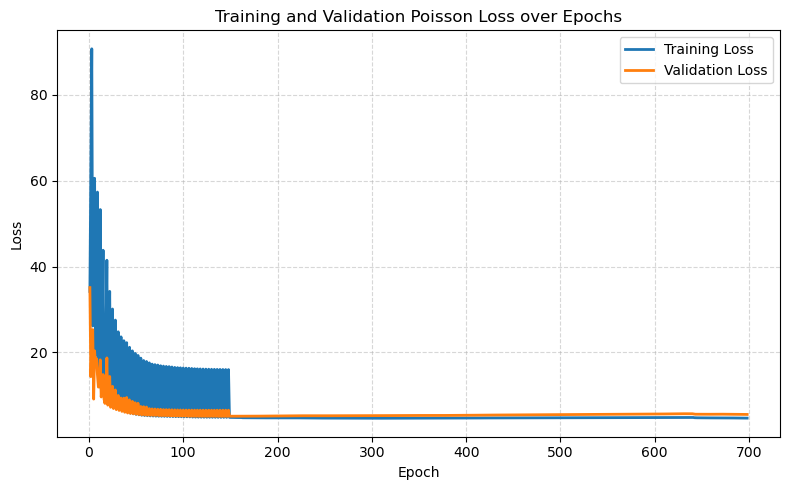

In [30]:
plot_training_history(training_history)


-----------
# 8. Most Exciting Input (MEIs)

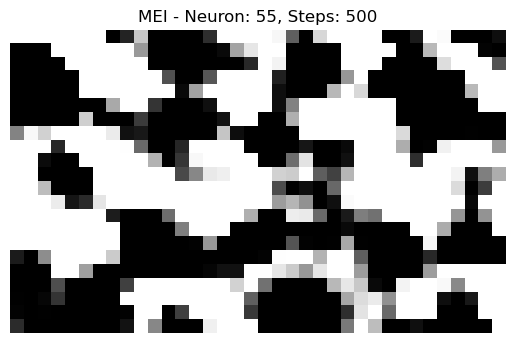

In [31]:
from neuropixel_predictor.mei.generate import generate_mei, plot_mei

device = 'mps'
steps = 500
neuron_idx = 55
mei_data_key = "2023-03-15_11-05"
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    model,
    mei_data_key,
    neuron_idx,
    image_shape,
    steps=steps,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device
)

plot_mei(mei, title="MEI - Neuron: {}, Steps: {}".format(neuron_idx, steps) )

## 8.1 Running MEI generation over the selected data

In [85]:
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d")

save_dir = 'meis'
os.makedirs(save_dir, exist_ok=True)

n_neurons_dict = {
    '2023-03-15_11-05': 373,
    '2023-03-15_15-23': 388,
    '2022-12-20_15-08': 466
}

def generate_and_save_meis(n_neurons_dict, steps=600, title_suffix=""):
    image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    
    total_meis = sum(n_neurons_dict.values())
    current_mei = 0
    
    print(f"Generating {total_meis} MEIs across {len(n_neurons_dict.keys())} data keys...")
    
    for data_key in n_neurons_dict.keys():
        num_neurons = n_neurons_dict[data_key]
        key_save_dir = os.path.join(save_dir, date, data_key)
        os.makedirs(key_save_dir, exist_ok=True)
        print(f"\nProcessing data_key: {data_key} ({num_neurons} neurons)")
        for neuron_idx in range(num_neurons):
            current_mei += 1
            print(f"  Generating MEI {current_mei}/{total_meis}: Neuron {neuron_idx}")    
            # Generate MEI
            mei = generate_mei(
                model,
                data_key,
                neuron_idx,
                image_shape,
                steps=steps,
                mode='cei',
                device=device
            )
            # Create figure and plot
            fig, ax = plt.subplots(figsize=(8, 6))
            plot_mei(mei, neuron_idx, title=f"MEI - {data_key}, Neuron: {neuron_idx}, Steps: {steps} {title_suffix}", save_folder=key_save_dir)


-----------
## 8.2 Use MEI in the model (as sanity check)

In [34]:
# 1. Fetch a stimulus image from the dataset
random_dataset_indx = torch.randint(len(train_dataloaders[mei_data_key]), (1,))
dataset_image = next(iter(train_dataloaders[mei_data_key]))[0].to(device)

# 2. Generate a completely random image
random_image = torch.randn(image_shape, device=device) * 0.1

# 3. Test dataset image, random image and MEI image and compare predictions
pred_random = model(random_image, data_key=mei_data_key)[0, 0, neuron_idx]
pred_dataset = model(dataset_image, data_key=mei_data_key)[0, 0, neuron_idx]
pred_mei = model(mei, data_key=mei_data_key)[0, 0, neuron_idx]

pred_random, pred_dataset, pred_mei

IndexError: index 465 is out of bounds for dimension 2 with size 373

-----------
# 10. Sanity Checks

## 10.1 Baseline Poisson Loss

In [ ]:
# 1. Reshape training responses and validation responses
training_responses = [datapoint[1] for datapoint in list(train_dataloaders["2022-12-20_15-08"])]
training_responses = torch.cat(training_responses, 0)

val_responses = [datapoint[1] for datapoint in list(test_dataloaders["2022-12-20_15-08"])]
val_responses = torch.cat(val_responses, 0)

# 2. Calculate mean
mean_rate = training_responses.mean(dim=0) # shape: (num_of_neurons)
mean_rate.shape

# 3. Repeat mean_rate for all validation samples
baseline_pred_val = mean_rate.expand(val_responses.shape[0], -1)

print("mean_rate of first neuron: ", mean_rate[0])
print("baseline_pred_val of first neuron (subset of 4): ", baseline_pred_val[:4, 0])

# 4. Define Poisson manually
def poisson_loss_manual(pred, target, eps=1e-8):
    return (pred - target * torch.log(pred + eps)).mean()

# 5. Compute baseline validation loss
manual_baseline_val_loss = poisson_loss_manual(baseline_pred_val, val_responses)
nn_baseline_val_loss = nn.PoissonNLLLoss(log_input=False, full=True)(baseline_pred_val, val_responses)

# print("Baseline validation Manual Poisson loss:", manual_baseline_val_loss.item())
print("Baseline validation NN Poisson loss:", nn_baseline_val_loss.item())


## 10.2 Overfit for one neuron on small dataset

Here, we choose two neurons to check 

    - `2023-03-15_11-05` -> 191 (#83), 196 (#84) -> BOTTOM-LEFT
    - `2022-12-20_15-08` -> 622 -> BOTTOM-RIGHT

### 10.2.1 Load a subset of the data

In [106]:
import random
from torch.utils.data import Sampler

class MixedBatchSampler(Sampler):
    def __init__(self, zero_idx, nonzero_idx, batch_size, nonzero_frac=0.5):
        self.zero_idx = zero_idx
        self.nonzero_idx = nonzero_idx
        self.batch_size = batch_size
        self.n_nonzero = int(batch_size * nonzero_frac)
        self.n_zero = batch_size - self.n_nonzero

        assert self.n_nonzero > 0
        assert len(self.nonzero_idx) >= self.n_nonzero
        assert len(self.zero_idx) >= self.n_zero

    def __iter__(self):
        nz = self.nonzero_idx.copy()
        random.shuffle(nz)

        for i in range(0, len(nz) - self.n_nonzero + 1, self.n_nonzero):
            batch = nz[i:i+self.n_nonzero]
            batch += random.sample(self.zero_idx, self.n_zero)
            random.shuffle(batch)
            yield batch

    def __len__(self):
        return len(self.nonzero_idx) // self.n_nonzero



from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SimpleDataset(Dataset):
    def __init__(self, x, y):
        assert len(x) == len(y)
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [111]:
TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training-Delay'

# 1. Create a subset of the first 100 samples
test_data_key = "2023-03-15_11-05"
neuron_indx = [84, 85, 86, 87, 207, 208, 209, 210, 211, 212]
subset_size = 300

small_training_images = np.load(os.path.join(TRAINING_DATA_DIR, "training_images_{}.npy".format(test_data_key)))[:subset_size]
small_training_responses = np.load(os.path.join(TRAINING_DATA_DIR, "training_responses_{}.npy".format(test_data_key)))[:subset_size]
small_training_images = small_training_images.reshape(small_training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
small_training_images = torch.from_numpy(small_training_images).float()
small_training_responses = torch.from_numpy(small_training_responses).float()

small_training_responses = small_training_responses[:, neuron_indx]

# 3. Zip training and test
# small_training_data = list(zip(small_training_images, small_training_responses, weights))
dataset = SimpleDataset(
    small_training_images,
    small_training_responses
)

# 4. Separate zero and non-zero
# y = small_training_responses.squeeze(1)

# # zero_idx = torch.where(y == 0)[0].tolist()
# # nonzero_idx = torch.where(y > 0)[0].tolist()
# # zero_idx = torch.where(~y.sum(dim=1).bool())[0].tolist()
# # nonzero_idx = torch.where(y.sum(dim=1).bool())[0].tolist()
# zero_idx = torch.where((y == 0).all(dim=1))[0].tolist()
# nonzero_idx = torch.where((y > 0).any(dim=1))[0].tolist()

# assert max(zero_idx + nonzero_idx) < len(dataset)
# print("Zeros: {}, Non-Zeros: {}".format(len(zero_idx), len(nonzero_idx)))

# # 5. Convert to DataLoader
# # small_train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# sampler = MixedBatchSampler(
#     zero_idx,
#     nonzero_idx,
#     batch_size=32,
#     nonzero_frac=0.5
# )

# small_train_dataloader = DataLoader(
#     dataset,
#     batch_sampler=sampler
# )

# Overfit on very small dataset
single_batch_dataset = torch.utils.data.Subset(dataset, torch.arange(32))
single_batch_loader = DataLoader(
    single_batch_dataset,
    batch_size=32,
    shuffle=False
)

In [112]:
for batch in sampler:
    assert max(batch) < len(dataset)
    assert min(batch) >= 0
print("Sampler OK")

Sampler OK


### 10.2.2 Customize the readout and model for one neuron

In [113]:
from neuropixel_predictor.layers.cores import Stacked2dCore
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

# Could also build the following programmatically
in_shapes_dict = {
    '2023-03-15_11-05': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT])
} 

n_neurons_dict = {
    '2023-03-15_11-05': 10
}

mean_activity_dict = {
    '2023-03-15_11-05': torch.log(small_training_responses.mean() + 1e-6)
}

stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'batch_norm': False
}


one_neuron_factorized_multi_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    mean_activity_dict=mean_activity_dict,
    base_readout=FullFactorized2d,
    bias=True,
    normalize=False,
    init_noise=0.5
)

# Creating new instance but with same params
one_neuron_core = Stacked2dCore(
    **stacked2dcore_config,
)

one_neuron_model = GeneralizedEncoderBase(
    one_neuron_core,
    one_neuron_factorized_multi_readout,
    elu=False
)

### 10.2.3 Running the training on this subset of data

In [114]:
# 1. Train on this small dataset
import torch.nn.functional as F
import torch.optim as optim

poisson_loss = nn.PoissonNLLLoss(log_input=True, full=False)
mse_loss = nn.MSELoss()
device = 'mps'

optimizer = optim.Adam(one_neuron_model.parameters(), lr=3e-5)
optimizer = optim.Adam([
    {"params": one_neuron_core.parameters(), "lr": 1e-4},
    {"params": one_neuron_factorized_multi_readout.parameters(), "lr": 5e-3},
])
one_neuron_model.to(torch.device(device))


# Freeze the core
for p in one_neuron_core.parameters():
    p.requires_grad = True

# # Freeze all but last
# for name, p in one_neuron_core.named_parameters():
#     if "layer2" in name:   # top conv layer
#         p.requires_grad = True
#         print("Unfreezed the top conv layer")
#     else:
#         p.requires_grad = False
overfit_history = {'loss': [], 'pred_std': [], 'y_std': [], 'corr': [], 'r2': []}
for epoch in range(1000):
    for x_batch, y_batch in single_batch_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        pred = one_neuron_model(x_batch, data_key=test_data_key)
        pred = pred[:, 0, :]
        # rate = torch.exp(pred)   # IMPORTANT
        # loss = nn.PoissonNLLLoss(log_input=False)(rate, y_batch)
        # pred = torch.clamp(pred, min=-10, max=10)
        # loss = poisson_loss(pred, y_batch)

        # err = (pred - y_batch) ** 2
        # loss = err.mean()
        loss = poisson_loss(pred, y_batch)
        loss.backward()
        
        optimizer.step()
    
    if epoch % 20 == 0:
        # print(f"Epoch {epoch}: loss = {loss.item():.4f}")
        with torch.no_grad():
            y_std = y_batch.std().item()
            pred_std_batch  = pred.std(dim=0).mean().item()
            pred_std_neuron = pred.std(dim=1).mean().item()
            corr = torch.corrcoef(
                torch.stack([pred.flatten(), y_batch.flatten()])
            )[0, 1]

        overfit_history['loss'].append(loss)
        overfit_history['pred_std'].append(pred_std_neuron)
        overfit_history['y_std'].append(y_std)
        overfit_history['corr'].append(corr)
        print(
            f"Epoch {epoch}: "
            f"loss={loss.item():.2f}, "
            f"pred_std_batch={pred_std_batch:.2f}, "
            f"pred_std_neuron={pred_std_neuron:.2f}, "
            f"y_std={y_std:.2f}, "
            f"correlation={corr:.2f}, "
        )

Epoch 0: loss=20301.04, pred_std_batch=4.06, pred_std_neuron=4.45, y_std=5.29, correlation=0.07, 
Epoch 20: loss=24.74, pred_std_batch=2.34, pred_std_neuron=2.32, y_std=5.29, correlation=0.11, 
Epoch 40: loss=45.21, pred_std_batch=2.21, pred_std_neuron=2.10, y_std=5.29, correlation=0.15, 
Epoch 60: loss=46.22, pred_std_batch=2.20, pred_std_neuron=2.11, y_std=5.29, correlation=0.20, 
Epoch 80: loss=40.56, pred_std_batch=2.20, pred_std_neuron=2.15, y_std=5.29, correlation=0.23, 
Epoch 100: loss=35.57, pred_std_batch=2.19, pred_std_neuron=2.20, y_std=5.29, correlation=0.25, 
Epoch 120: loss=17.75, pred_std_batch=2.13, pred_std_neuron=2.17, y_std=5.29, correlation=0.27, 
Epoch 140: loss=14.31, pred_std_batch=2.10, pred_std_neuron=2.17, y_std=5.29, correlation=0.29, 
Epoch 160: loss=12.10, pred_std_batch=2.10, pred_std_neuron=2.21, y_std=5.29, correlation=0.31, 
Epoch 180: loss=10.34, pred_std_batch=2.09, pred_std_neuron=2.23, y_std=5.29, correlation=0.33, 
Epoch 200: loss=8.97, pred_std_ba

### 10.2.4 Calculate the neuron-wise R2 values 

In [142]:
# 1. Remove neurons with zero variance
var = y_batch.var(dim=0)
valid = var > 1e-6
y = y_batch[:, valid]

# 2. Accumulate the Y_hats and Y
Y = []
Yhat = []

with torch.no_grad():
    for x, y in single_batch_loader:
        x, y = x.to(device), y.to(device)
        yhat = one_neuron_model(x, data_key=test_data_key)
        yhat = yhat[:, 0, :]
        Y.append(y)
        Yhat.append(yhat)

Y = torch.cat(Y, dim=0)
Yhat = torch.cat(Yhat, dim=0)

# 3. Calculate R2
ss_res = ((Y - Yhat) ** 2).sum(dim=0)
ss_tot = ((Y - Yhat.mean(dim=0)) ** 2).sum(dim=0)
r2 = 1 - ss_res / ss_tot
r2 = r2.detach().cpu().numpy()

# 4. Calculate statistics
print("Median R²:", np.median(r2))
print("90th percentile:", np.percentile(r2, 90))
print("Fraction R² > 0:", np.mean(r2 > 0))
r2

Median R²: 0.10066393
90th percentile: 0.28109962
Fraction R² > 0: 0.7


array([ 0.09333521,  0.31635976, -2.5307405 ,  0.26789778,  0.08312184,
        0.27188718,  0.10799265, -0.3563789 ,  0.27718186, -0.14298165],
      dtype=float32)

### 10.2.5 Plot the loss and standard deviation

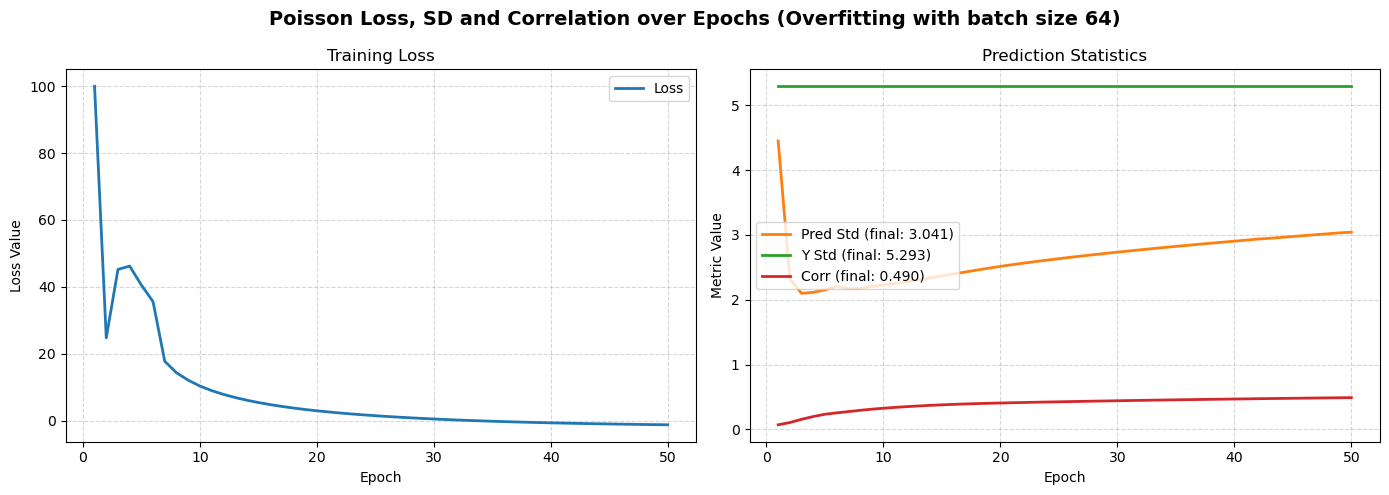

In [141]:
import matplotlib.pyplot as plt

def plot_overfitting_history(history):
    """
    Simpler version with all metrics on same subplot (right side)
    """
    epochs = range(1, len(history['loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- Subplot 1: Loss ---
    ax1.plot(epochs, history['loss'], label='Loss', linewidth=2, color='tab:blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value')
    ax1.set_title('Training Loss')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend()
    
    # --- Subplot 2: All other metrics ---
    # Plot all metrics with different colors
    colors = {'pred_std': 'tab:orange', 'y_std': 'tab:green', 'corr': 'tab:red'}
    
    for metric, color in colors.items():
        if metric in history:
            ax2.plot(epochs, history[metric], label=metric.replace('_', ' ').title(), 
                    linewidth=2, color=color)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Prediction Statistics')
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend(loc='best')
    
    # Highlight final values in legend
    handles, labels = ax2.get_legend_handles_labels()
    for i, metric in enumerate(['pred_std', 'y_std', 'corr']):
        if metric in history:
            final_val = history[metric][-1]
            labels[i] = f"{labels[i]} (final: {final_val:.3f})"
    ax2.legend(handles, labels, loc='best')
    
    fig.suptitle('Poisson Loss, SD and Correlation over Epochs (Overfitting with batch size 64)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

new_history = {
    'loss': [min(100, float(l)) for l in overfit_history['loss']],
    'pred_std': overfit_history['pred_std'],
    'y_std': overfit_history['y_std'],
    'corr': [float(c) for c in overfit_history['corr']]
}
    
plot_overfitting_history(new_history)

### 10.2.5 Generating MEI based on this network

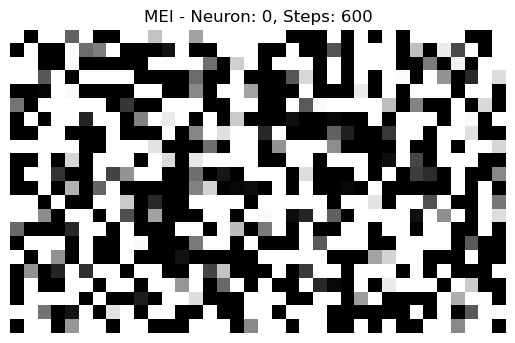

In [143]:
from neuropixel_predictor.mei.generate import generate_mei, plot_mei

device = 'mps'
steps = 600
neuron_idx = 0 # Cause there's only one neuron
mei_data_key = "2023-03-15_11-05"
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    one_neuron_model,
    mei_data_key,
    neuron_idx,
    image_shape,
    steps=steps,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device
)

plot_mei(mei, title="MEI - Neuron: {}, Steps: {}".format(neuron_idx, steps) )

**Printing a random stimulus with its corresponding firing rate**

y[i]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y[i+1]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
x[i] mean: 0.9545454382896423
x[i+1] mean: 0.9545454382896423


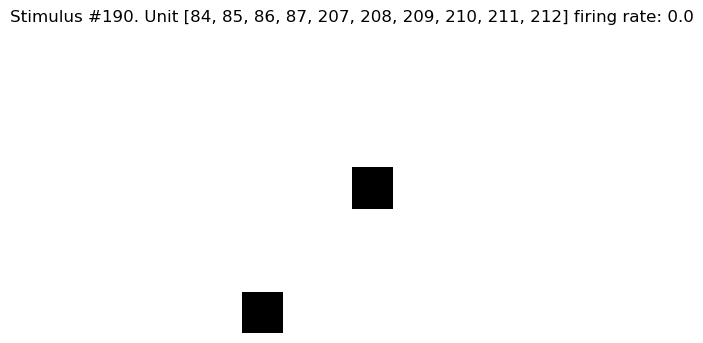

In [18]:
i = torch.randint(0, len(dataset), (1,)).item()
# i = 43, 189, 190
i = 190

x_i, y_i = dataset[i]
x_ip1, y_ip1 = dataset[i+1]

print("y[i]:", y_i)
print("y[i+1]:", y_ip1)
print("x[i] mean:", x_i.mean().item())
print("x[i+1] mean:", x_ip1.mean().item())

plot_mei(x_i, title="Stimulus #{}. Unit {} firing rate: {}".format(i, neuron_indx, y_i[0]))
# plot_mei(x_i, title="Stimulus #{}. Unit {} firing rate: {}".format(i+1, neuron_indx, y_ip1[0]))

### 10.2.5 Calculating Correlations between predictions and true values

In [292]:
with torch.no_grad():
    preds = []
    ys = []
    for x, y in small_train_dataloader:
        x = x.to(device)
        preds.append(one_neuron_model(x, data_key=test_data_key).cpu())
        ys.append(y)

preds = torch.cat(preds).squeeze()
ys = torch.cat(ys).squeeze()

corr = torch.corrcoef(torch.stack([preds, ys]))[0, 1]
print("Train correlation:", corr.item())

RuntimeError: corrcoef(): expected input to have two or fewer dimensions but got an input with 3 dimensions

In [67]:
rate_preds = torch.exp(preds)

corr = torch.corrcoef(torch.stack([
    rate_preds.squeeze(),
    ys.squeeze()
]))[0, 1]

print("Train correlation:", corr.item())


Train correlation: -0.02025654725730419


In [30]:
### Testing the variance of model core outputs
with torch.no_grad():
    feats = one_neuron_model.core(small_training_images.to(device))
    print("Mean of features:", feats.mean().item())
    print("Std of features:", feats.std().item())

# Printing out gradients to check their value
print("-----")
print("Gradients")
for name, p in one_neuron_model.core.named_parameters():
    if p.grad is not None:
        print(name, p.grad.abs().mean())

# Print the gradient norm at the readout parameters
# for name, p in model.readout["2023-03-15_11-05"].named_parameters():
#     print(name, p.grad.norm())


Mean of features: 0.011077103205025196
Std of features: 0.20982816815376282
-----
Gradients
features.layer0.conv.weight tensor(0.0282, device='mps:0')
features.layer1.conv.weight tensor(0.0046, device='mps:0')
features.layer1.conv.bias tensor(0.7148, device='mps:0')
features.layer2.conv.weight tensor(0.0039, device='mps:0')
features.layer2.conv.bias tensor(0.6271, device='mps:0')


## 10.3 Expanding to more data while tracking R2

In [ ]:
# import os
# os.environ["WANDB_DISABLE_SERVICE"] = "true"
import wandb


from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="charite-ahmedtarek-",
    # Set the wandb project where this run will be logged.
    project="np-predictor",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "FULL",
        "epochs": 10,
    },
)

class SimpleDataset(Dataset):
    def __init__(self, x, y):
        assert len(x) == len(y)
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [105]:
################ A. Preparing the data ################
TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training-Delay'

# 1. Create a subset of the first 100 samples
# test_data_key = "2023-03-15_11-05"
# neuron_indx = [84, 85, 86, 87, 207, 208, 209, 210, 211, 212]

# small_training_images = np.load(os.path.join(TRAINING_DATA_DIR, "training_images_{}.npy".format(test_data_key)))[:subset_size]
# small_training_responses = np.load(os.path.join(TRAINING_DATA_DIR, "training_responses_{}.npy".format(test_data_key)))[:subset_size]

# test_images = np.load(os.path.join(TRAINING_DATA_DIR, "test_images_{}.npy".format(test_data_key)))
# test_responses = np.load(os.path.join(TRAINING_DATA_DIR, "test_responses_{}.npy".format(test_data_key)))
    
# small_training_images = small_training_images.reshape(small_training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
# test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# # 2. Convert to tensors and typecast to float
# small_training_images = torch.from_numpy(small_training_images).float()
# small_training_responses = torch.from_numpy(small_training_responses).float()
# test_images = torch.from_numpy(test_images).float()
# test_responses = torch.from_numpy(test_responses).float()

# 3. Constrain to handful of neurons 
# small_training_responses = small_training_responses[:, neuron_indx]

# 4. Create Dataesets
# training_dataset = SimpleDataset(small_training_images, small_training_responses)
# test_dataset = SimpleDataset(test_images, test_responses)

# 4. Convert to DataLoader
# small_train_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


train_dataloader_1, test_dataloader_1, resp_mean_1 = load_dataset("2023-03-15_11-05")
train_dataloader_2, test_dataloader_2, resp_mean_2 = load_dataset("2023-03-15_15-23")
# train_dataloader_1, test_dataloader_1 = load_dataset("2022-12-20_15-08")

train_dataloaders = {
    "2023-03-15_11-05": train_dataloader_1,
    "2023-03-15_15-23": train_dataloader_2,
    # "2022-12-20_15-08": train_dataloader_1
}

test_dataloaders = {
    "2023-03-15_11-05": test_dataloader_1,
    "2023-03-15_15-23": test_dataloader_2,
    # "2022-12-20_15-08": test_dataloader_1
}

In [195]:
################ B. Defining the model ################
from neuropixel_predictor.layers.cores import Stacked2dCore
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn
import torch.optim as optim

# Could also build the following programmatically
in_shapes_dict = {
    '2023-03-15_11-05': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    '2023-03-15_15-23': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2022-12-20_15-08': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT])
} 

n_neurons_dict = {
    '2023-03-15_11-05': 373,
    '2023-03-15_15-23': 388,
    # '2022-12-20_15-08': 466
}

mean_activity_dict = {
    '2023-03-15_11-05': torch.log(resp_mean_1 + 1e-6),
    '2023-03-15_15-23': torch.log(resp_mean_2 + 1e-6)
}

stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'batch_norm': False
}

factorized_multi_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    mean_activity_dict=mean_activity_dict,
    base_readout=FullFactorized2d,
    bias=True,
    normalize=False,
    init_noise=0.5
)

# # Creating new instance but with same params
# core = Stacked2dCore(
#     **stacked2dcore_config,
# )

model = GeneralizedEncoderBase(
    core,
    factorized_multi_readout,
    elu=False
)

# # Defining optimizer here because it should be carried along in the training
# optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [196]:
################ C. Training the model ################
import torch.nn.functional as F
import torch.optim as optim
import copy

NUM_EPOCHS = 30

# 1. Define loss function
poisson_loss = nn.PoissonNLLLoss(log_input=True, full=False)
mse_loss = nn.MSELoss()
device = 'mps'

# 2. Defining optimizer, learning rates and weight decays
optimizer = optim.Adam([
    {"params": factorized_multi_readout.parameters(), "lr": 1e-3},
    {"params": core.features.layer2.parameters(), "lr": 5e-5, "weight_decay": 1e-5},
    {"params": core.features.layer1.parameters(), "lr": 2e-5, "weight_decay": 1e-5},
    # {"params": core.features.layer0.parameters(), "lr": 5e-6, "weight_decay": 1e-5},
])

# 3. Clip the gradients (to avoid numerical instability)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
model.to(torch.device(device))

# 4. Freeze the core
# for p in core.parameters():
#     p.requires_grad = False

# Freeze all but last
for name, p in core.named_parameters():
    if "layer2" in name:   # top conv layer
        p.requires_grad = True
        print("Unfreezed layer2")
    if "layer1" in name:
        p.requires_grad = True
        print("Unfreezed layer1")
    # if "layer0" in name:
    #     p.requires_grad = True
    #     print("Unfreezed layer0")
    else:
        p.requires_grad = False

# Which dataset to train with
train_dataloaders = {
    "2023-03-15_11-05": train_dataloader_1,
    "2023-03-15_15-23": train_dataloader_2,
    # "2022-12-20_15-08": train_dataloader_1
}

# Creating history (deepcopy here is to avoid reference copying)
history = {'training_loss': [], 'val_loss': [], 'pred_std': [], 'y_std': [], 'training_corr': [], 'val_corr': []}
history = dict([[dk, copy.deepcopy(history)] for dk in train_dataloaders.keys()])

# Training looooooop
for epoch in range(NUM_EPOCHS):
    for data_key in train_dataloaders.keys():
        for x_batch, y_batch in train_dataloaders[data_key]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
            optimizer.zero_grad()
            log_pred = model(x_batch, data_key=data_key)                 # Caclulate predictions
            log_pred = log_pred[:, 0, :]              # Reshape predictions 
            log_pred = torch.clamp(log_pred, min=-10, max=10) # Clamp Predictions
            
            training_loss = poisson_loss(log_pred, y_batch)
            training_loss.backward()
            
            optimizer.step()
    
        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for images, responses in test_dataloaders[data_key]:
                images, responses = images.to(device), responses.to(device)
                # 1. Run model on validation batch
                val_log_pred = model(images, data_key=data_key)
                val_log_pred = val_log_pred[:, 0, :]
                val_log_pred = torch.clamp(val_log_pred, min=-10, max=10)
                # 2. Calculate loss
                test_loss = poisson_loss(val_log_pred, responses)
                # 3. Accumulate validation loss
                running_val_loss += test_loss.item() * images.size(0)
                # 4. Append predictions and targets for statistics
                val_preds.append(val_log_pred.cpu())
                val_targets.append(responses.cpu())
    
        # 5. Finalize validation loss
        epoch_val_loss = running_val_loss / len(test_dataloaders[data_key].dataset)
    
        # 6. Calculate correlations
        val_preds = torch.cat(val_preds, dim=0)
        val_targets = torch.cat(val_targets, dim=0)
        validation_corr = torch.corrcoef(torch.stack([val_preds.flatten(), val_targets.flatten()]))[0, 1]
    
        # 7. Append to history
        history[data_key]['val_loss'].append(epoch_val_loss)
        history[data_key]['val_corr'].append(validation_corr)
    
        # --- Logging ---
        if epoch % 5 == 0:
            with torch.no_grad():
                y_std = y_batch.std().item()                          # true SD
                # pred_std_batch  = pred.std(dim=0).mean().item()     # btch SD
                pred_std_neuron = log_pred.std(dim=1).mean().item()   # unit SD
                training_corr = torch.corrcoef(                       # correlation
                    torch.stack([log_pred.flatten(), y_batch.flatten()])
                )[0, 1]
    
            history[data_key]['training_loss'].append(training_loss)
            history[data_key]['pred_std'].append(pred_std_neuron)
            history[data_key]['y_std'].append(y_std)
            history[data_key]['training_corr'].append(training_corr)
            print("\nCurrently learning for data_key: ", data_key)
            print(
                f"Epoch {epoch}: "
                f"loss={training_loss.item():.2f}, "
                f"pred_std_neuron={pred_std_neuron:.2f}, "
                f"y_std={y_std:.2f}, "
                # f"training_correlation={training_corr:.2f}, "
                f"validation_correlation={validation_corr:.2f}, "
                f"validation_loss={epoch_val_loss:.2f}, "
            )

Unfreezed layer1
Unfreezed layer1
Unfreezed layer2
Unfreezed layer2

Currently learning for data_key:  2023-03-15_11-05
Epoch 0: loss=2379.40, pred_std_neuron=6.22, y_std=8.56, validation_correlation=0.02, validation_loss=2530.66, 

Currently learning for data_key:  2023-03-15_15-23
Epoch 0: loss=2448.72, pred_std_neuron=6.21, y_std=11.80, validation_correlation=0.03, validation_loss=2367.61, 


KeyboardInterrupt: 

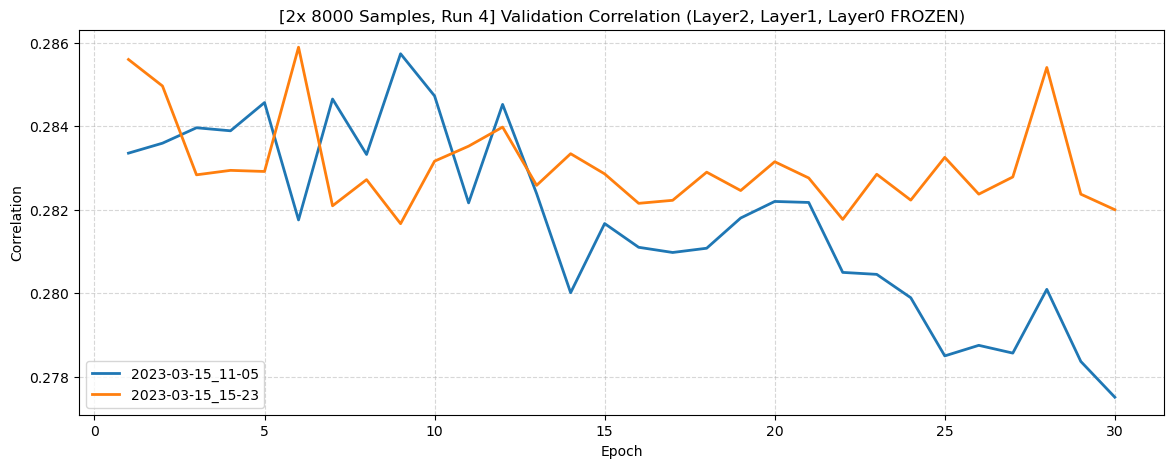

In [167]:
plot_metric(history, 'val_corr', "[2x 8000 Samples, Run 4] Validation Correlation (Layer2, Layer1, Layer0 FROZEN)", "Correlation")

In [168]:
################ D. Calculating statistics (R2) ################
# 1.1 Remove neurons with zero variance
        # var = y.var(dim=0)
        # valid = var > 1e-6
        # y = y[:, valid]

# 1. Accumulate the Y_hats and Y
Y = dict([[k, []] for k in test_dataloaders.keys()])
Yhat = dict([[k, []] for k in test_dataloaders.keys()])
r2 = {}

with torch.no_grad():
    for data_key in test_dataloaders.keys():
        for x, y in test_dataloaders[data_key]:
            x, y = x.to(device), y.to(device)
            # 1.2 Calculate model prediction
            yhat = model(x, data_key=data_key)
            yhat = yhat[:, 0, :]
            Y[data_key].append(y)
            Yhat[data_key].append(yhat)

for dk in Y.keys():
    y = torch.cat(Y[dk], dim=0)
    yhat = torch.cat(Yhat[dk], dim=0)
    
    # 3. Calculate R2
    ss_res = ((y - yhat) ** 2).sum(dim=0)
    ss_tot = ((y - yhat.mean(dim=0)) ** 2).sum(dim=0)
    r2[dk] = 1 - ss_res / ss_tot
    r2[dk] = r2[dk].detach().cpu().numpy()
    
    # 4. Calculate statistics
    print("\nFor DataKey: ", dk)
    print("Median R²:", np.median(r2[dk]))
    print("90th percentile:", np.percentile(r2[dk], 90))
    print("Fraction R² > 0:", np.mean(r2[dk] > 0))
    print("Neurons with high R²: ", [int(i) for i in (r2[dk] > 0.1).nonzero()[0]] )


For DataKey:  2023-03-15_11-05
Median R²: 0.016382694
90th percentile: 0.059117973
Fraction R² > 0: 0.6809651474530831
Neurons with high R²:  [71, 80, 83, 102, 104, 298, 300]

For DataKey:  2023-03-15_15-23
Median R²: 0.006037563
90th percentile: 0.035495114
Fraction R² > 0: 0.7628865979381443
Neurons with high R²:  [36, 165]


Generating 373 MEIs across 1 data keys...

Processing data_key: 2023-03-15_11-05 (373 neurons)
  Generating MEI 1/373: Neuron 0


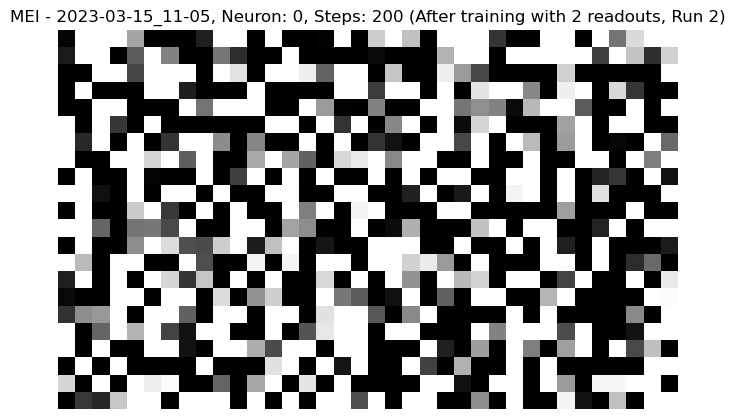

  Generating MEI 2/373: Neuron 1


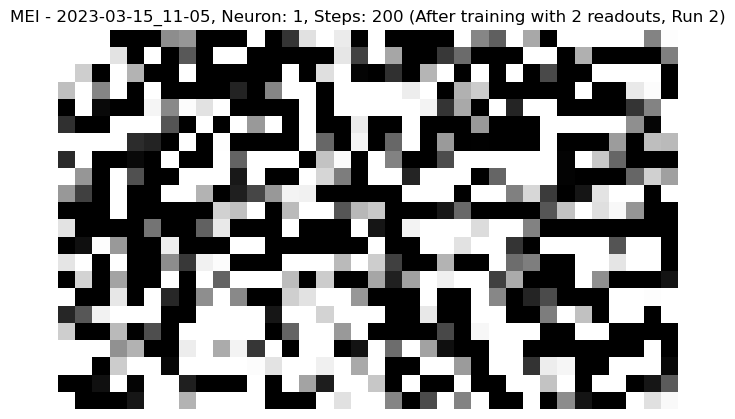

  Generating MEI 3/373: Neuron 2


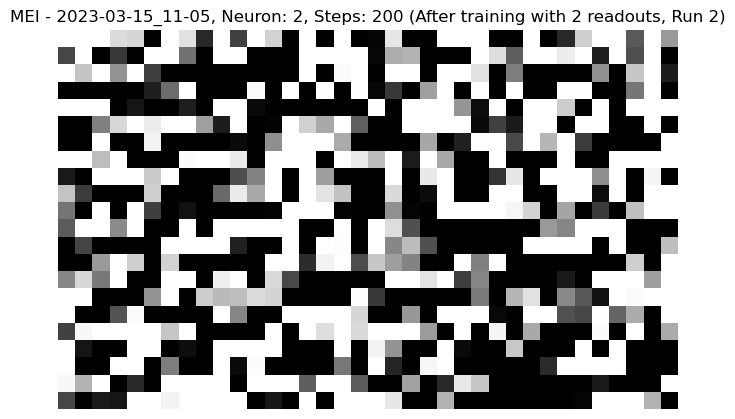

  Generating MEI 4/373: Neuron 3


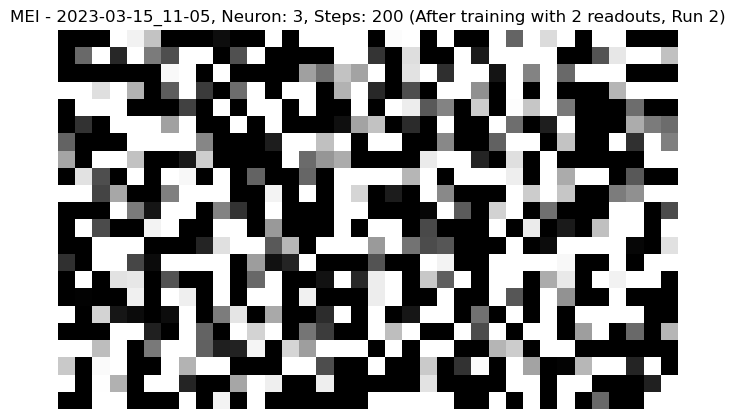

  Generating MEI 5/373: Neuron 4


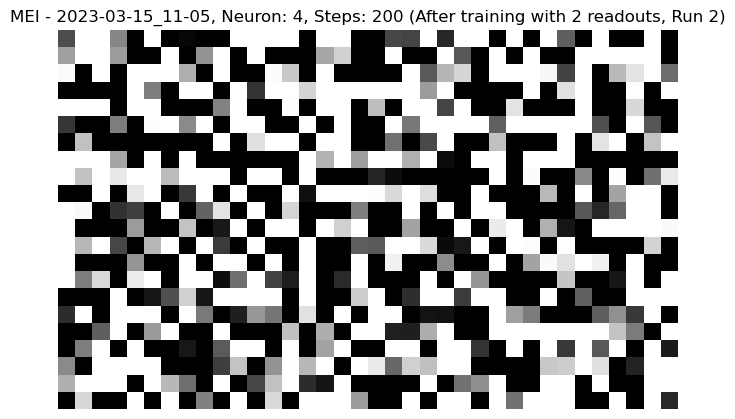

  Generating MEI 6/373: Neuron 5


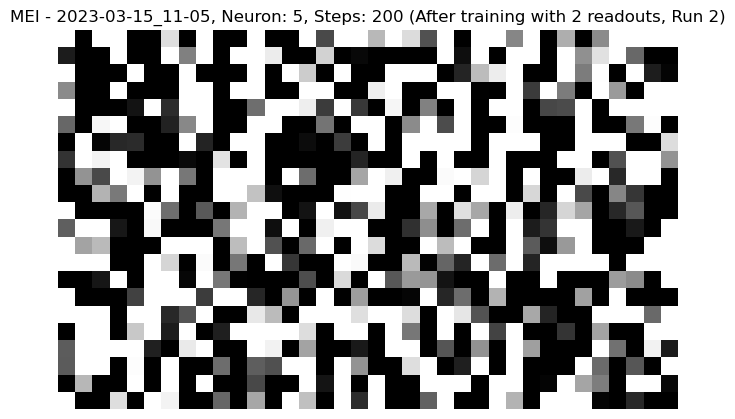

  Generating MEI 7/373: Neuron 6


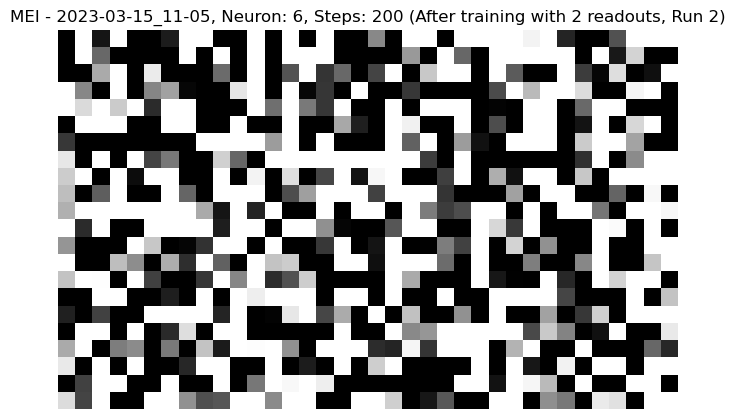

  Generating MEI 8/373: Neuron 7


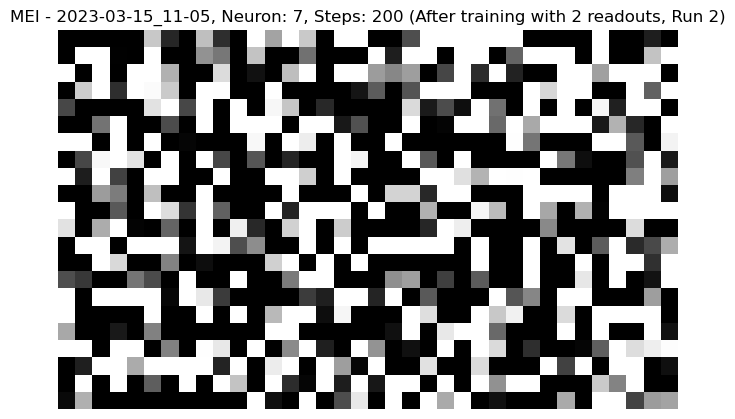

  Generating MEI 9/373: Neuron 8


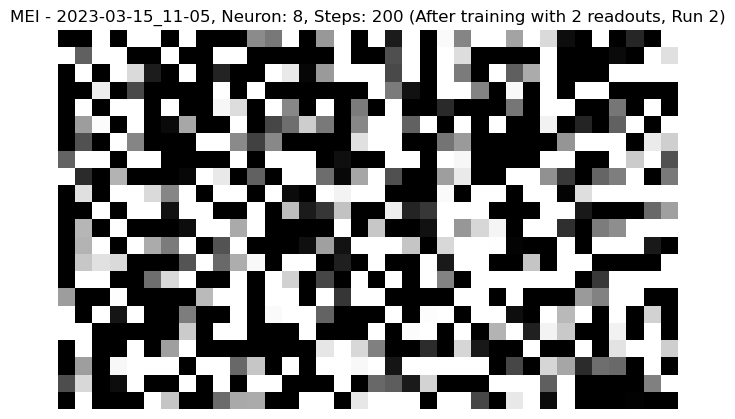

  Generating MEI 10/373: Neuron 9


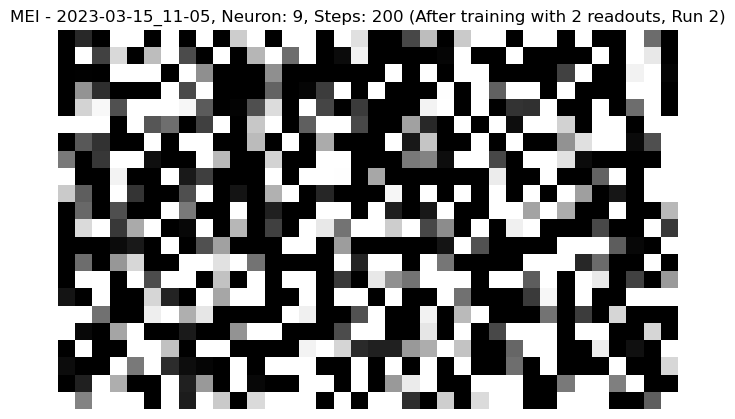

  Generating MEI 11/373: Neuron 10


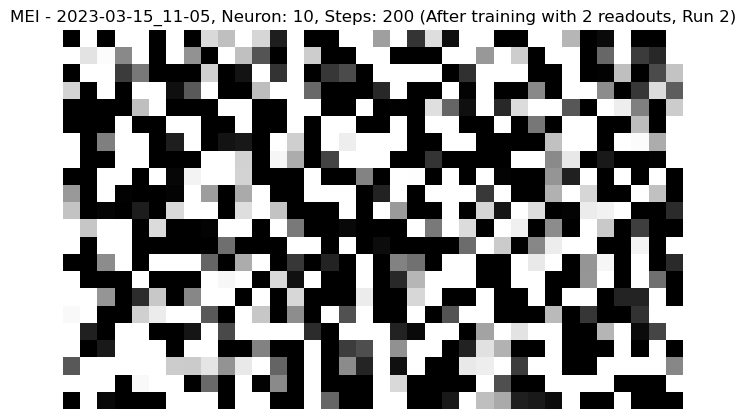

  Generating MEI 12/373: Neuron 11


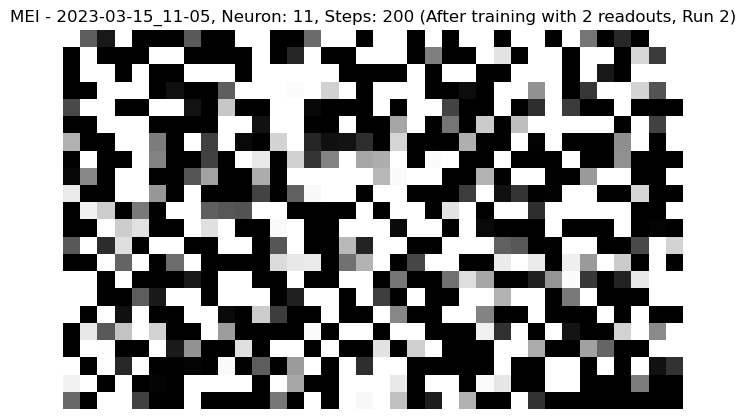

  Generating MEI 13/373: Neuron 12


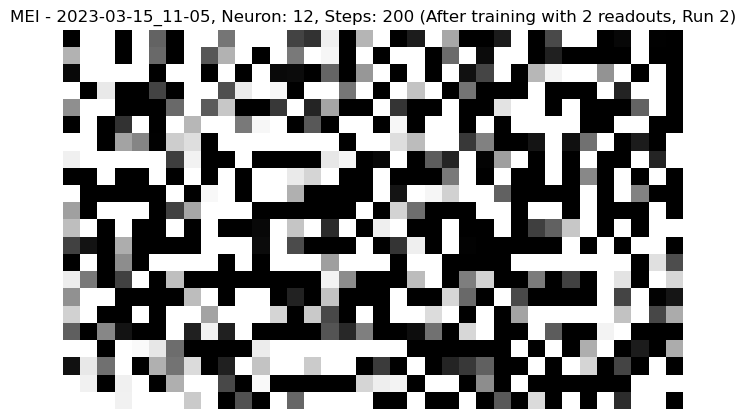

  Generating MEI 14/373: Neuron 13


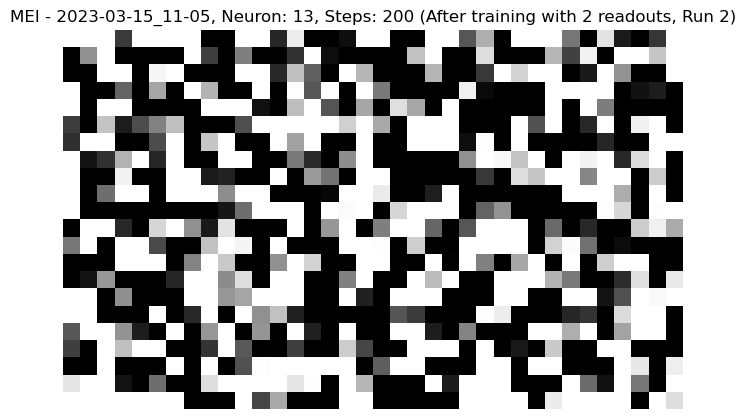

  Generating MEI 15/373: Neuron 14


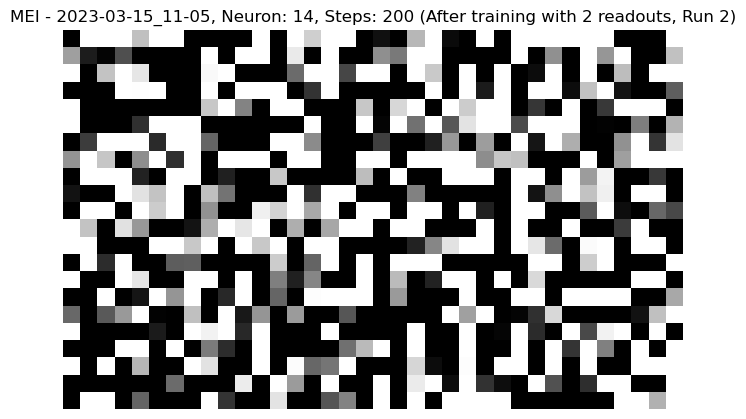

  Generating MEI 16/373: Neuron 15


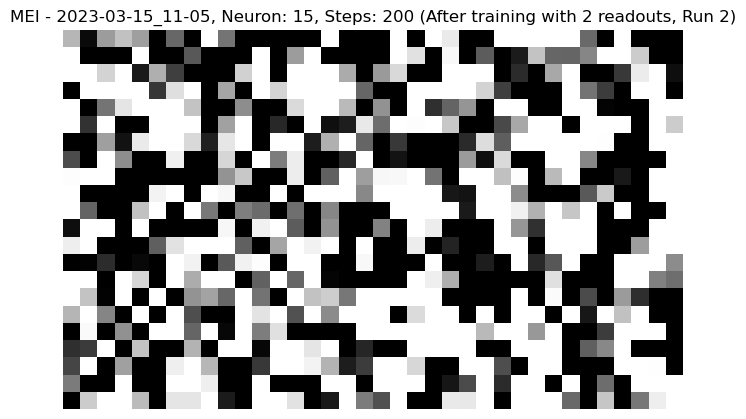

  Generating MEI 17/373: Neuron 16


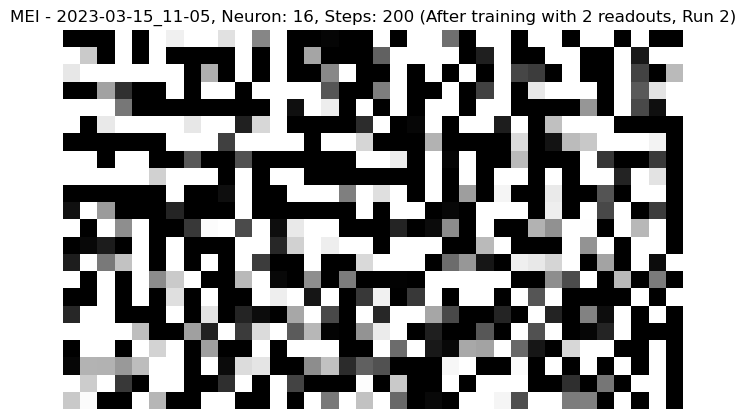

  Generating MEI 18/373: Neuron 17


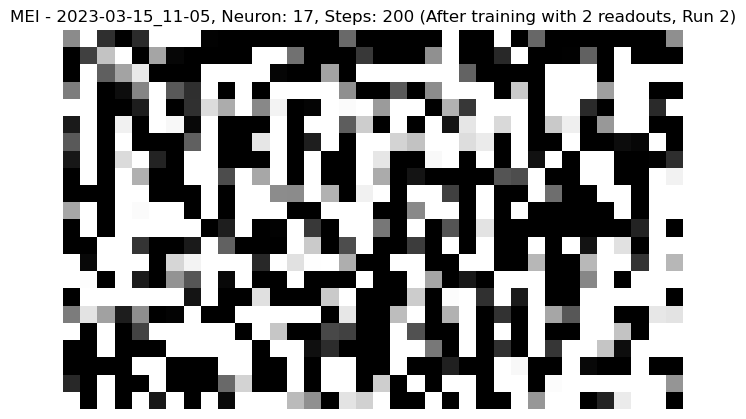

  Generating MEI 19/373: Neuron 18


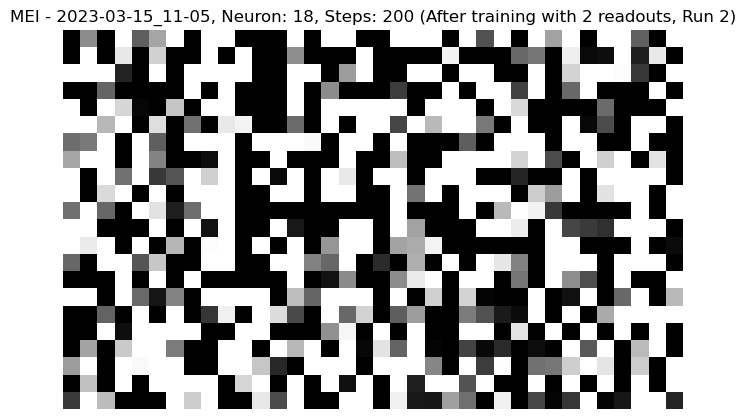

  Generating MEI 20/373: Neuron 19


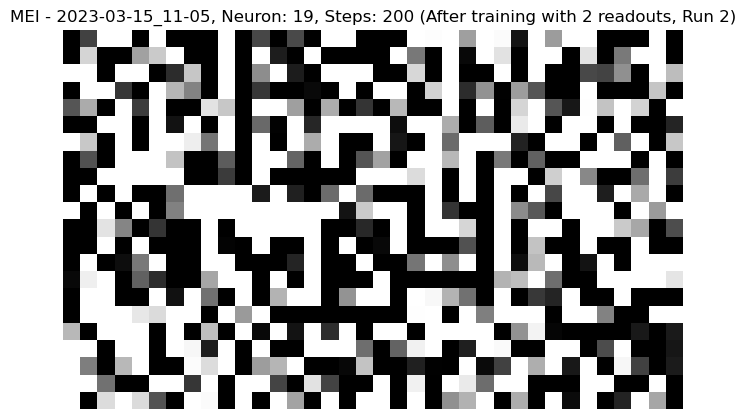

  Generating MEI 21/373: Neuron 20


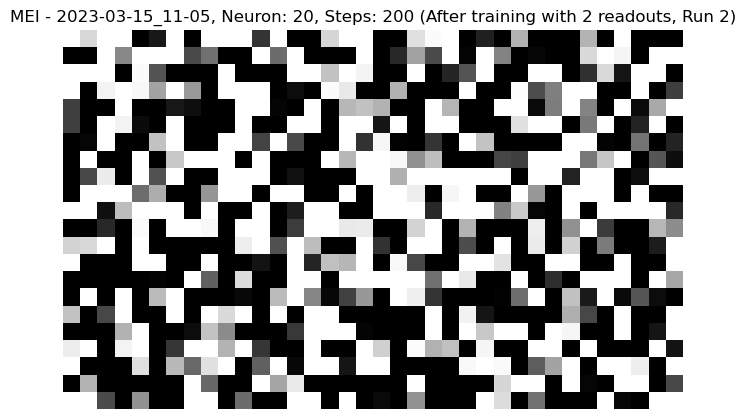

  Generating MEI 22/373: Neuron 21


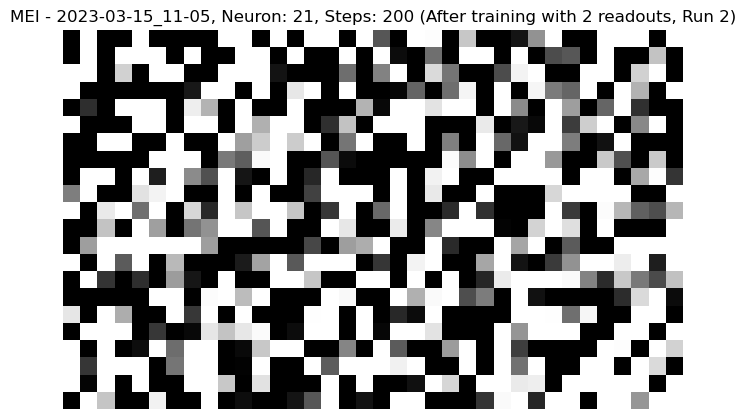

  Generating MEI 23/373: Neuron 22


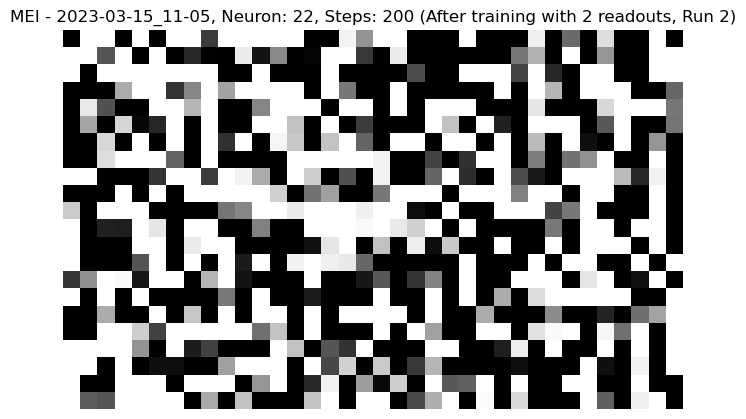

  Generating MEI 24/373: Neuron 23


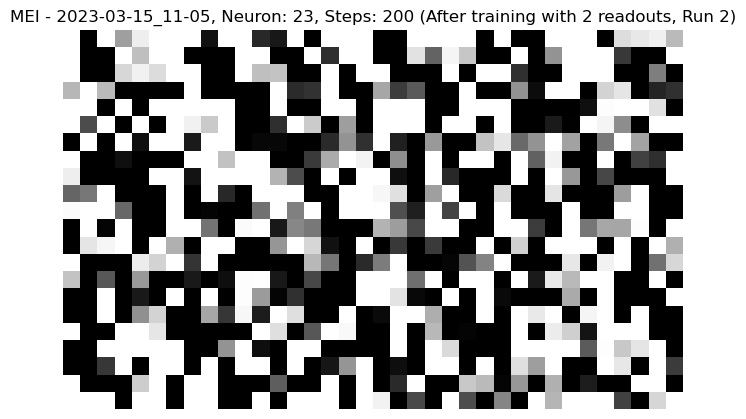

  Generating MEI 25/373: Neuron 24


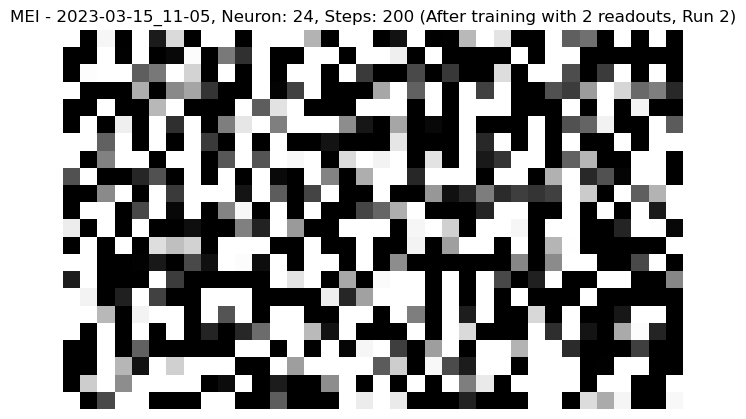

  Generating MEI 26/373: Neuron 25


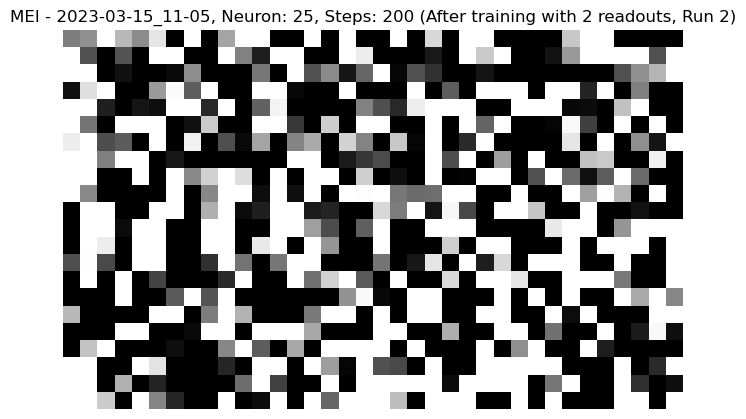

  Generating MEI 27/373: Neuron 26


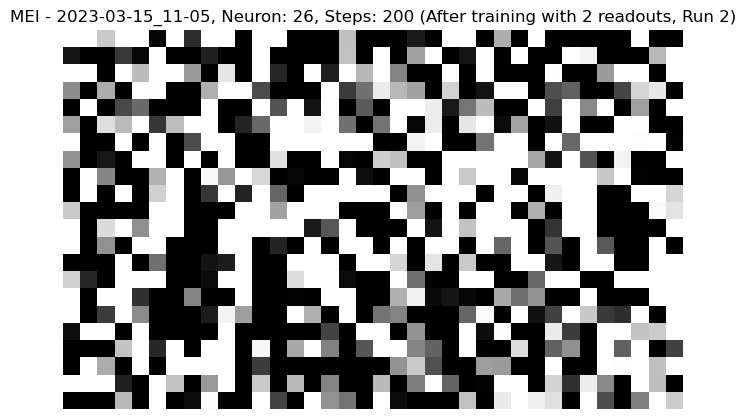

  Generating MEI 28/373: Neuron 27


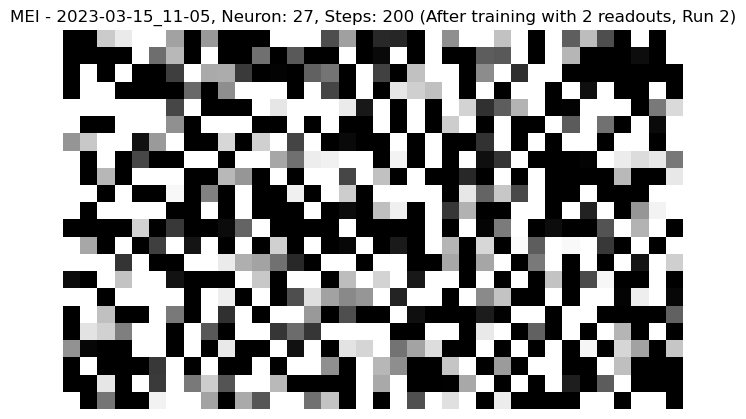

  Generating MEI 29/373: Neuron 28


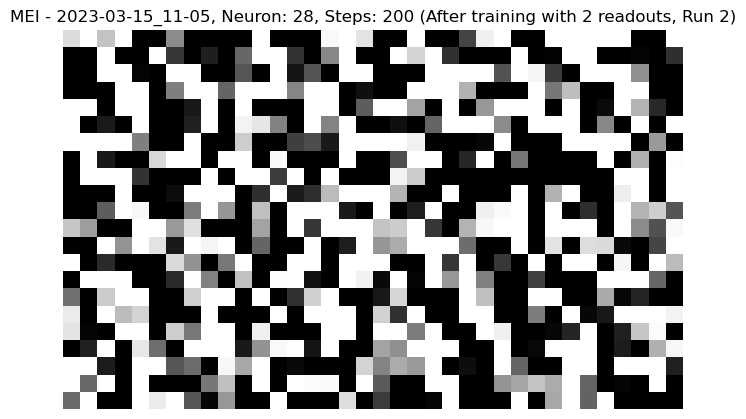

  Generating MEI 30/373: Neuron 29


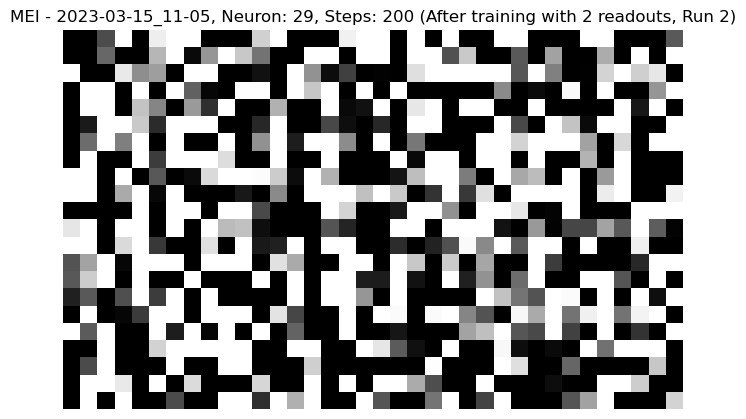

  Generating MEI 31/373: Neuron 30


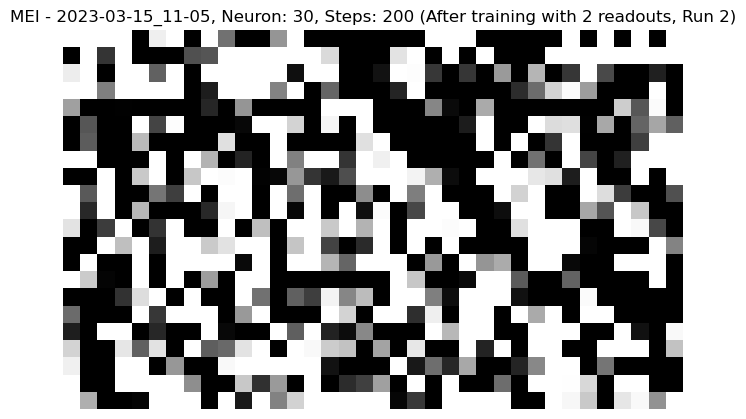

  Generating MEI 32/373: Neuron 31


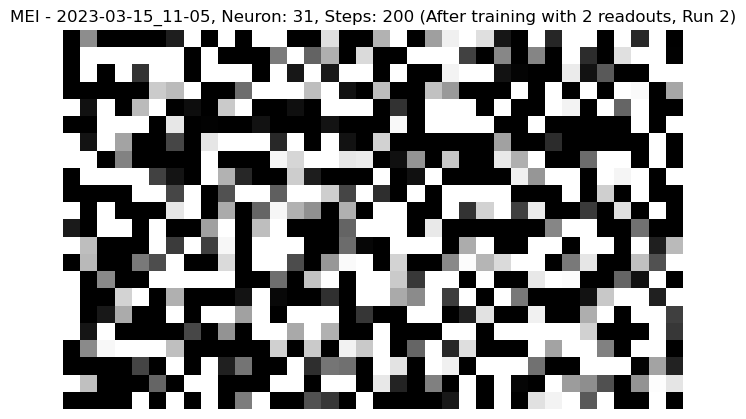

  Generating MEI 33/373: Neuron 32


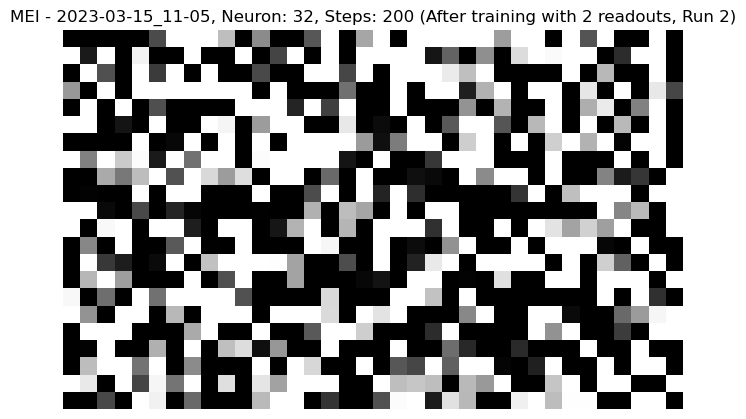

  Generating MEI 34/373: Neuron 33


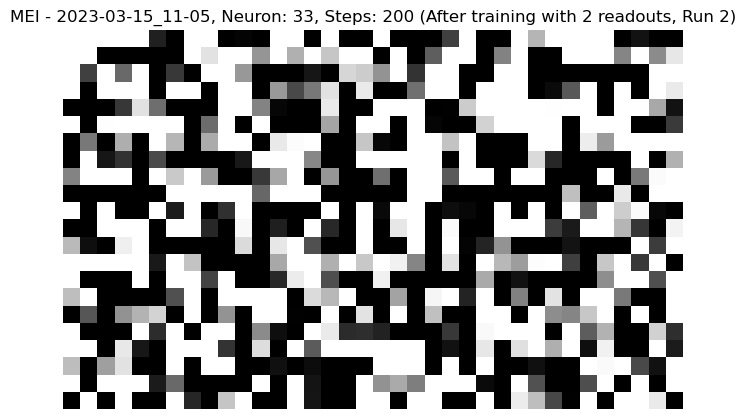

  Generating MEI 35/373: Neuron 34


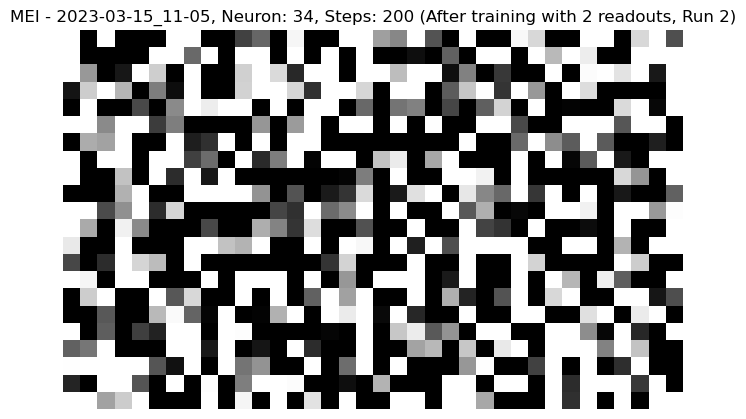

  Generating MEI 36/373: Neuron 35


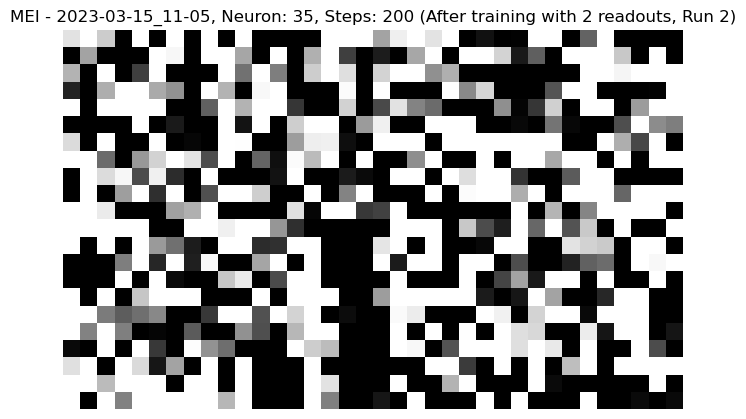

  Generating MEI 37/373: Neuron 36


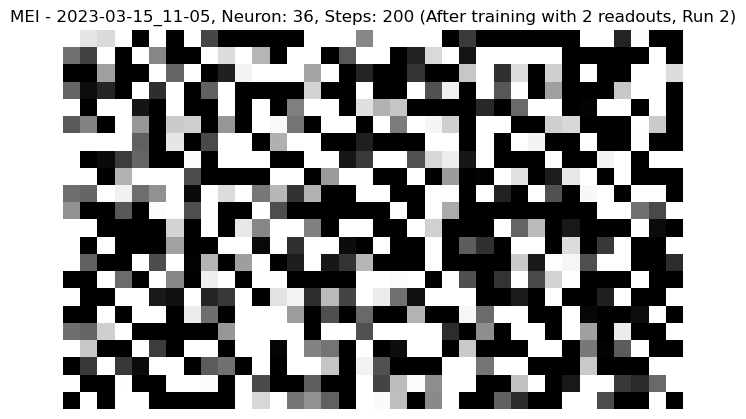

  Generating MEI 38/373: Neuron 37


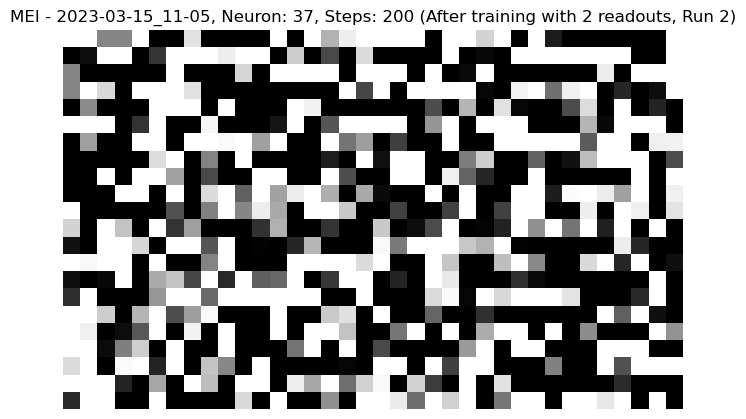

  Generating MEI 39/373: Neuron 38


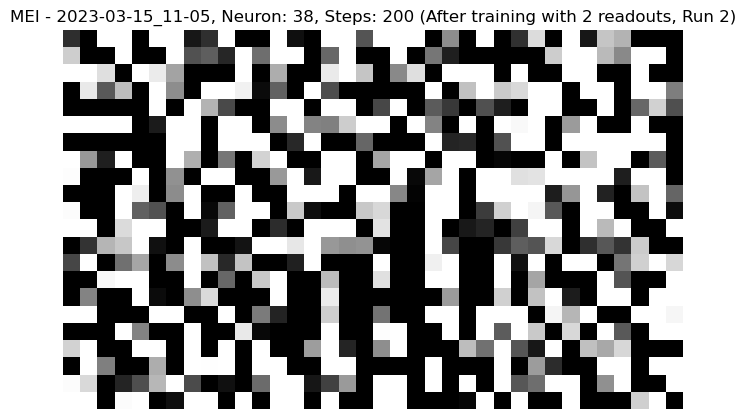

  Generating MEI 40/373: Neuron 39


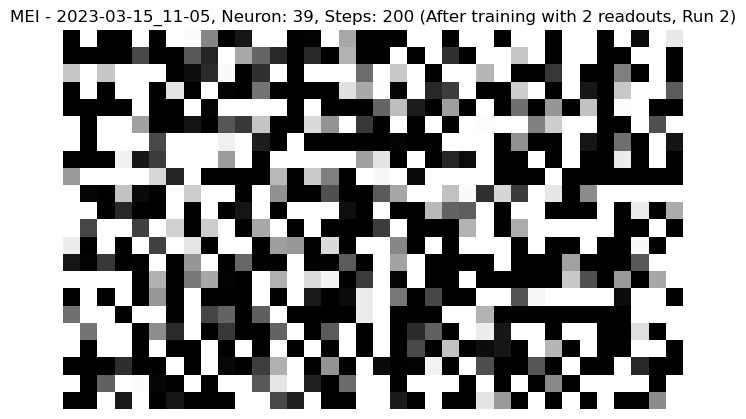

  Generating MEI 41/373: Neuron 40


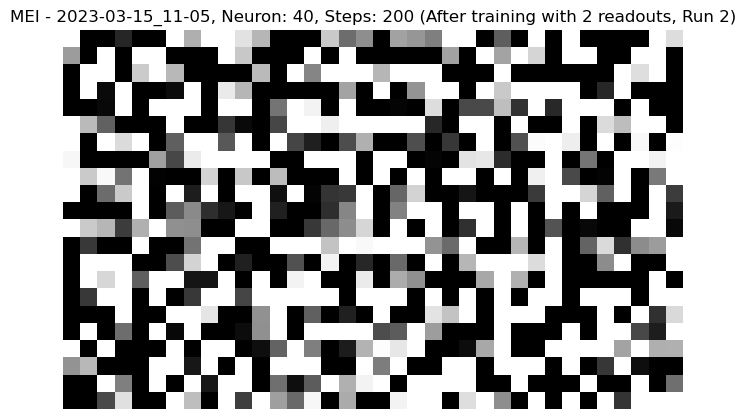

  Generating MEI 42/373: Neuron 41


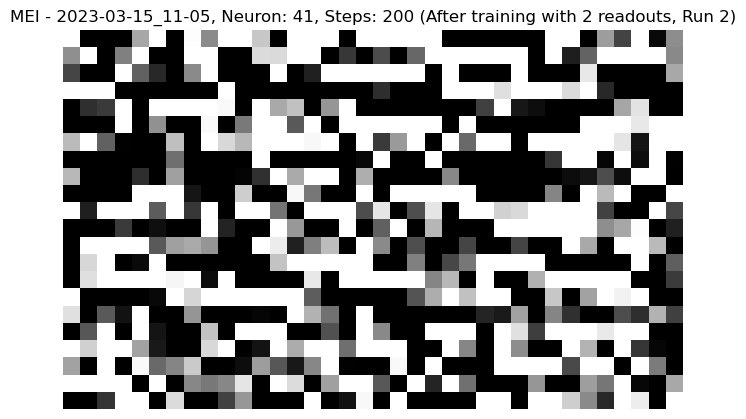

  Generating MEI 43/373: Neuron 42


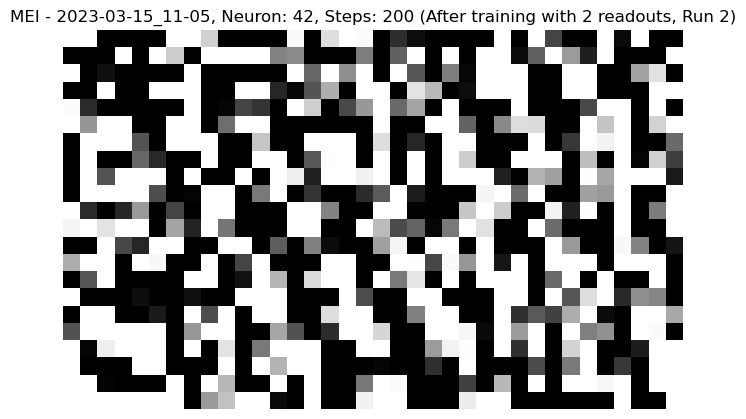

  Generating MEI 44/373: Neuron 43


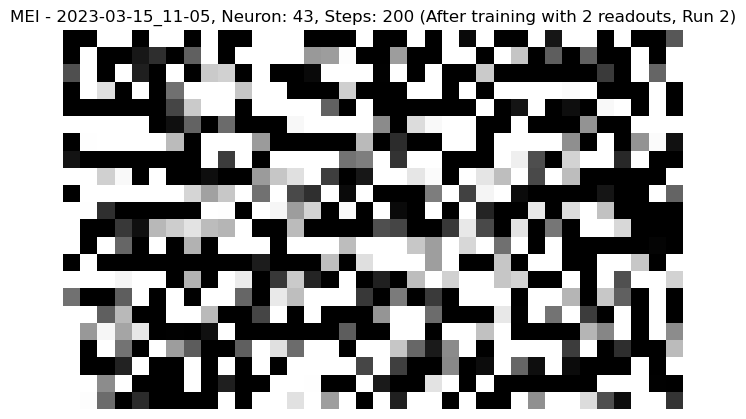

  Generating MEI 45/373: Neuron 44


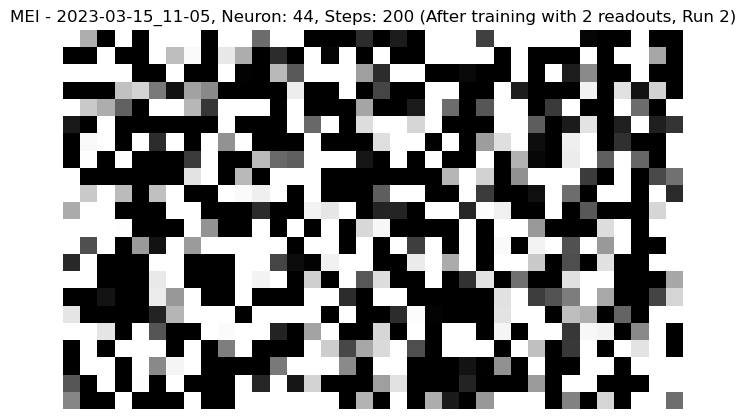

  Generating MEI 46/373: Neuron 45


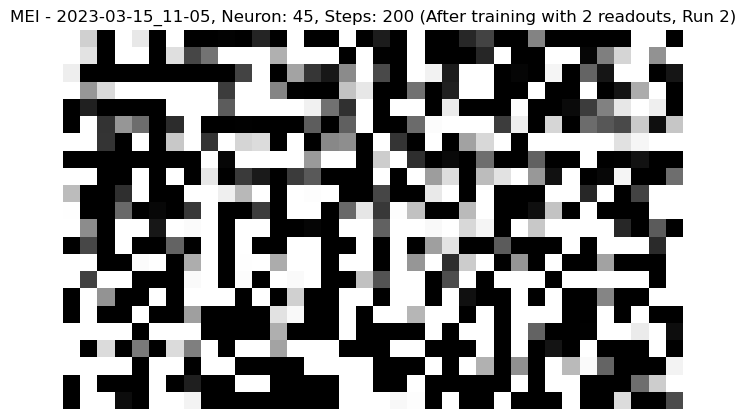

  Generating MEI 47/373: Neuron 46


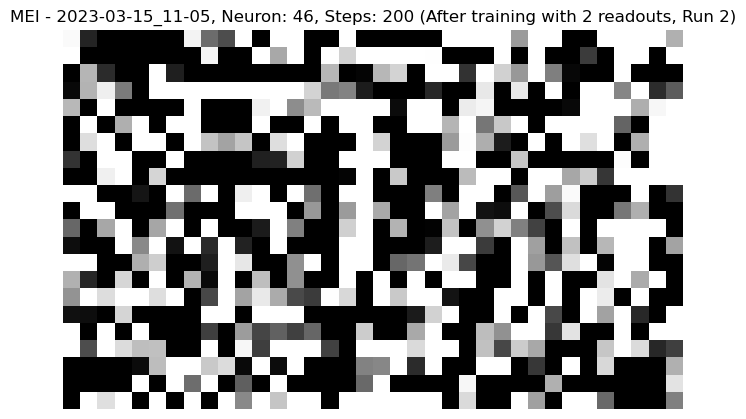

  Generating MEI 48/373: Neuron 47


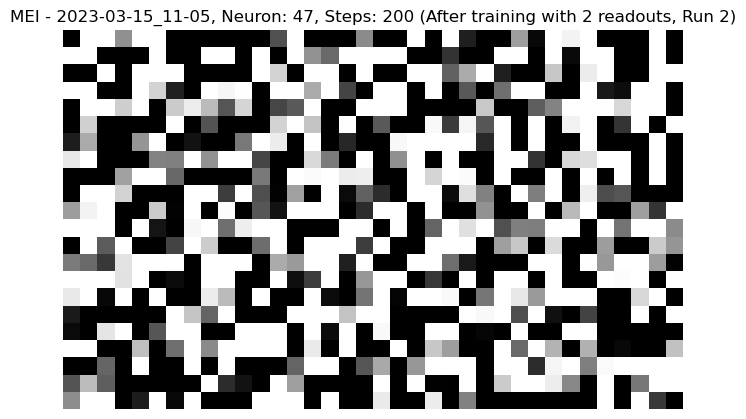

  Generating MEI 49/373: Neuron 48


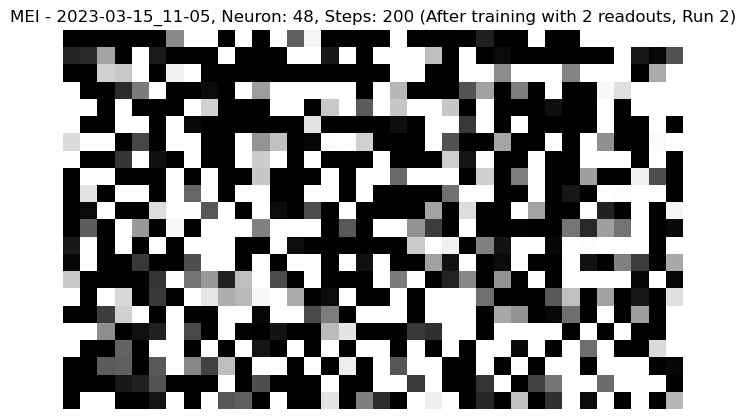

  Generating MEI 50/373: Neuron 49


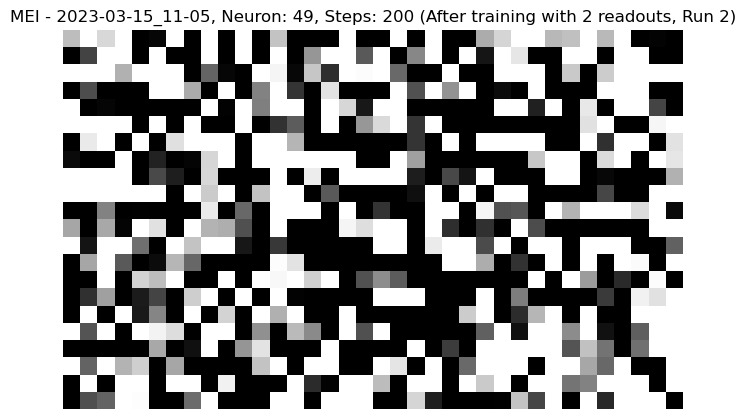

  Generating MEI 51/373: Neuron 50


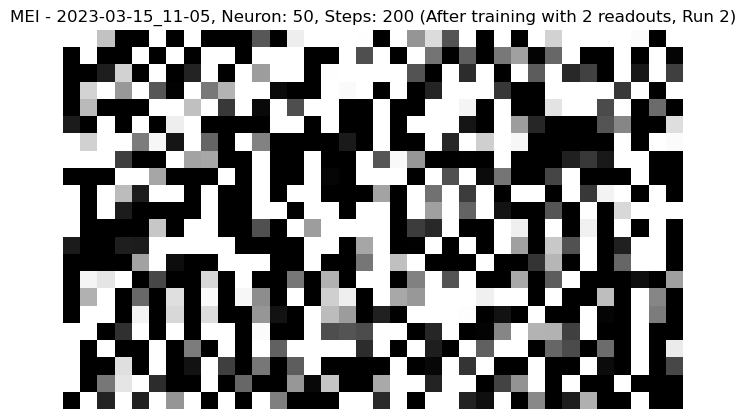

  Generating MEI 52/373: Neuron 51


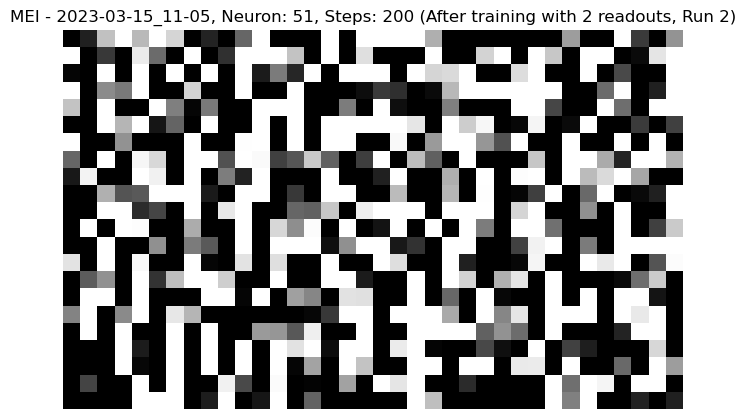

  Generating MEI 53/373: Neuron 52


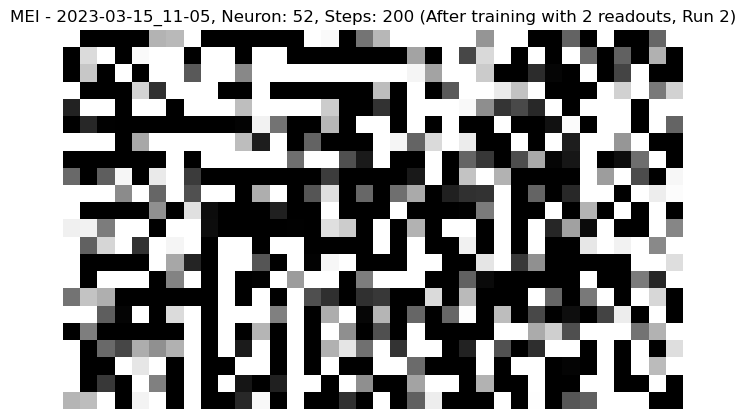

  Generating MEI 54/373: Neuron 53


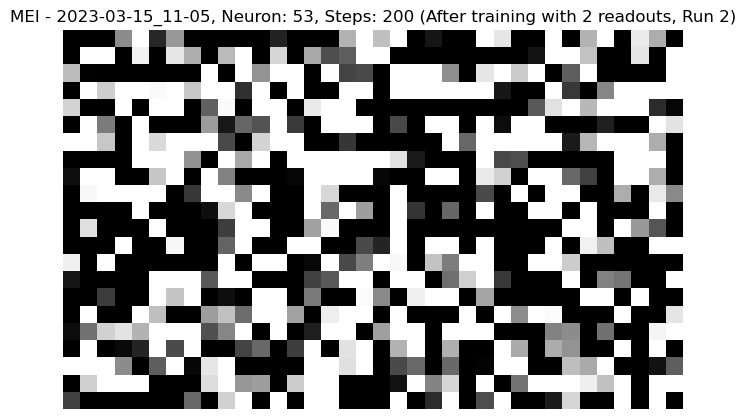

  Generating MEI 55/373: Neuron 54


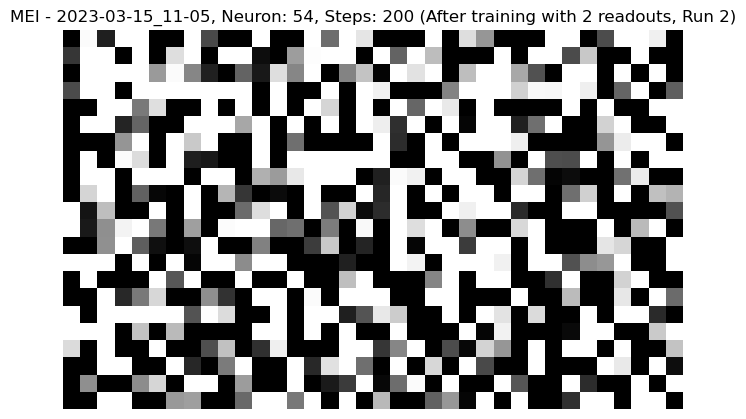

  Generating MEI 56/373: Neuron 55


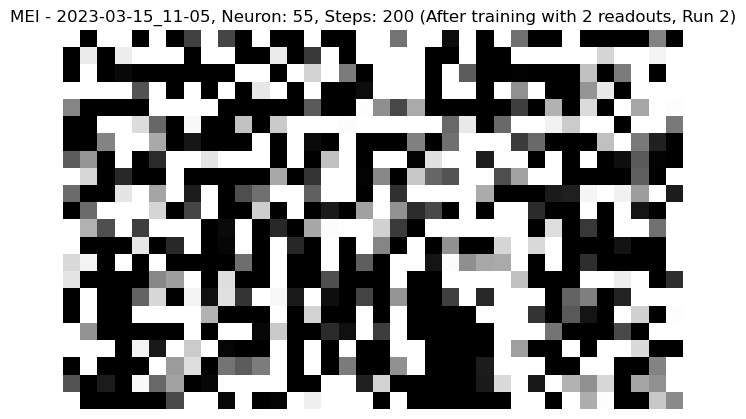

  Generating MEI 57/373: Neuron 56


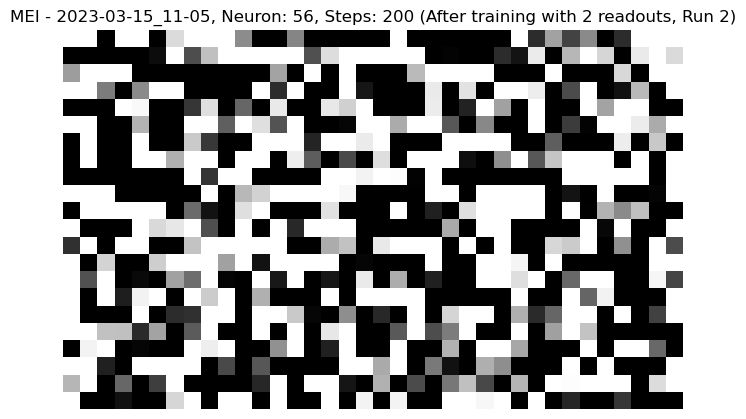

  Generating MEI 58/373: Neuron 57


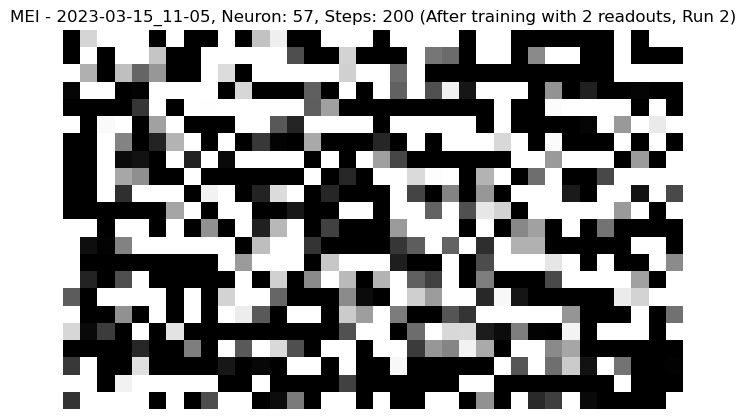

  Generating MEI 59/373: Neuron 58


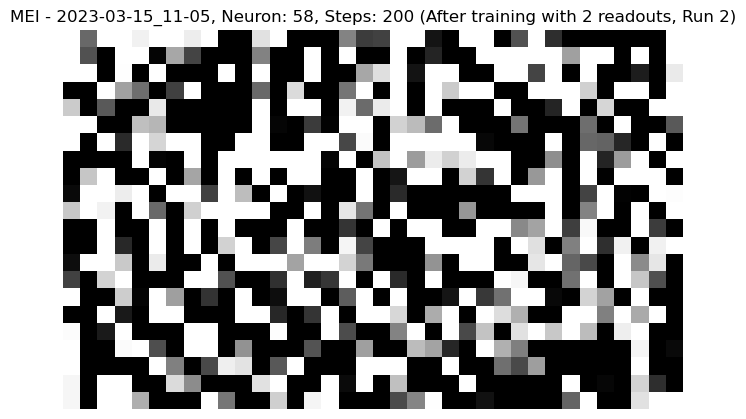

  Generating MEI 60/373: Neuron 59


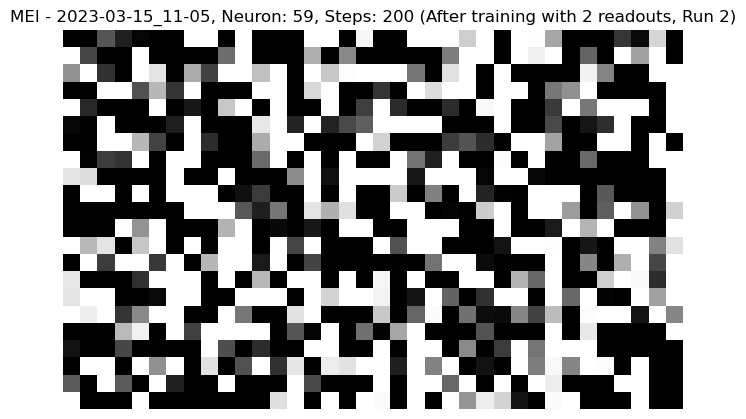

  Generating MEI 61/373: Neuron 60


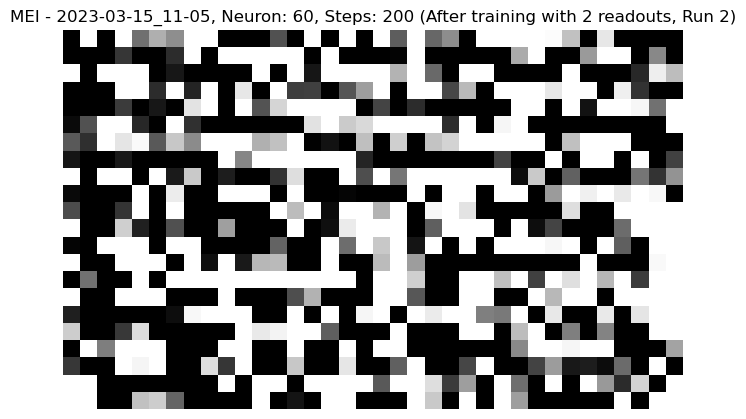

  Generating MEI 62/373: Neuron 61


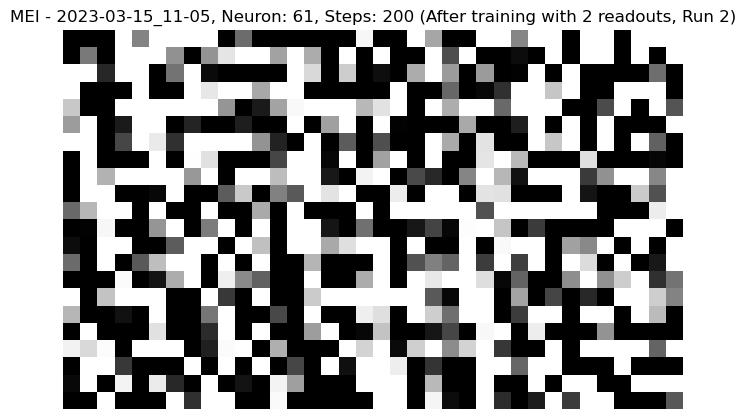

  Generating MEI 63/373: Neuron 62


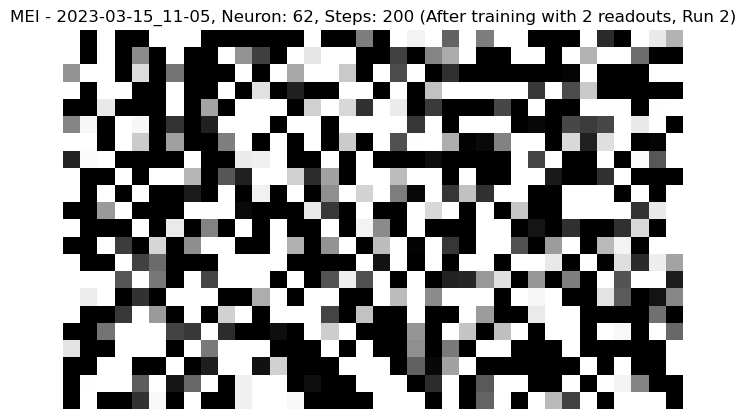

  Generating MEI 64/373: Neuron 63


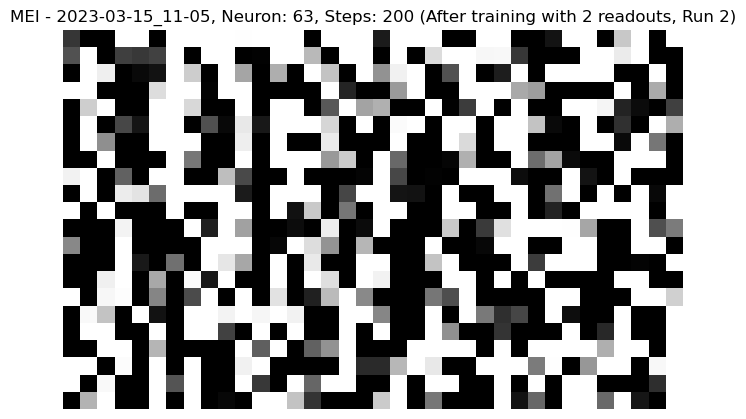

  Generating MEI 65/373: Neuron 64


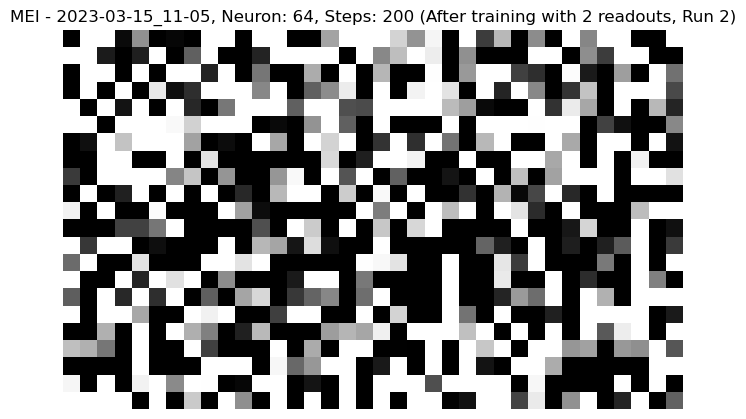

  Generating MEI 66/373: Neuron 65


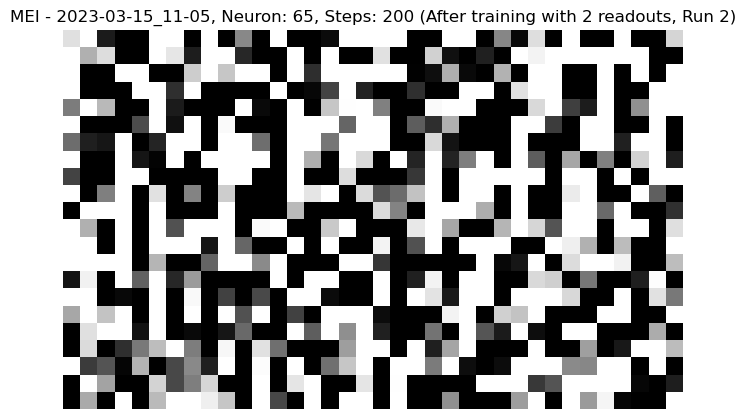

  Generating MEI 67/373: Neuron 66


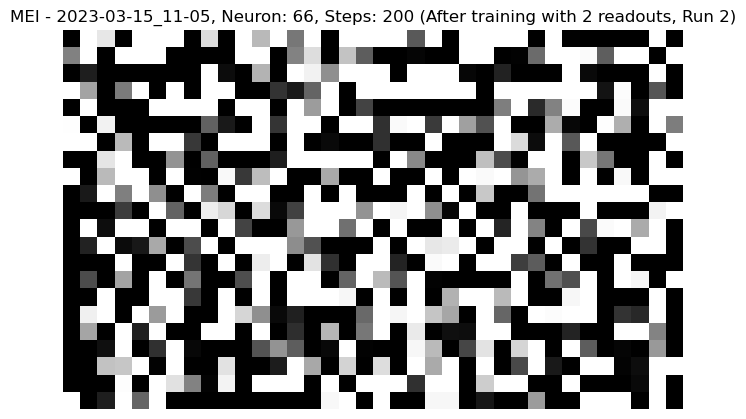

  Generating MEI 68/373: Neuron 67


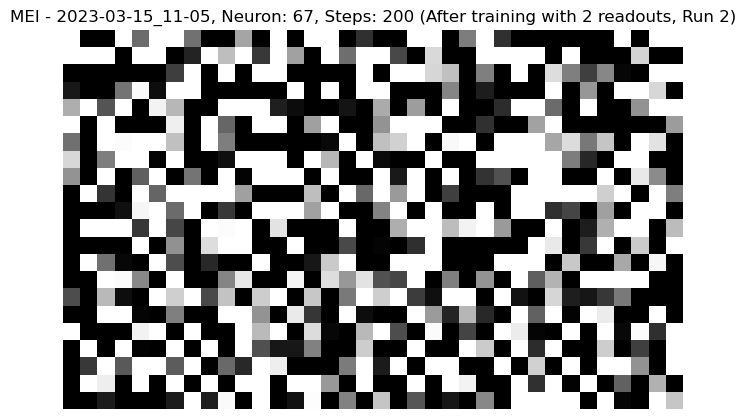

  Generating MEI 69/373: Neuron 68


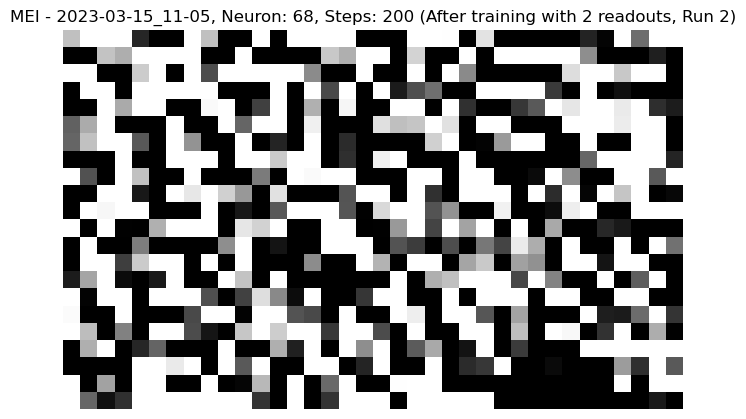

  Generating MEI 70/373: Neuron 69


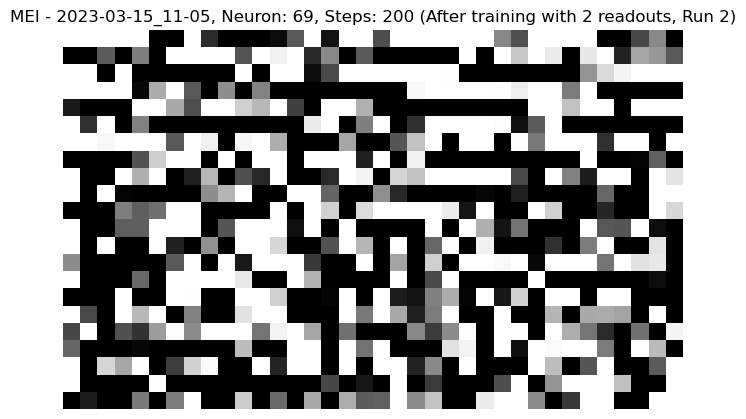

  Generating MEI 71/373: Neuron 70


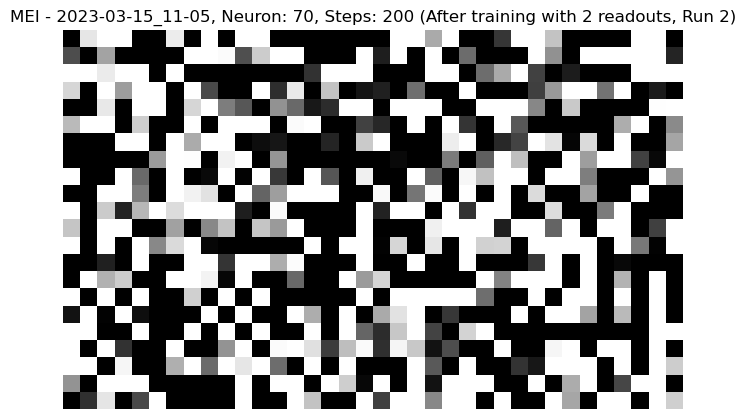

  Generating MEI 72/373: Neuron 71


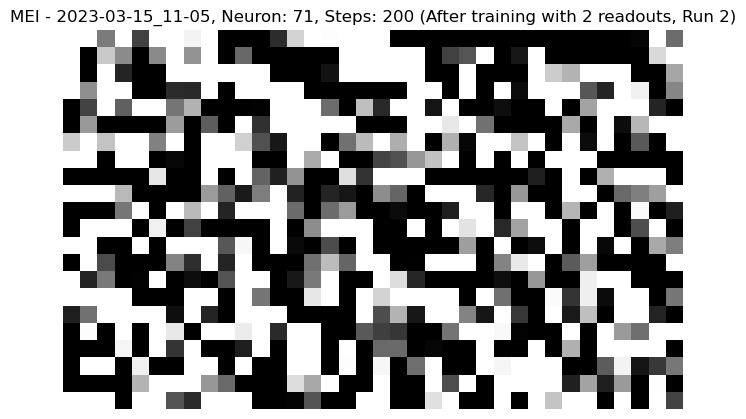

  Generating MEI 73/373: Neuron 72


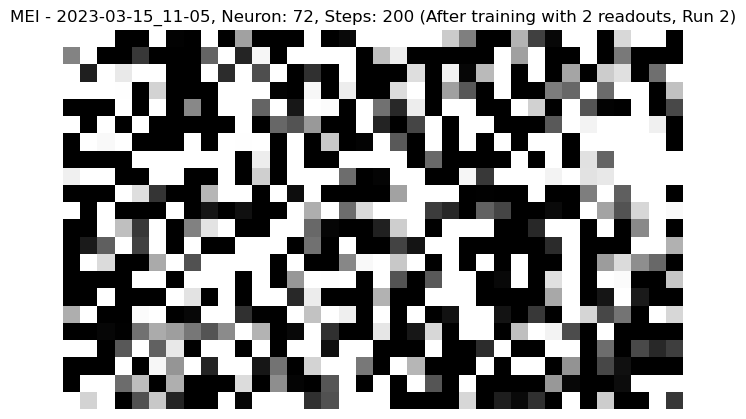

  Generating MEI 74/373: Neuron 73


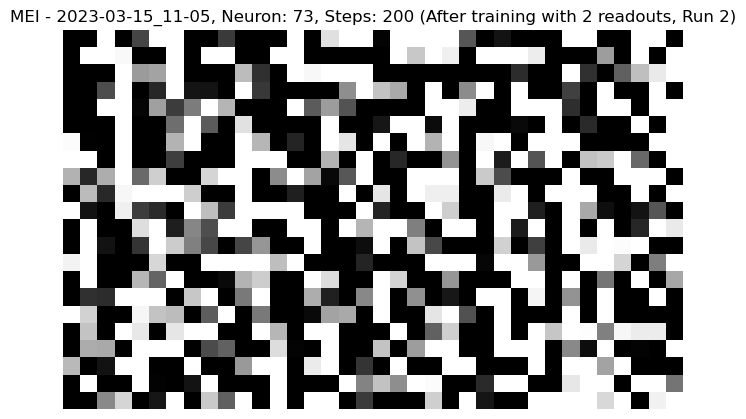

  Generating MEI 75/373: Neuron 74


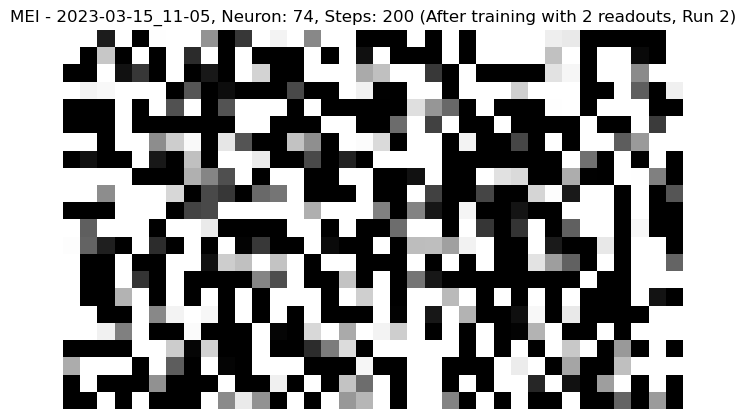

  Generating MEI 76/373: Neuron 75


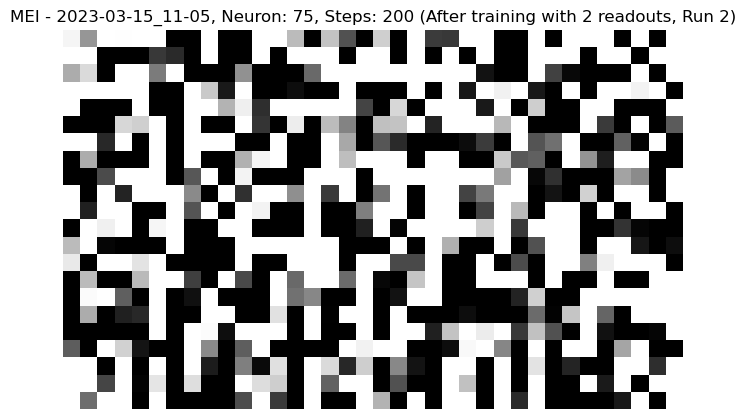

  Generating MEI 77/373: Neuron 76


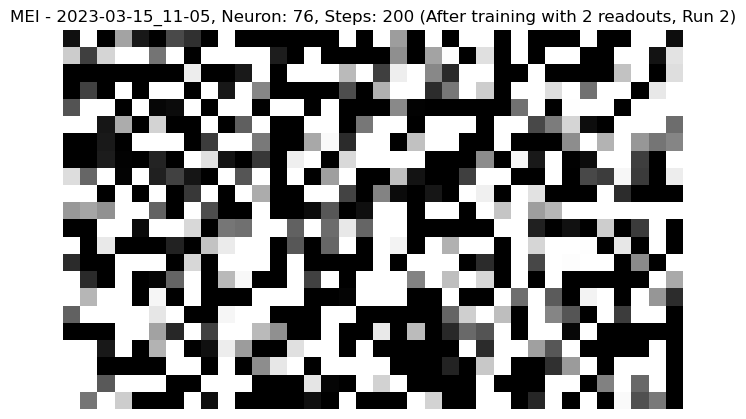

  Generating MEI 78/373: Neuron 77


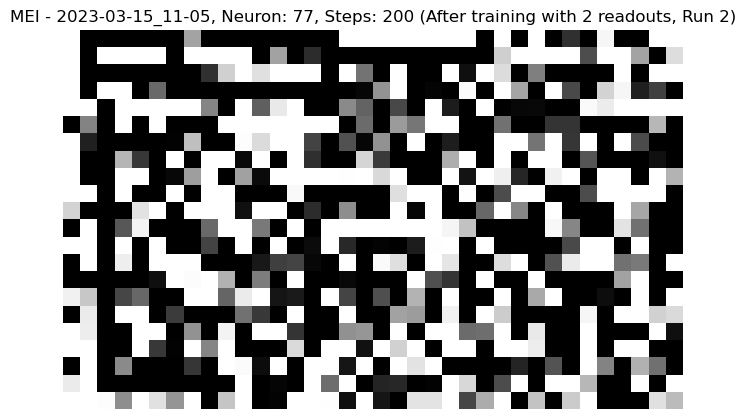

  Generating MEI 79/373: Neuron 78


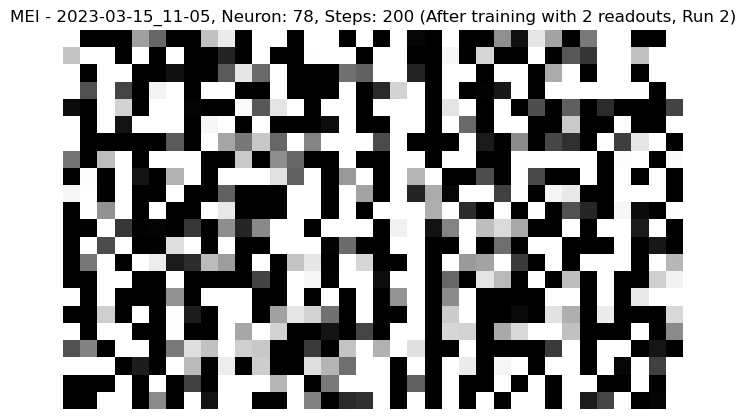

  Generating MEI 80/373: Neuron 79


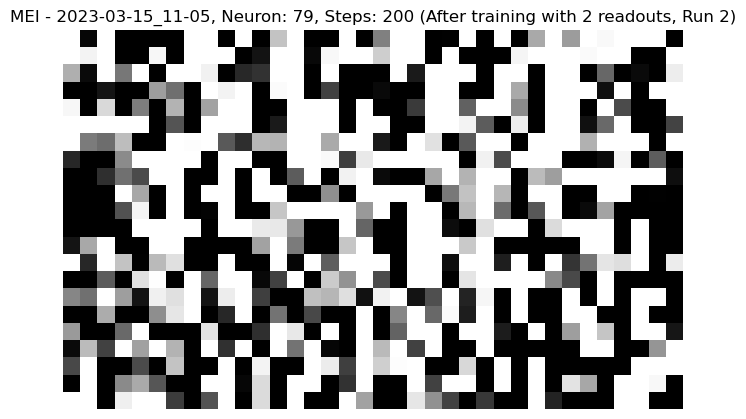

  Generating MEI 81/373: Neuron 80


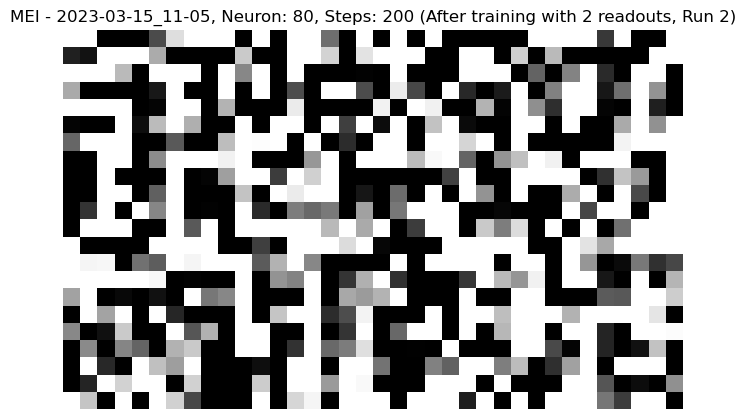

  Generating MEI 82/373: Neuron 81


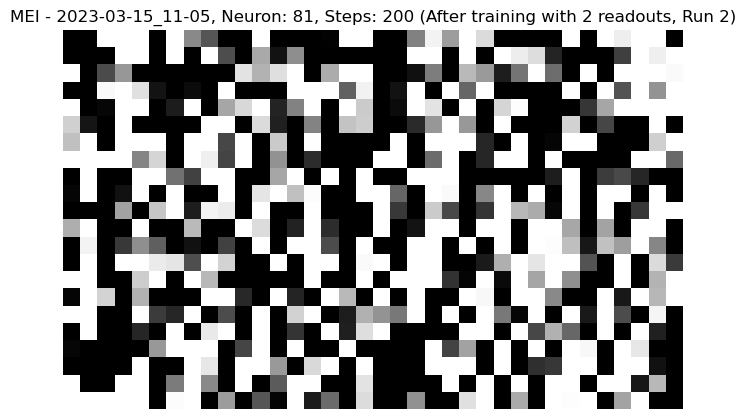

  Generating MEI 83/373: Neuron 82


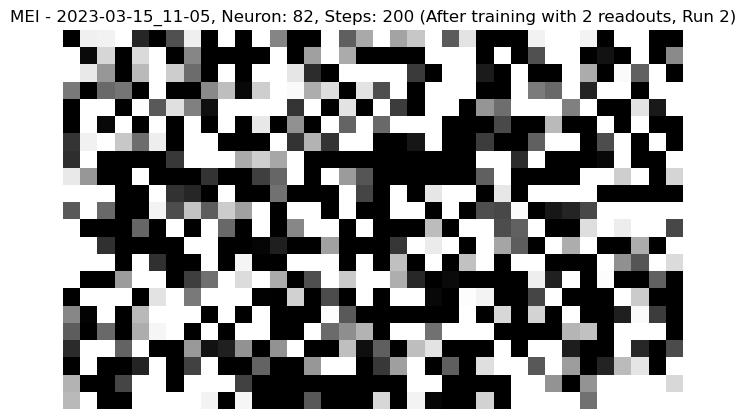

  Generating MEI 84/373: Neuron 83


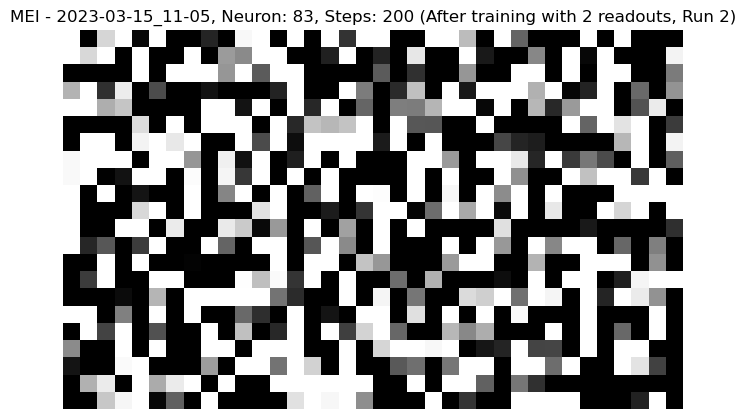

  Generating MEI 85/373: Neuron 84


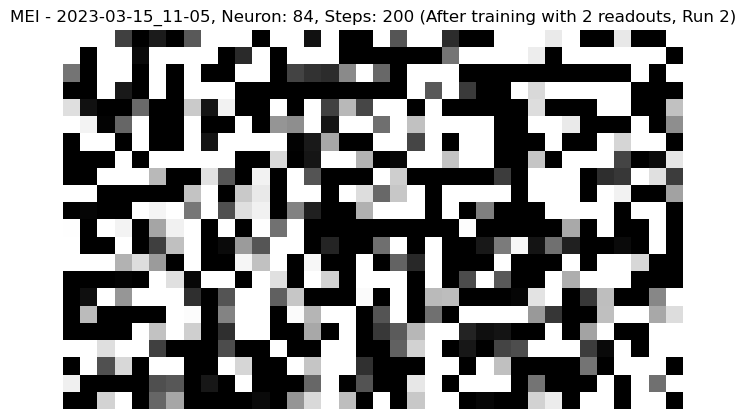

  Generating MEI 86/373: Neuron 85


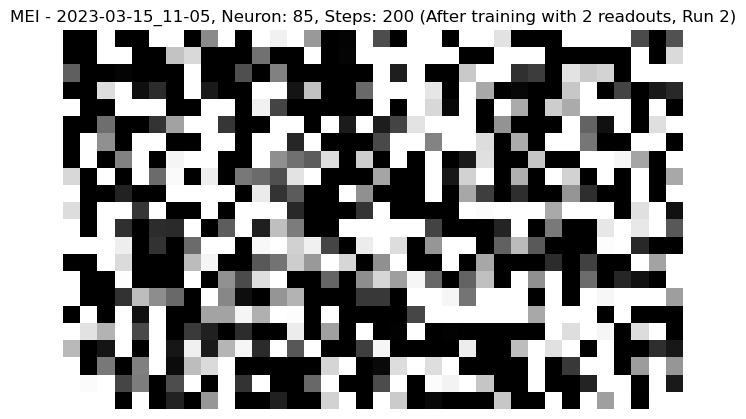

  Generating MEI 87/373: Neuron 86


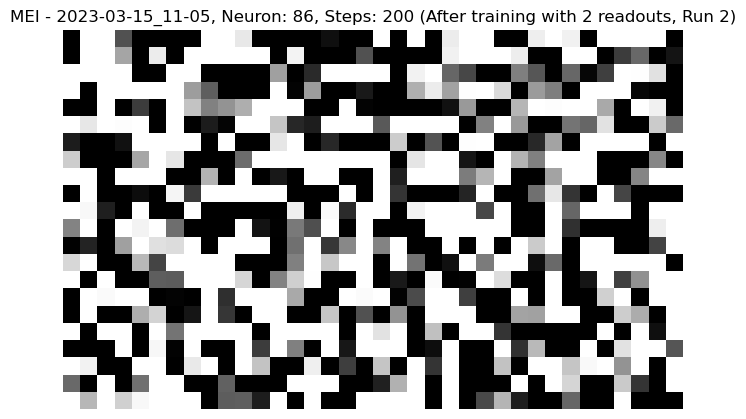

  Generating MEI 88/373: Neuron 87


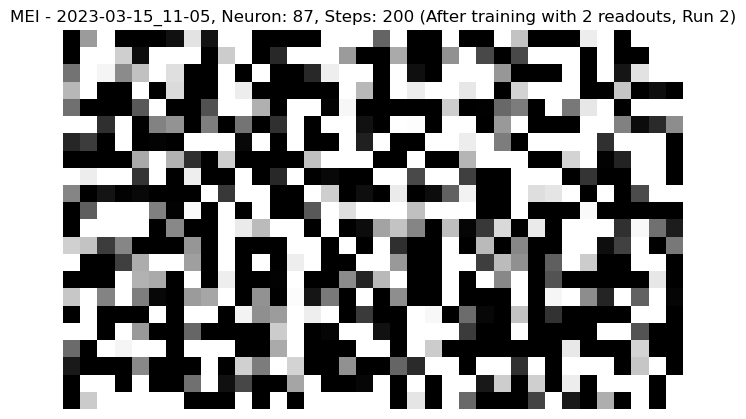

  Generating MEI 89/373: Neuron 88


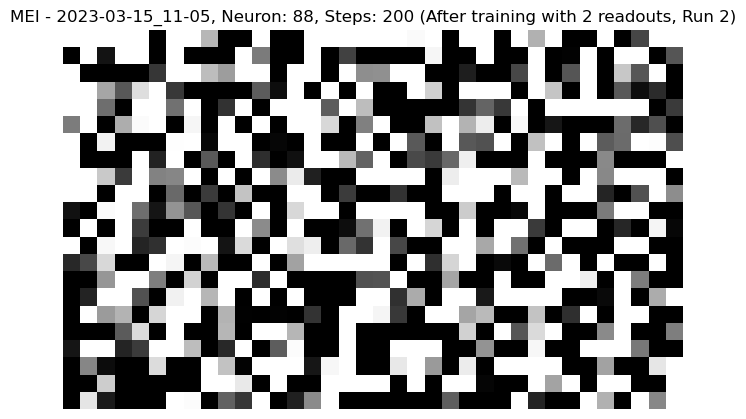

  Generating MEI 90/373: Neuron 89


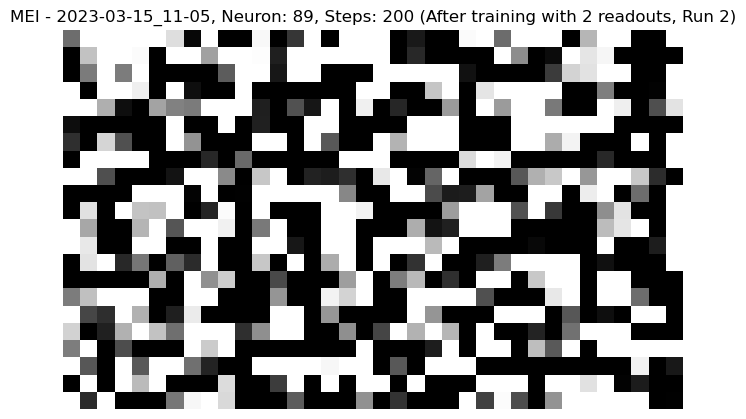

  Generating MEI 91/373: Neuron 90


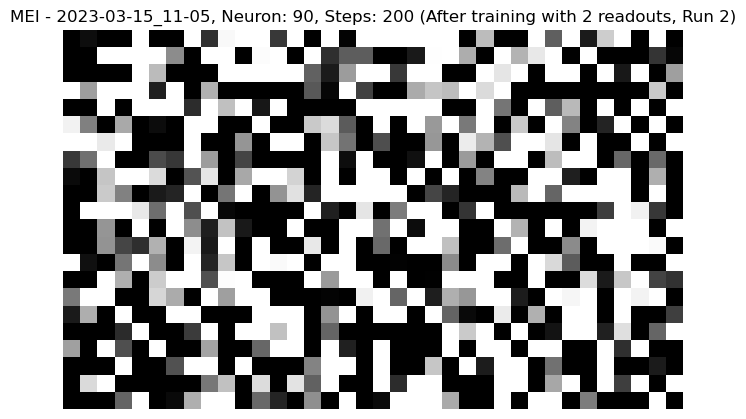

  Generating MEI 92/373: Neuron 91


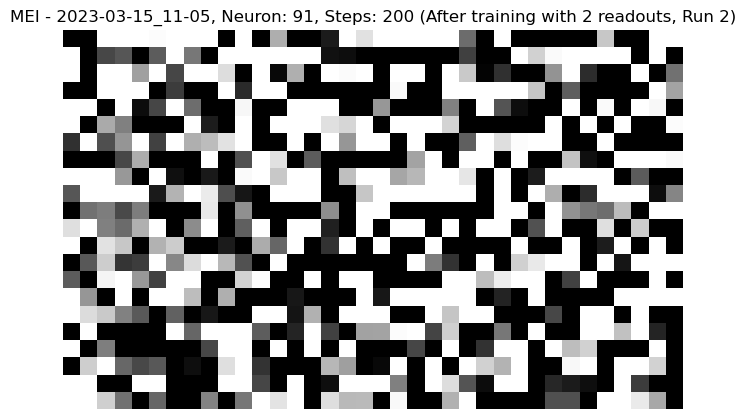

  Generating MEI 93/373: Neuron 92


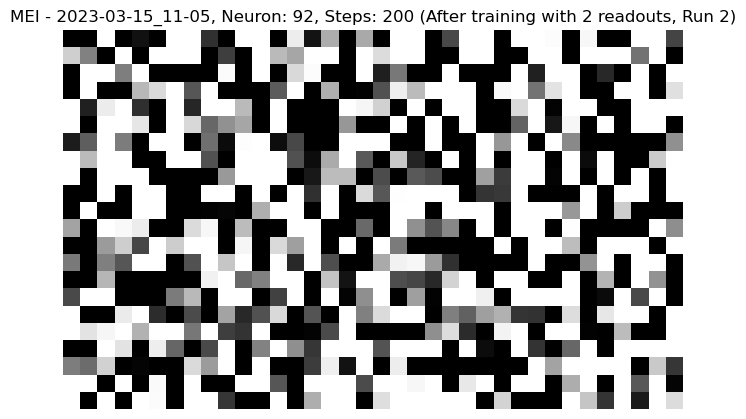

  Generating MEI 94/373: Neuron 93


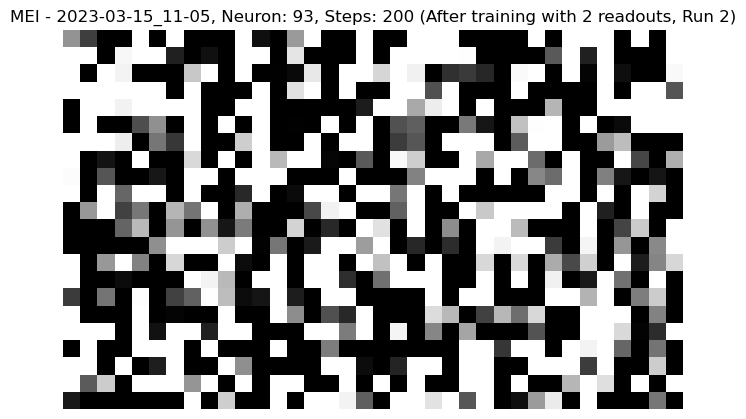

  Generating MEI 95/373: Neuron 94


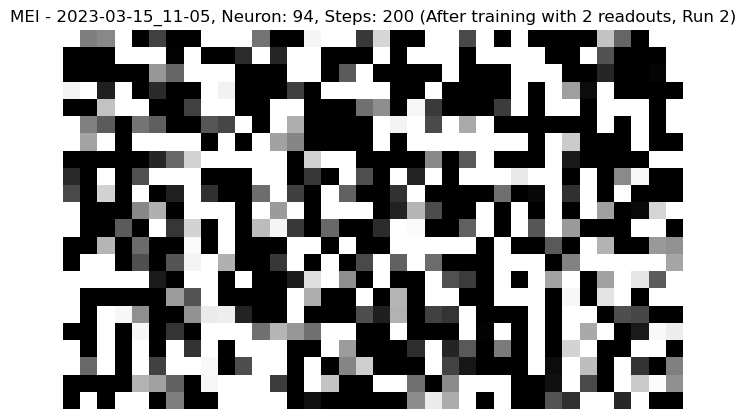

  Generating MEI 96/373: Neuron 95


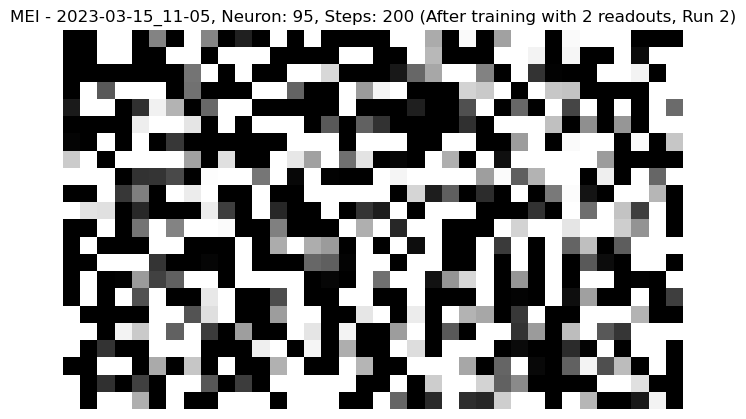

  Generating MEI 97/373: Neuron 96


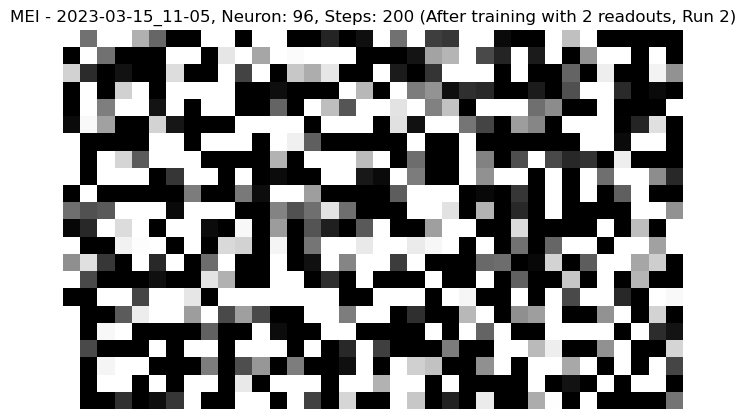

  Generating MEI 98/373: Neuron 97


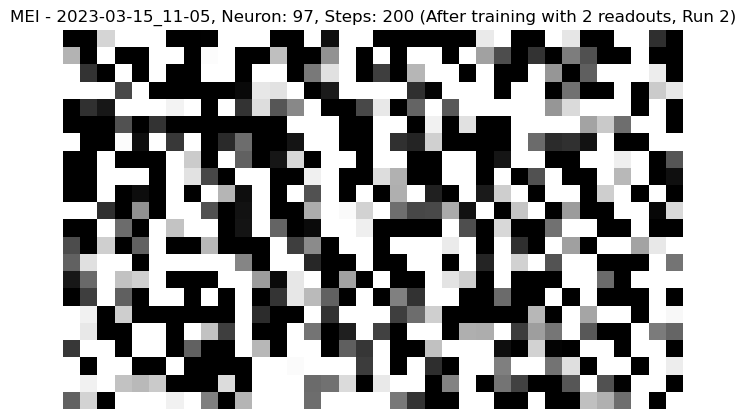

  Generating MEI 99/373: Neuron 98


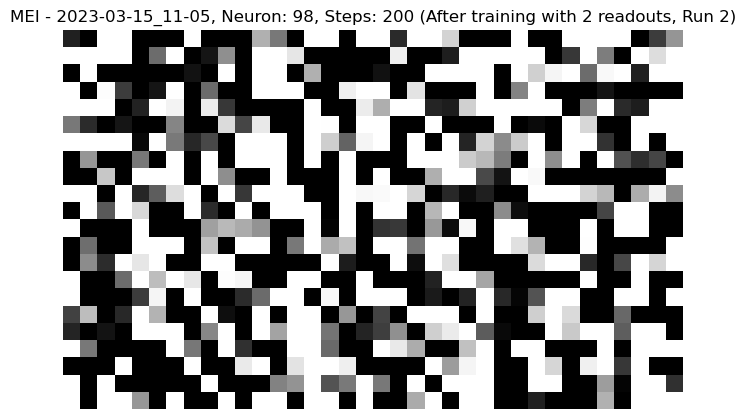

  Generating MEI 100/373: Neuron 99


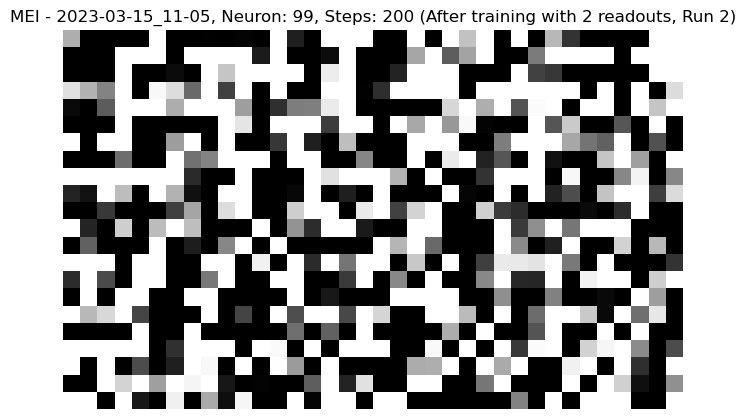

  Generating MEI 101/373: Neuron 100


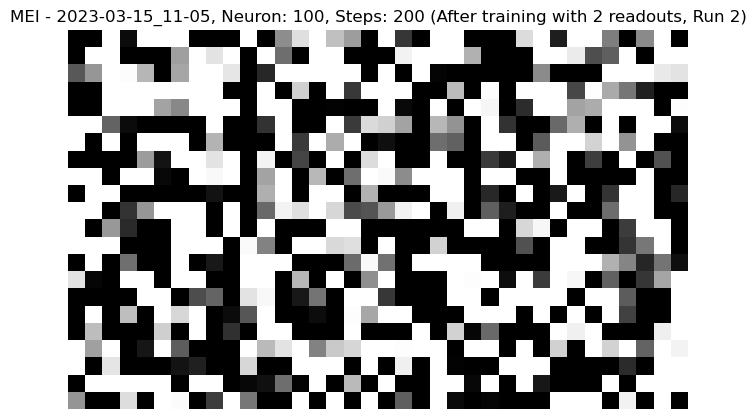

  Generating MEI 102/373: Neuron 101


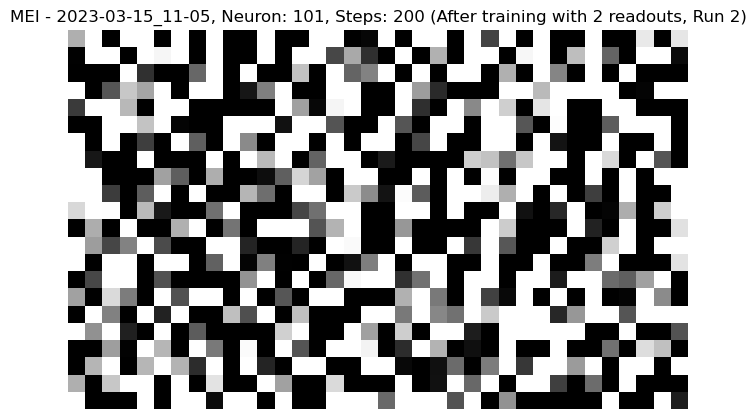

  Generating MEI 103/373: Neuron 102


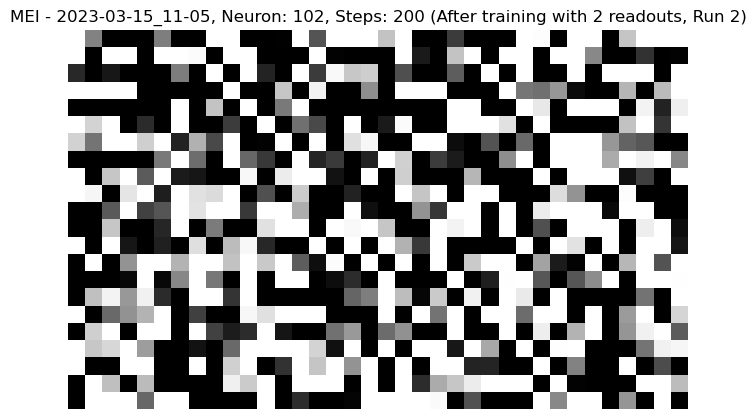

  Generating MEI 104/373: Neuron 103


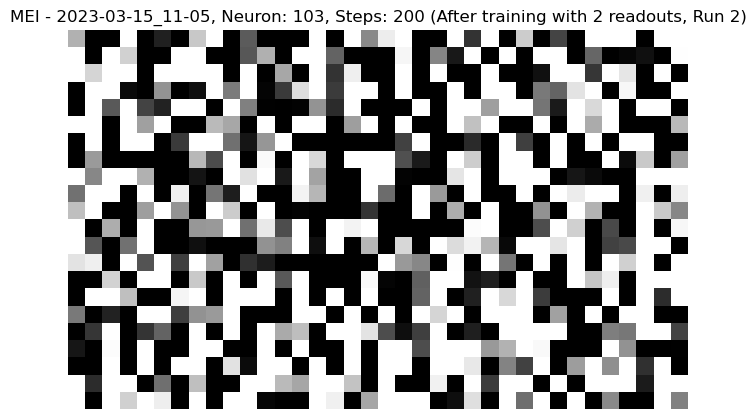

  Generating MEI 105/373: Neuron 104


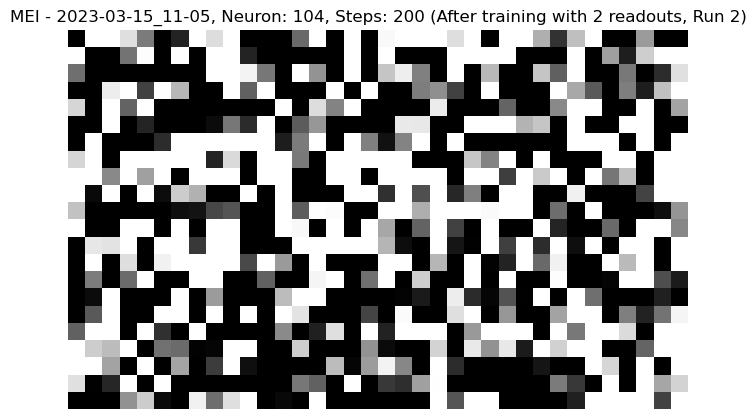

  Generating MEI 106/373: Neuron 105


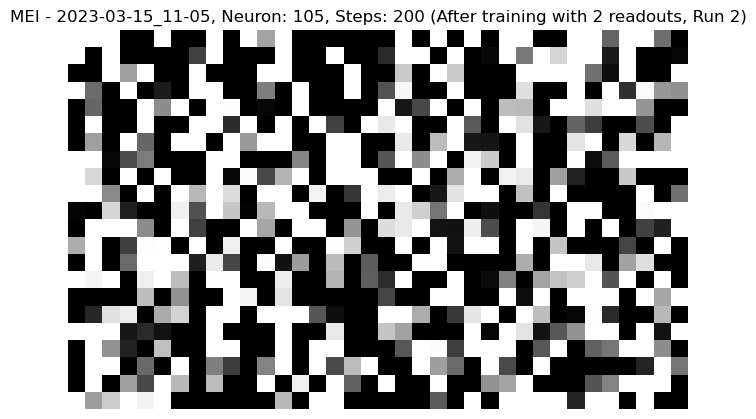

  Generating MEI 107/373: Neuron 106


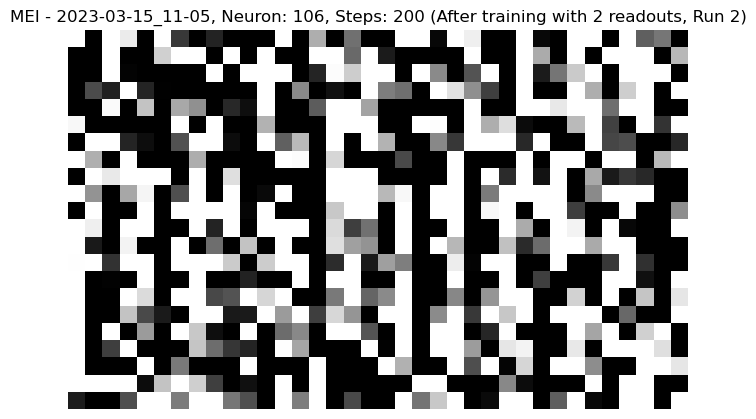

  Generating MEI 108/373: Neuron 107


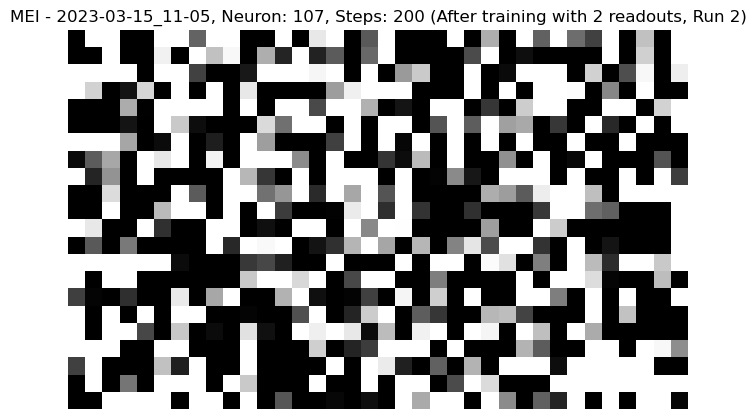

  Generating MEI 109/373: Neuron 108


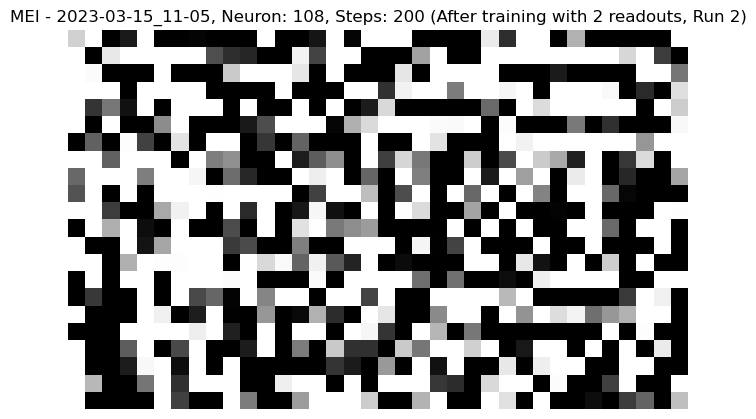

  Generating MEI 110/373: Neuron 109


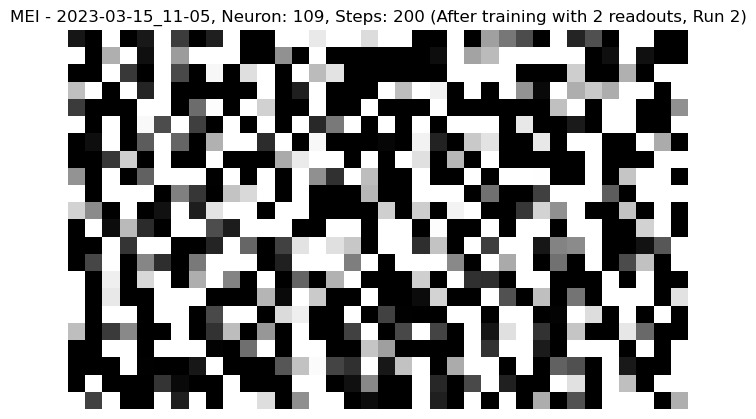

  Generating MEI 111/373: Neuron 110


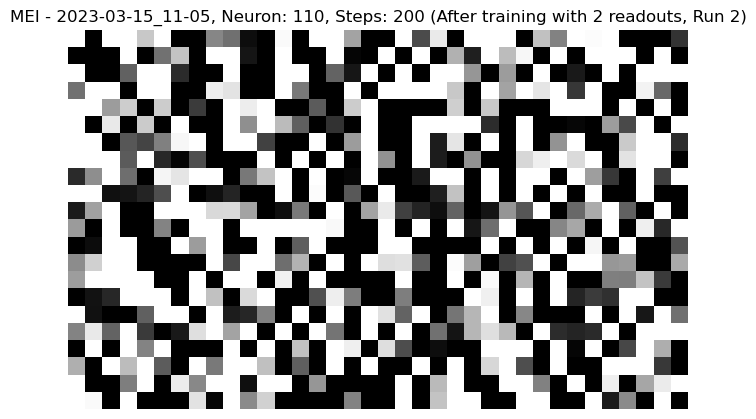

  Generating MEI 112/373: Neuron 111


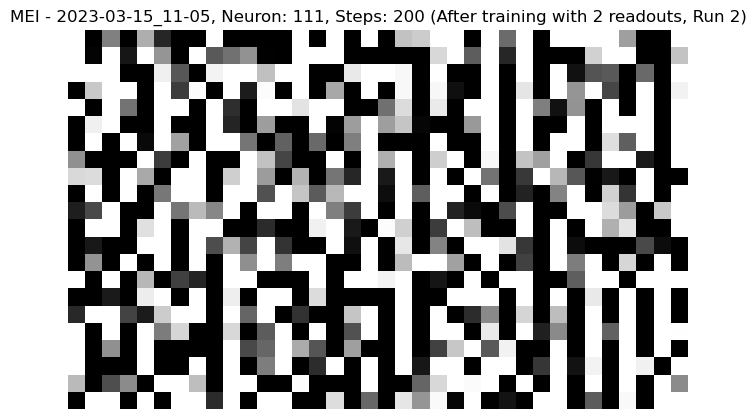

  Generating MEI 113/373: Neuron 112


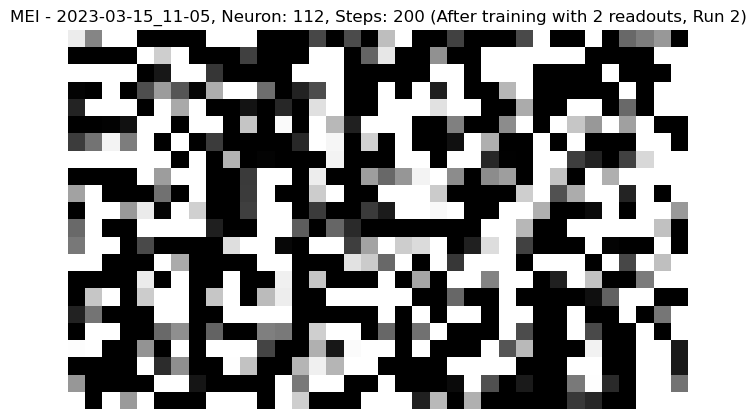

  Generating MEI 114/373: Neuron 113


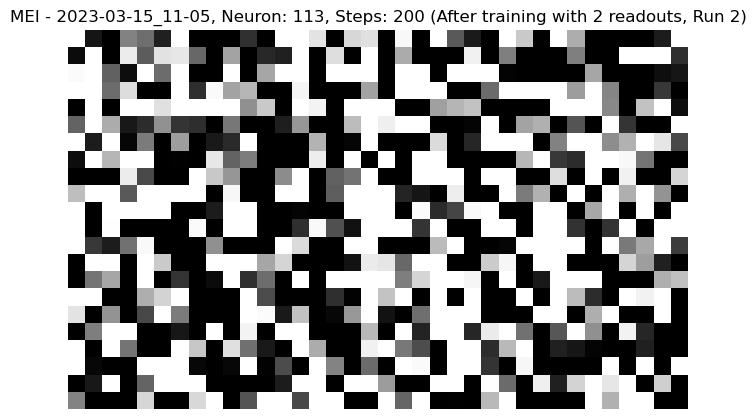

  Generating MEI 115/373: Neuron 114


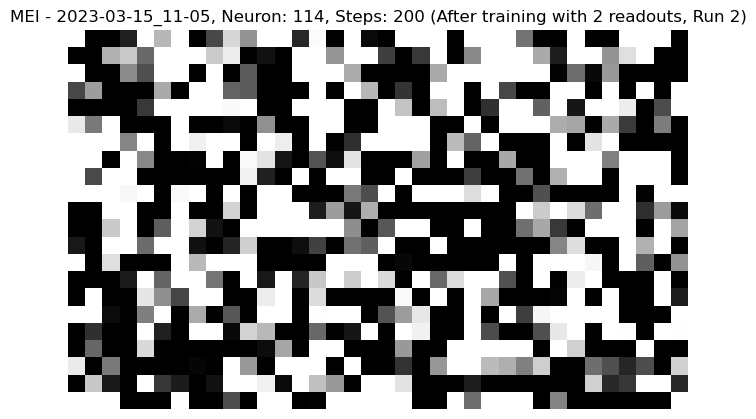

  Generating MEI 116/373: Neuron 115


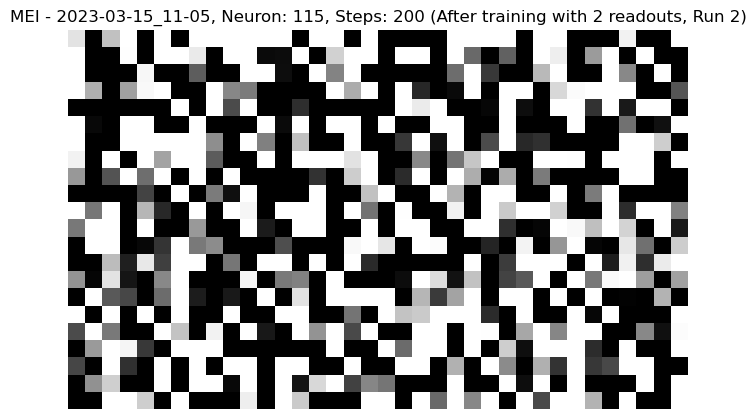

  Generating MEI 117/373: Neuron 116


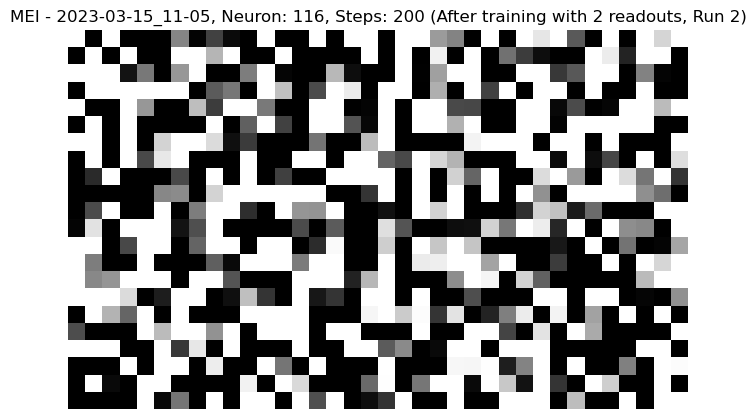

  Generating MEI 118/373: Neuron 117


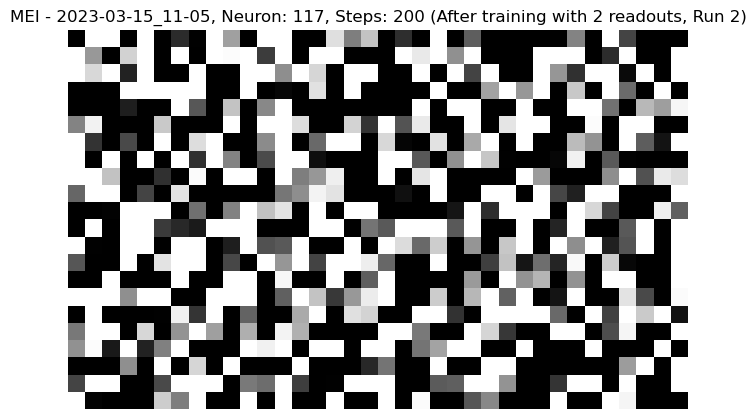

  Generating MEI 119/373: Neuron 118


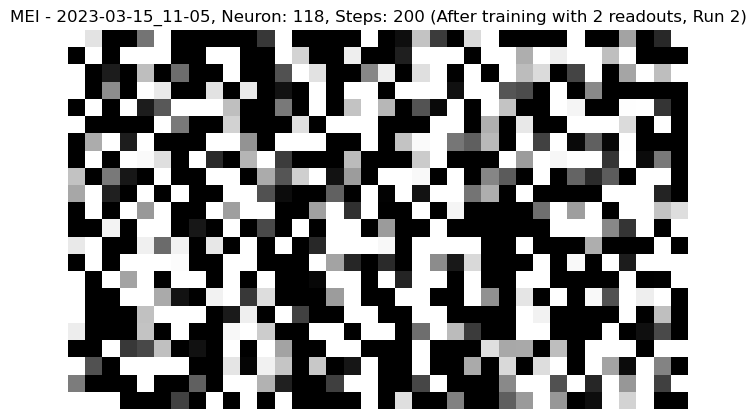

  Generating MEI 120/373: Neuron 119


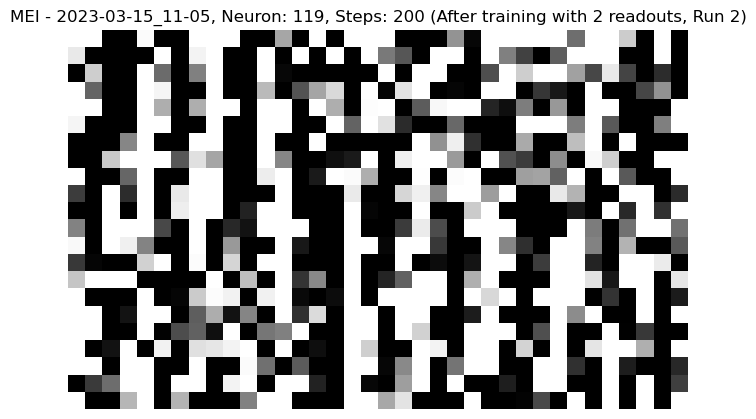

  Generating MEI 121/373: Neuron 120


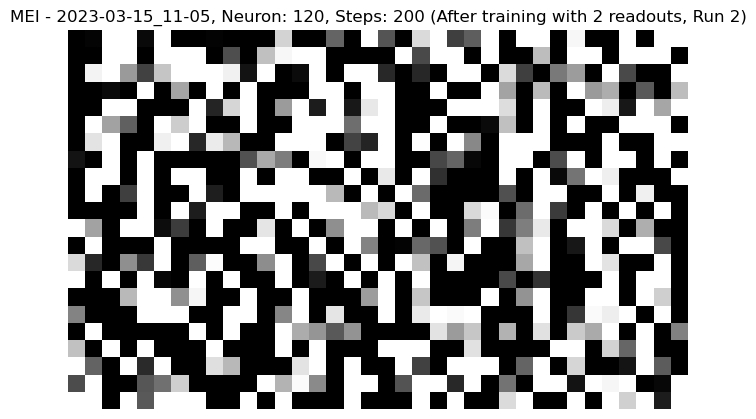

  Generating MEI 122/373: Neuron 121


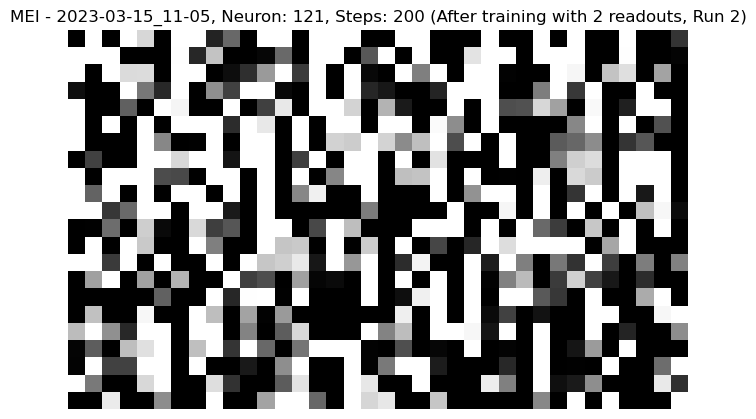

  Generating MEI 123/373: Neuron 122


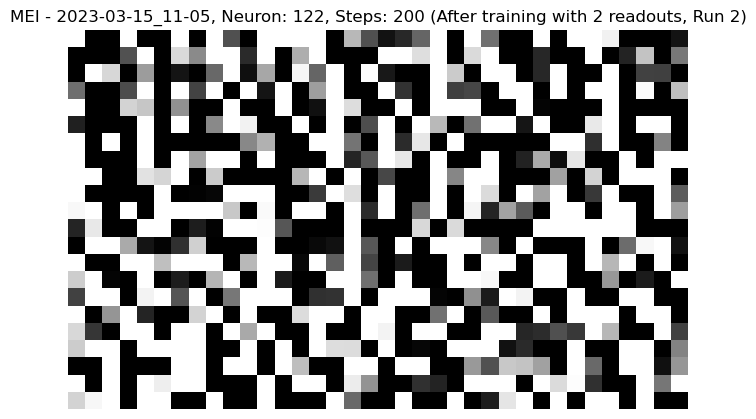

  Generating MEI 124/373: Neuron 123


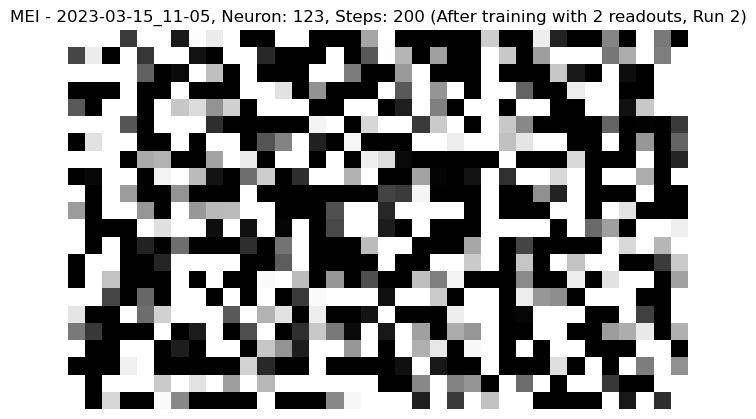

  Generating MEI 125/373: Neuron 124


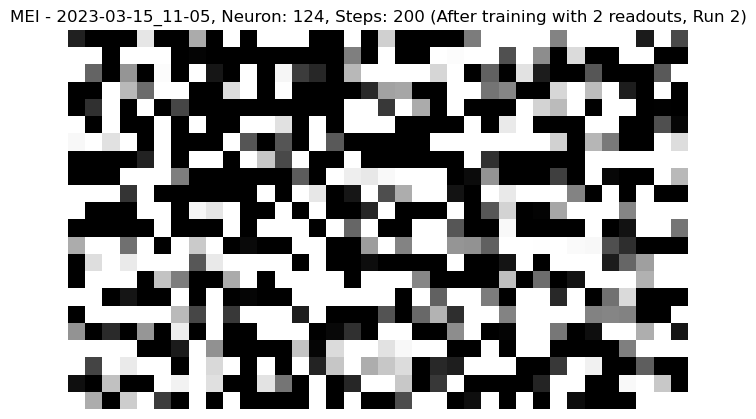

  Generating MEI 126/373: Neuron 125


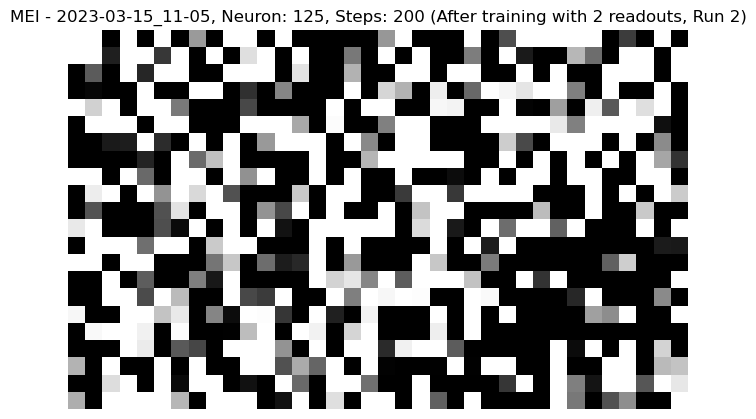

  Generating MEI 127/373: Neuron 126


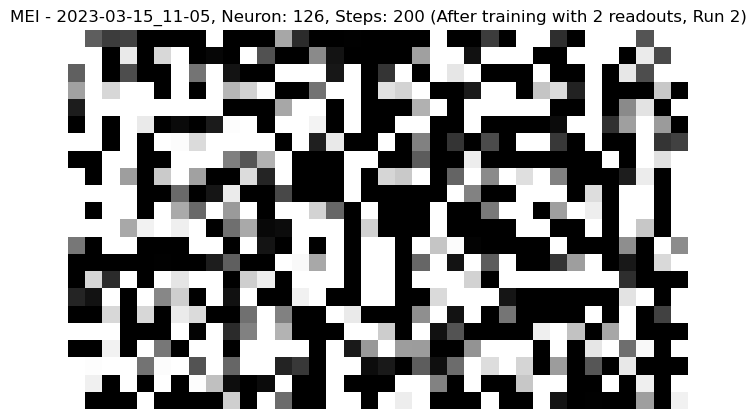

  Generating MEI 128/373: Neuron 127


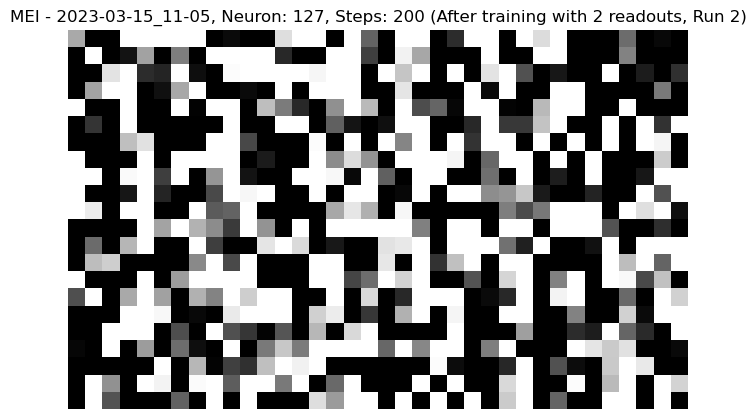

  Generating MEI 129/373: Neuron 128


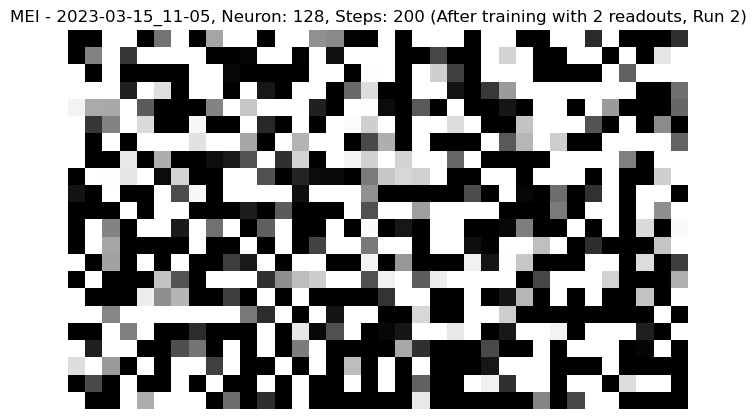

  Generating MEI 130/373: Neuron 129


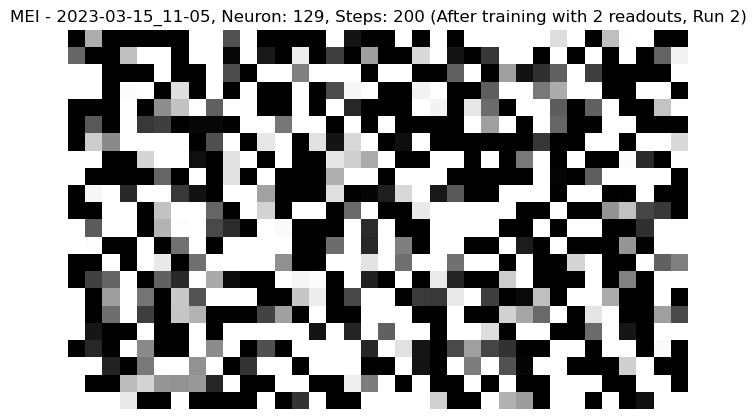

  Generating MEI 131/373: Neuron 130


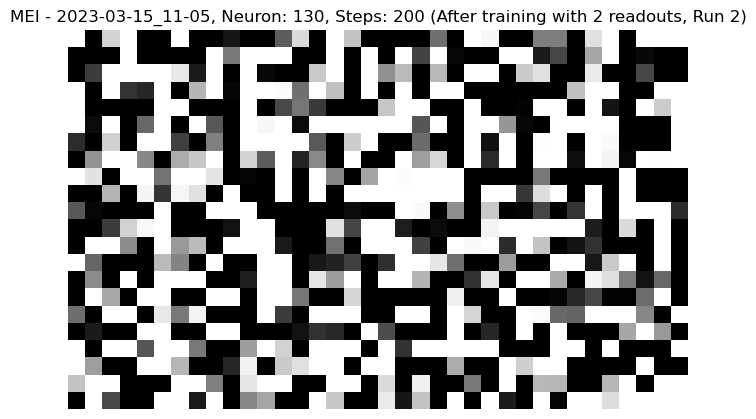

  Generating MEI 132/373: Neuron 131


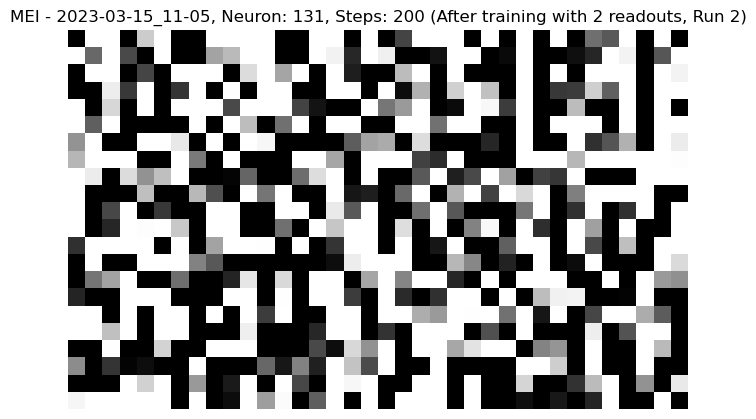

  Generating MEI 133/373: Neuron 132


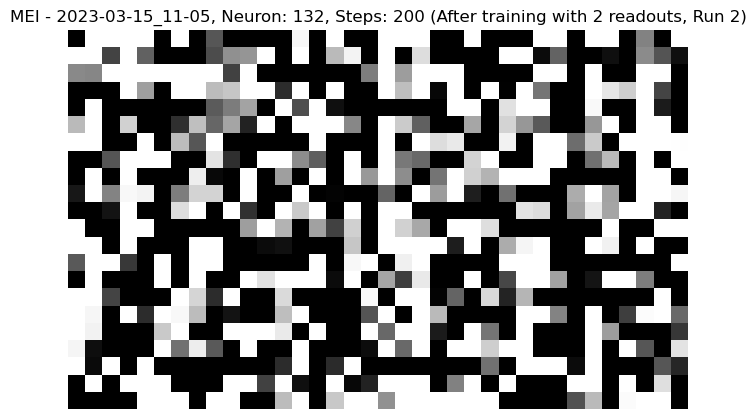

  Generating MEI 134/373: Neuron 133


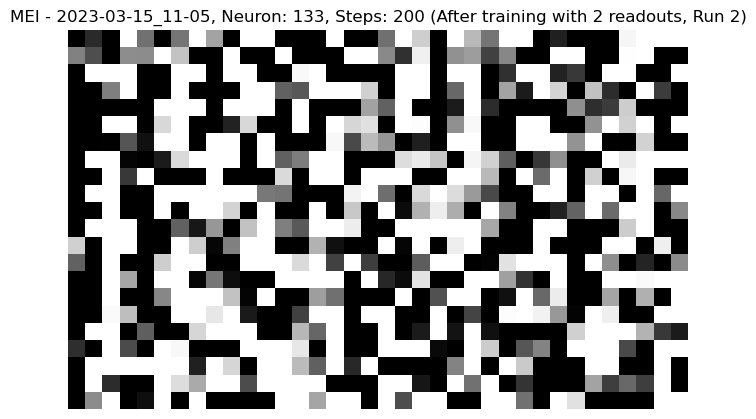

  Generating MEI 135/373: Neuron 134


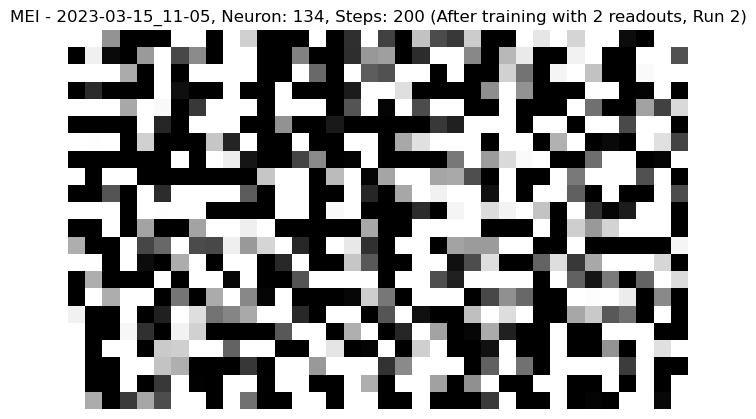

  Generating MEI 136/373: Neuron 135


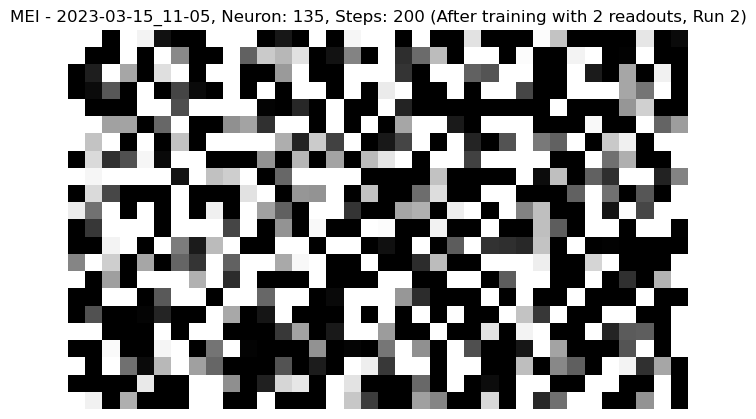

  Generating MEI 137/373: Neuron 136


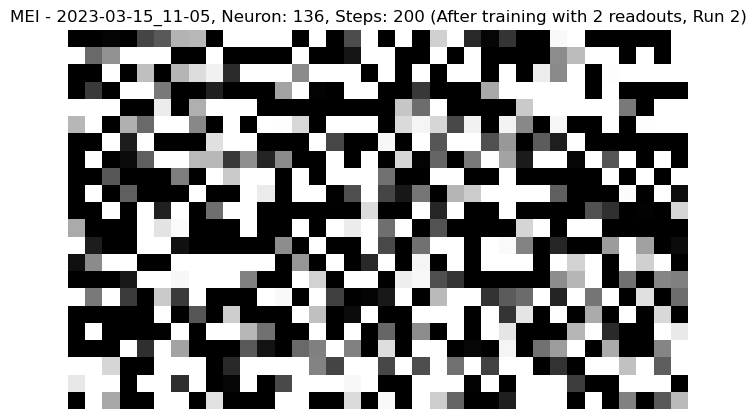

  Generating MEI 138/373: Neuron 137


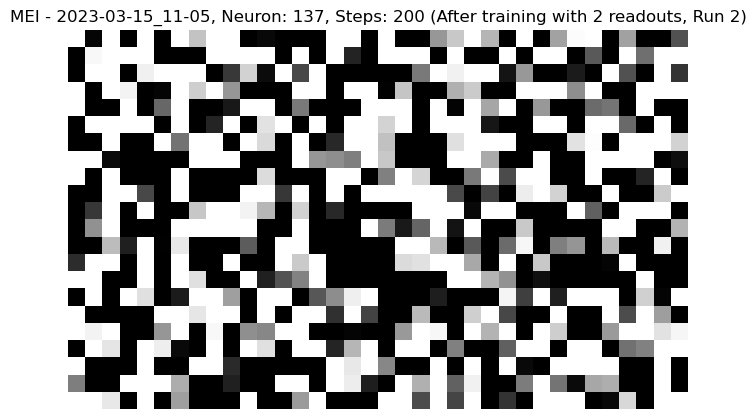

  Generating MEI 139/373: Neuron 138


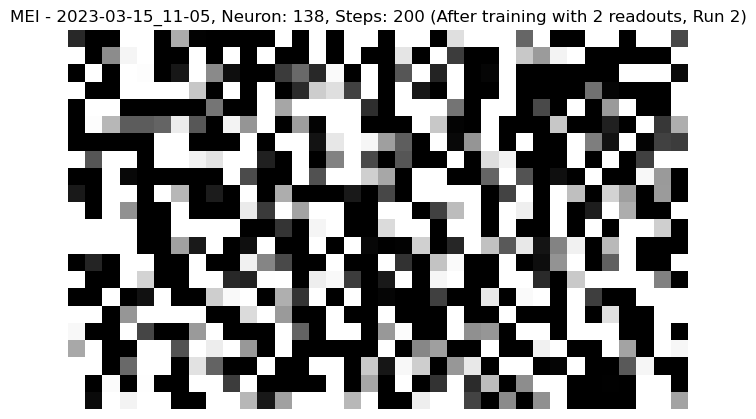

  Generating MEI 140/373: Neuron 139


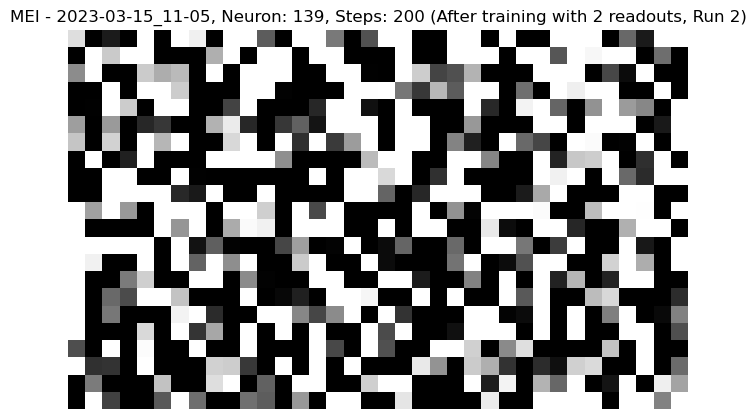

  Generating MEI 141/373: Neuron 140


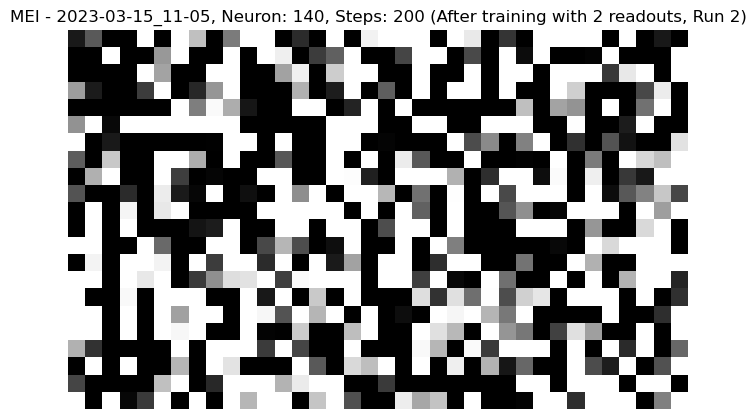

  Generating MEI 142/373: Neuron 141


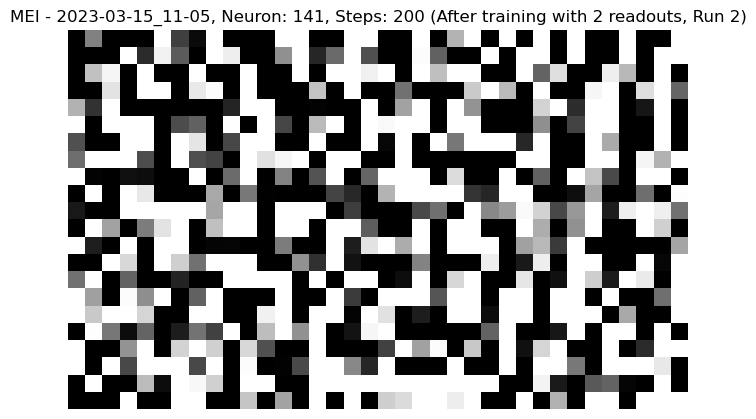

  Generating MEI 143/373: Neuron 142


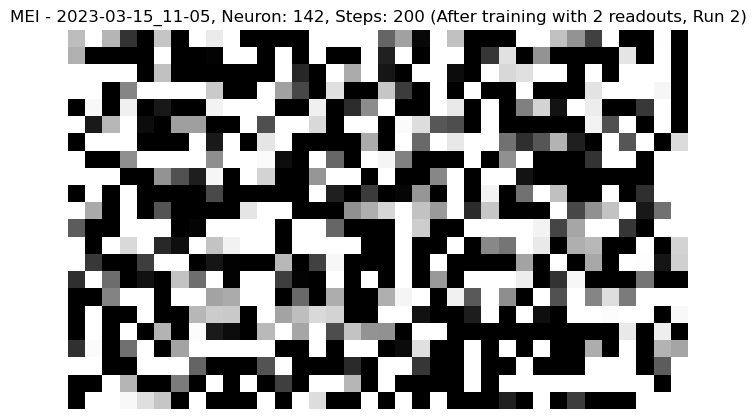

  Generating MEI 144/373: Neuron 143


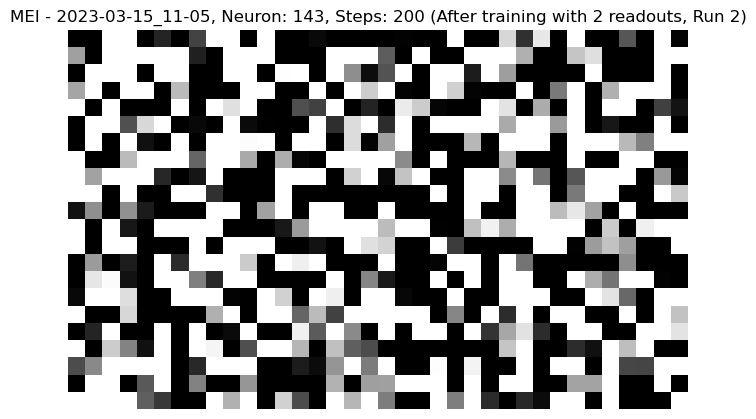

  Generating MEI 145/373: Neuron 144


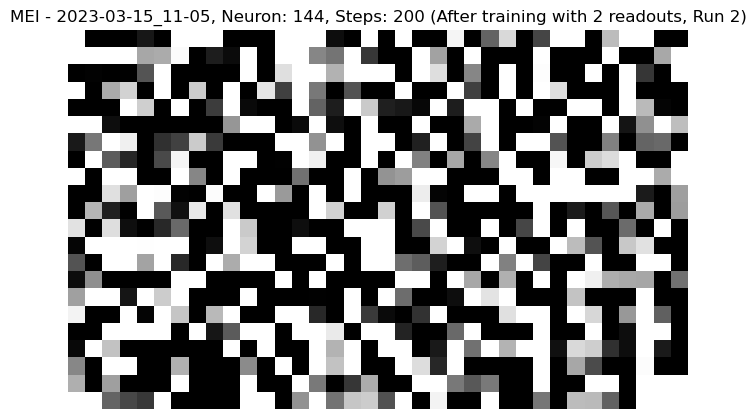

  Generating MEI 146/373: Neuron 145


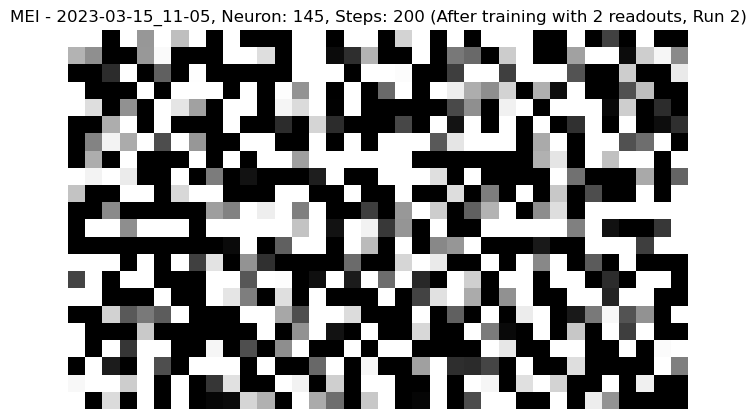

  Generating MEI 147/373: Neuron 146


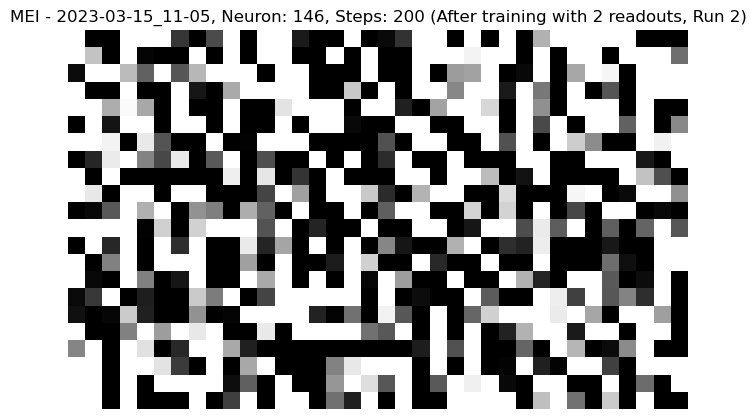

  Generating MEI 148/373: Neuron 147


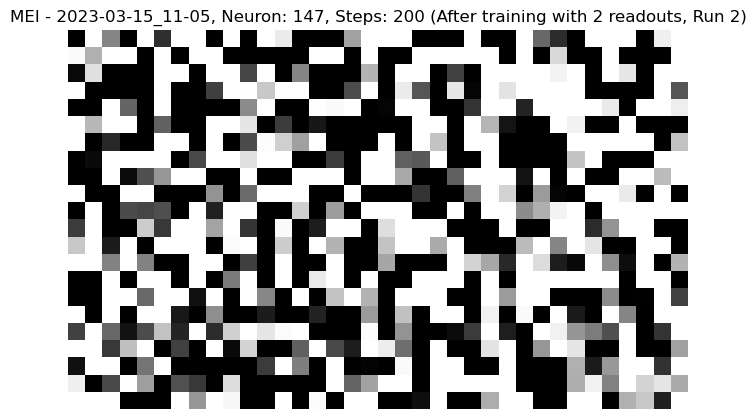

  Generating MEI 149/373: Neuron 148


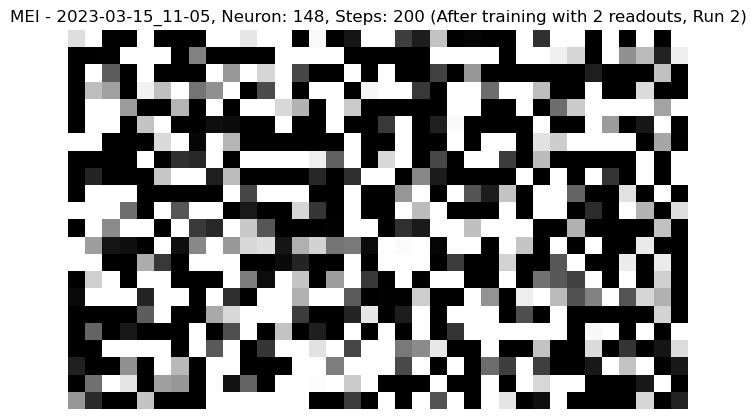

  Generating MEI 150/373: Neuron 149


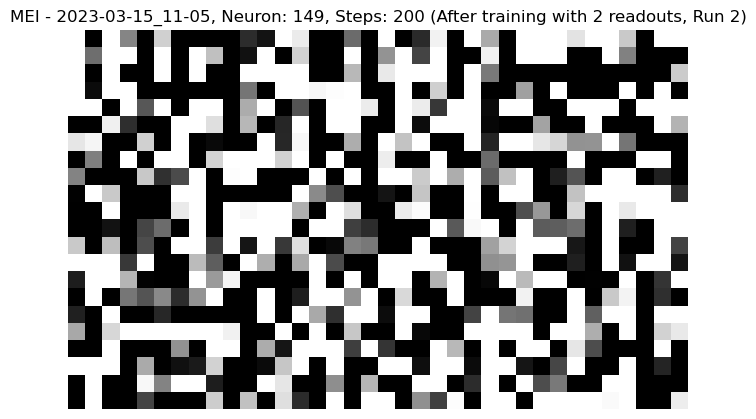

  Generating MEI 151/373: Neuron 150


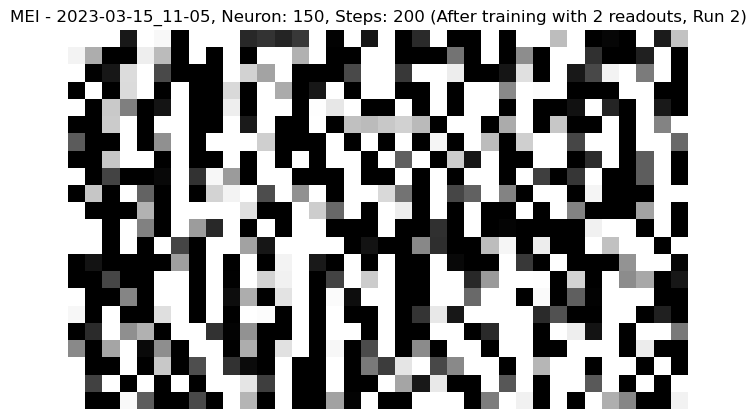

  Generating MEI 152/373: Neuron 151


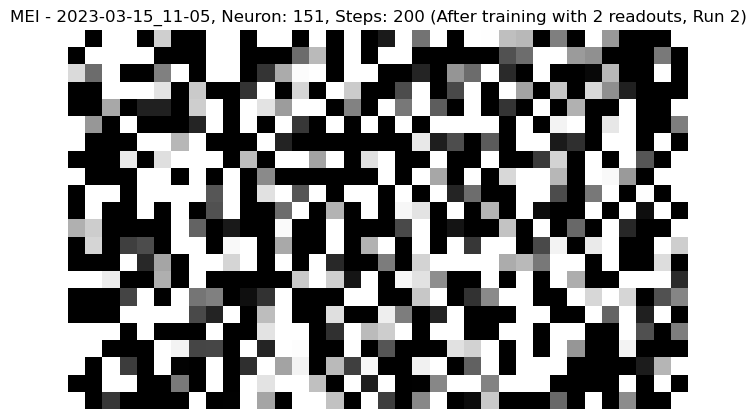

  Generating MEI 153/373: Neuron 152


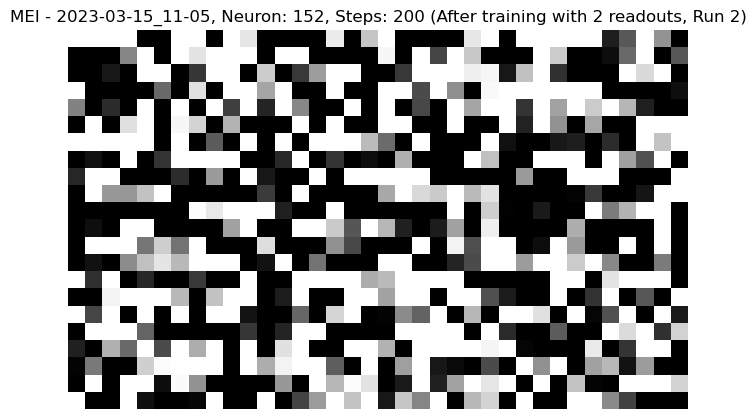

  Generating MEI 154/373: Neuron 153


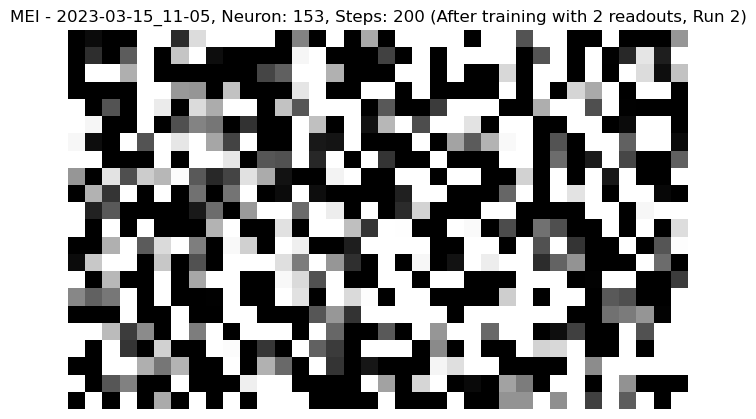

  Generating MEI 155/373: Neuron 154


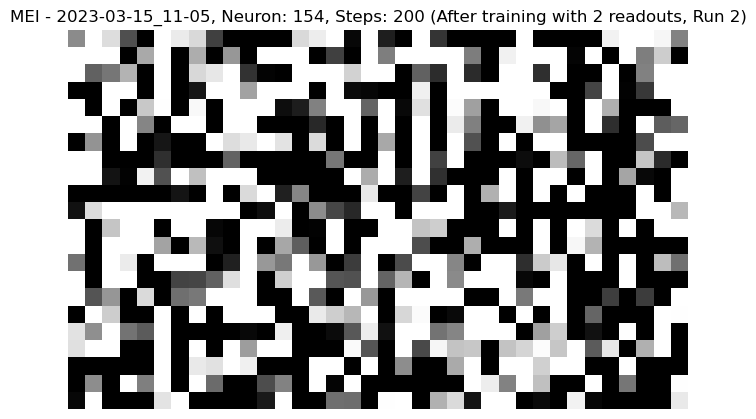

  Generating MEI 156/373: Neuron 155


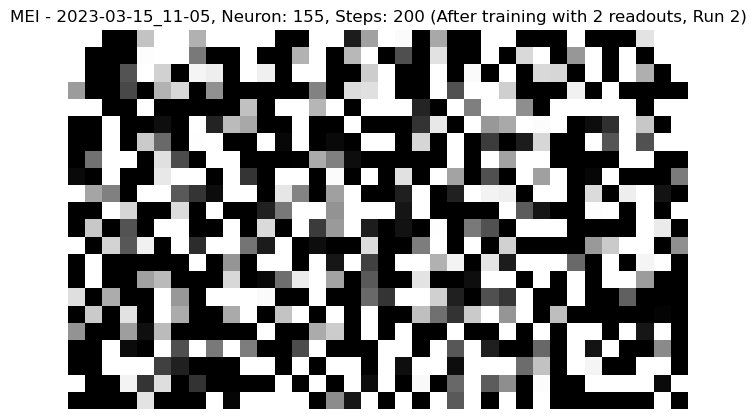

  Generating MEI 157/373: Neuron 156


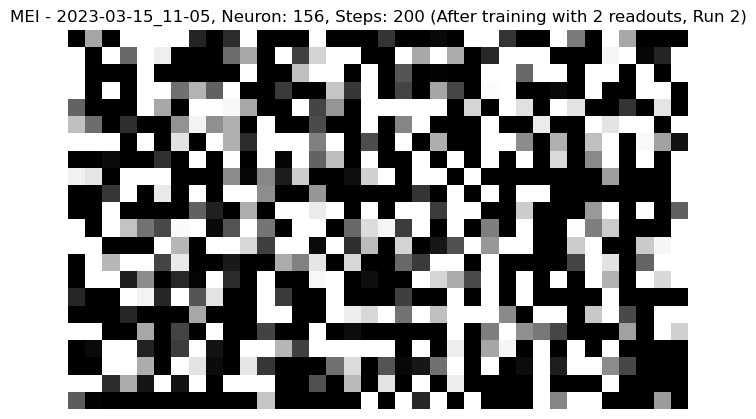

  Generating MEI 158/373: Neuron 157


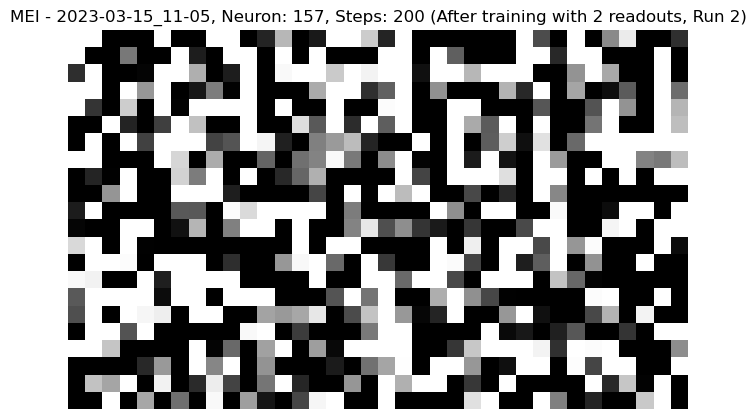

  Generating MEI 159/373: Neuron 158


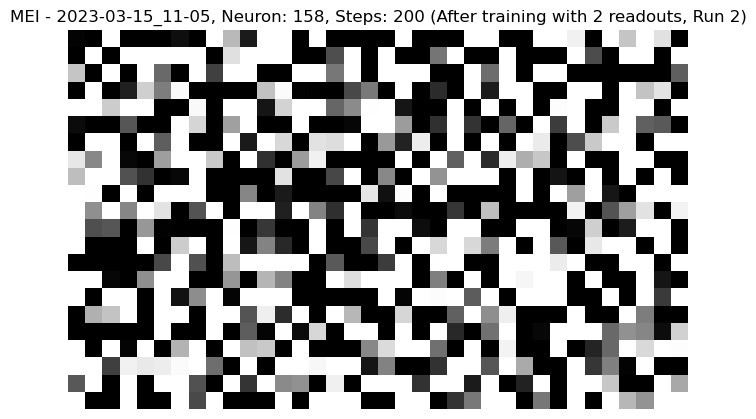

  Generating MEI 160/373: Neuron 159


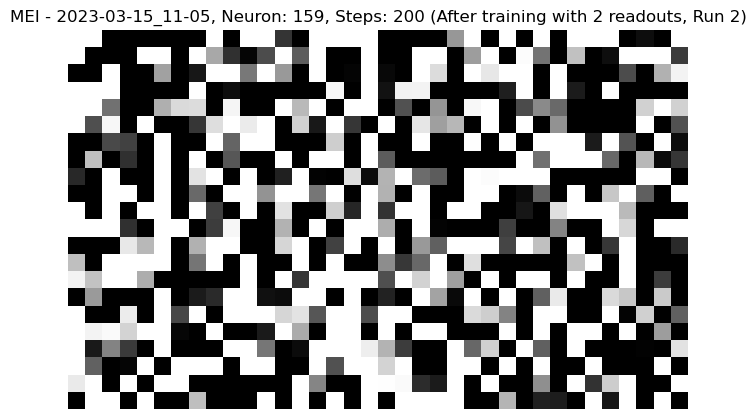

  Generating MEI 161/373: Neuron 160


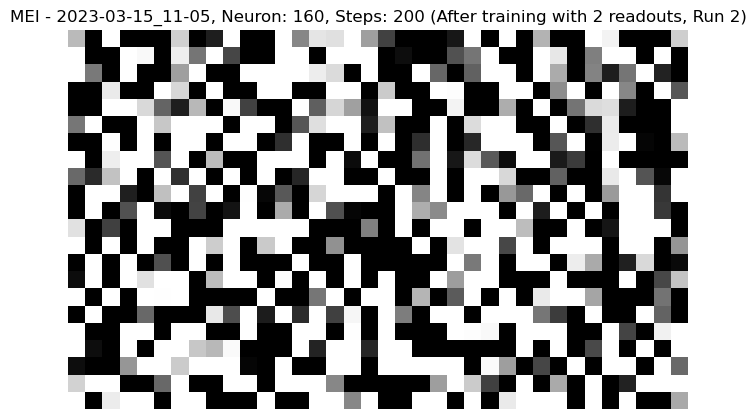

  Generating MEI 162/373: Neuron 161


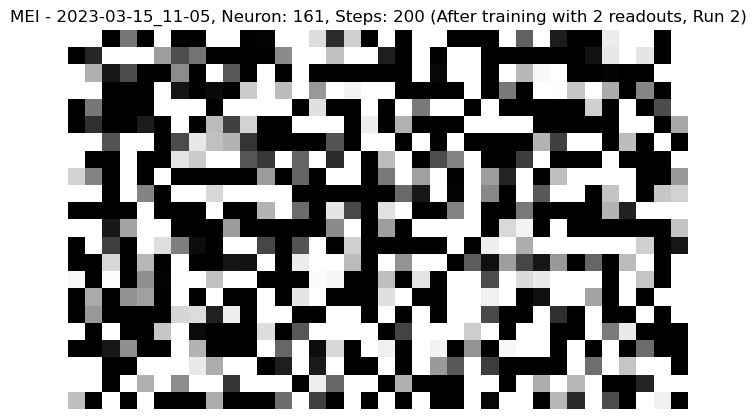

  Generating MEI 163/373: Neuron 162


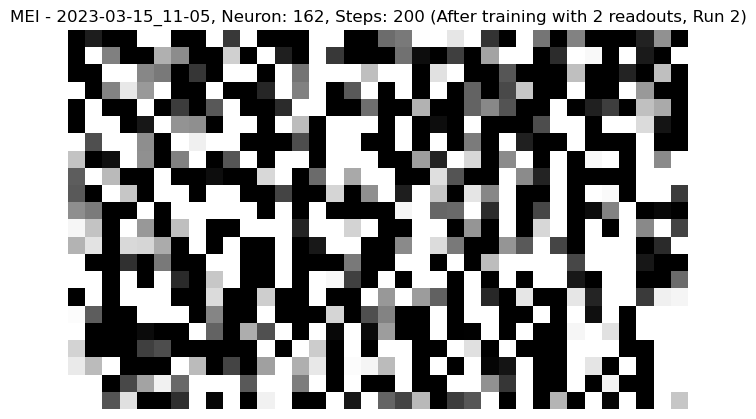

  Generating MEI 164/373: Neuron 163


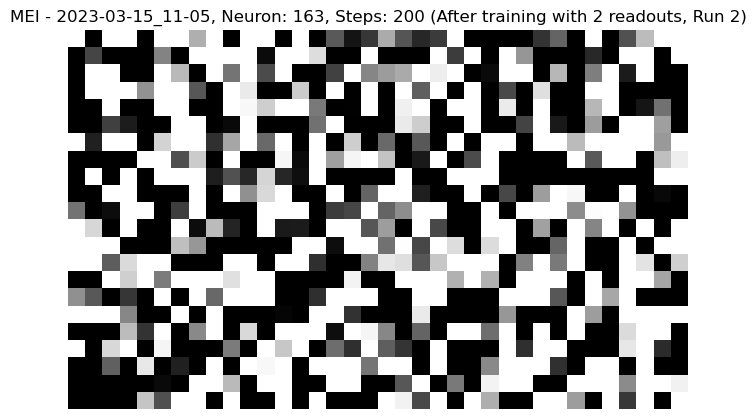

  Generating MEI 165/373: Neuron 164


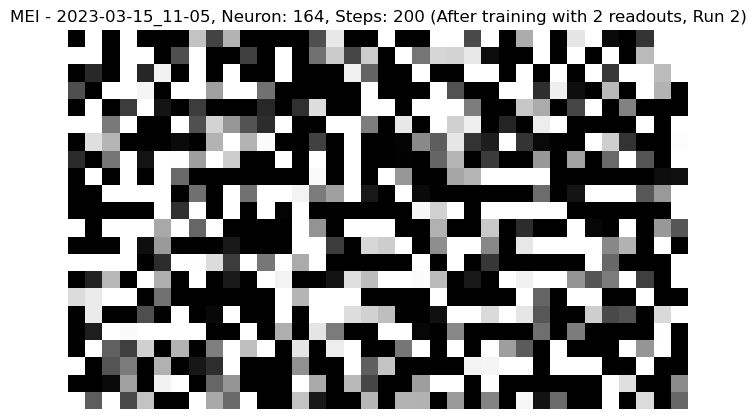

  Generating MEI 166/373: Neuron 165


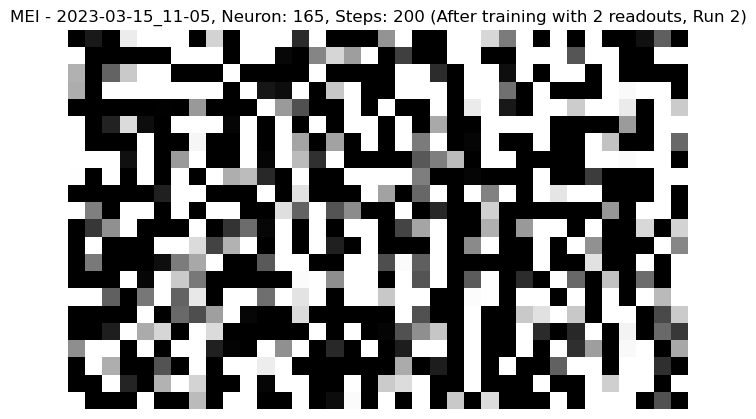

  Generating MEI 167/373: Neuron 166


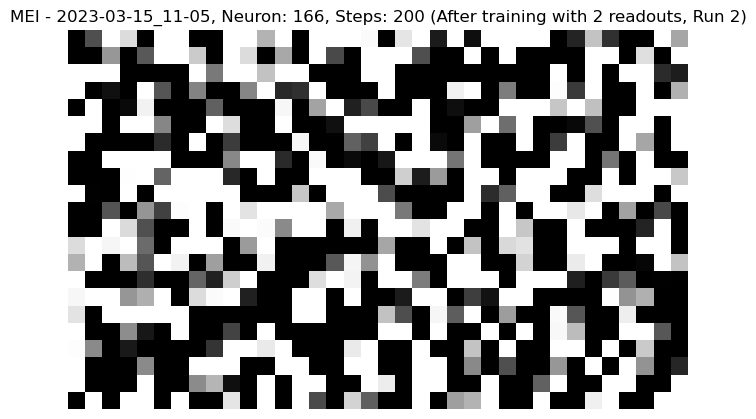

  Generating MEI 168/373: Neuron 167


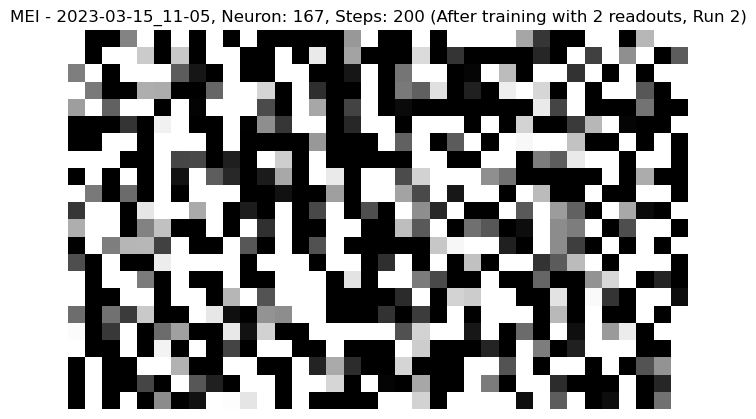

  Generating MEI 169/373: Neuron 168


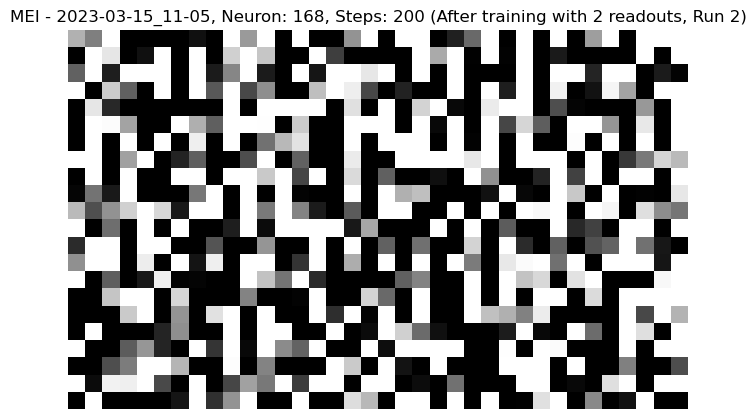

  Generating MEI 170/373: Neuron 169


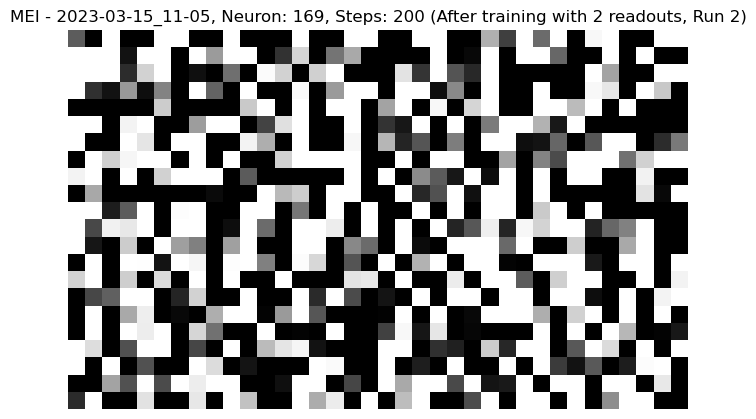

  Generating MEI 171/373: Neuron 170


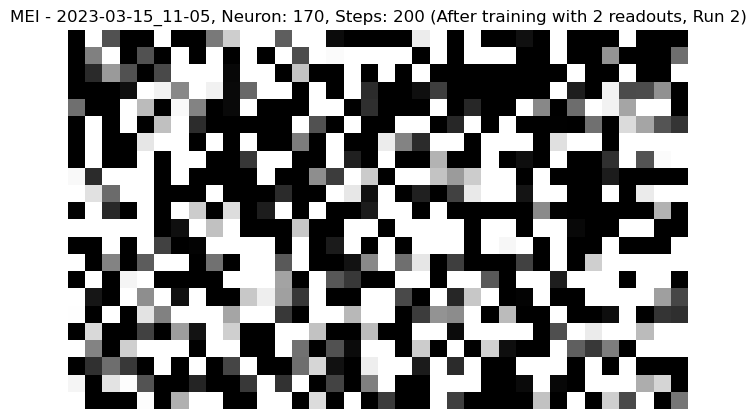

  Generating MEI 172/373: Neuron 171


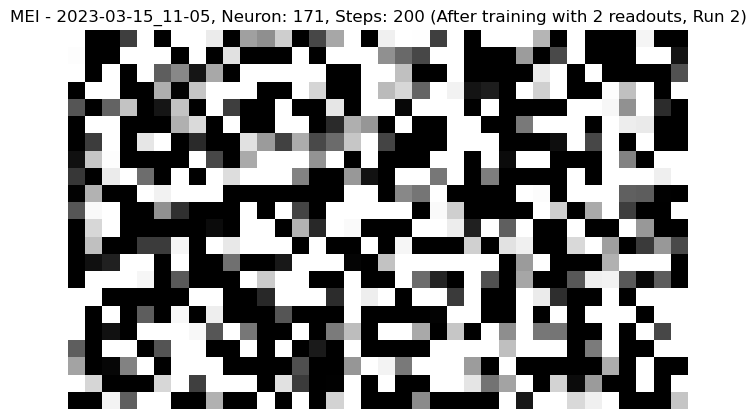

  Generating MEI 173/373: Neuron 172


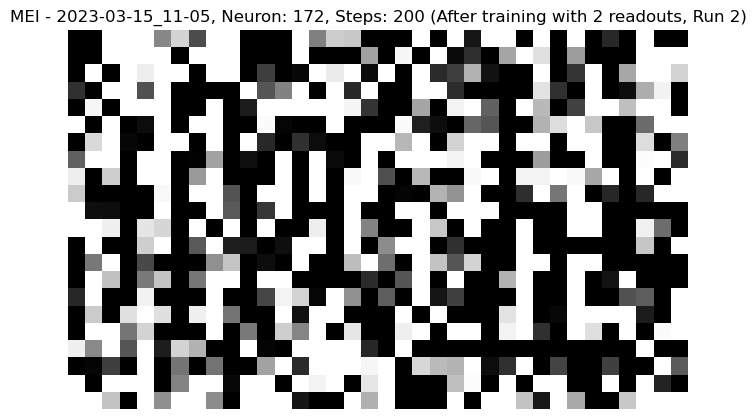

  Generating MEI 174/373: Neuron 173


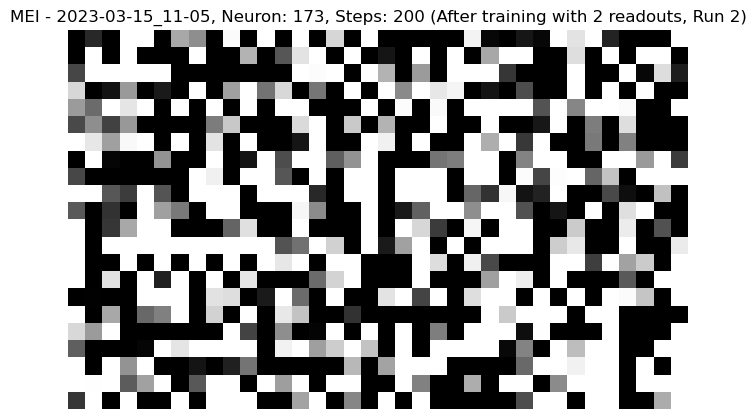

  Generating MEI 175/373: Neuron 174


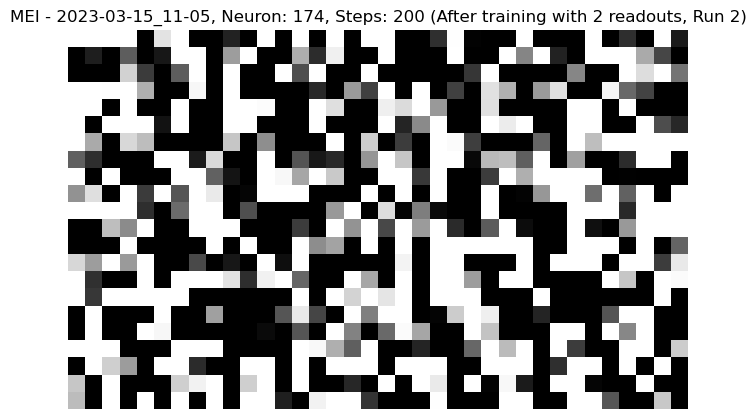

  Generating MEI 176/373: Neuron 175


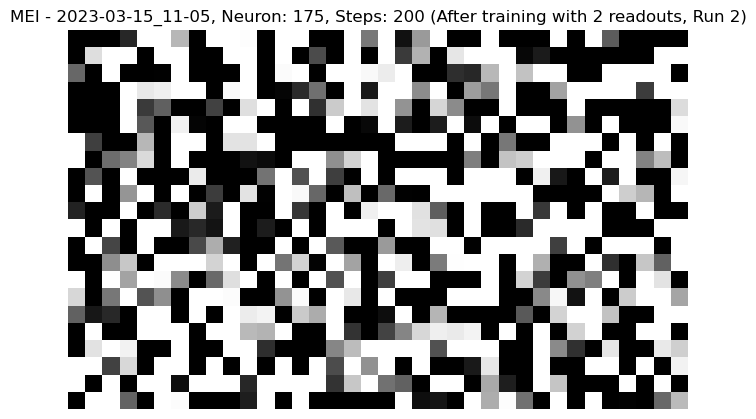

  Generating MEI 177/373: Neuron 176


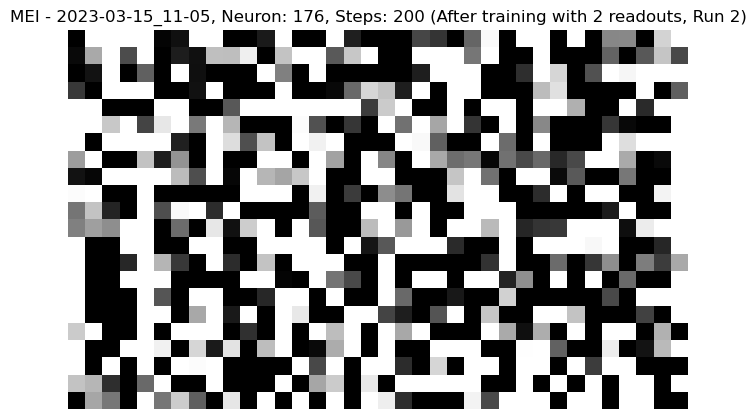

  Generating MEI 178/373: Neuron 177


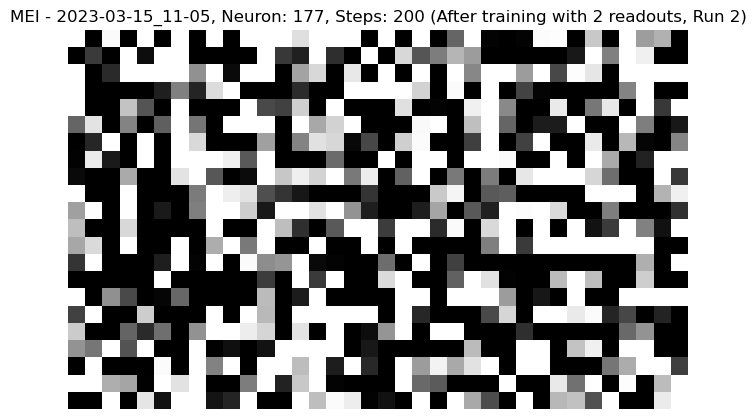

  Generating MEI 179/373: Neuron 178


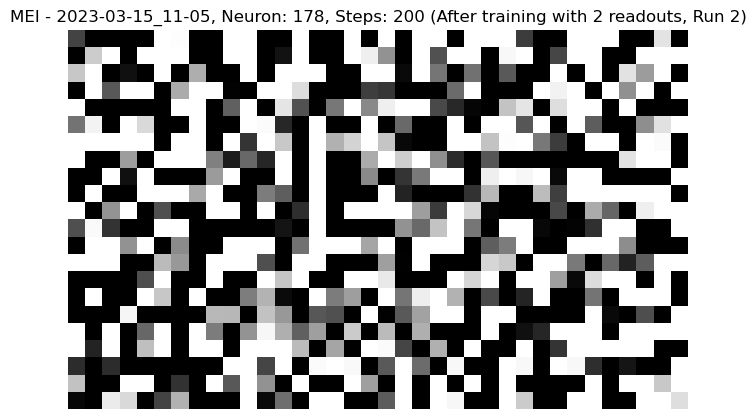

  Generating MEI 180/373: Neuron 179


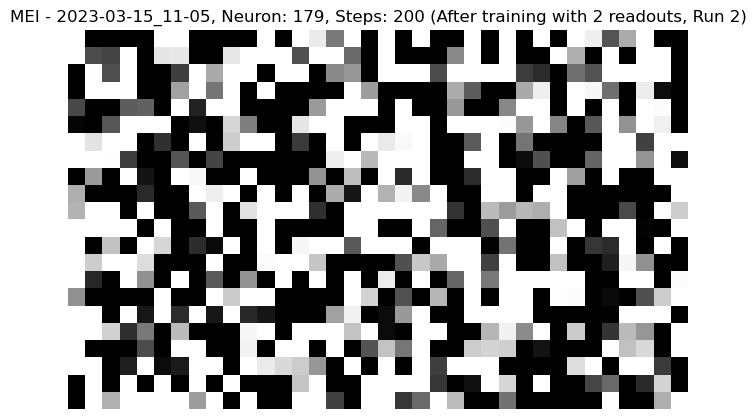

  Generating MEI 181/373: Neuron 180


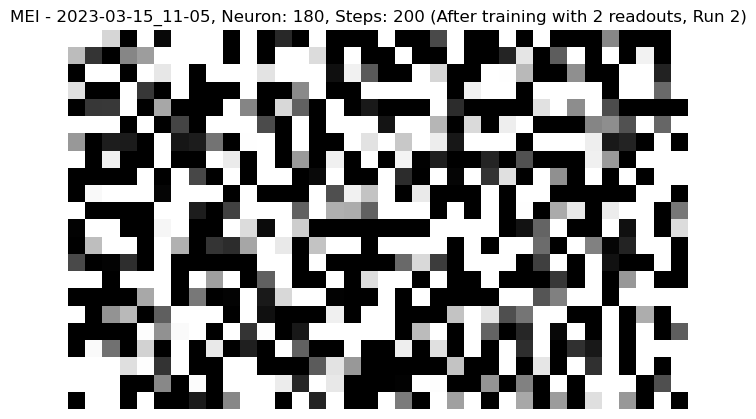

  Generating MEI 182/373: Neuron 181


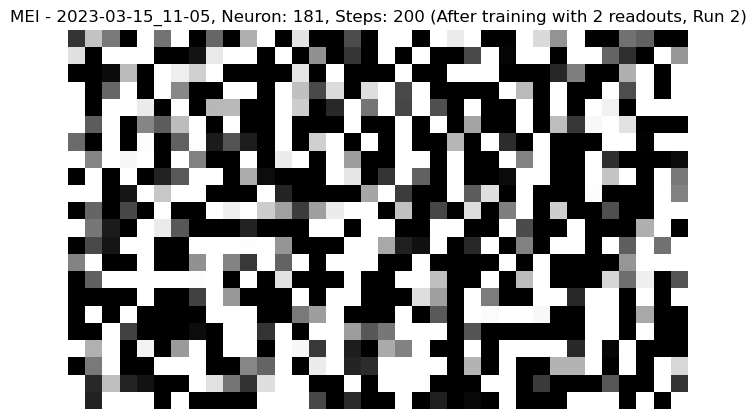

  Generating MEI 183/373: Neuron 182


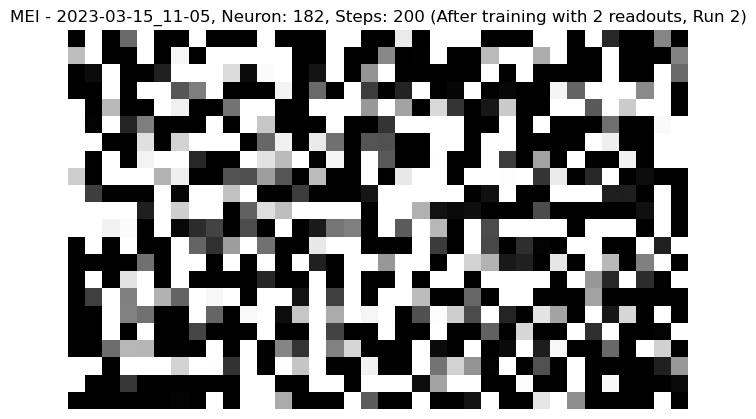

  Generating MEI 184/373: Neuron 183


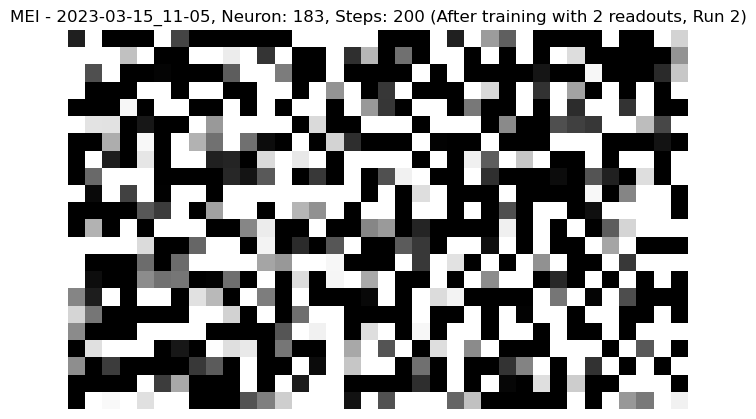

  Generating MEI 185/373: Neuron 184


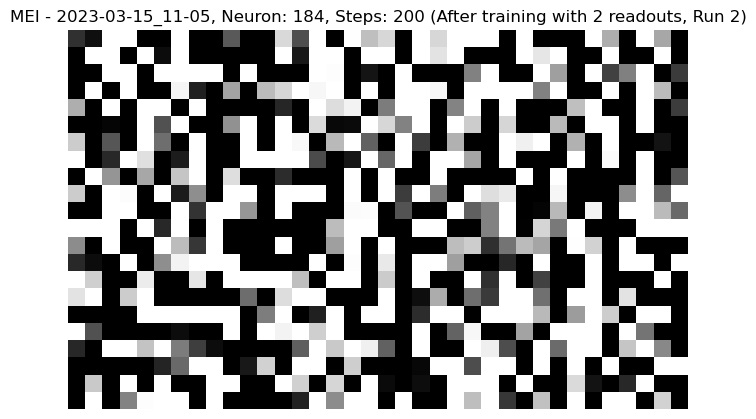

  Generating MEI 186/373: Neuron 185


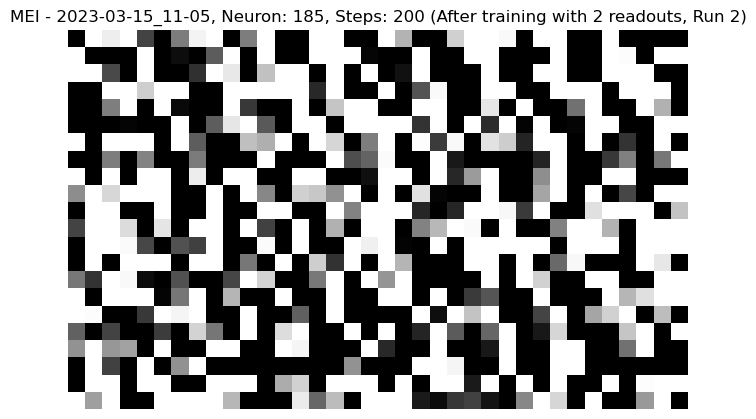

  Generating MEI 187/373: Neuron 186


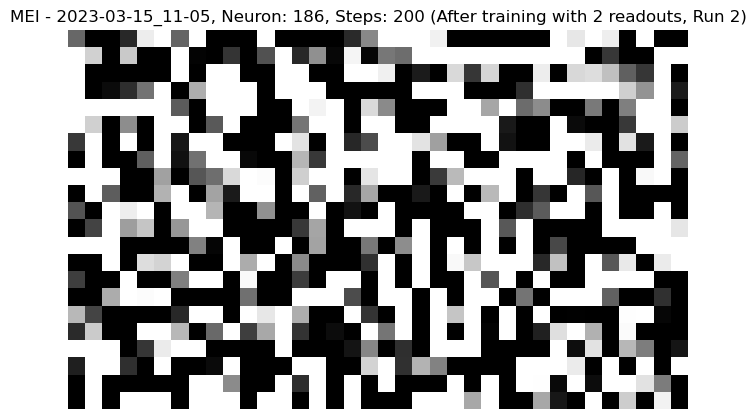

  Generating MEI 188/373: Neuron 187


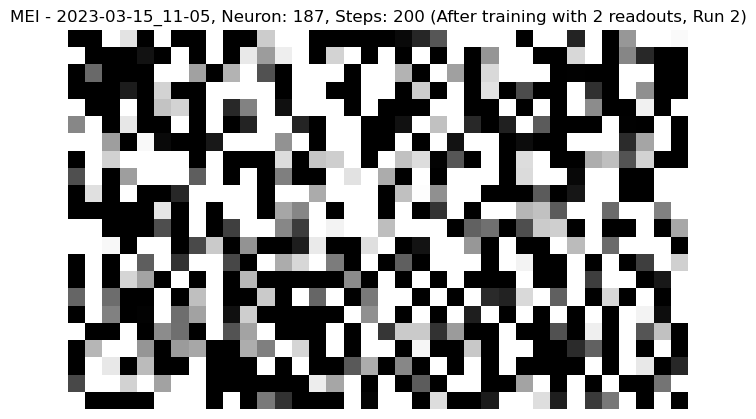

  Generating MEI 189/373: Neuron 188


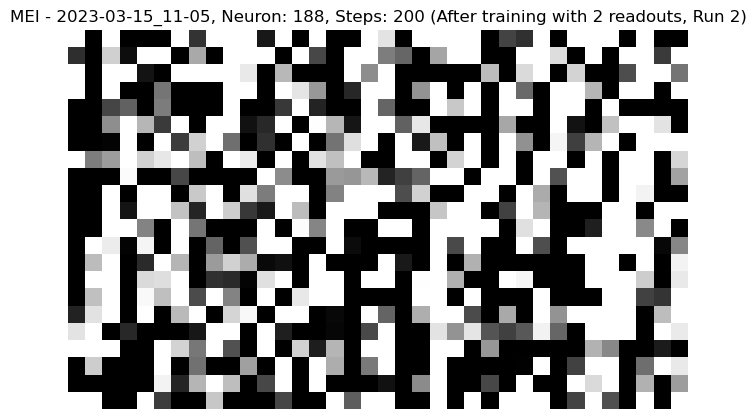

  Generating MEI 190/373: Neuron 189


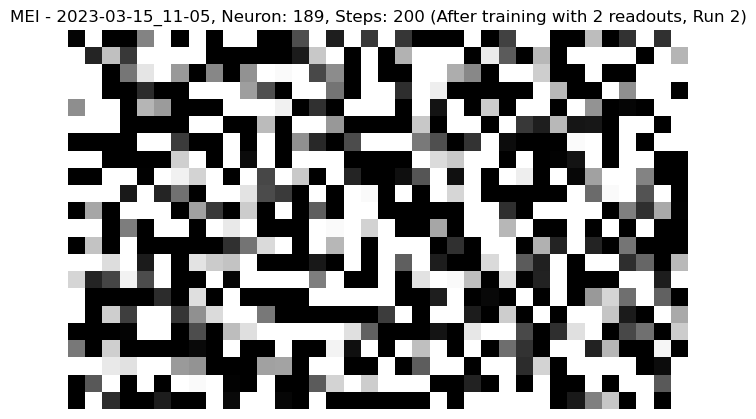

  Generating MEI 191/373: Neuron 190


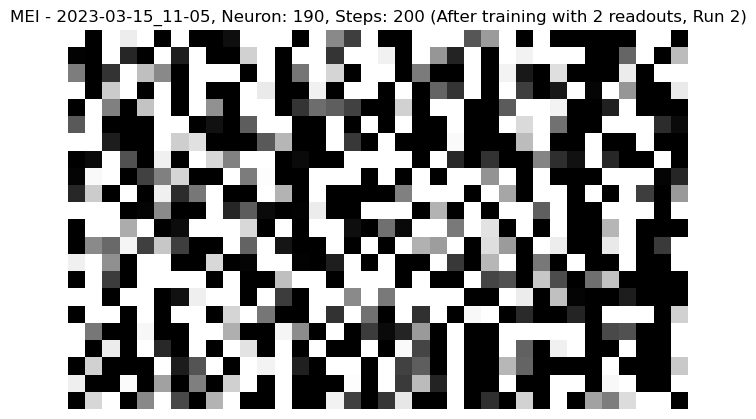

  Generating MEI 192/373: Neuron 191


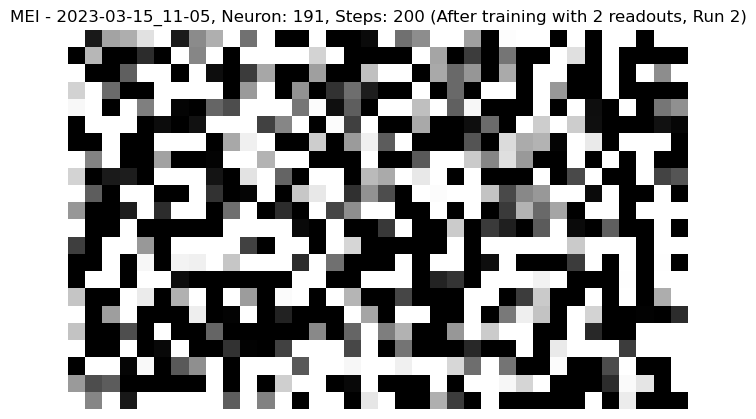

  Generating MEI 193/373: Neuron 192


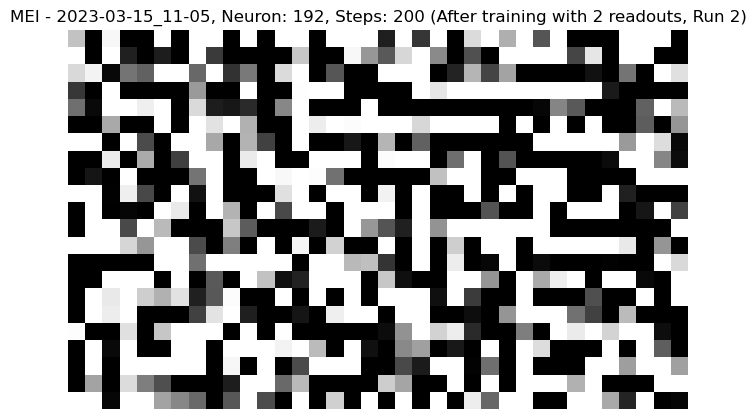

  Generating MEI 194/373: Neuron 193


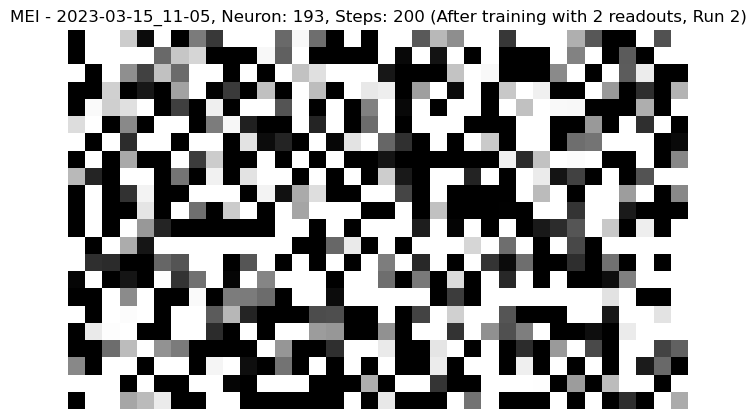

  Generating MEI 195/373: Neuron 194


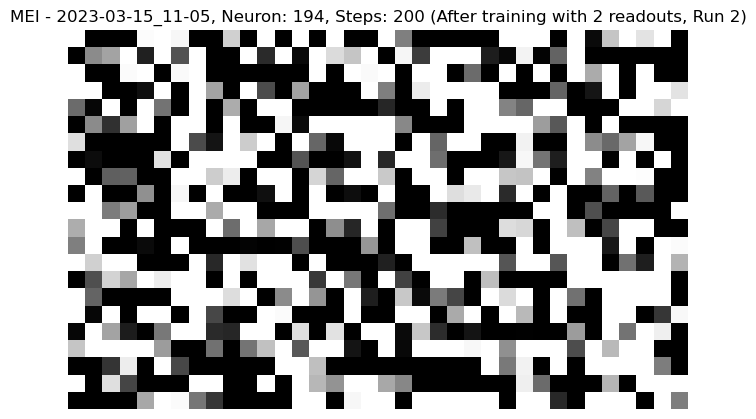

  Generating MEI 196/373: Neuron 195


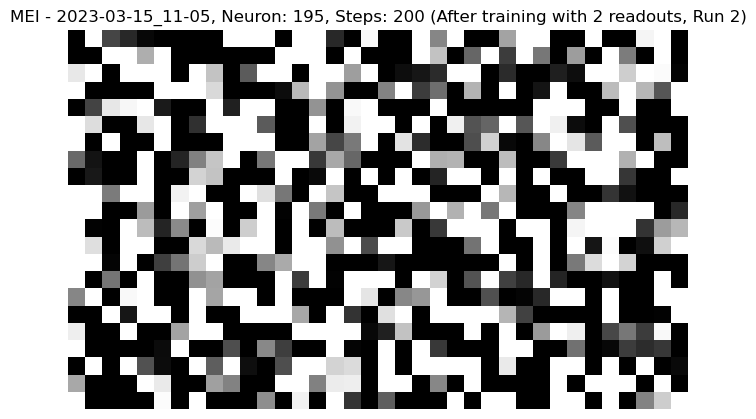

  Generating MEI 197/373: Neuron 196


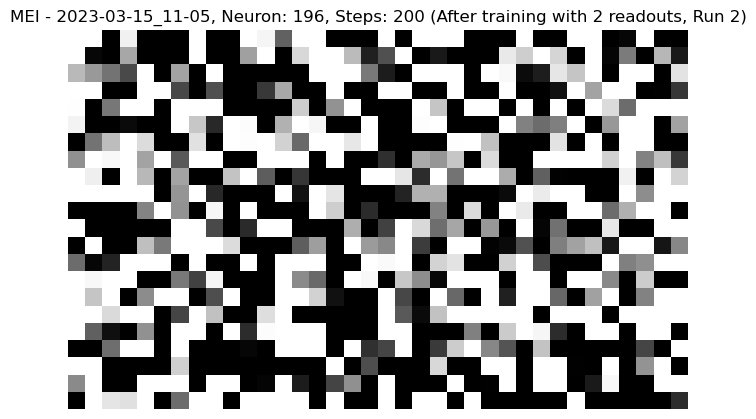

  Generating MEI 198/373: Neuron 197


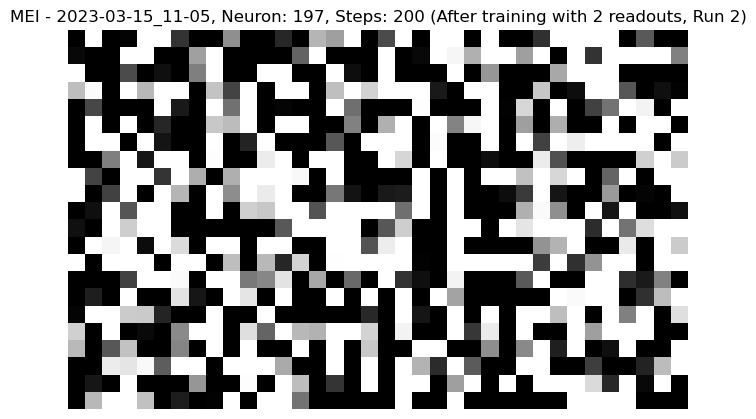

  Generating MEI 199/373: Neuron 198


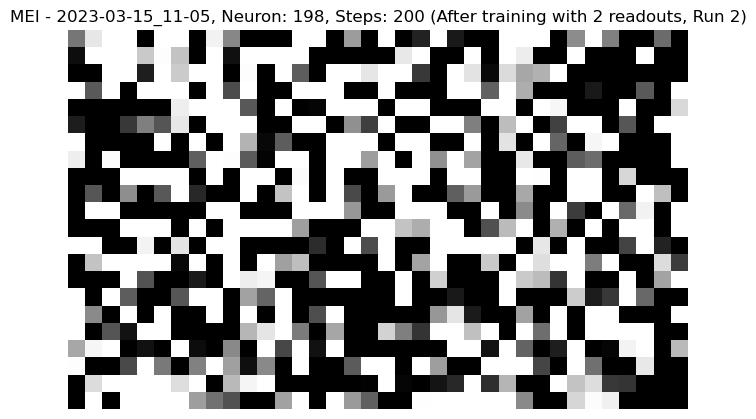

  Generating MEI 200/373: Neuron 199


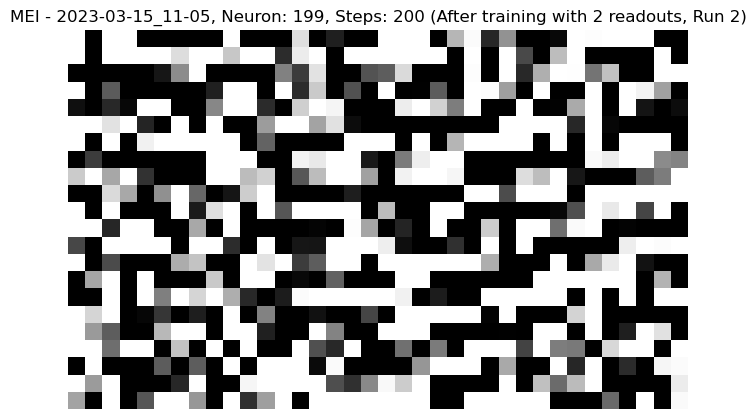

  Generating MEI 201/373: Neuron 200


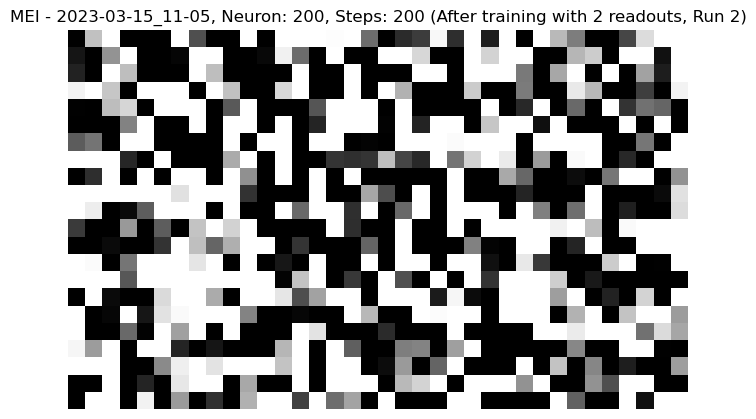

  Generating MEI 202/373: Neuron 201


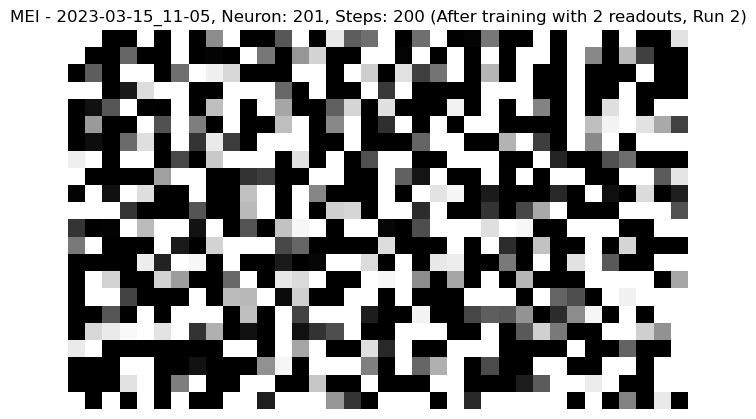

  Generating MEI 203/373: Neuron 202


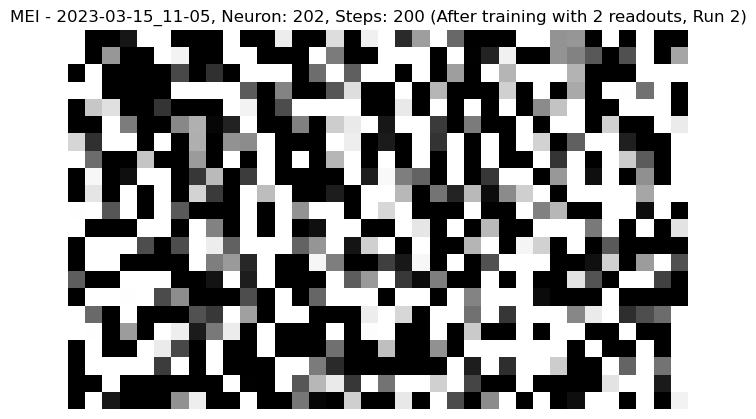

  Generating MEI 204/373: Neuron 203


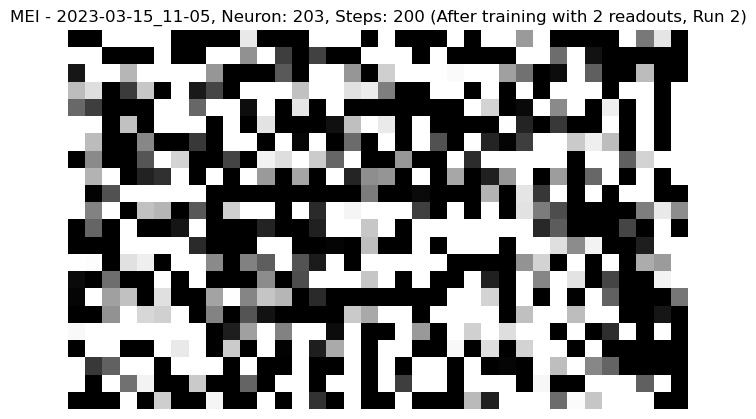

  Generating MEI 205/373: Neuron 204


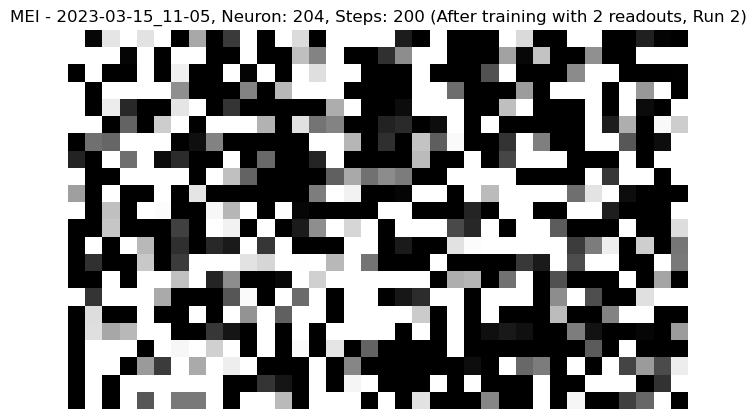

  Generating MEI 206/373: Neuron 205


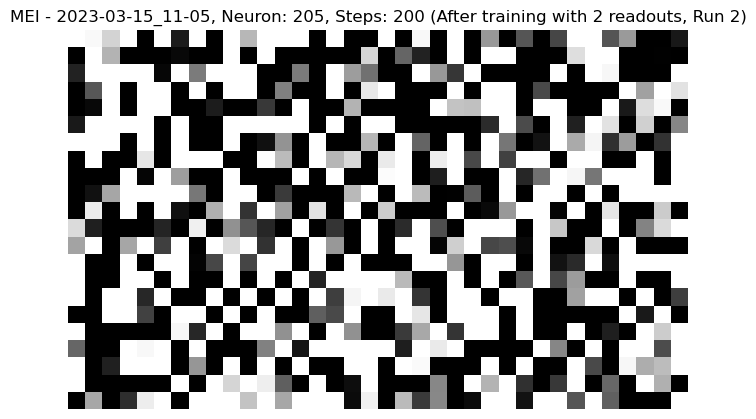

  Generating MEI 207/373: Neuron 206


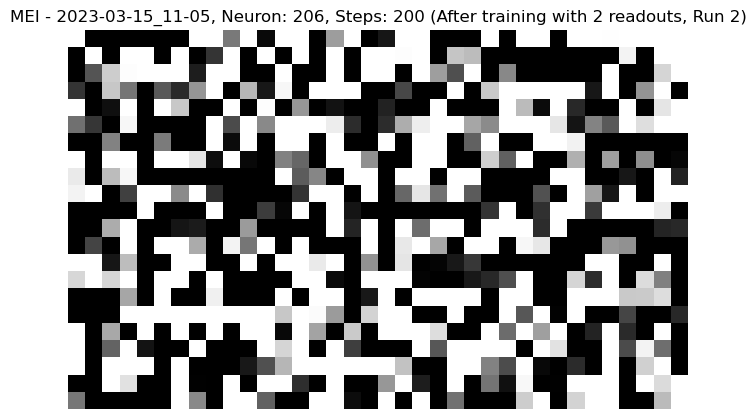

  Generating MEI 208/373: Neuron 207


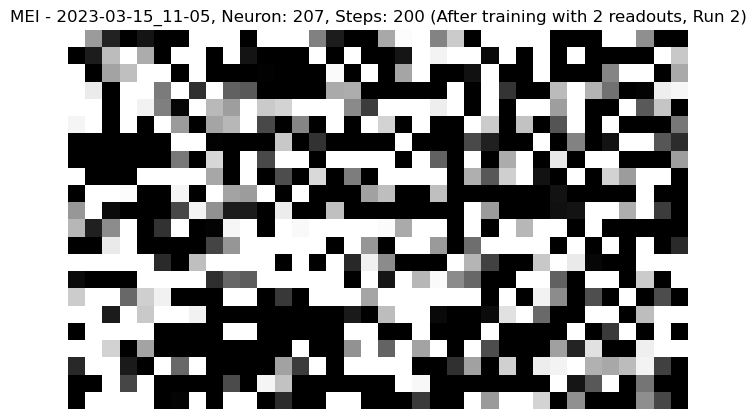

  Generating MEI 209/373: Neuron 208


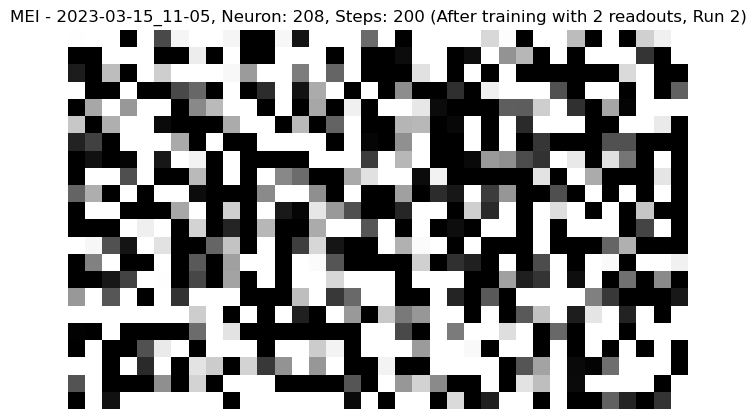

  Generating MEI 210/373: Neuron 209


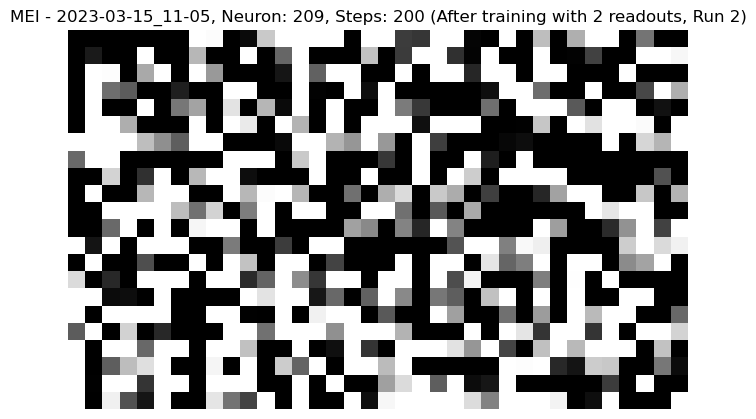

  Generating MEI 211/373: Neuron 210


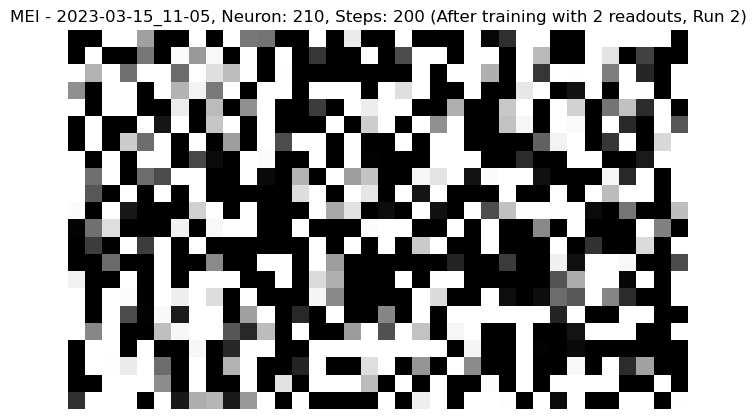

  Generating MEI 212/373: Neuron 211


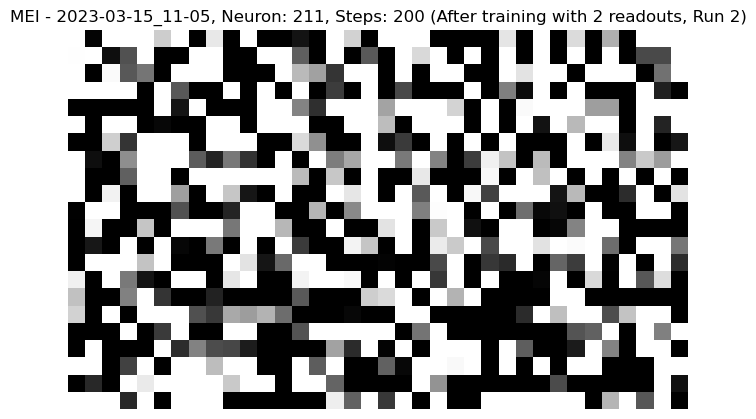

  Generating MEI 213/373: Neuron 212


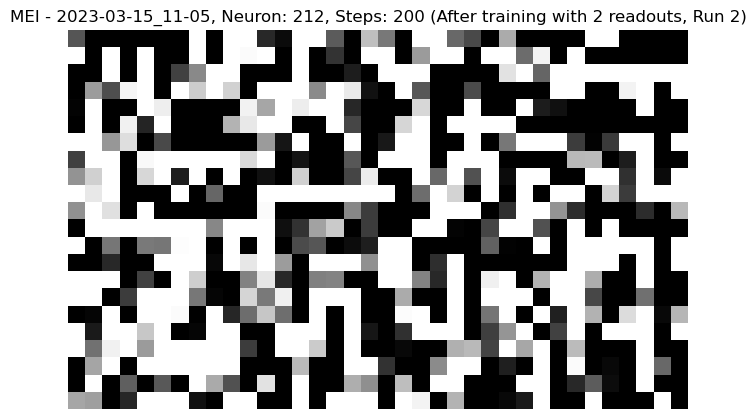

  Generating MEI 214/373: Neuron 213


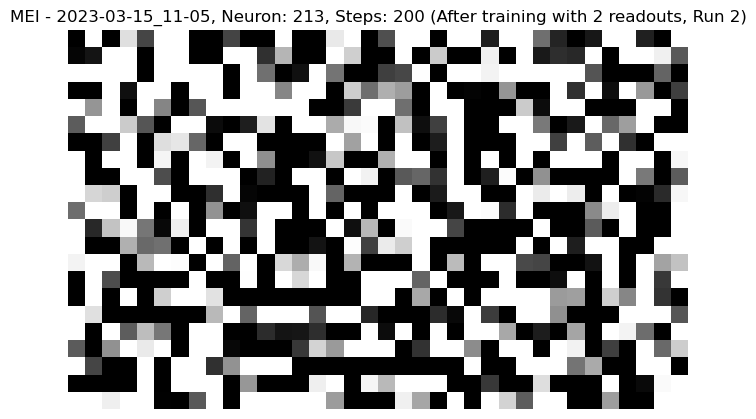

  Generating MEI 215/373: Neuron 214


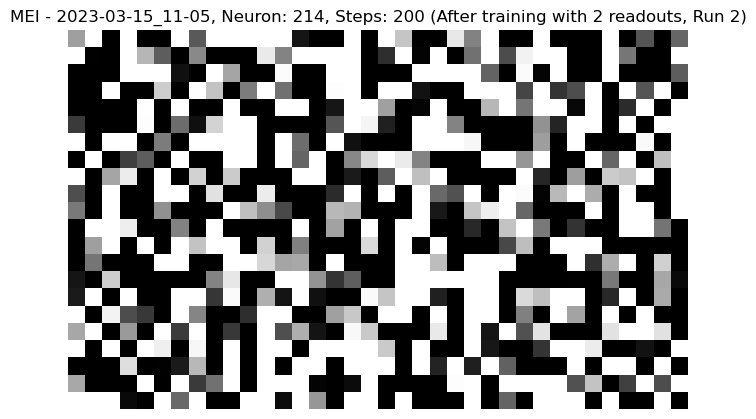

  Generating MEI 216/373: Neuron 215


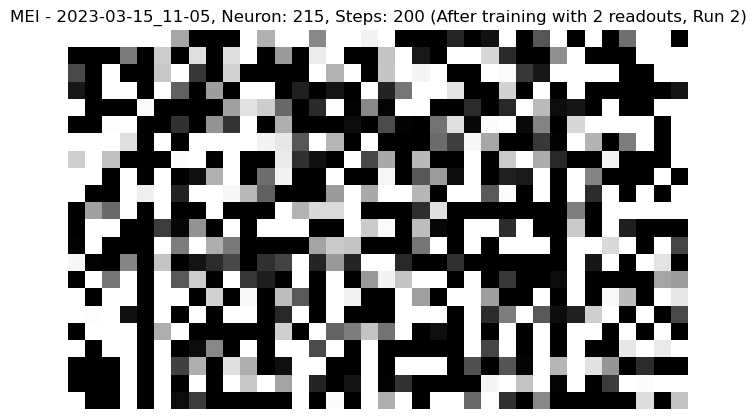

  Generating MEI 217/373: Neuron 216


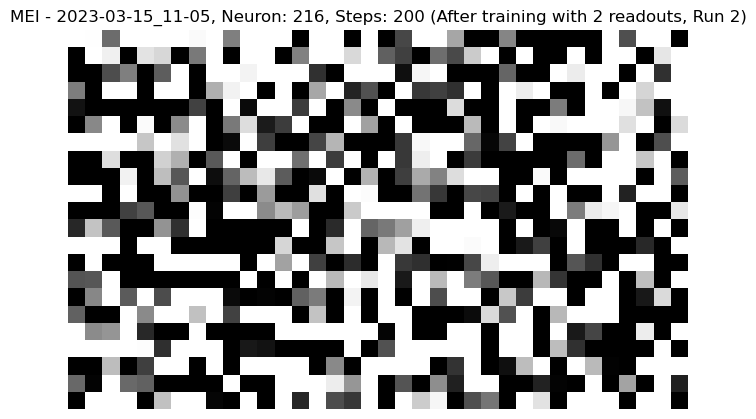

  Generating MEI 218/373: Neuron 217


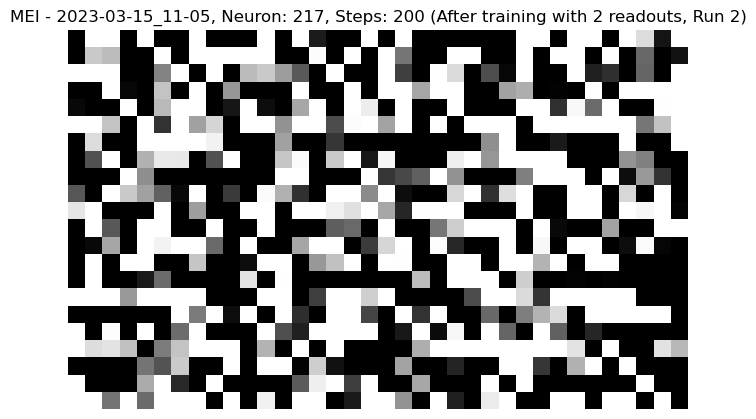

  Generating MEI 219/373: Neuron 218


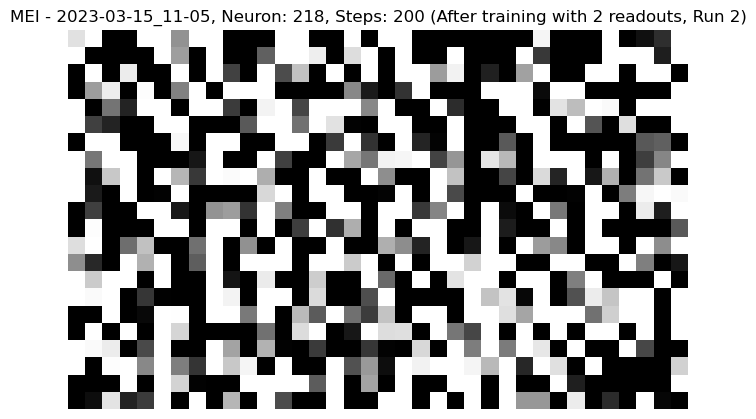

  Generating MEI 220/373: Neuron 219


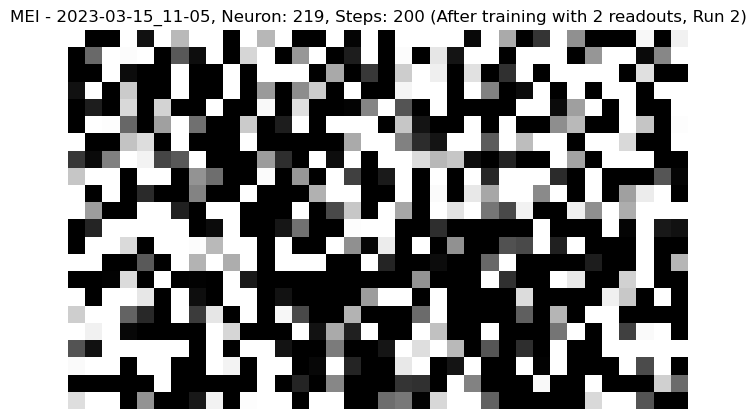

  Generating MEI 221/373: Neuron 220


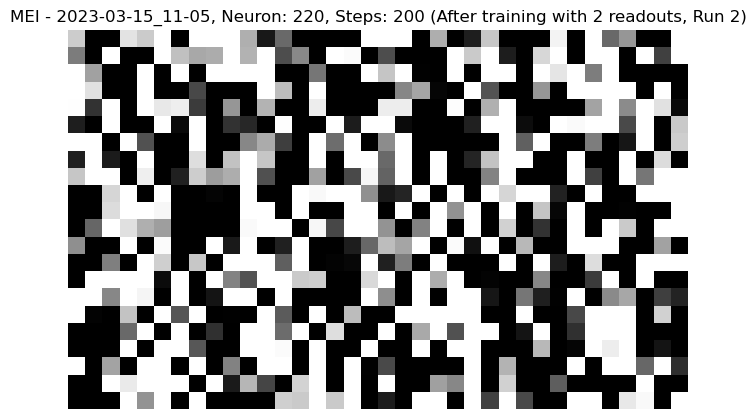

  Generating MEI 222/373: Neuron 221


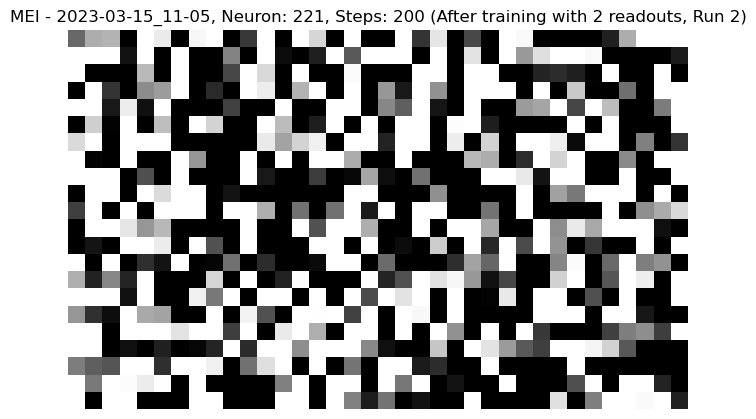

  Generating MEI 223/373: Neuron 222


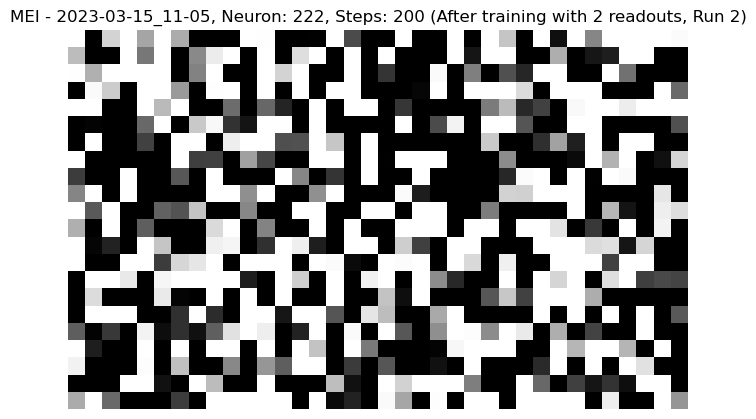

  Generating MEI 224/373: Neuron 223


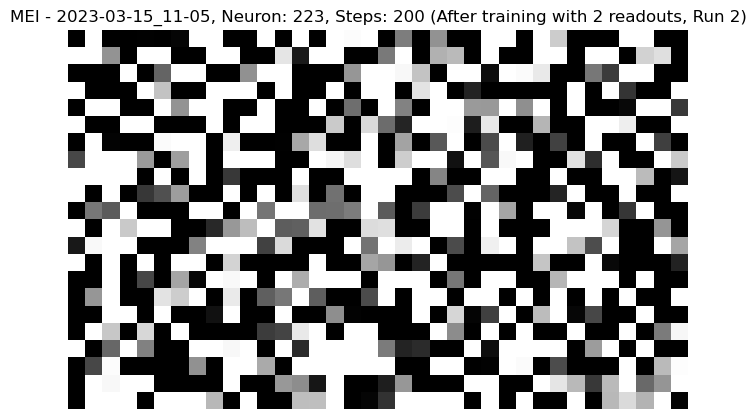

  Generating MEI 225/373: Neuron 224


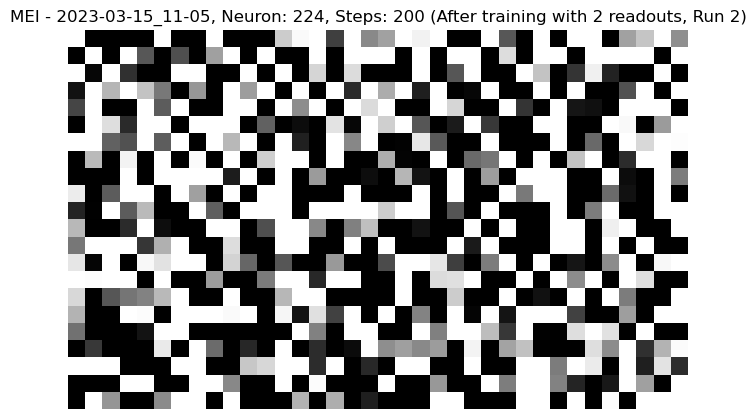

  Generating MEI 226/373: Neuron 225


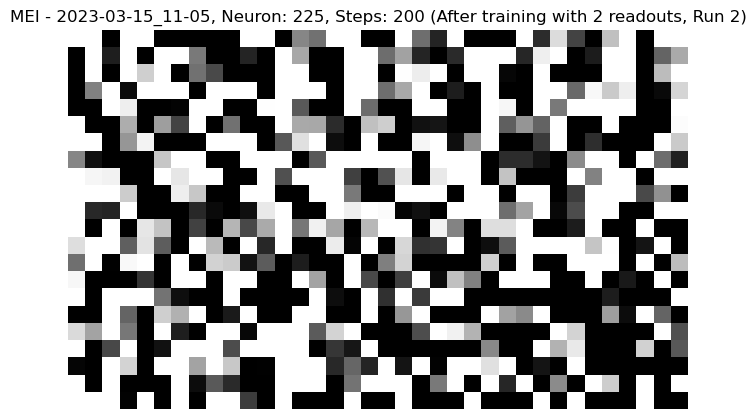

  Generating MEI 227/373: Neuron 226


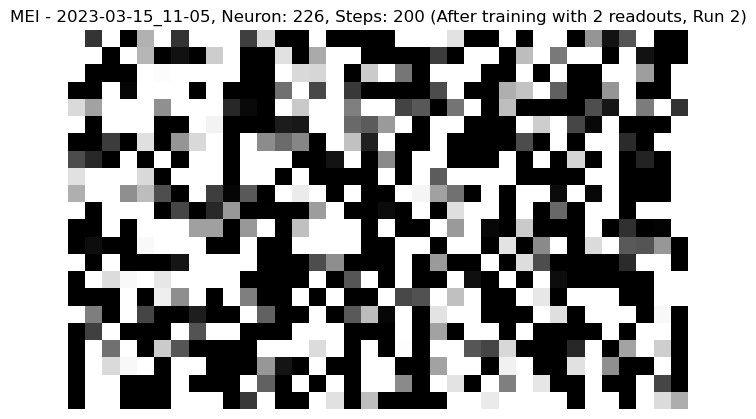

  Generating MEI 228/373: Neuron 227


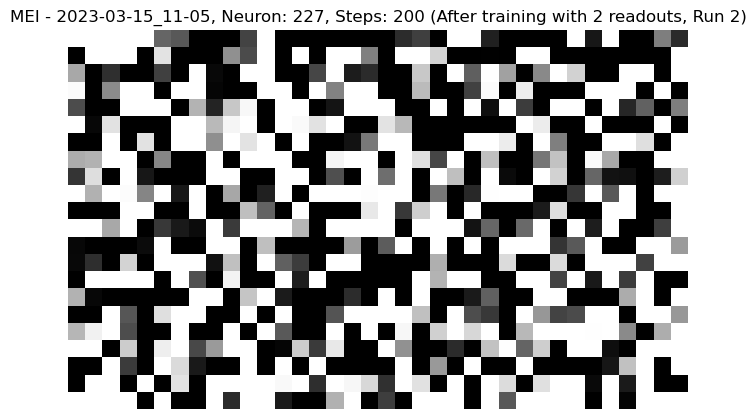

  Generating MEI 229/373: Neuron 228


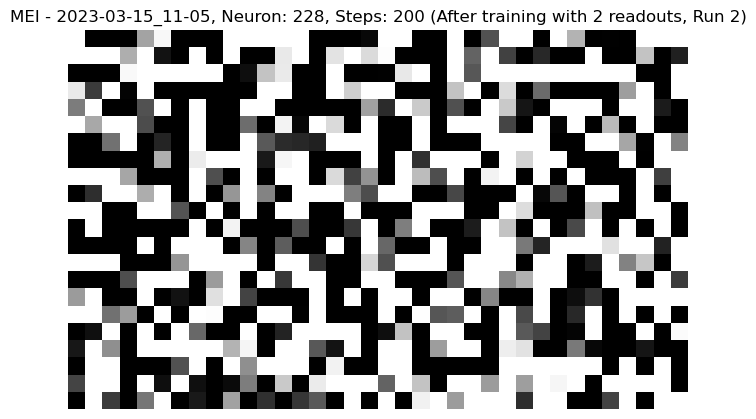

  Generating MEI 230/373: Neuron 229


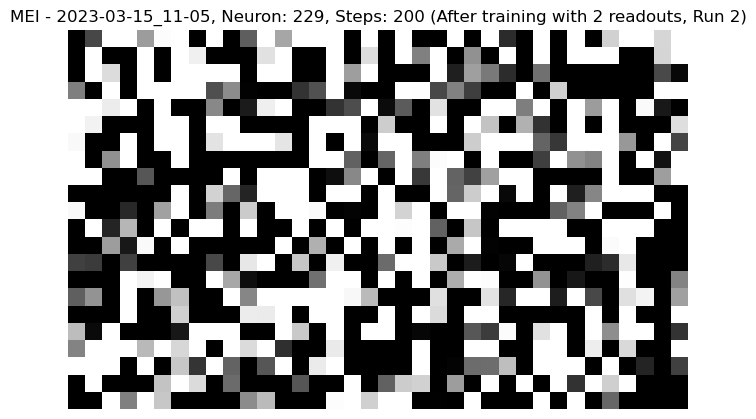

  Generating MEI 231/373: Neuron 230


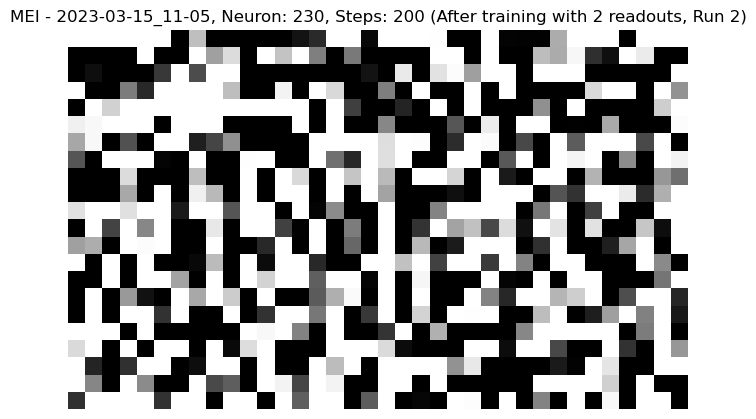

  Generating MEI 232/373: Neuron 231


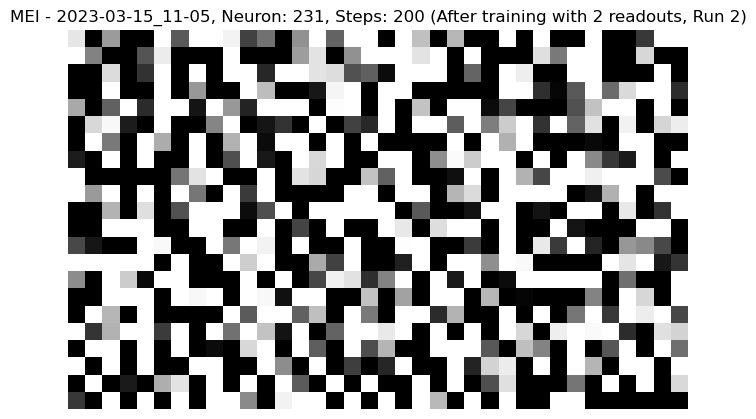

  Generating MEI 233/373: Neuron 232


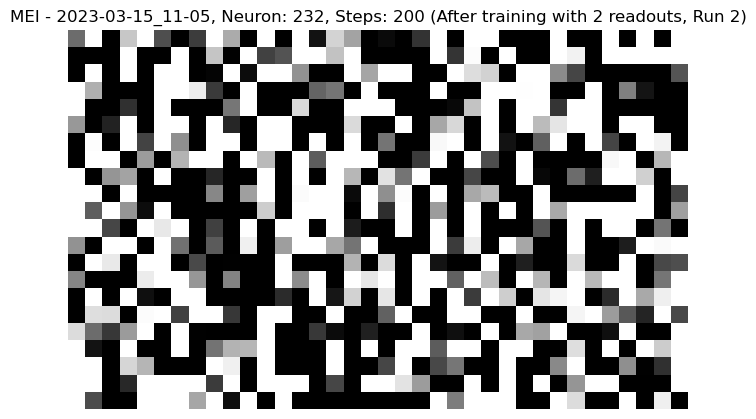

  Generating MEI 234/373: Neuron 233


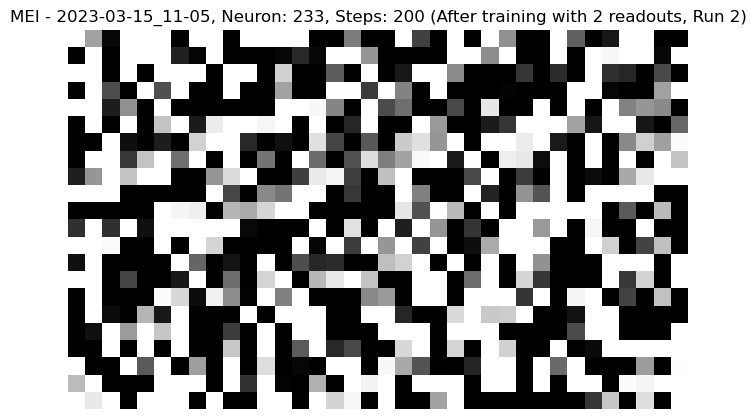

  Generating MEI 235/373: Neuron 234


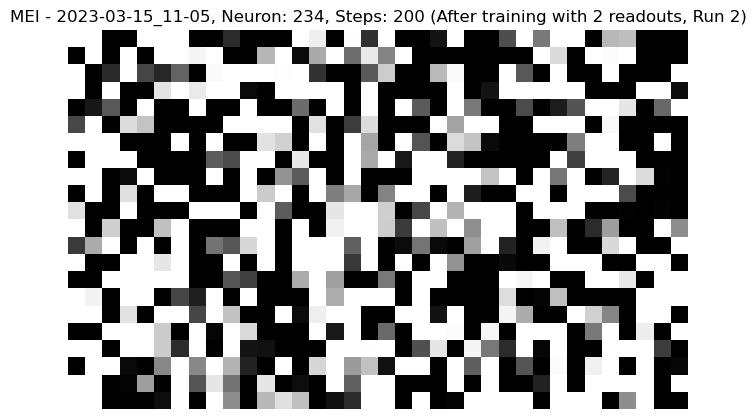

  Generating MEI 236/373: Neuron 235


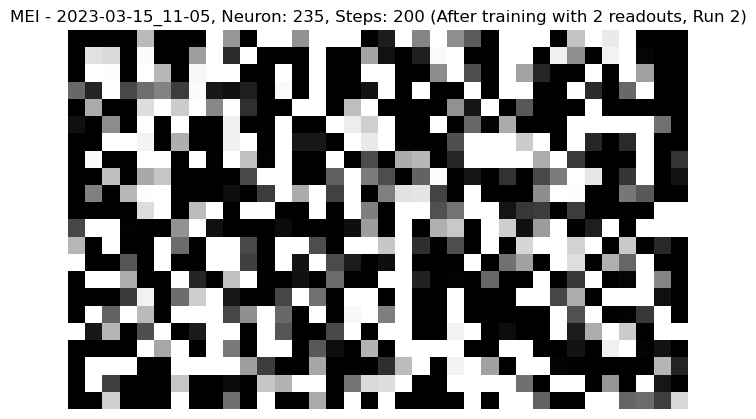

  Generating MEI 237/373: Neuron 236


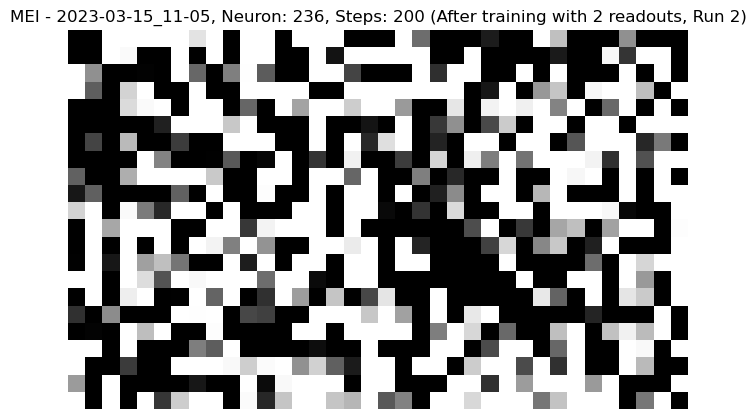

  Generating MEI 238/373: Neuron 237


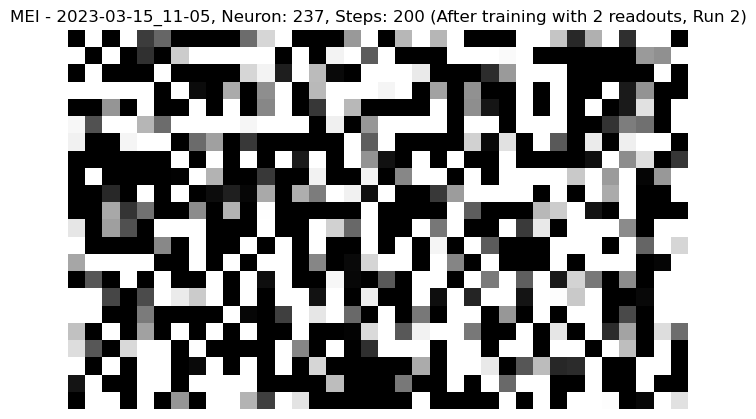

  Generating MEI 239/373: Neuron 238


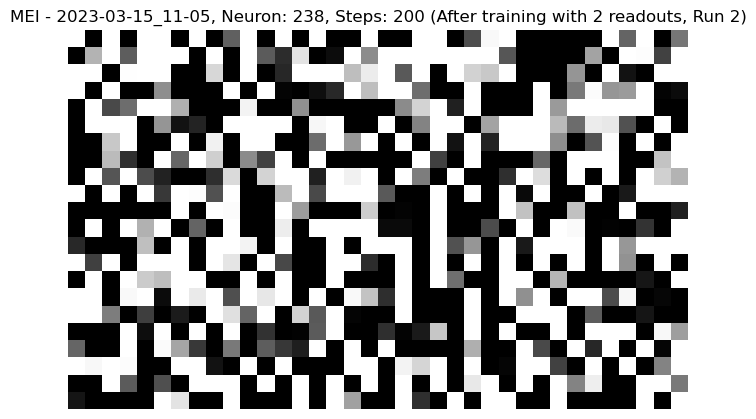

  Generating MEI 240/373: Neuron 239


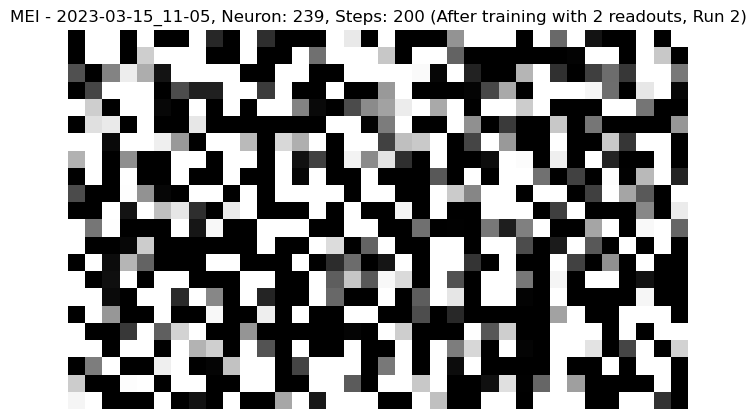

  Generating MEI 241/373: Neuron 240


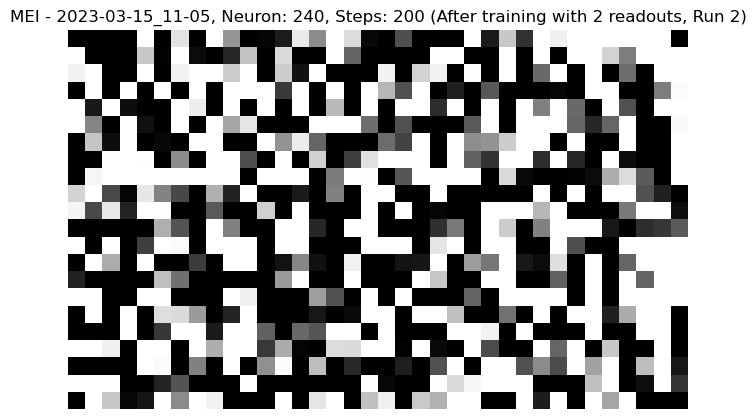

  Generating MEI 242/373: Neuron 241


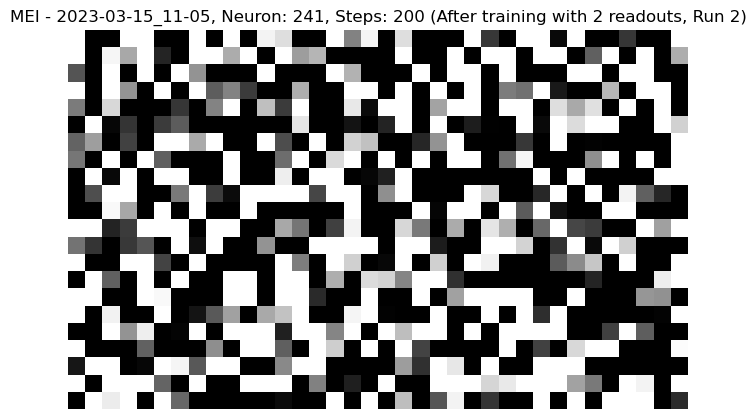

  Generating MEI 243/373: Neuron 242


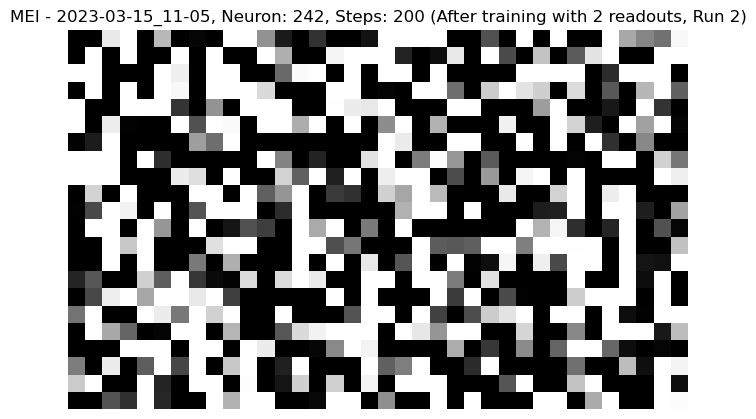

  Generating MEI 244/373: Neuron 243


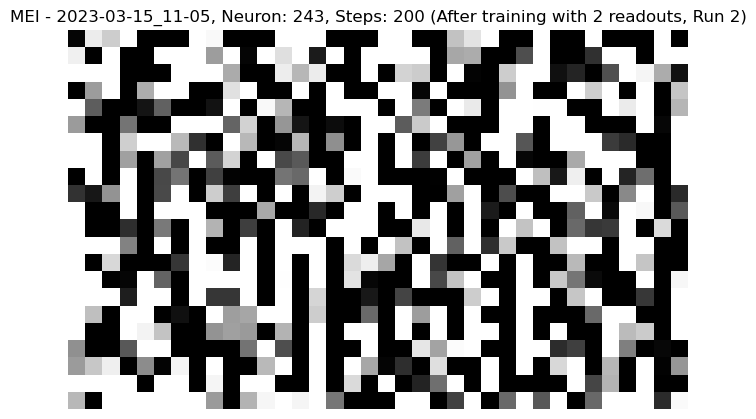

  Generating MEI 245/373: Neuron 244


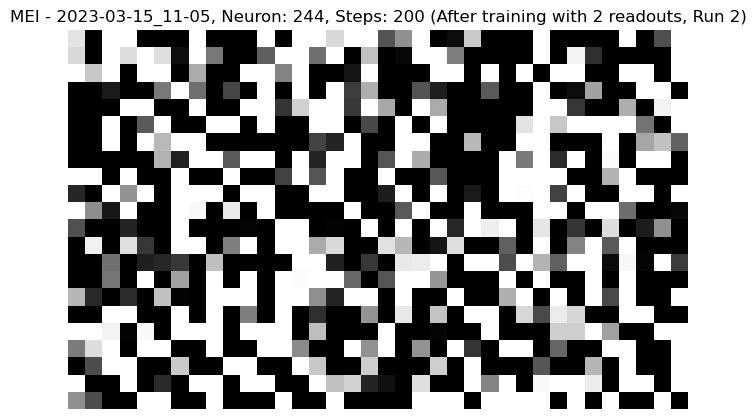

  Generating MEI 246/373: Neuron 245


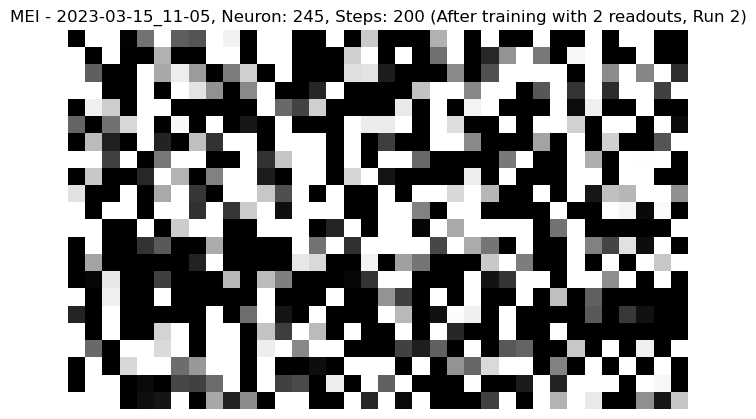

  Generating MEI 247/373: Neuron 246


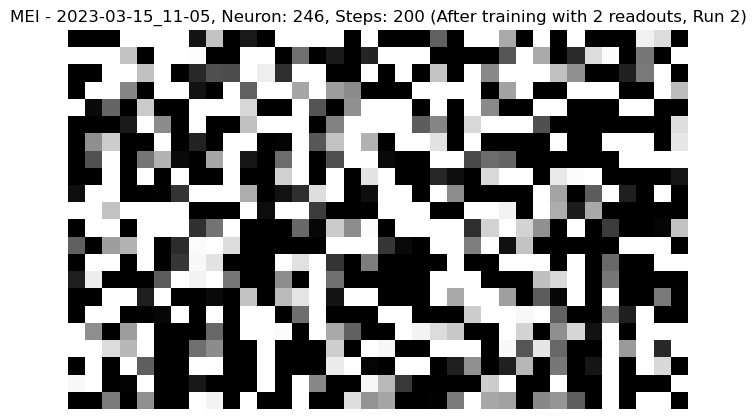

  Generating MEI 248/373: Neuron 247


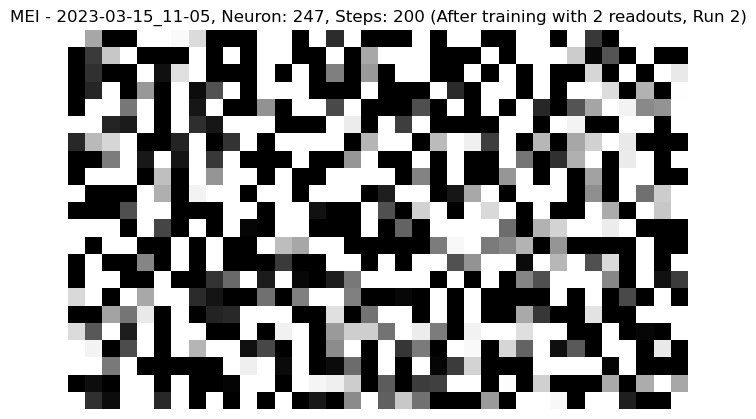

  Generating MEI 249/373: Neuron 248


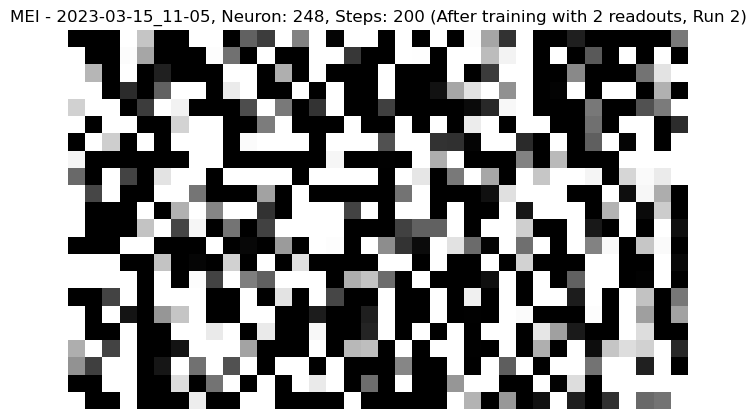

  Generating MEI 250/373: Neuron 249


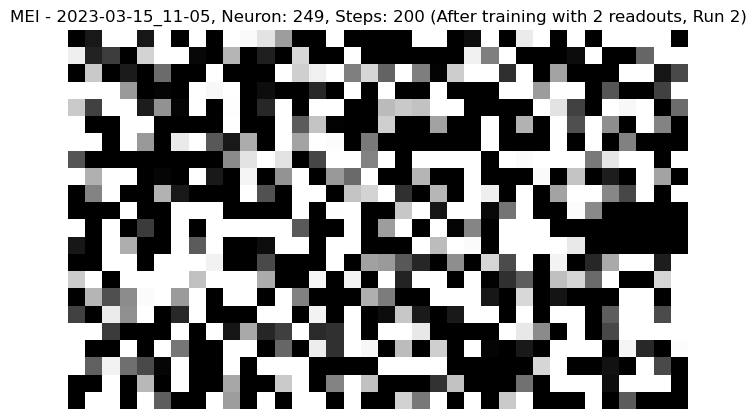

  Generating MEI 251/373: Neuron 250


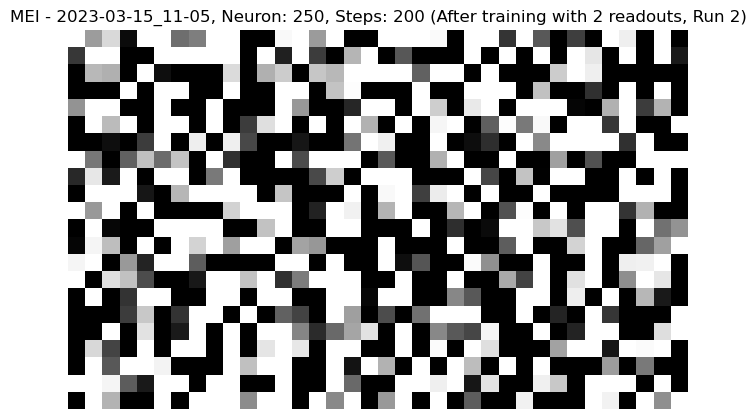

  Generating MEI 252/373: Neuron 251


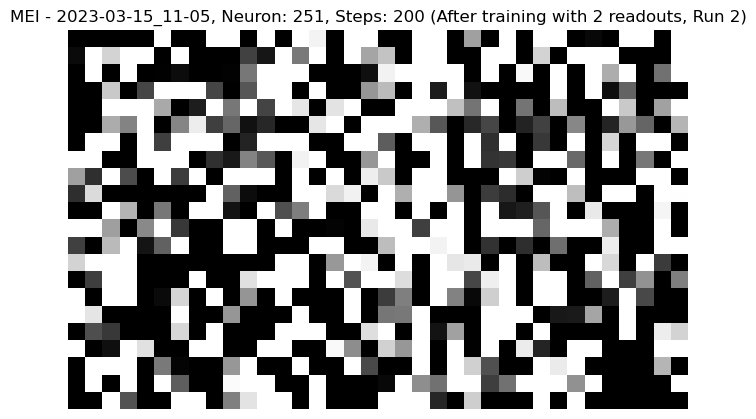

  Generating MEI 253/373: Neuron 252


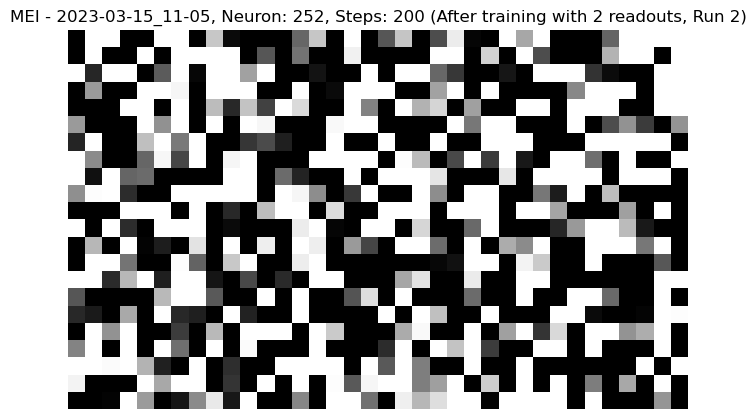

  Generating MEI 254/373: Neuron 253


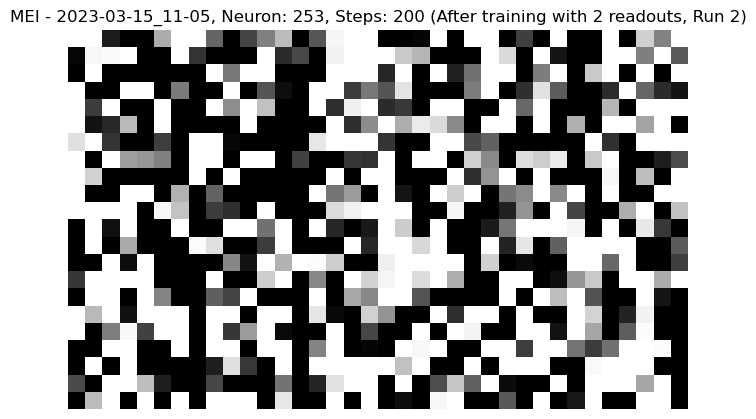

  Generating MEI 255/373: Neuron 254


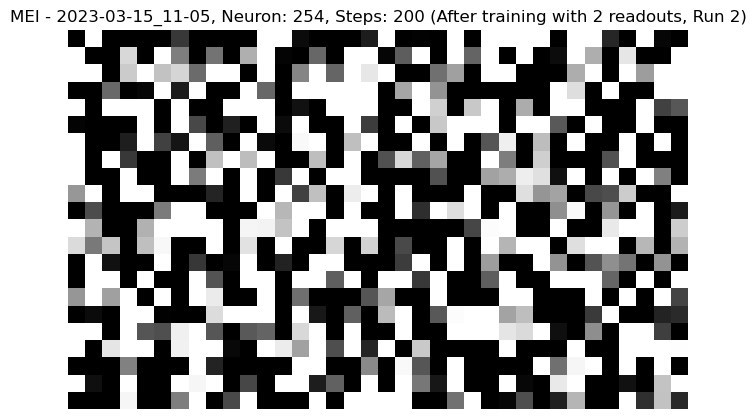

  Generating MEI 256/373: Neuron 255


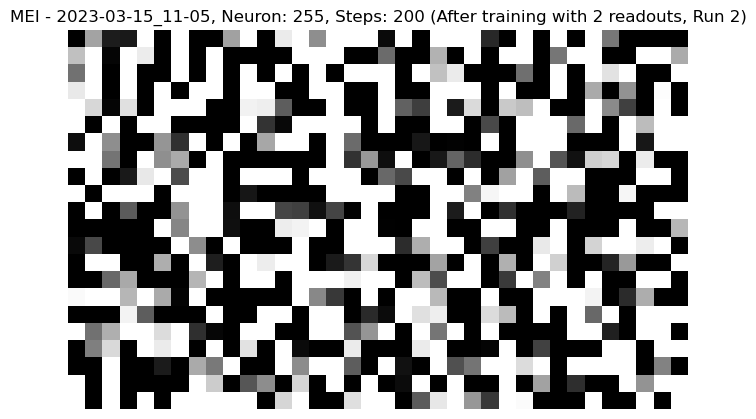

  Generating MEI 257/373: Neuron 256


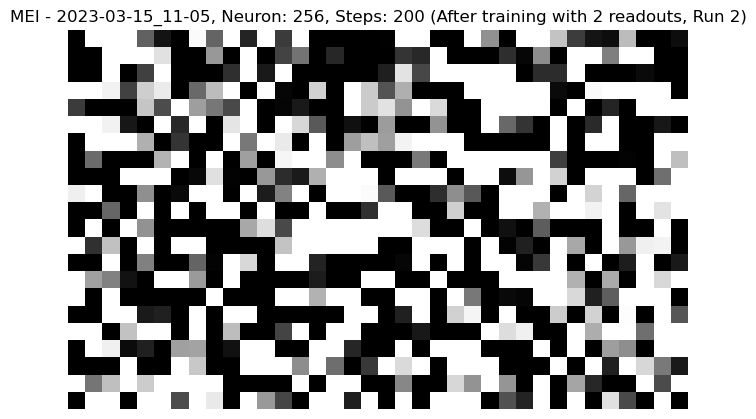

  Generating MEI 258/373: Neuron 257


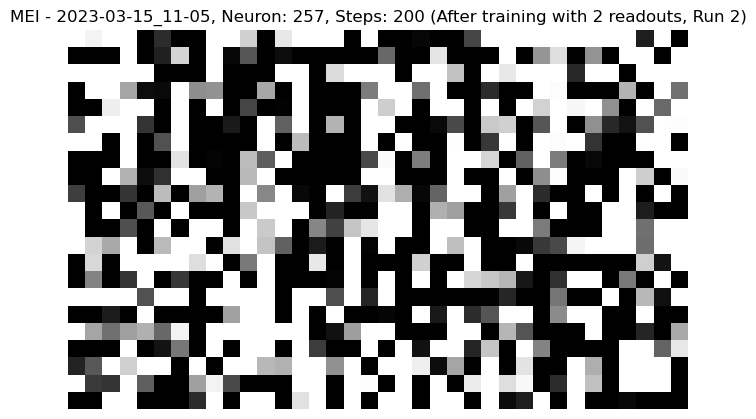

  Generating MEI 259/373: Neuron 258


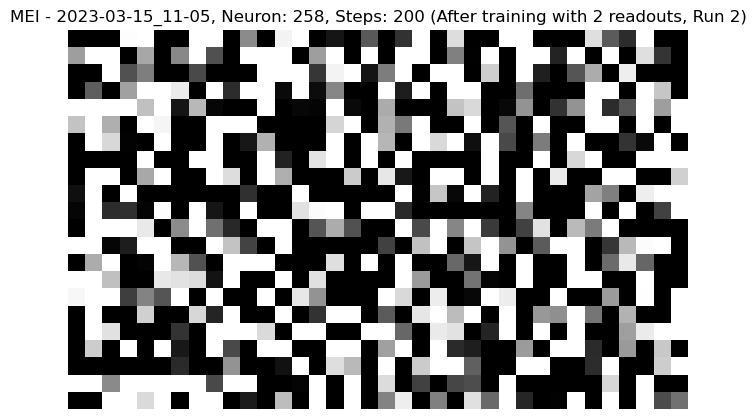

  Generating MEI 260/373: Neuron 259


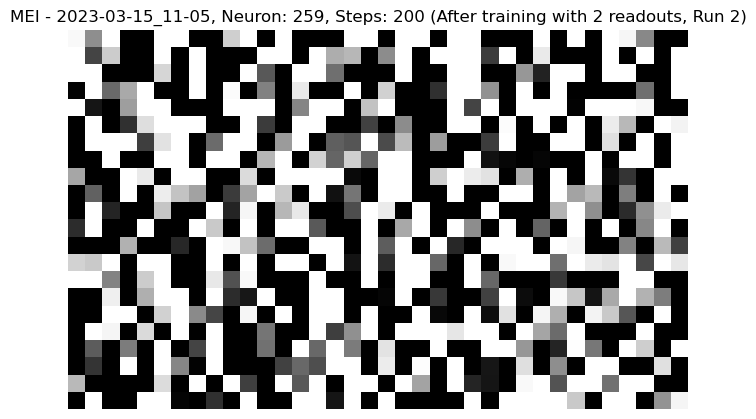

  Generating MEI 261/373: Neuron 260


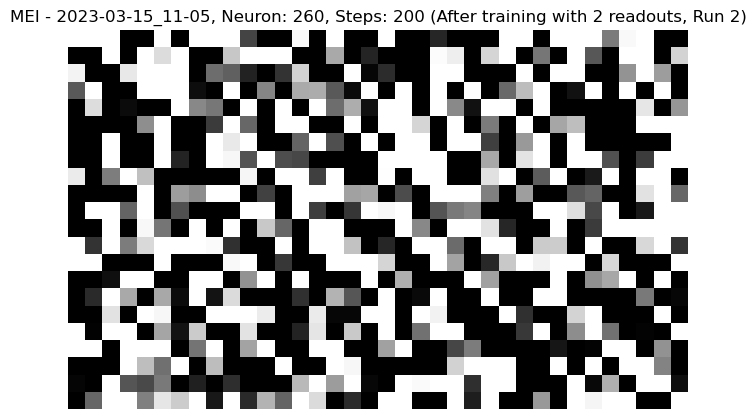

  Generating MEI 262/373: Neuron 261


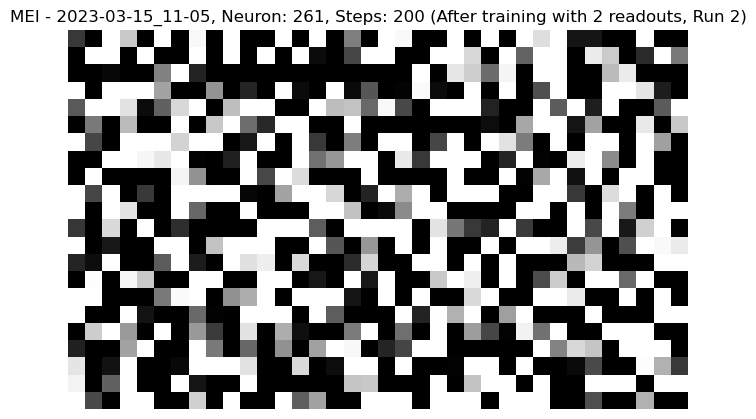

  Generating MEI 263/373: Neuron 262


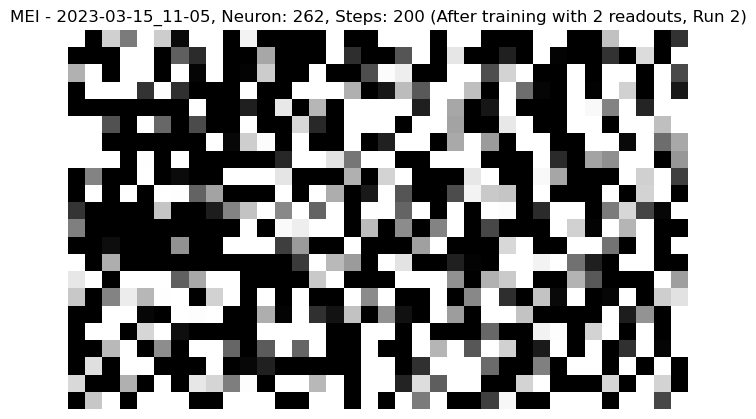

  Generating MEI 264/373: Neuron 263


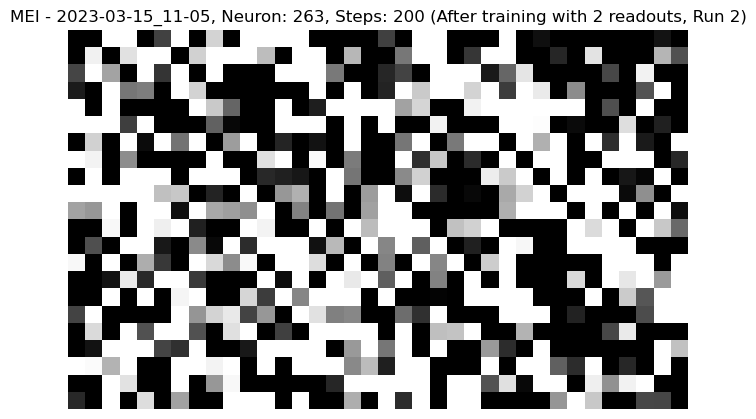

  Generating MEI 265/373: Neuron 264


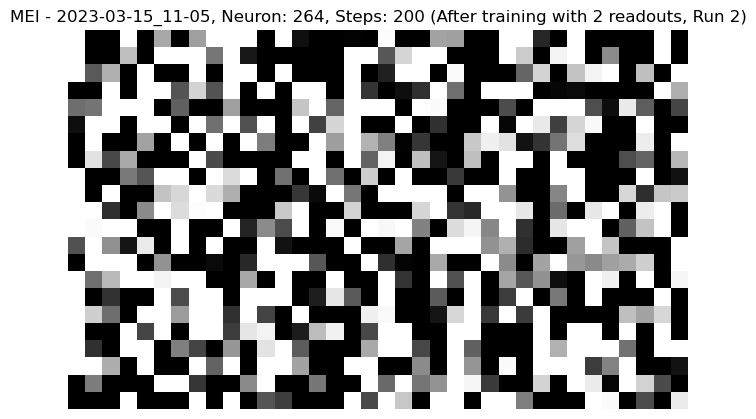

  Generating MEI 266/373: Neuron 265


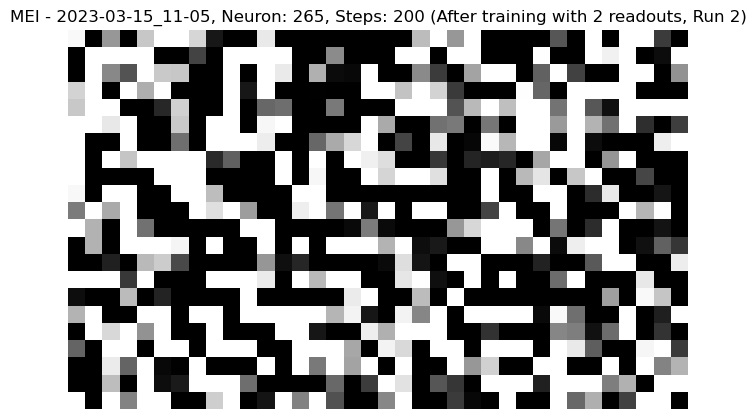

  Generating MEI 267/373: Neuron 266


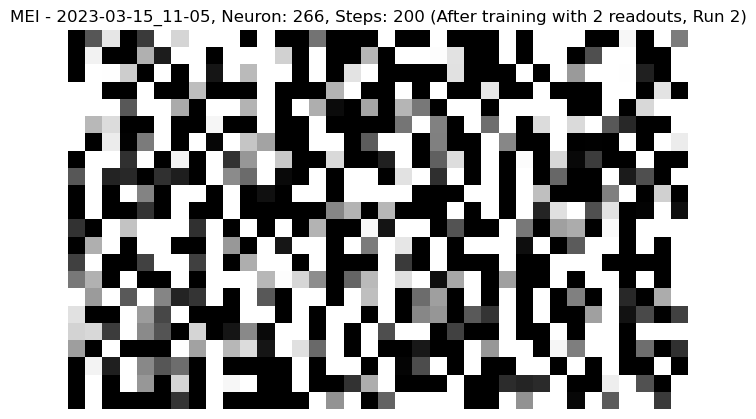

  Generating MEI 268/373: Neuron 267


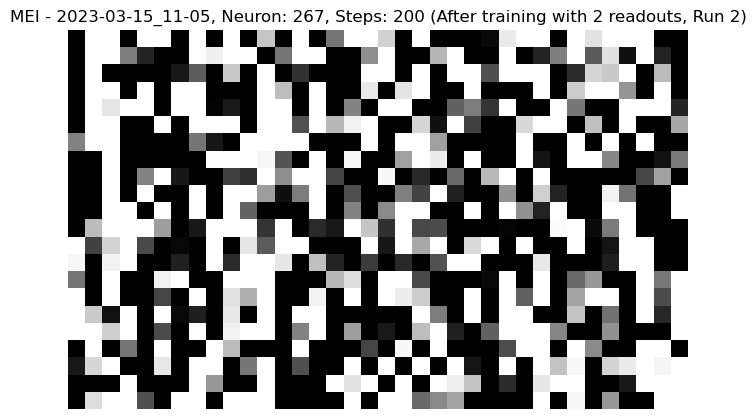

  Generating MEI 269/373: Neuron 268


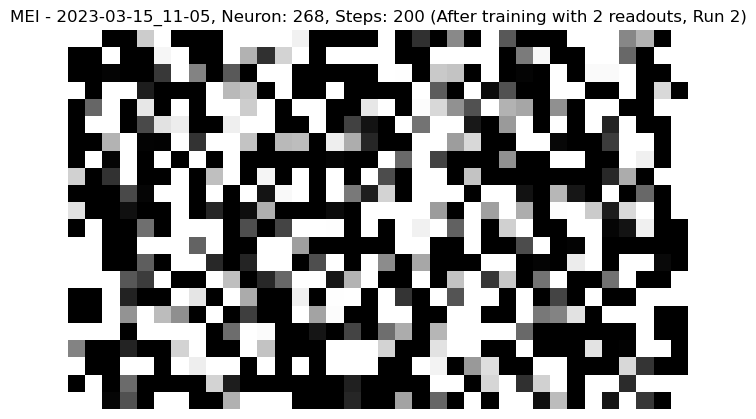

  Generating MEI 270/373: Neuron 269


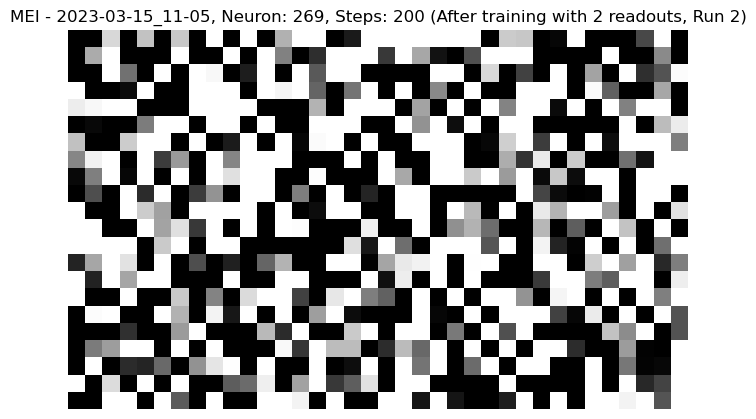

  Generating MEI 271/373: Neuron 270


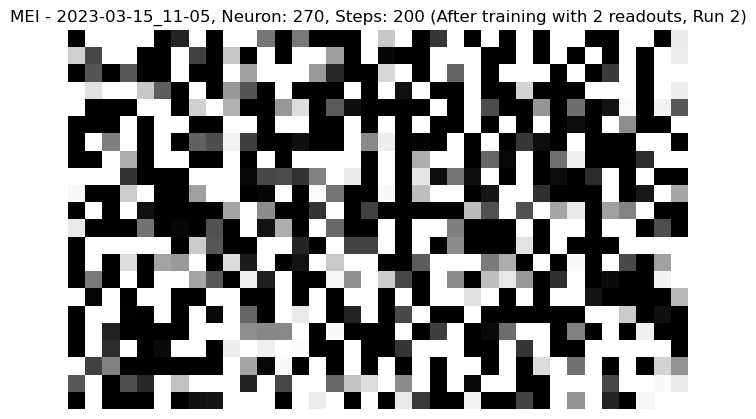

  Generating MEI 272/373: Neuron 271


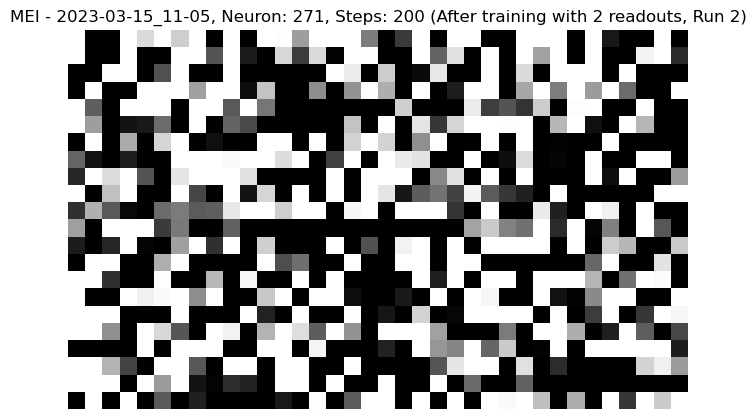

  Generating MEI 273/373: Neuron 272


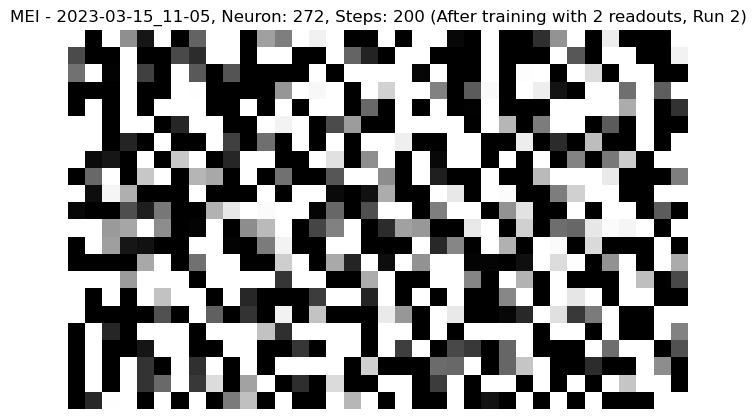

  Generating MEI 274/373: Neuron 273


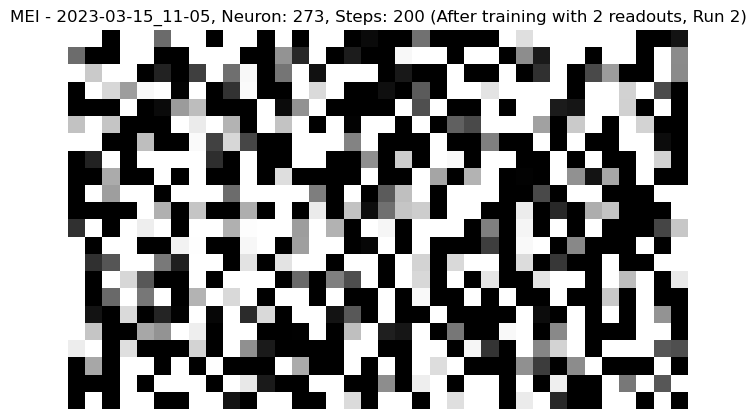

  Generating MEI 275/373: Neuron 274


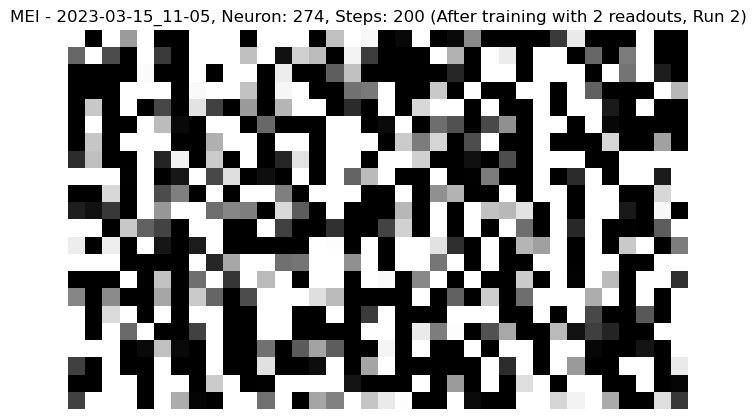

  Generating MEI 276/373: Neuron 275


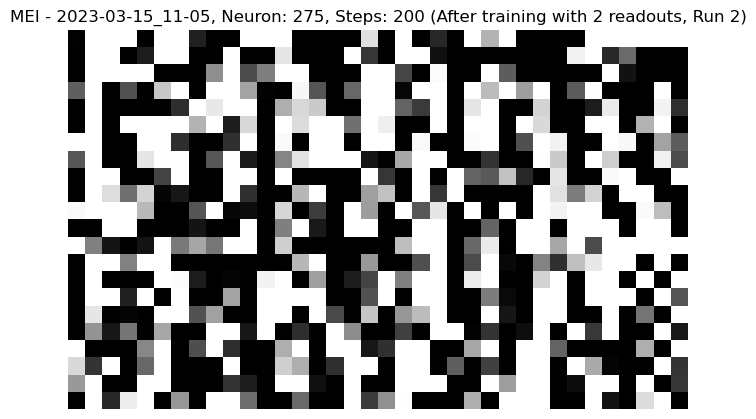

  Generating MEI 277/373: Neuron 276


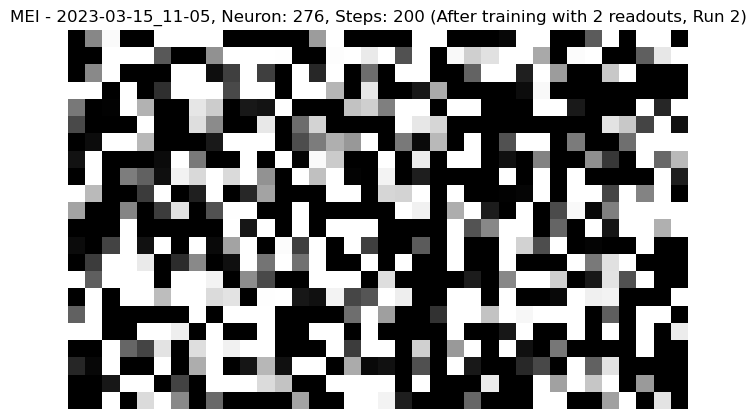

  Generating MEI 278/373: Neuron 277


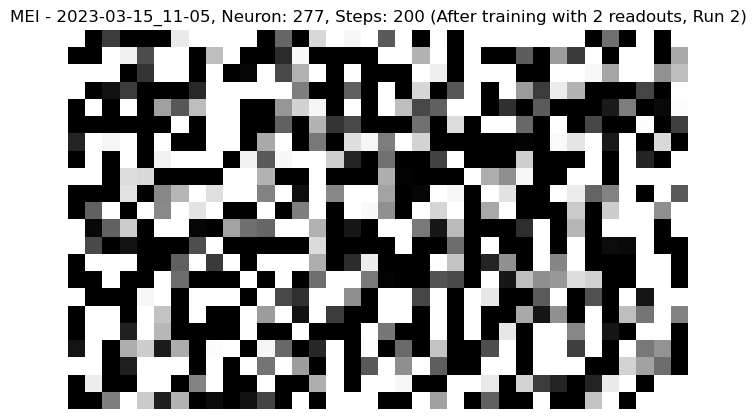

  Generating MEI 279/373: Neuron 278


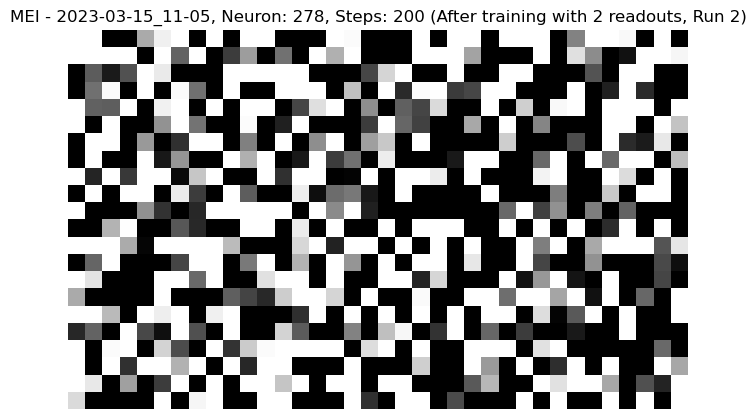

  Generating MEI 280/373: Neuron 279


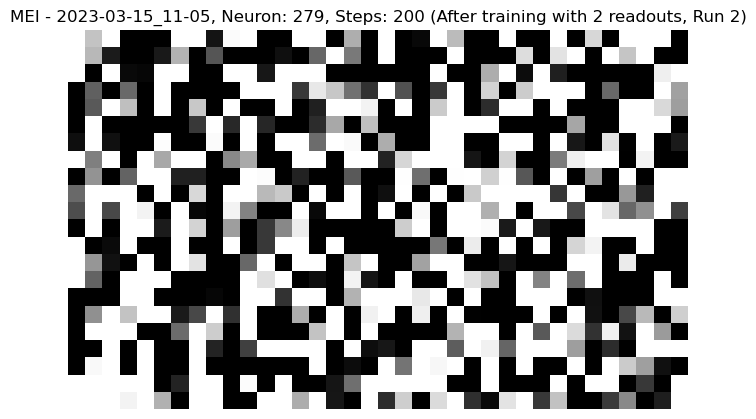

  Generating MEI 281/373: Neuron 280


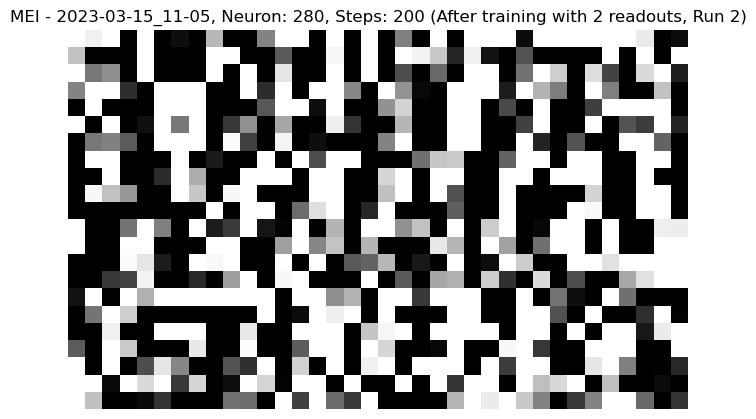

  Generating MEI 282/373: Neuron 281


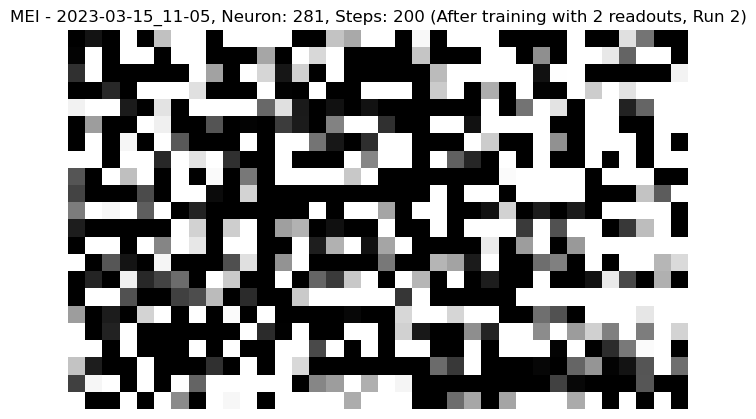

  Generating MEI 283/373: Neuron 282


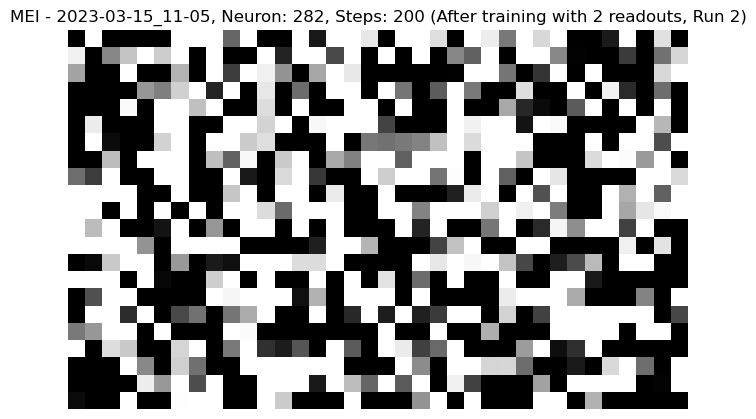

  Generating MEI 284/373: Neuron 283


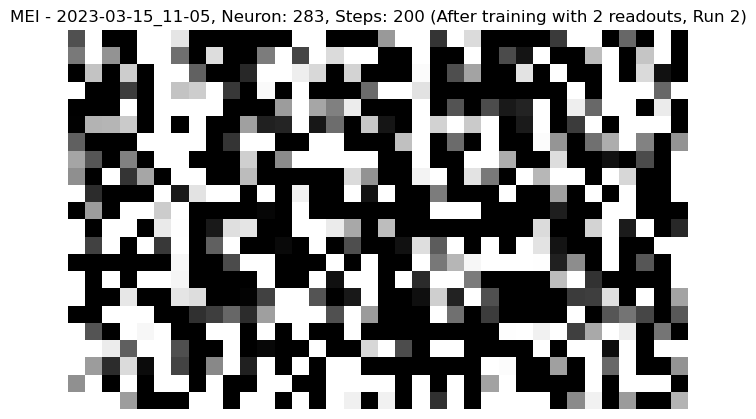

  Generating MEI 285/373: Neuron 284


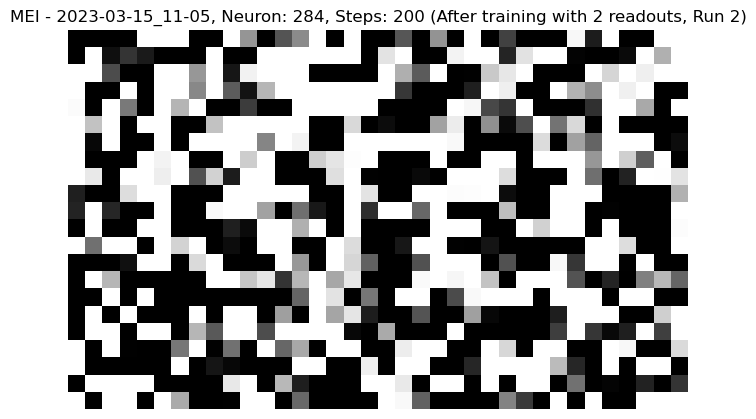

  Generating MEI 286/373: Neuron 285


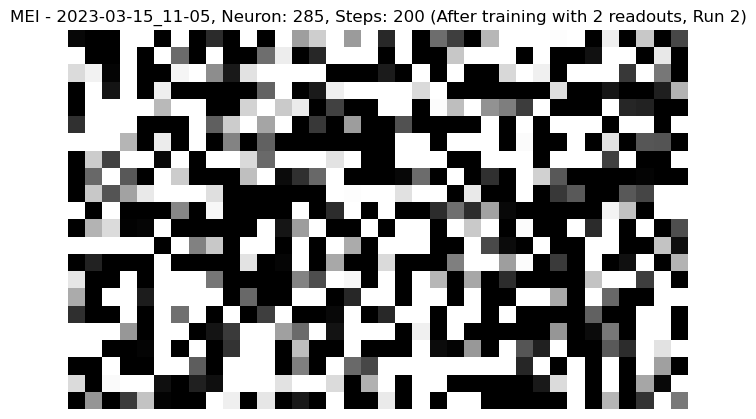

  Generating MEI 287/373: Neuron 286


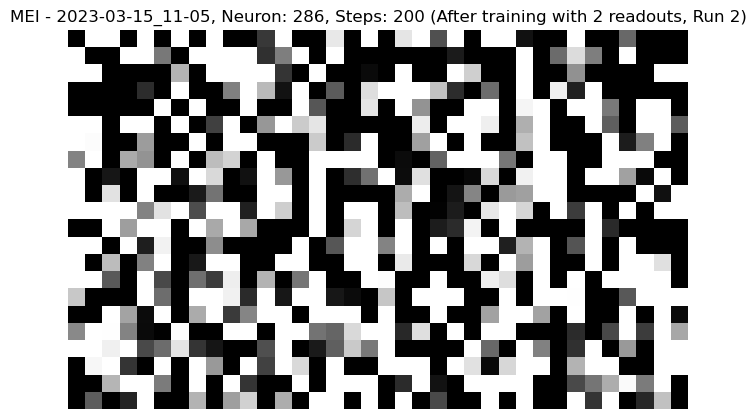

  Generating MEI 288/373: Neuron 287


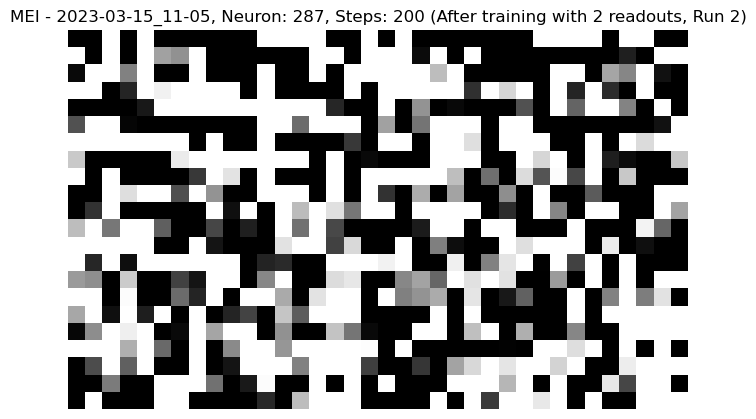

  Generating MEI 289/373: Neuron 288


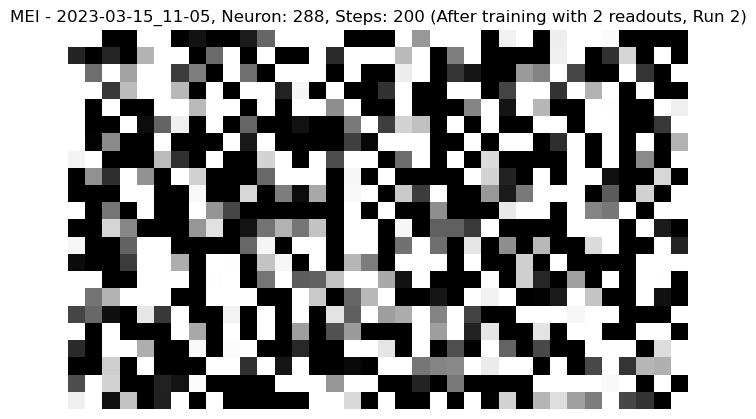

  Generating MEI 290/373: Neuron 289


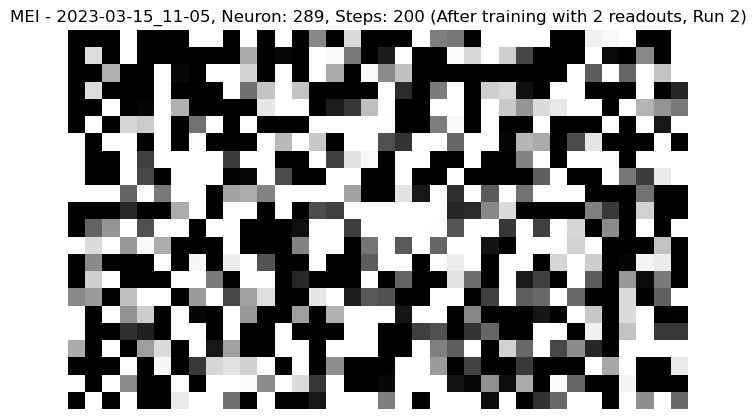

  Generating MEI 291/373: Neuron 290


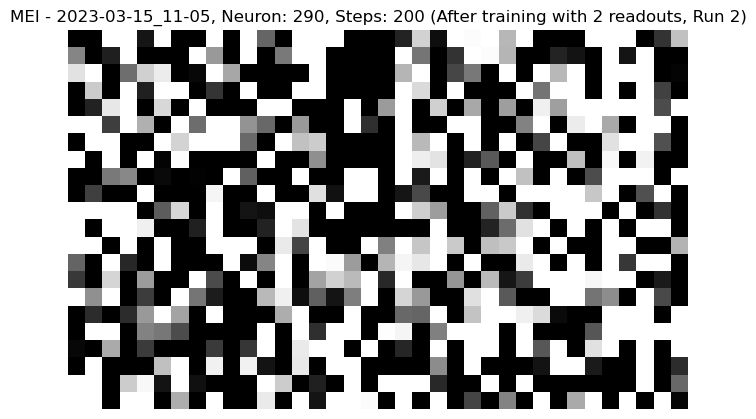

  Generating MEI 292/373: Neuron 291


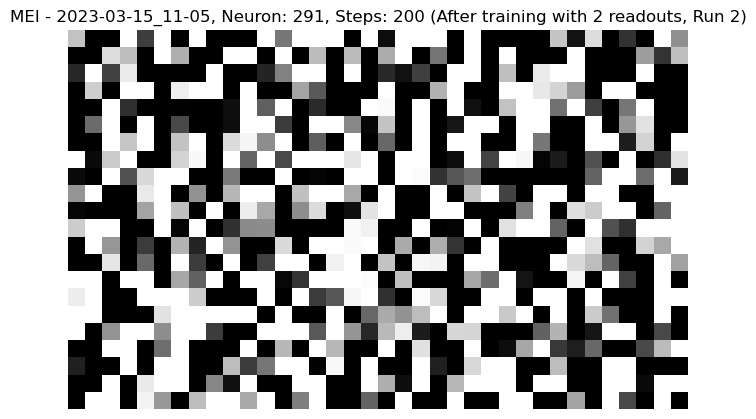

  Generating MEI 293/373: Neuron 292


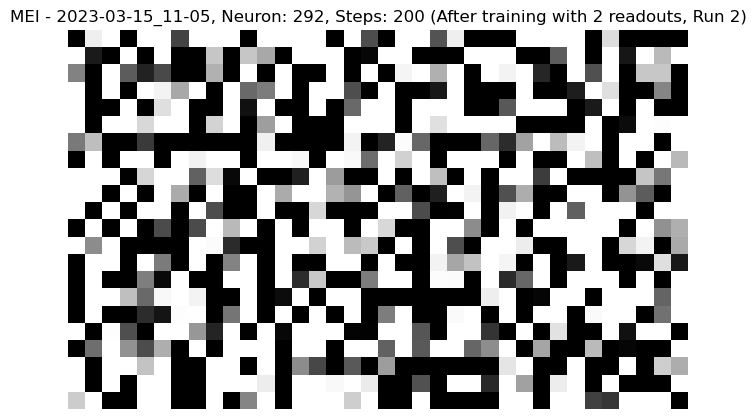

  Generating MEI 294/373: Neuron 293


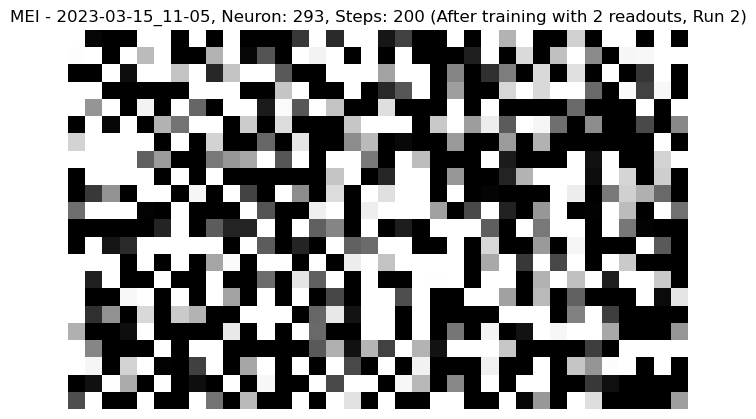

  Generating MEI 295/373: Neuron 294


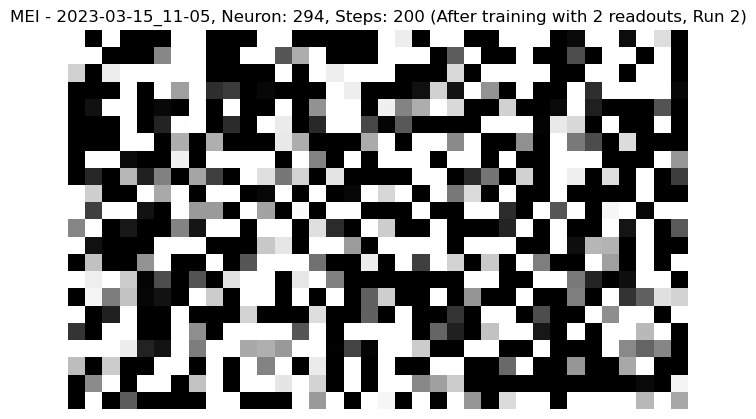

  Generating MEI 296/373: Neuron 295


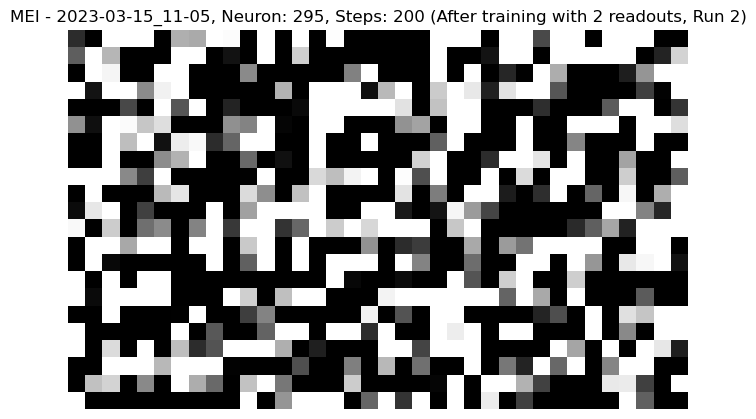

  Generating MEI 297/373: Neuron 296


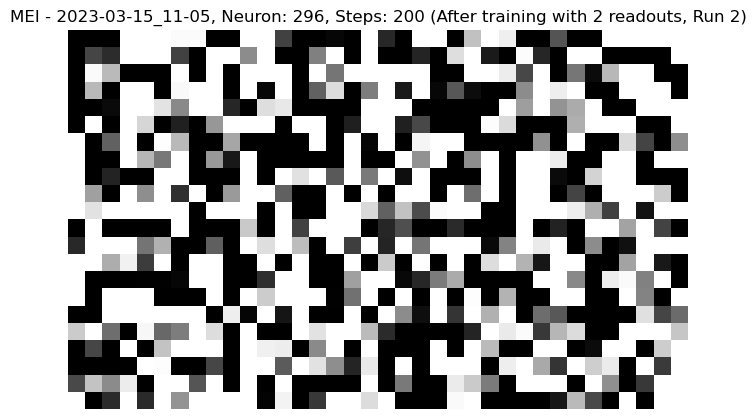

  Generating MEI 298/373: Neuron 297


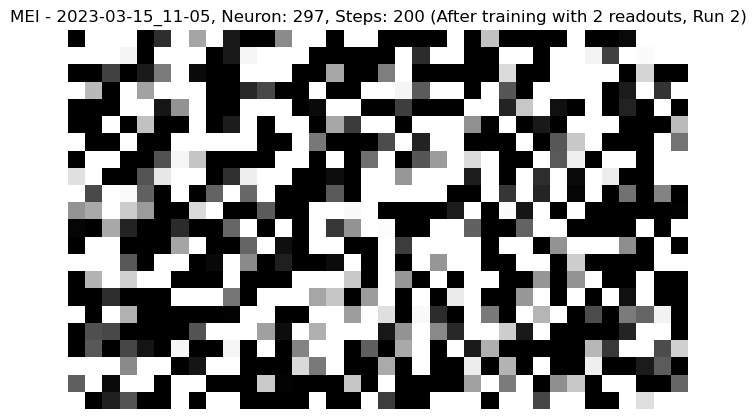

  Generating MEI 299/373: Neuron 298


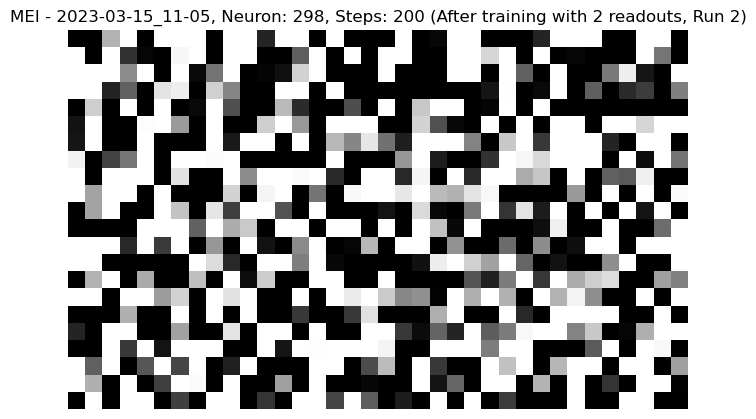

  Generating MEI 300/373: Neuron 299


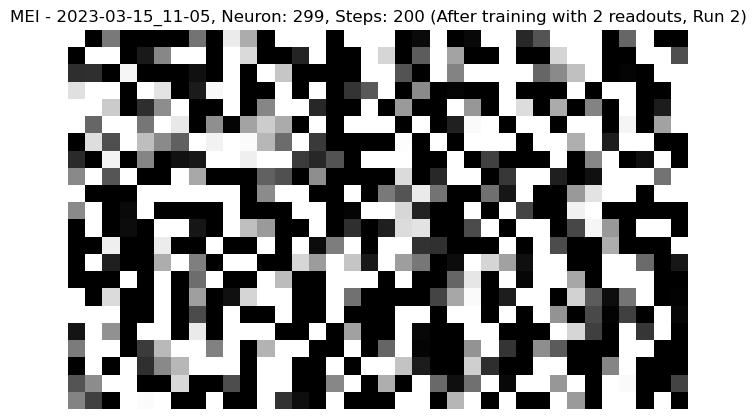

  Generating MEI 301/373: Neuron 300


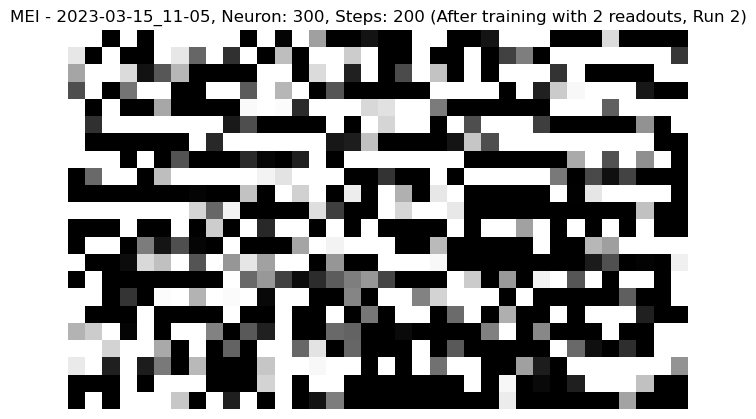

  Generating MEI 302/373: Neuron 301


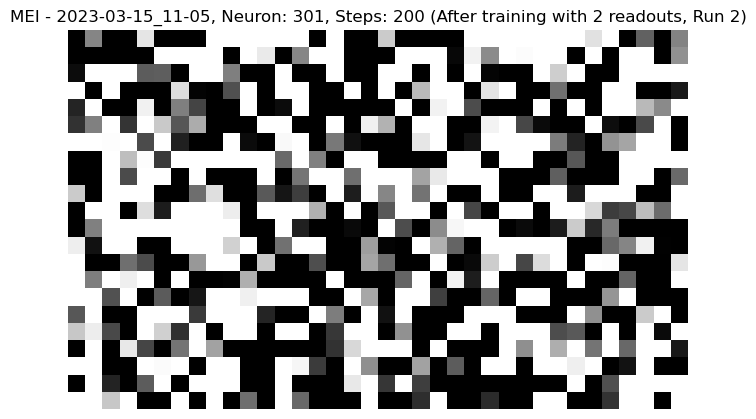

  Generating MEI 303/373: Neuron 302


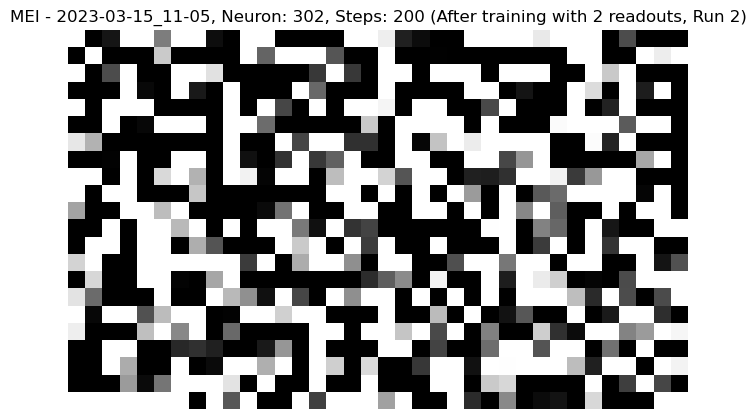

  Generating MEI 304/373: Neuron 303


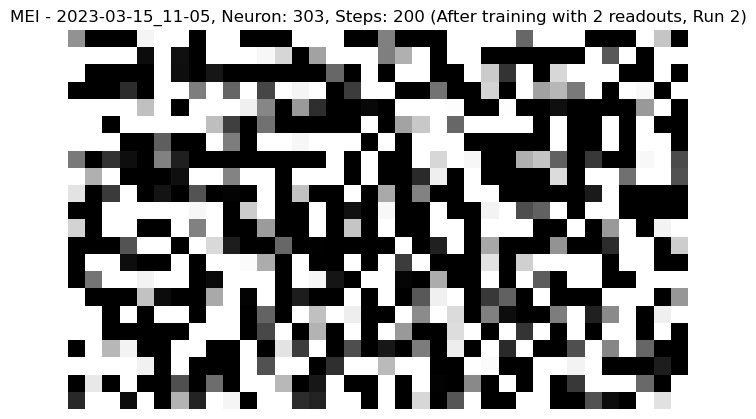

  Generating MEI 305/373: Neuron 304


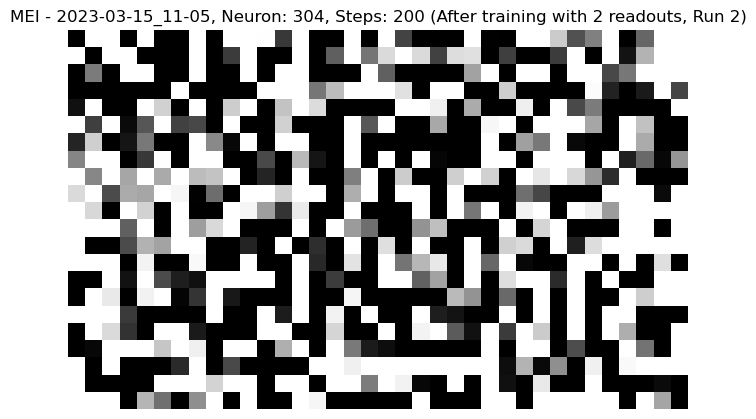

  Generating MEI 306/373: Neuron 305


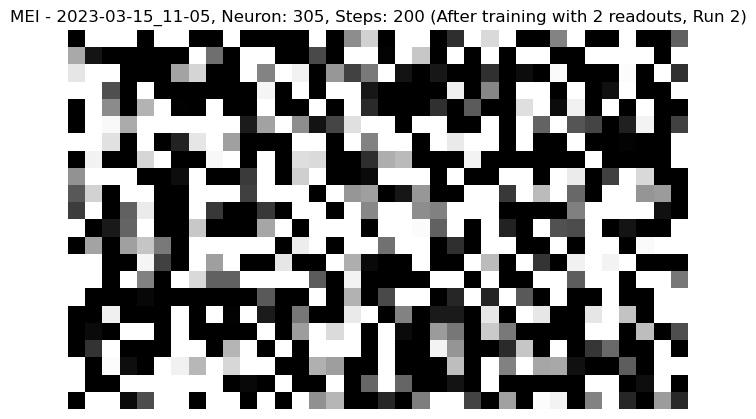

  Generating MEI 307/373: Neuron 306


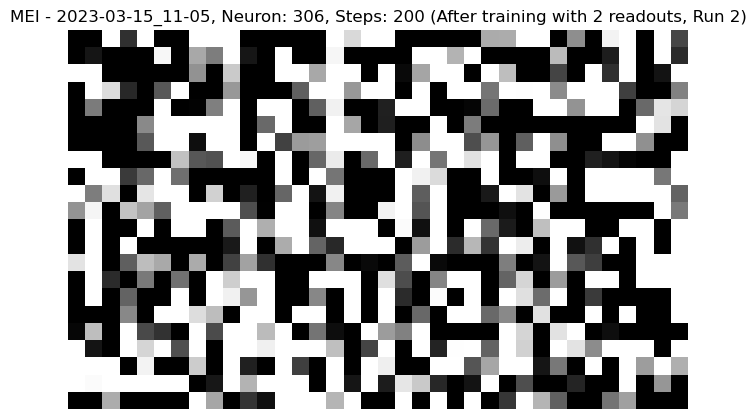

  Generating MEI 308/373: Neuron 307


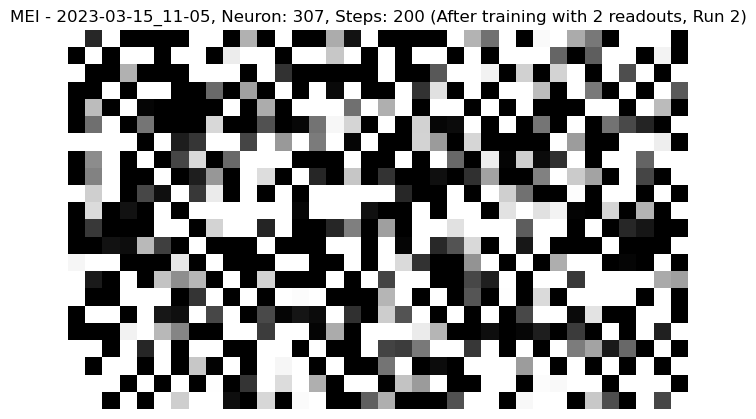

  Generating MEI 309/373: Neuron 308


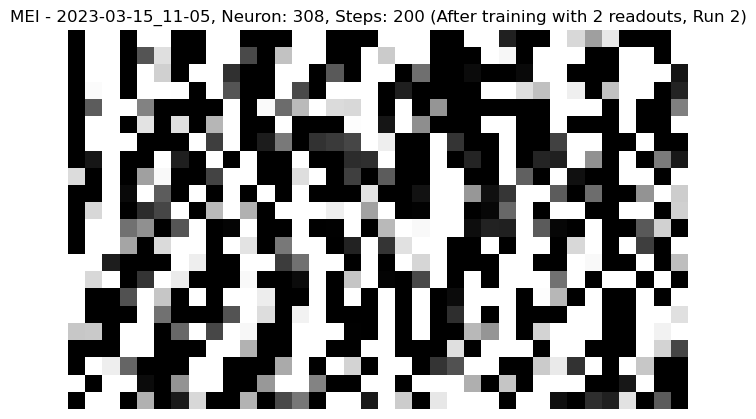

  Generating MEI 310/373: Neuron 309


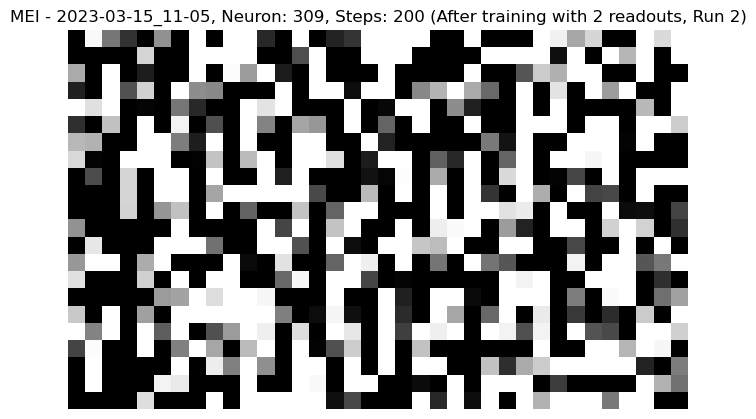

  Generating MEI 311/373: Neuron 310


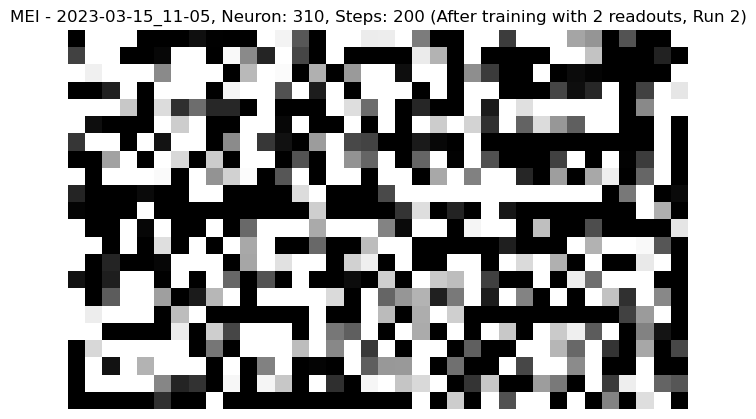

  Generating MEI 312/373: Neuron 311


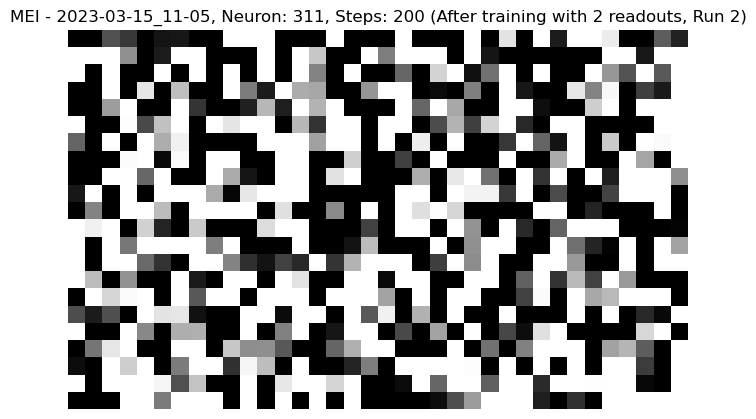

  Generating MEI 313/373: Neuron 312


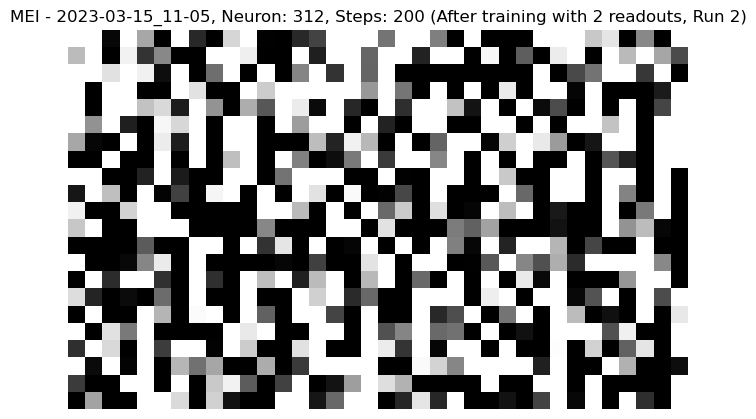

  Generating MEI 314/373: Neuron 313


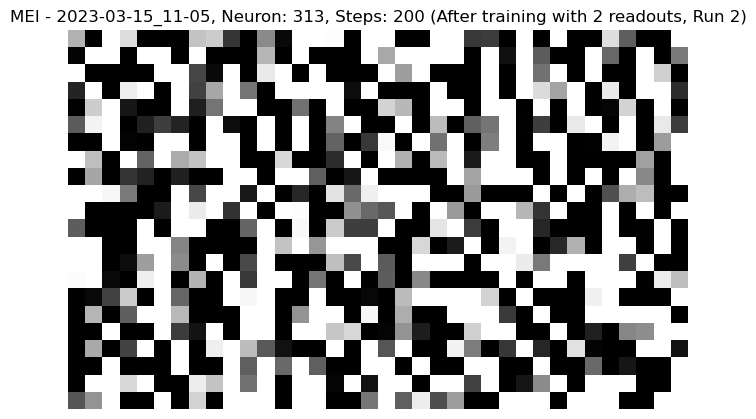

  Generating MEI 315/373: Neuron 314


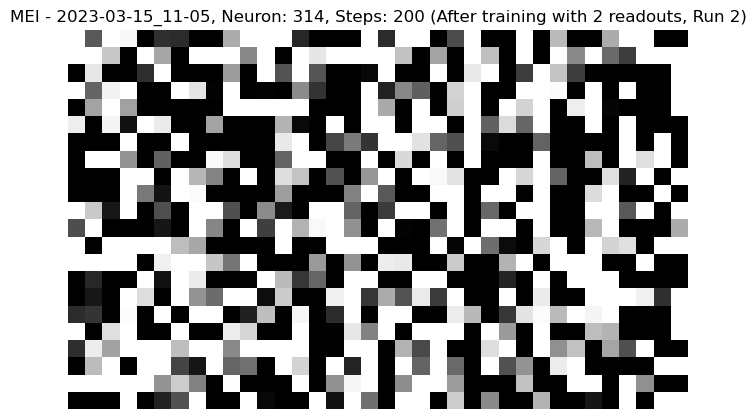

  Generating MEI 316/373: Neuron 315


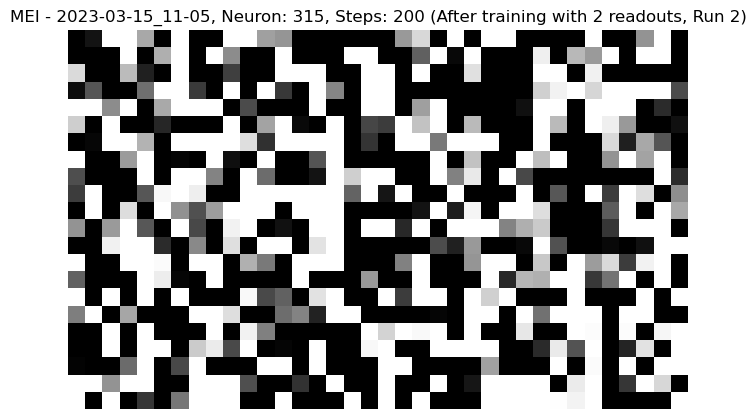

  Generating MEI 317/373: Neuron 316


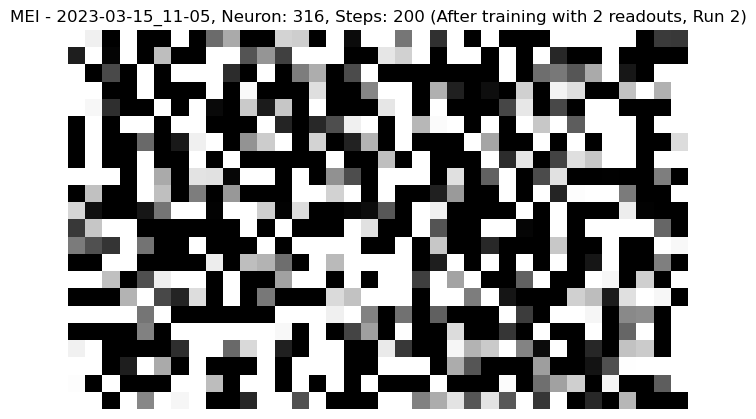

  Generating MEI 318/373: Neuron 317


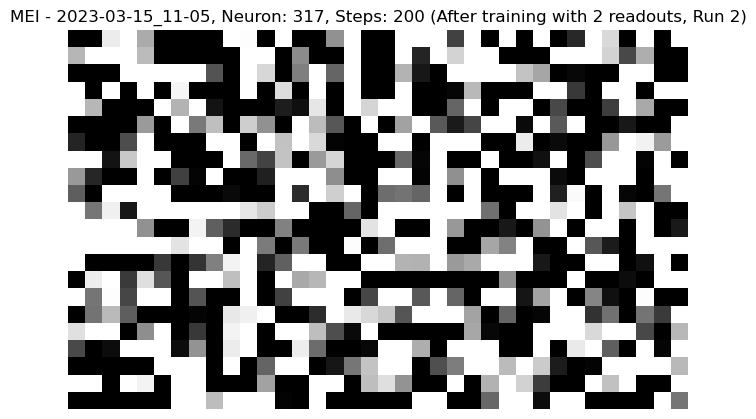

  Generating MEI 319/373: Neuron 318


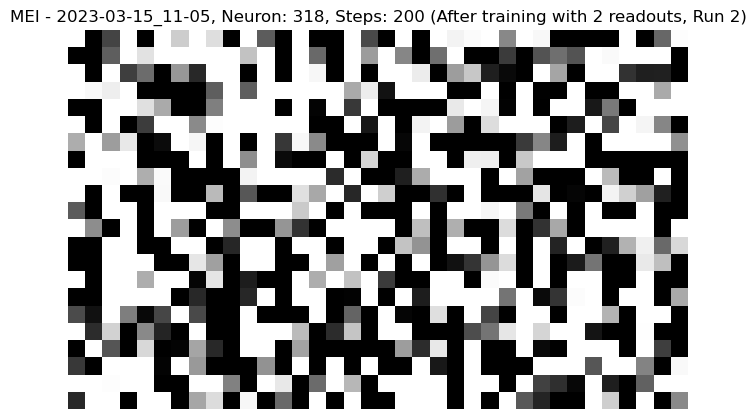

  Generating MEI 320/373: Neuron 319


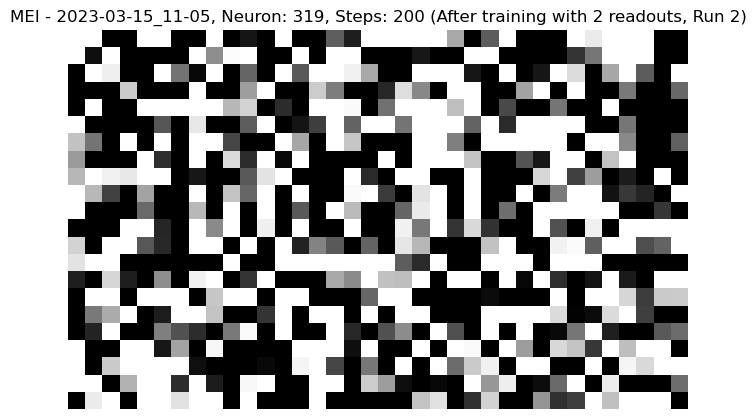

  Generating MEI 321/373: Neuron 320


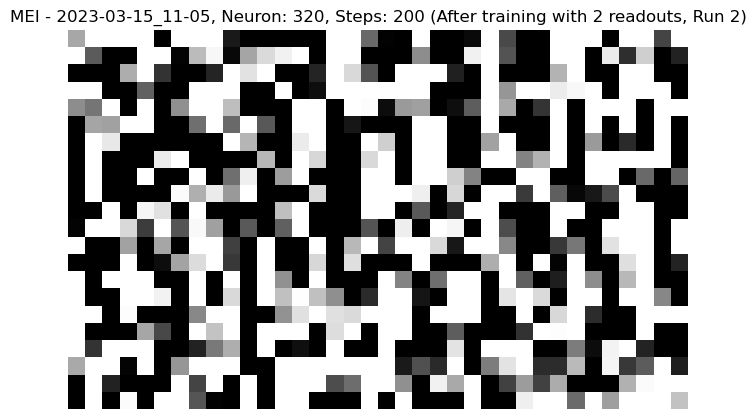

  Generating MEI 322/373: Neuron 321


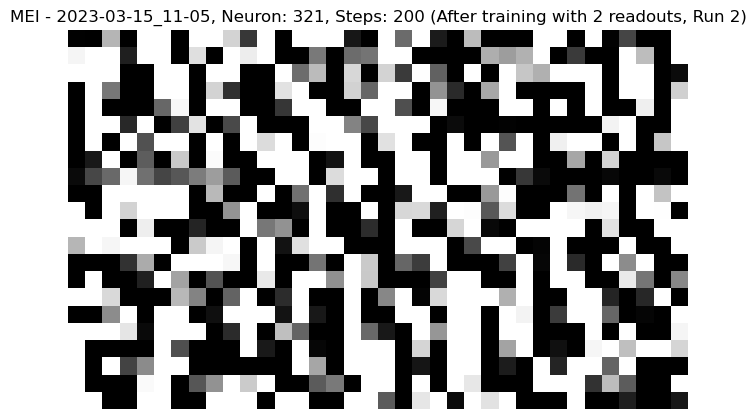

  Generating MEI 323/373: Neuron 322


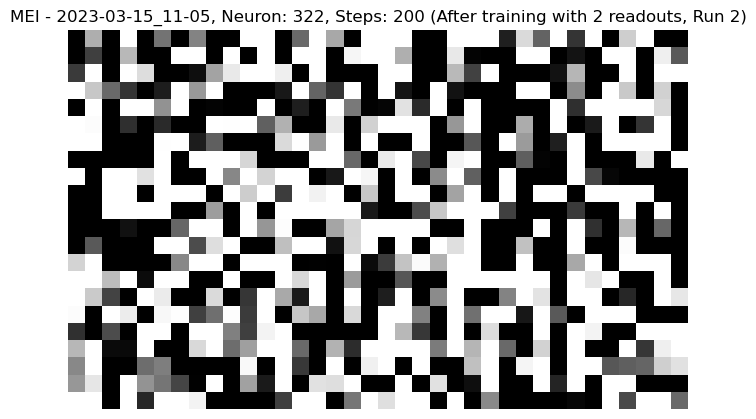

  Generating MEI 324/373: Neuron 323


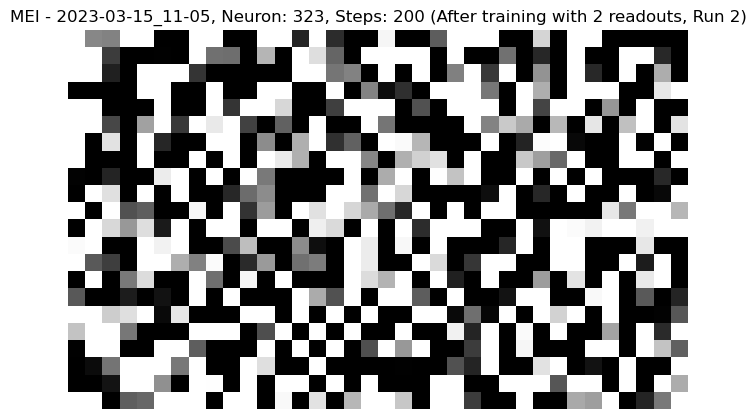

  Generating MEI 325/373: Neuron 324


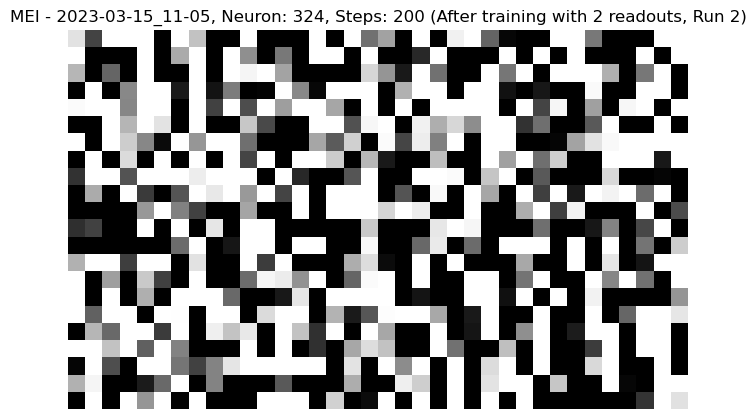

  Generating MEI 326/373: Neuron 325


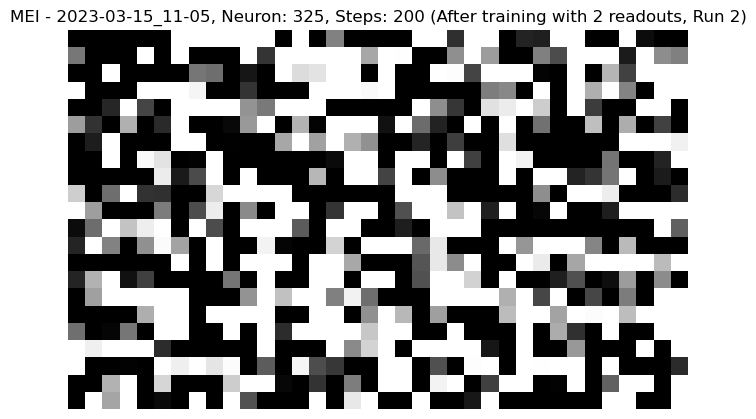

  Generating MEI 327/373: Neuron 326


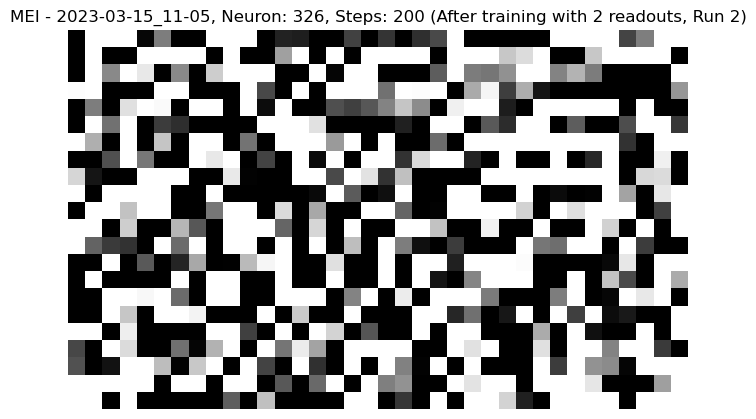

  Generating MEI 328/373: Neuron 327


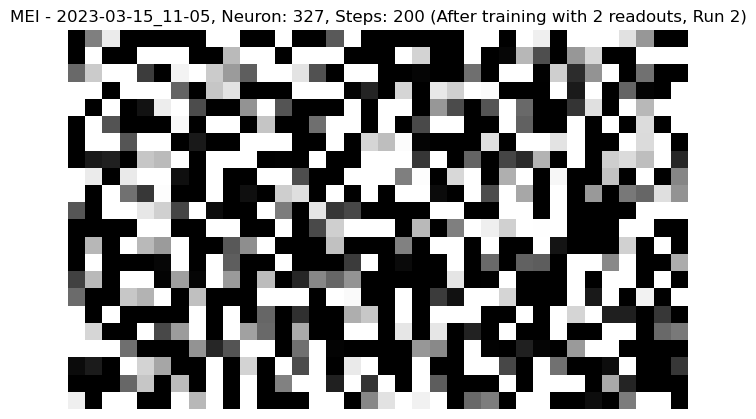

  Generating MEI 329/373: Neuron 328


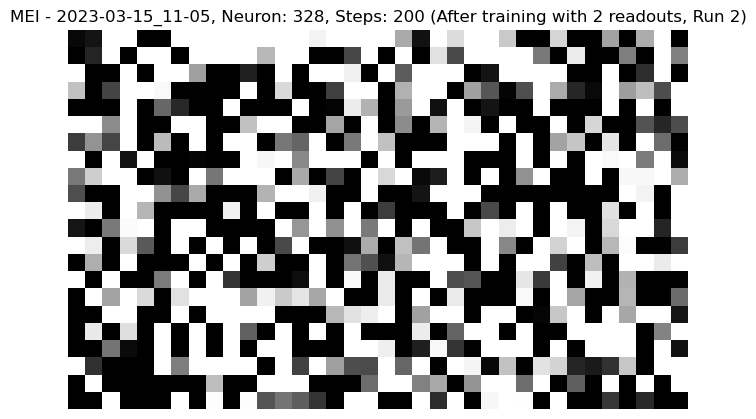

  Generating MEI 330/373: Neuron 329


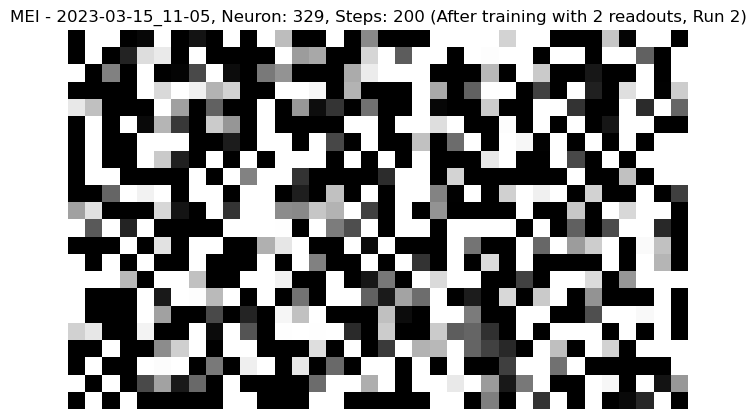

  Generating MEI 331/373: Neuron 330


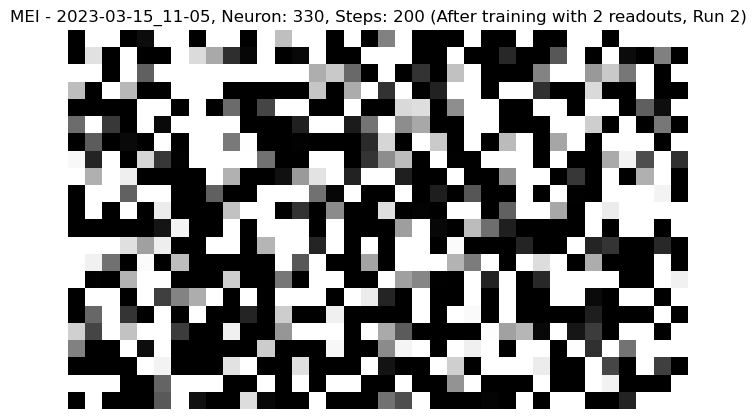

  Generating MEI 332/373: Neuron 331


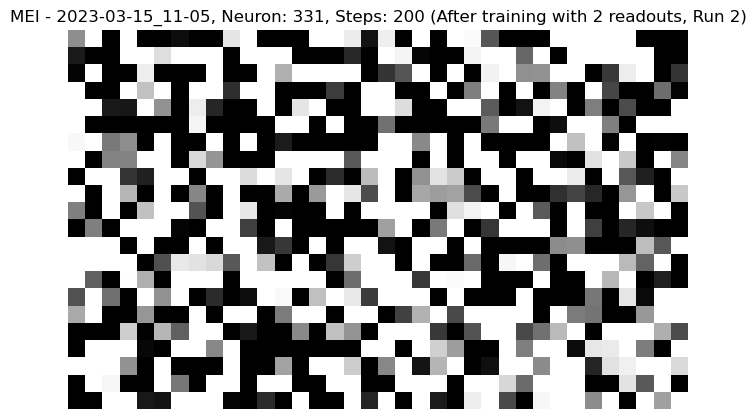

  Generating MEI 333/373: Neuron 332


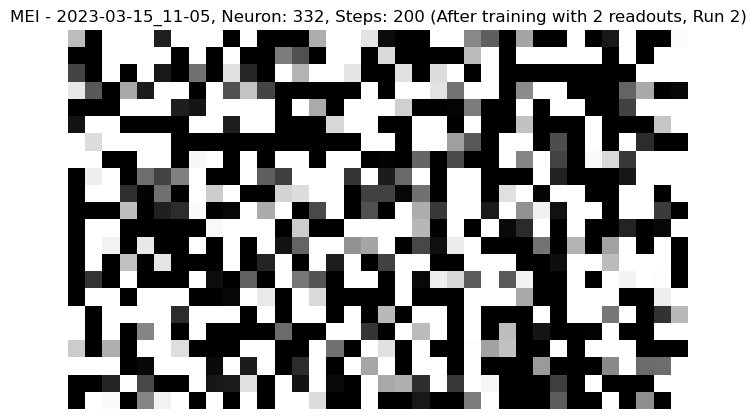

  Generating MEI 334/373: Neuron 333


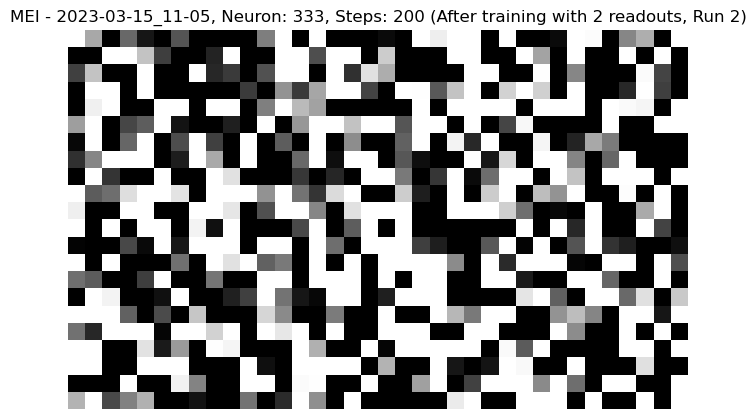

  Generating MEI 335/373: Neuron 334


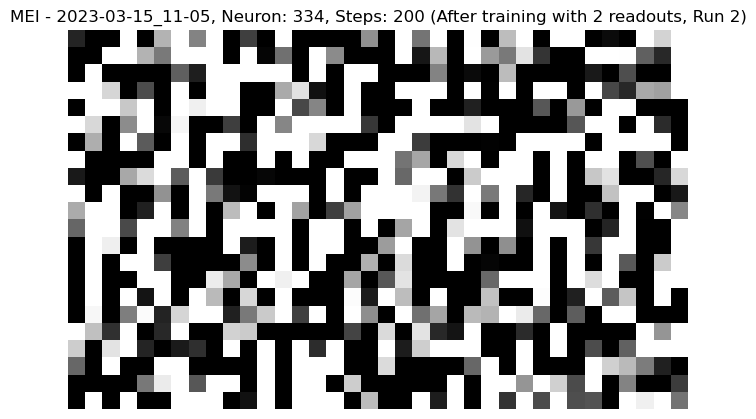

  Generating MEI 336/373: Neuron 335


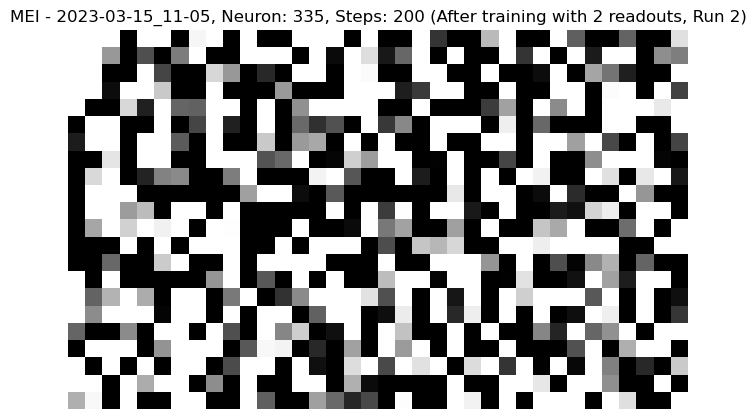

  Generating MEI 337/373: Neuron 336


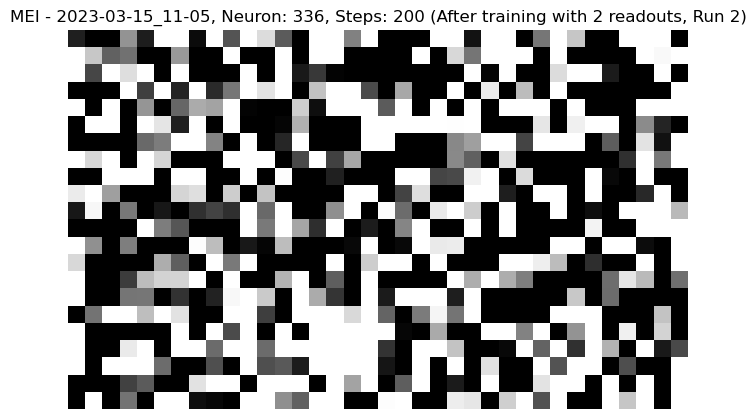

  Generating MEI 338/373: Neuron 337


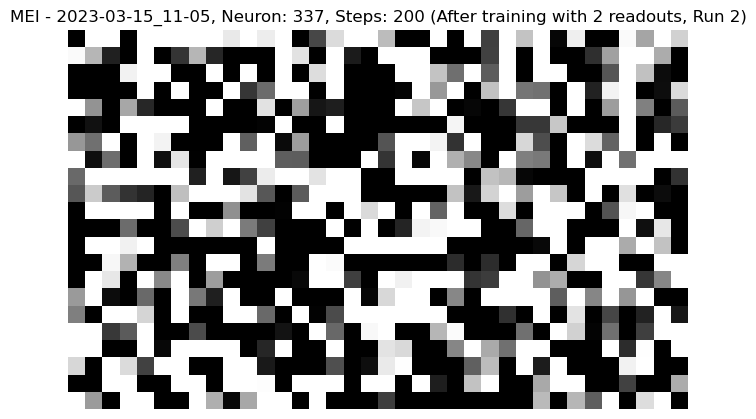

  Generating MEI 339/373: Neuron 338


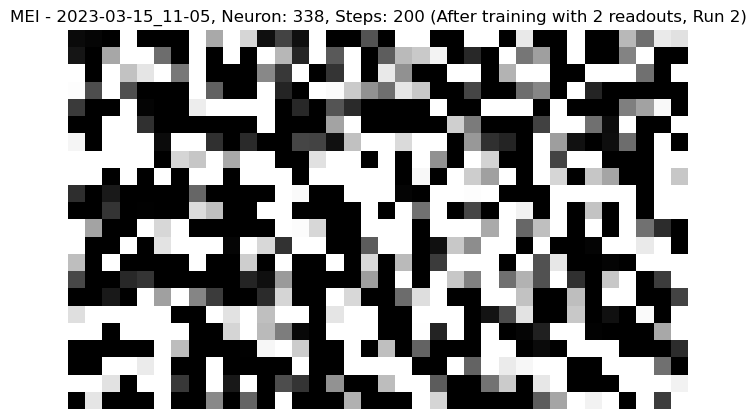

  Generating MEI 340/373: Neuron 339


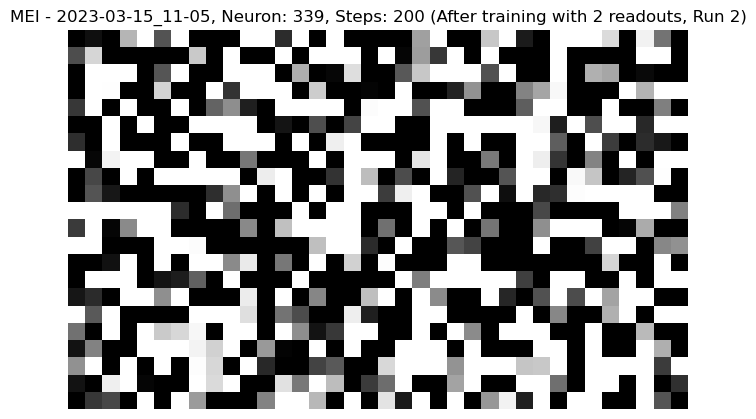

  Generating MEI 341/373: Neuron 340


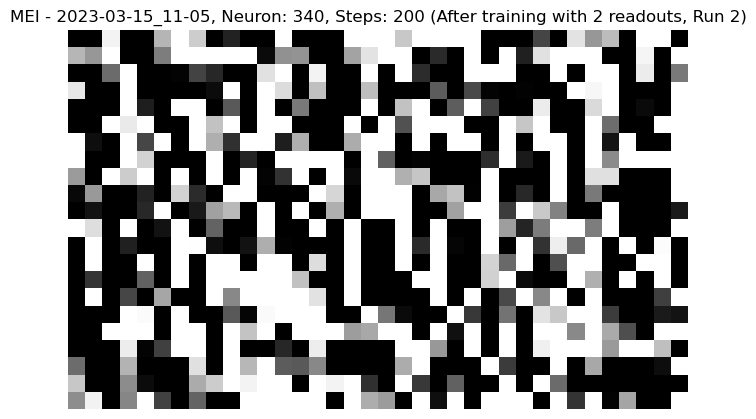

  Generating MEI 342/373: Neuron 341


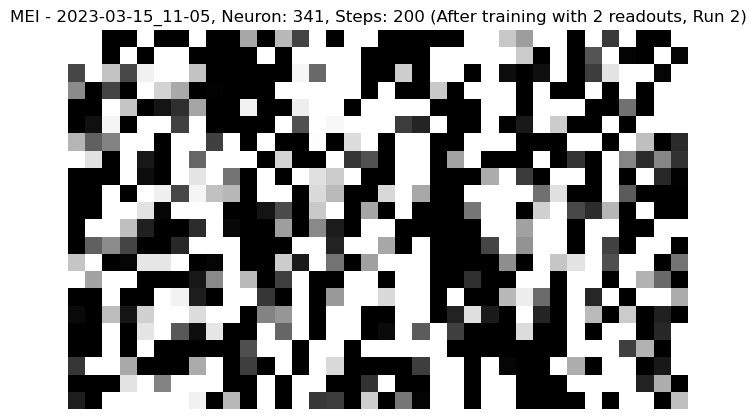

  Generating MEI 343/373: Neuron 342


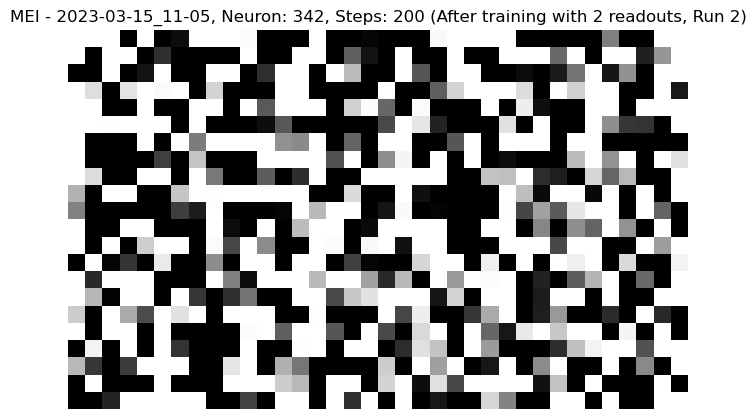

  Generating MEI 344/373: Neuron 343


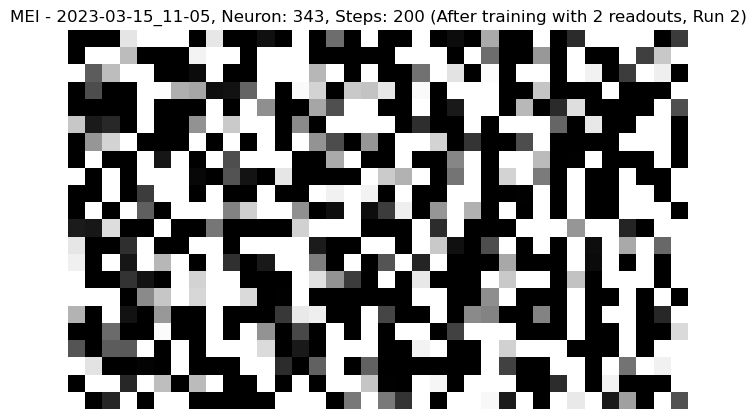

  Generating MEI 345/373: Neuron 344


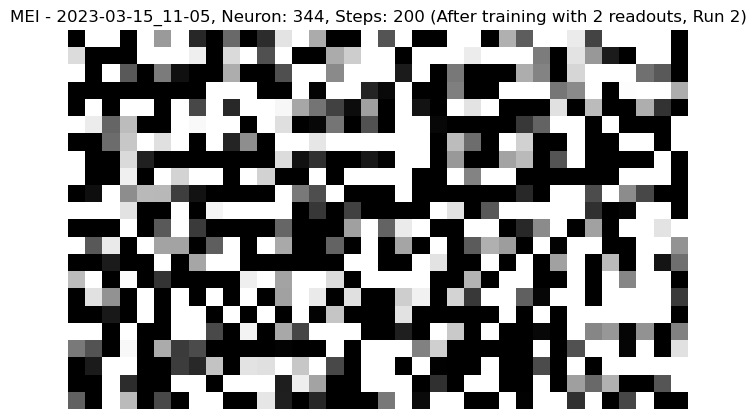

  Generating MEI 346/373: Neuron 345


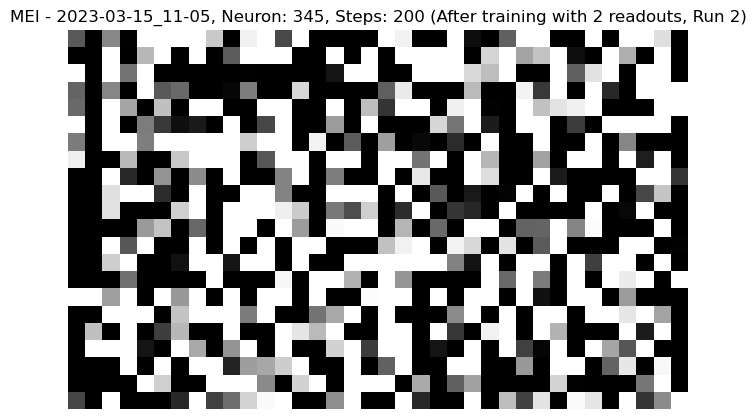

  Generating MEI 347/373: Neuron 346


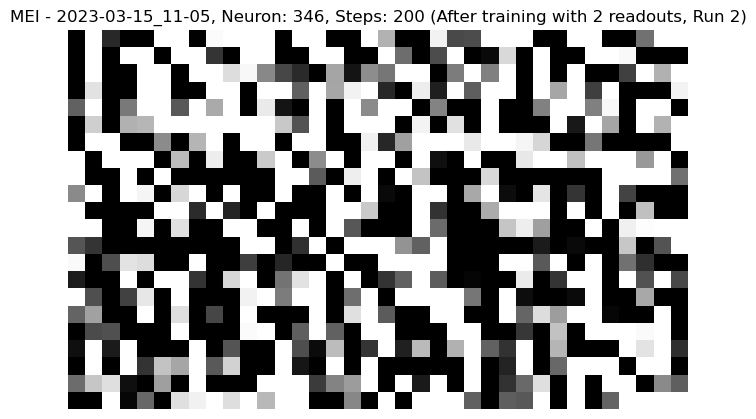

  Generating MEI 348/373: Neuron 347


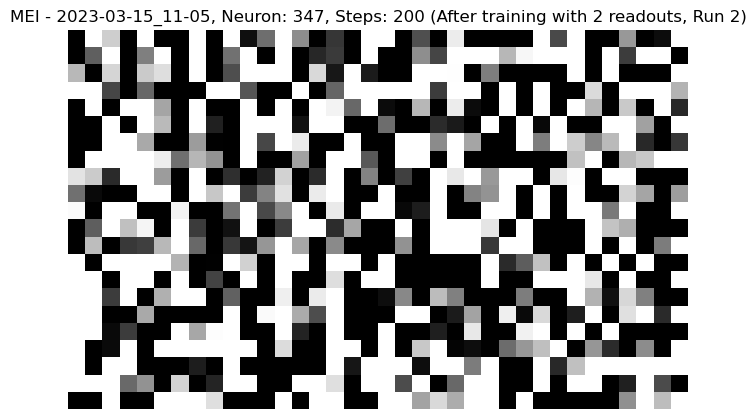

  Generating MEI 349/373: Neuron 348


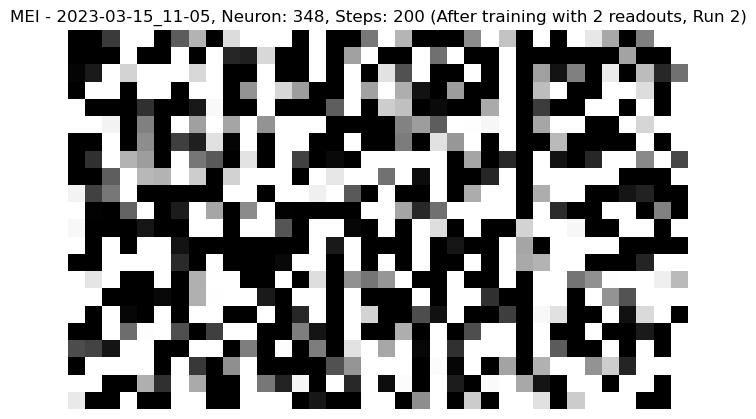

  Generating MEI 350/373: Neuron 349


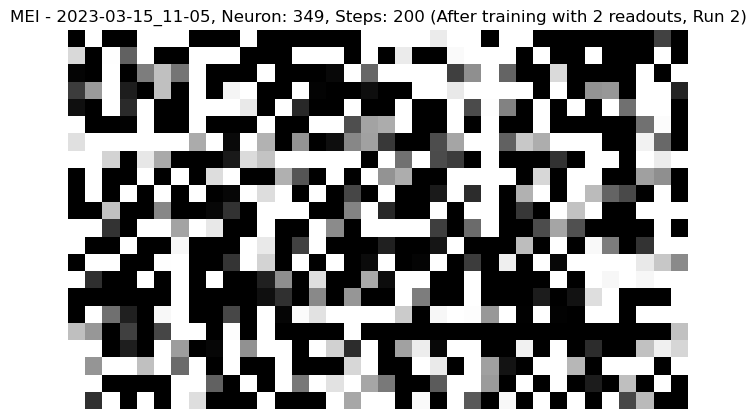

  Generating MEI 351/373: Neuron 350


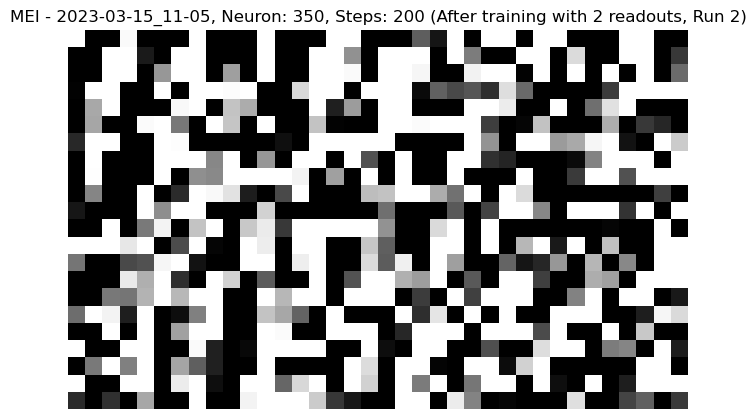

  Generating MEI 352/373: Neuron 351


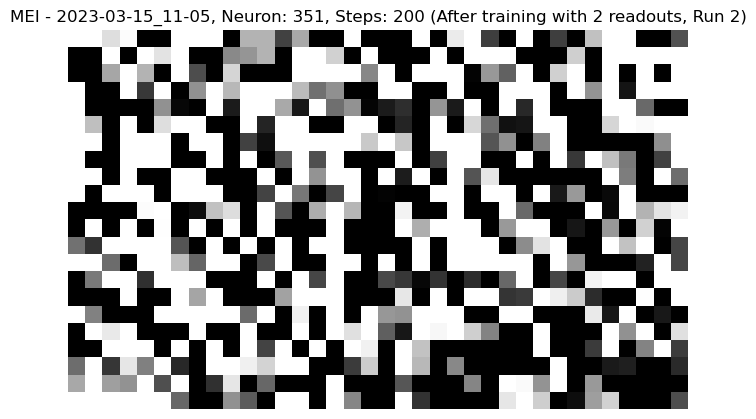

  Generating MEI 353/373: Neuron 352


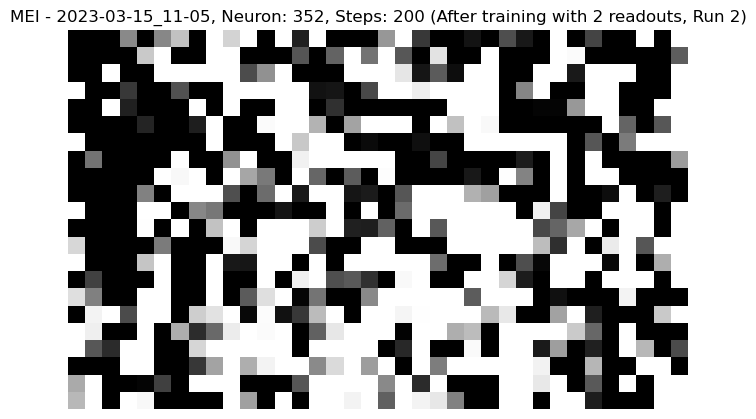

  Generating MEI 354/373: Neuron 353


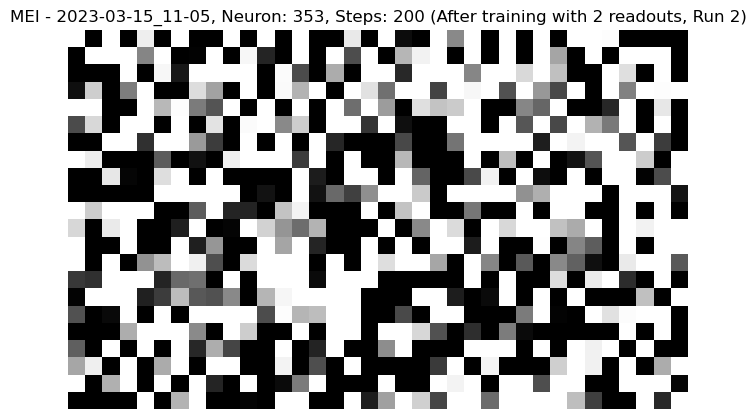

  Generating MEI 355/373: Neuron 354


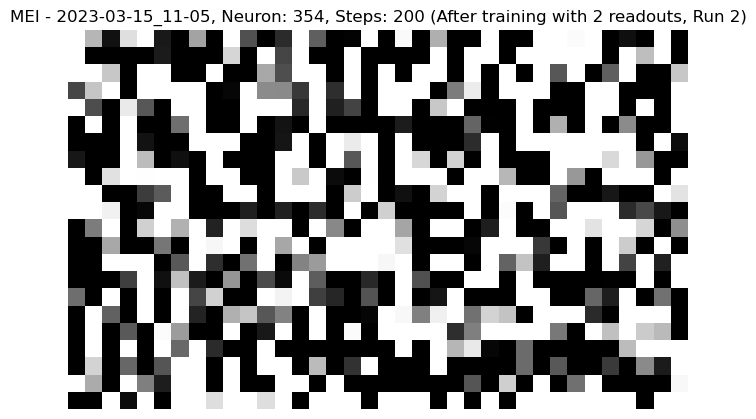

  Generating MEI 356/373: Neuron 355


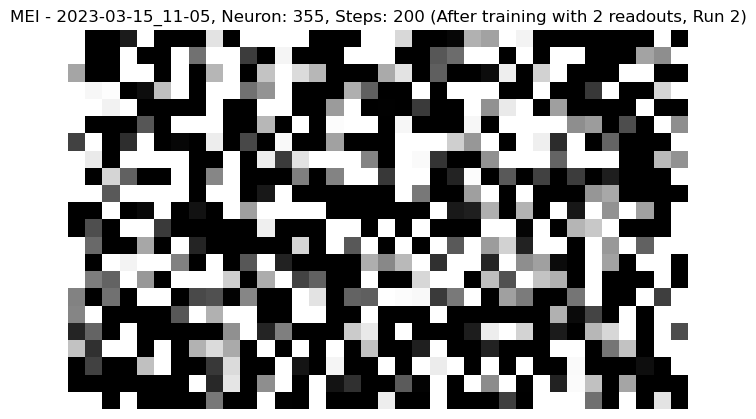

  Generating MEI 357/373: Neuron 356


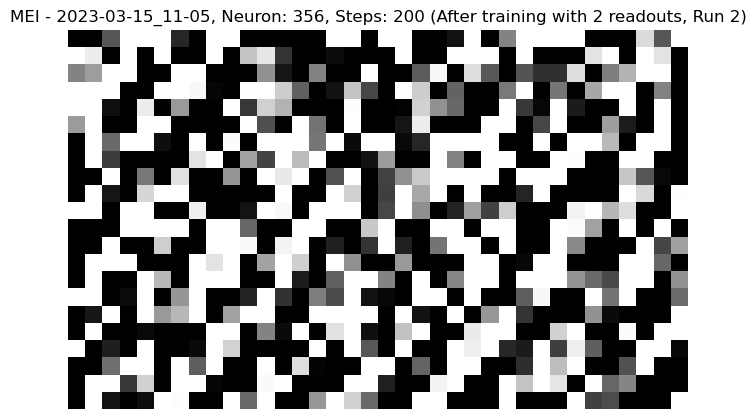

  Generating MEI 358/373: Neuron 357


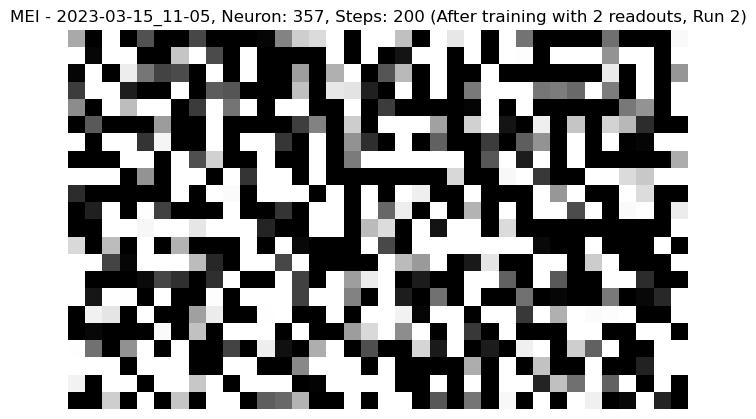

  Generating MEI 359/373: Neuron 358


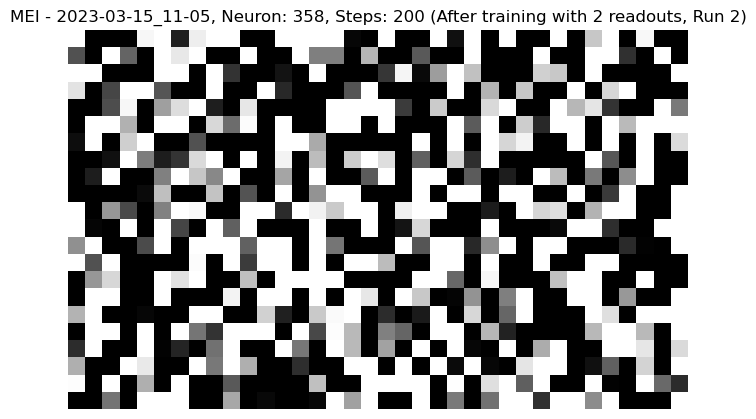

  Generating MEI 360/373: Neuron 359


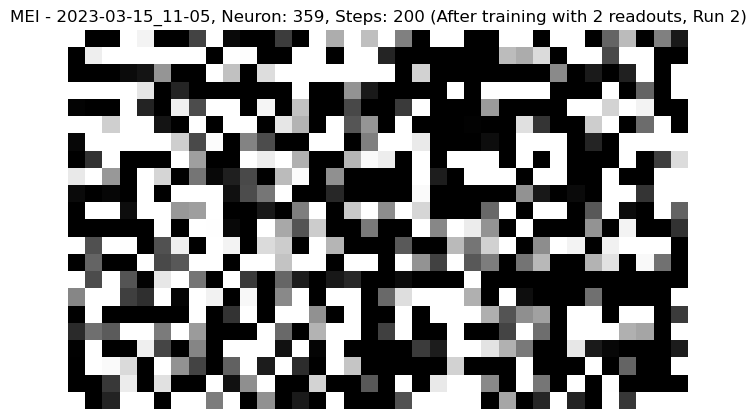

  Generating MEI 361/373: Neuron 360


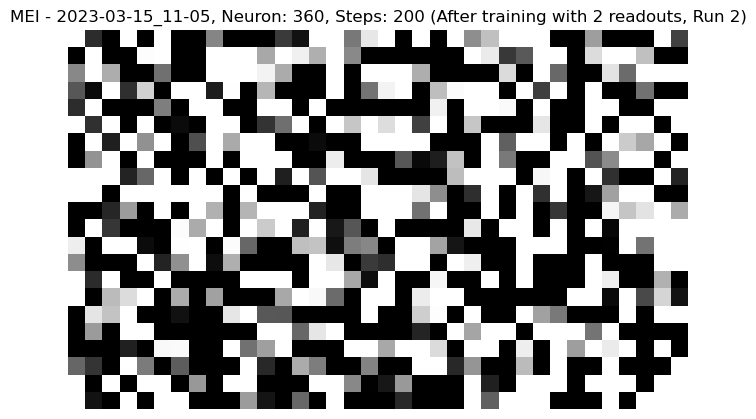

  Generating MEI 362/373: Neuron 361


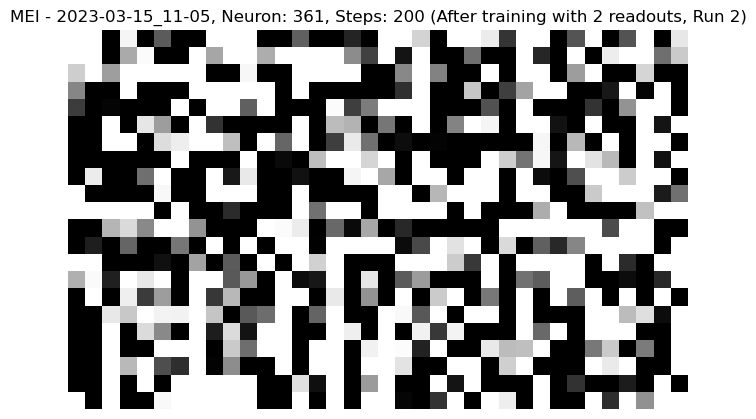

  Generating MEI 363/373: Neuron 362


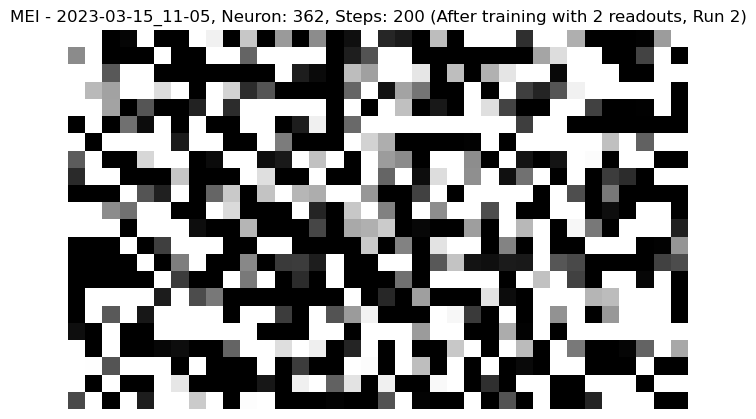

  Generating MEI 364/373: Neuron 363


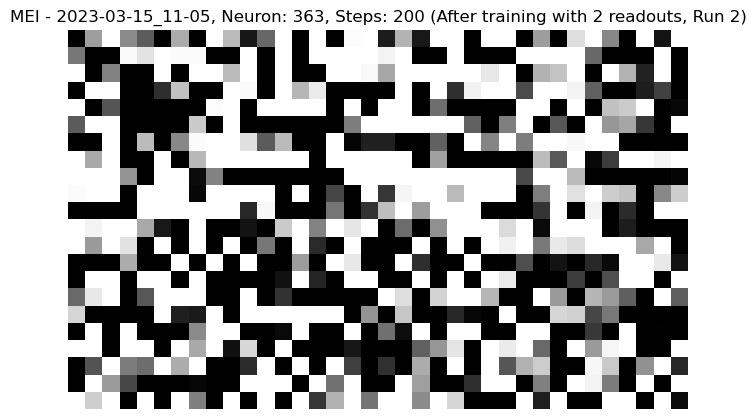

  Generating MEI 365/373: Neuron 364


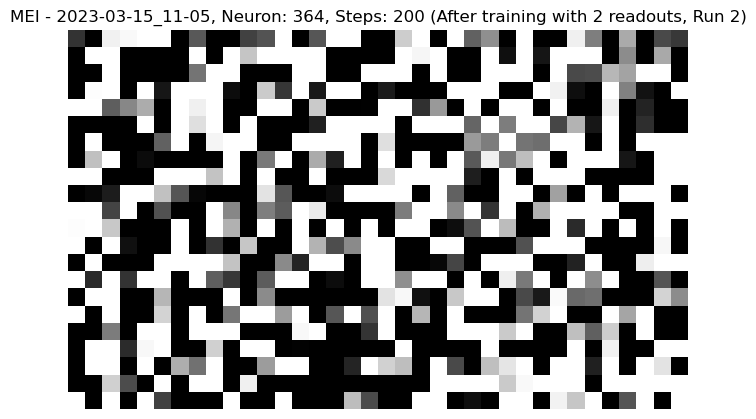

  Generating MEI 366/373: Neuron 365


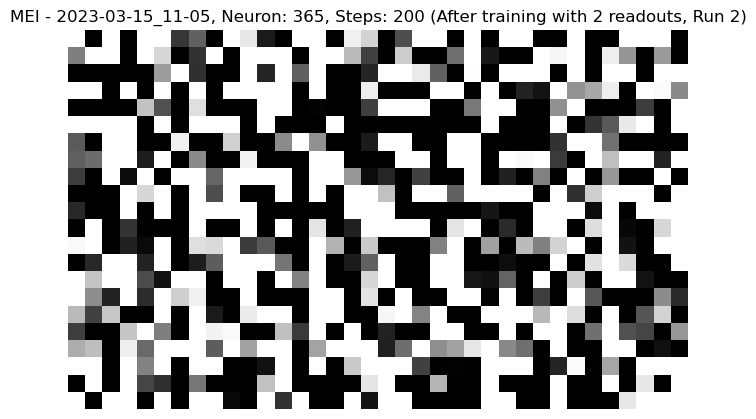

  Generating MEI 367/373: Neuron 366


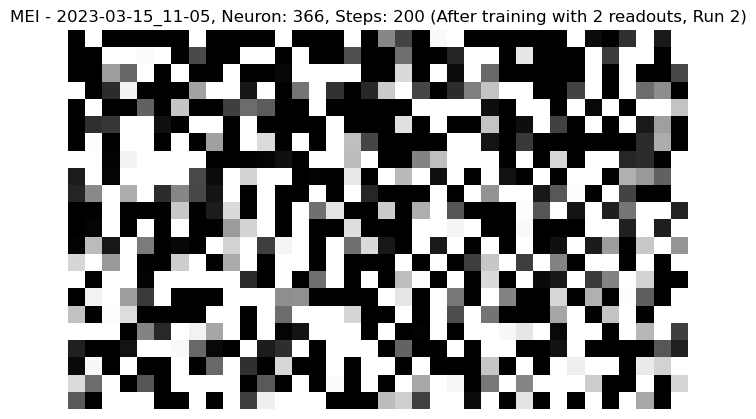

  Generating MEI 368/373: Neuron 367


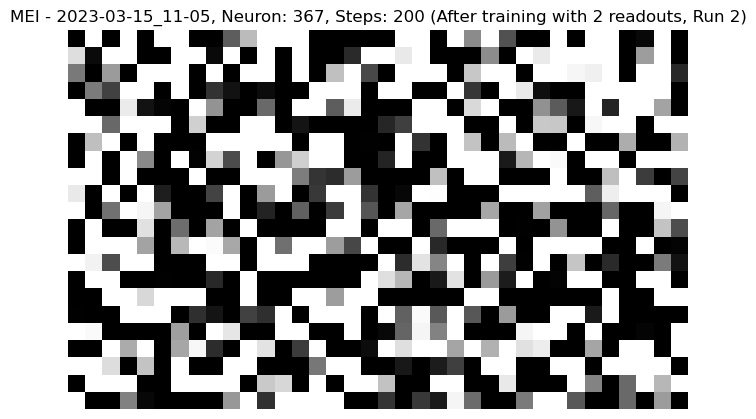

  Generating MEI 369/373: Neuron 368


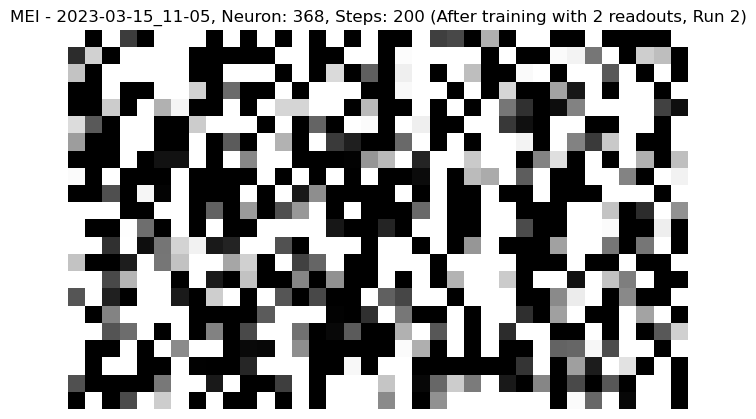

  Generating MEI 370/373: Neuron 369


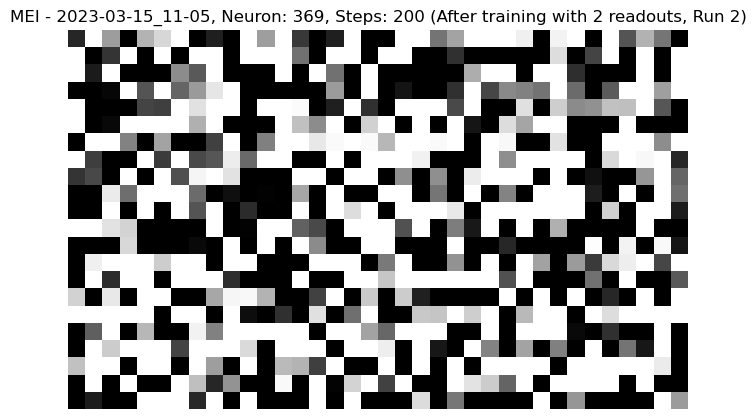

  Generating MEI 371/373: Neuron 370


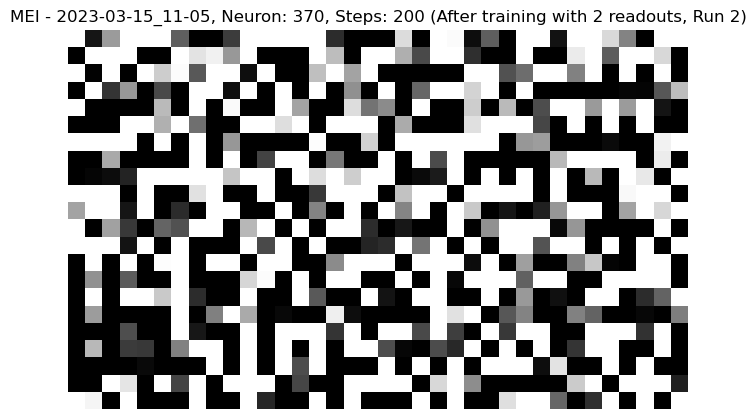

  Generating MEI 372/373: Neuron 371


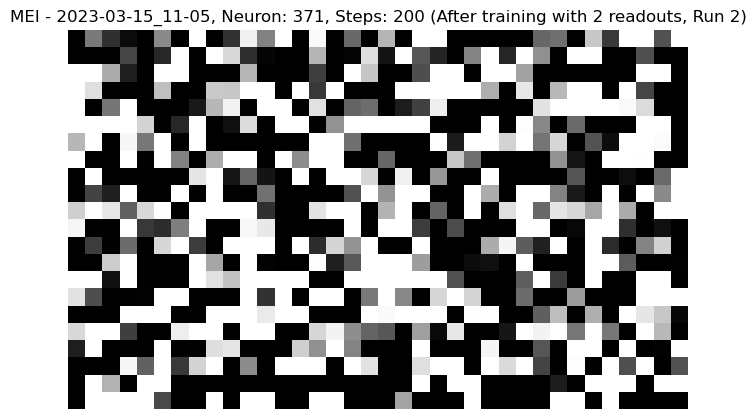

  Generating MEI 373/373: Neuron 372


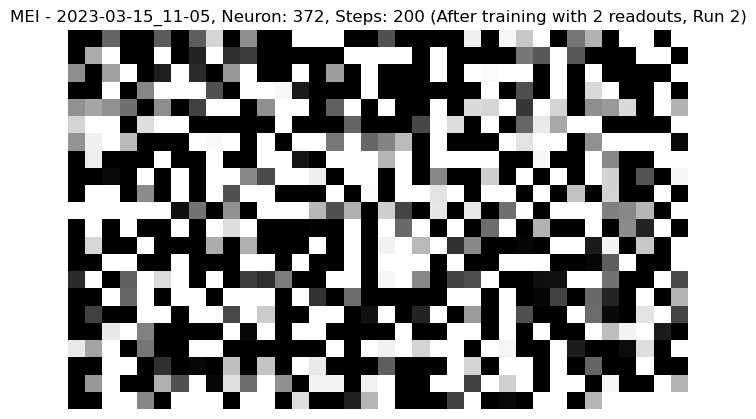

In [169]:
################ E. Generate MEIs ################
n_neurons_dict = {
    '2023-03-15_11-05': 373
}

generate_and_save_meis(n_neurons_dict, steps=200, title_suffix="(After training with 2 readouts, Run 2)")

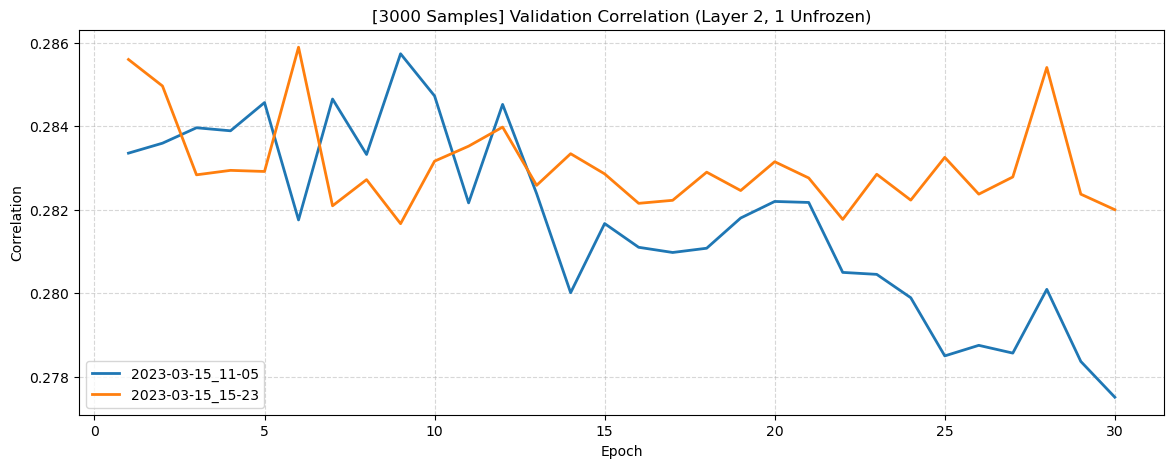

In [166]:
import matplotlib.pyplot as plt
################ F. Plot for different freezing stages ################
def plot_metric(history, history_metric, title, label):
    hist_length = len(history[list(history.keys())[0]][history_metric])
    epochs = range(1, hist_length + 1)
    fig, ax = plt.subplots(1, 1, figsize=(14, 5))

    # Plot each date with a different color
    colors = plt.cm.tab10.colors  # Use tab10 colormap for distinct colors
    for i, (dk, dk_history) in enumerate(history.items()):
        color = colors[i % len(colors)]  # Cycle through colors if more dates than colors
        # metric_values = dk_history[history_metric]
        # Pad with NaN for dates with fewer epochs
        # padded_values = metric_values + [float('nan')] * (max_epochs - len(metric_values))
        ax.plot(epochs, dk_history[history_metric], label=dk, linewidth=2, color=color)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    
    plt.show()

plot_metric(history, 'val_corr', "[3000 Samples] Validation Correlation (Layer 2, 1 Unfrozen)", "Correlation")


def plot_mei(mei_tensor, neuron_idx, title="MEI", save_folder=None):
    """
    mei_tensor: torch.Tensor with shape (1, C, H, W) or (C, H, W)
    """
    # Move to CPU and convert to numpy
    img = mei_tensor.detach().cpu().squeeze()

    img = torch.moveaxis(img, 1, 0) # Flip the axis to have (H, W)

    # If single channel: shape = (H, W)
    if img.dim() == 2:
        plt.imshow(img, cmap='gray')

    # If multi-channel: shape = (C, H, W)
    elif img.dim() == 3:
        # reorder to (H, W, C)
        img = img.permute(1, 2, 0)
        plt.imshow(img)

    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")

    plt.title(title)
    plt.axis("off")

    if save_folder:
        filename = f"mei_neuron{neuron_idx:03d}.png"
        filepath = os.path.join(save_folder, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.show()
        # plt.close(fig)

In [184]:
# # Saving the model
# MODEL_SAVE_PATH = 'models/first_full_model.pt'
# torch.save(model.state_dict(), MODEL_SAVE_PATH)


In [187]:
# # Loading the model
model_state_dict = torch.load(MODEL_SAVE_PATH, weights_only=False)
model.load_state_dict(model_state_dict)
model

OrderedDict([('core._input_weights_regularizer.laplace.filter',
              tensor([[[[ 0., -1.,  0.],
                        [-1.,  4., -1.],
                        [ 0., -1.,  0.]]]], device='mps:0')),
             ('core.features.layer0.conv.weight',
              tensor([[[[ 0.0091,  0.0068, -0.0433,  ..., -0.0357, -0.0299,  0.0201],
                        [-0.0003,  0.0116, -0.0184,  ..., -0.0217,  0.0129,  0.0044],
                        [ 0.0107,  0.0271,  0.0058,  ...,  0.0213, -0.0264, -0.0084],
                        ...,
                        [ 0.0253, -0.0125,  0.0461,  ...,  0.0098,  0.0354, -0.0176],
                        [-0.0002,  0.0214,  0.0079,  ..., -0.0129,  0.0434,  0.0380],
                        [-0.0109, -0.0095, -0.0123,  ..., -0.0237, -0.0479, -0.0043]]],
              
              
                      [[[-0.0152, -0.0234,  0.0439,  ...,  0.0455,  0.0015,  0.0161],
                        [-0.0047,  0.0012, -0.0039,  ..., -0.0379,  0.0166,  0.